<a href="https://colab.research.google.com/github/yahyakesenek/KOU/blob/master/kydevnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

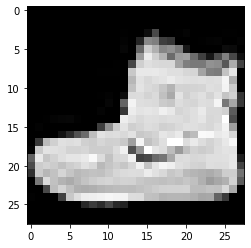

(28, 28)

In [0]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as pl

import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
TEST=True
img=x_train[0]
#img = cv2.imread(x_train[0],cv2.IMREAD_GRAYSCALE)/255
pl.imshow(img,cmap="gray")
if TEST:
  pl.show()
img.shape


In [0]:
class Layer:
  """Layer abstract class"""

  def __init__(self):
    pass

  def backward(self):
    pass


class Flatten(Layer):
  def forward(self,output):
    self.input=output.shape
    flat=output.reshape((36,8))
    self.modified = flat
    return self.modified
  def backward(self,output):
    return output.reshape(self.input)

In [0]:
class Linear(Layer):
  def __init__(self, input_dim, output_dim):
    self.weights = np.random.rand(output_dim, input_dim)
    self.biases = np.random.rand(output_dim, 1)
    self.type = 'Linear'

  def __str__(self):
    return f"{self.type} Layer"

  def forward(self, input_val):
    self._prev_acti = input_val
    return np.matmul(self.weights, input_val) + self.biases

  def backward(self, dA,learning_rate):
    dW = np.dot(dA, self._prev_acti.T)
    dB = dA.mean(axis=1, keepdims=True)

    delta = np.dot(self.weights.T, dA)
    self.weights = self.weights - learning_rate * dW
    self.biases = self.biases - learning_rate * dB
    return delta


In [0]:
class Sigmoid(Layer):
  def __init__(self, output_dim):
    self.units = output_dim
    self.type = 'Sigmoid'

  def __str__(self):
    return f"{self.type} Layer"

  def forward(self, input_val):
    self._prev_acti = 1 / (1 + np.exp(-input_val))
    return self._prev_acti

  def backward(self, dJ):
    sig = self._prev_acti
    return dJ * sig * (1 - sig)


In [0]:
class Conv:
  def __init__(self,num_filters,filter_size):
    self.num_filters=num_filters
    self.filter_size=filter_size
    self.conv_filter=np.random.randn(num_filters,filter_size,filter_size)/(filter_size*filter_size)#(x,4,4)=> 16 ya bölünerek nırmalize edilir.

  def image_region(self,image):#parça üretim amacıyla kullanılmaktadır. n-x+1 patch boyutu
    height,width=image.shape
    self.image = image
    for j in range(height-self.filter_size+1):
      for k in range(width-self.filter_size+1):
        image_patch=image[j:(j+self.filter_size),k:(k+self.filter_size)]
        yield image_patch,j,k
  def forward_prop(self,image):
    height,width=image.shape
    conv_out=np.zeros((height-self.filter_size+1,width-self.filter_size+1,self.num_filters))
    for image_patch,i,j in self.image_region(image):
      conv_out[i,j] = np.sum(image_patch*self.conv_filter,axis=(1,2))
    return conv_out
  def back_prop(self,dl_dout,learning_rate):#dl_dout -> max-pool değeriyle gelecek
    dl=np.zeros(self.conv_filter.shape)
    for image_patch,i,j in self.image_region(self.image):
      for k in range(self.num_filters):
        dl[k] +=image_patch*dl_dout[i,j,k]
    self.conv_filter -=learning_rate*dl
    return dl

(28, 28)
(22, 22, 18)


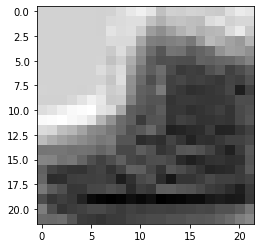

In [0]:
conv = Conv(18,7)
out = conv.forward_prop(img)
print(img.shape)
print(out.shape)
pl.imshow(out[:,:,8],cmap="gray") # 3 değeri 0-17 a kadar değer alabilir
if TEST:
  pl.show()


In [0]:
class MaxPool:
  def __init__(self, filter_size):
    self.filter_size = filter_size

  def image_region(self, image):  # parça üretim amacıyla kullanılmaktadır. n-x+1 patch boyutu
    height, width = image.shape[0] // self.filter_size, image.shape[1] // self.filter_size
    self.image = image
    for i in range(height - self.filter_size + 1):
      for j in range(width - self.filter_size + 1):
        image_patch = image[(i * self.filter_size):(i * self.filter_size + self.filter_size),
                      (j * self.filter_size):(j * self.filter_size + self.filter_size)]
        yield image_patch, i, j

  def forward_prop(self, image):
    height, width, num_filters = image.shape
    self.num_filters = num_filters
    conv_out = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))
    for image_patch, i, j in self.image_region(image):
      conv_out[i, j] = np.amax(image_patch * self.filter_size, axis=(0, 1))
    return conv_out

  def back_prop(self, dl_dout):  # softmax kullanımına dikkat edilecek  dl_out bir softmax
    dl = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      for k in range(self.num_filters):
        h, w, filter = image_patch.shape
        max_val = np.amax(image_patch, axis=(0, 1))
        for i1 in range(h):
          for j1 in range(w):
            for k1 in range(filter):
              if image_patch[i1, j1, k1] == max_val[k1]:
                dl[i * self.filter_size + i1, j * self.filter_size + j1, k1] = dl_dout[j, j, k1]

    return dl


(5, 5, 18)


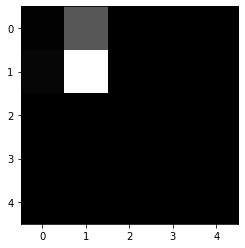

In [0]:
maxpol = MaxPool(4)
out = maxpol.forward_prop(out)
print(out.shape)
pl.imshow(out[:,:,7],cmap="gray")
if TEST:
  pl.show()

In [0]:
class Softmax:
  def __init__(self,_input,soft):
    self.weight=np.random.randn(_input,soft)/_input
    self.bias = np.zeros(soft)
  def forward(self,image):
    self.orig_im_shape = image.shape
    flattened = image.flatten()
    self.modified = flattened
    self.out=np.dot(self.modified,self.weight)+self.bias
    exp_out = np.exp(self.out)
    return exp_out/np.sum(exp_out,axis=0)
  def backwad(self,dl_dout,learning_rate):
    for i,grad in enumerate(dl_dout):
      if grad == 0:
        continue
      transformation = np.exp(self.out)
      s_total = np.sum(transformation)
      dy_dz = -transformation[i]*transformation/(s_total**2)#z ye göre türev
      dy_dz[i] = transformation[i]*(s_total-transformation[i])/(s_total**2)

      dz_dw = self.modified
      dz_db = 1
      dz_input = self.weight

      dL_dz=grad*dy_dz
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz*dz_db
      dL_input = dz_input@dL_dz

      self.weight -= learning_rate*dL_dw
      self.bias -=learning_rate*dL_db
      return dL_input.reshape(self.orig_im_shape)


In [0]:
s=Softmax(5*5*18,10)
out = s.forward(out)
print(out)

[0.08887981 0.1212492  0.09018213 0.10618145 0.08377565 0.08980891
 0.10835684 0.07899596 0.10291306 0.129657  ]


In [0]:
def permute_data(X: np.ndarray, y: np.ndarray):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]


In [0]:
def generate_batches(X,y,size= 32):

        assert X.shape[0] == y.shape[0], \
        '''
        features and target must have the same number of rows, instead
        features has {0} and target has {1}
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]
            yield X_batch, y_batch

In [0]:
mConv = Conv(8,3) # (28,28,1)=>(26,26,8)
mPool = MaxPool(4) # (26,26,8) => (6,6,8)
mFlatten=Flatten() # 6*6 => (36,8)
mLinear=Linear(input_dim=36,output_dim=8)
mSigmoid=Sigmoid(output_dim=8)
mSoftmax = Softmax(8*8,10) # (8*8) => 64

In [0]:
def forward(img,label):
  out=mConv.forward_prop(img/255)
  out=mPool.forward_prop(out)
  out=mFlatten.forward(out)
  out=mLinear.forward(out)
  out=mSigmoid.forward(out)
  out=mSoftmax.forward(out)
  cross_ent = -np.log(out[label])
  accuracy = 1 if np.argmax(out) == label else 0
  return out,cross_ent,accuracy


In [0]:
def train(img,label,learning_rate=0.005):
  out,loss,acc = forward(img,label)
  grad = np.zeros(10)
  grad[label] = -1/out[label]
  grad_back = mSoftmax.backwad(grad,learning_rate)
  grad_back=mSigmoid.backward(grad_back)
  grad_back=mLinear.backward(grad_back,learning_rate)
  grad_back=mFlatten.backward(grad_back)
  grad_back = mPool.back_prop(grad_back)
  grad_back = mConv.back_prop(grad_back,learning_rate)
  return loss,acc

In [1]:
batch_size=32
seed=3459877
np.random.seed(seed)
for epoc in range(10):
  print("Epoch => {}".format(epoc+1))
  loss = 0
  num_correct = 0
  X_train, y_train = permute_data(x_train, y_train)         
  for i,(im,label) in enumerate(zip(X_train,y_train)):
    if i % 100 == 0 and i>0:
      print("{} steps out of 100 steps : average {}  and accuracy {}%".format(i+1,loss/100,num_correct))
      loss=0
      num_correct=0
    l1,acc=train(im,label)
    loss+=l1
    num_correct+=acc

NameError: ignored

Epoch => 1
101 steps out of 100 steps : average 2.323569227963052  and accuracy 7%
201 steps out of 100 steps : average 2.279478159618017  and accuracy 12%
301 steps out of 100 steps : average 2.242749101447052  and accuracy 20%
401 steps out of 100 steps : average 2.2265222540258542  and accuracy 15%
501 steps out of 100 steps : average 2.2134964365834415  and accuracy 16%
601 steps out of 100 steps : average 2.189512321831438  and accuracy 13%
701 steps out of 100 steps : average 2.1155745605414777  and accuracy 21%
801 steps out of 100 steps : average 2.125818989874223  and accuracy 19%
901 steps out of 100 steps : average 2.028777966770354  and accuracy 23%
1001 steps out of 100 steps : average 1.9921910558848746  and accuracy 20%
1101 steps out of 100 steps : average 1.9985878213446373  and accuracy 25%
1201 steps out of 100 steps : average 1.9945717177656925  and accuracy 22%
1301 steps out of 100 steps : average 1.9713573739145267  and accuracy 17%
1401 steps out of 100 steps : average 1.9027431178210554  and accuracy 26%
1501 steps out of 100 steps : average 2.0045364996383364  and accuracy 22%
1601 steps out of 100 steps : average 1.9718446347635634  and accuracy 20%
1701 steps out of 100 steps : average 1.8743285989976304  and accuracy 26%
1801 steps out of 100 steps : average 1.8992016739879376  and accuracy 20%
1901 steps out of 100 steps : average 1.866923262095632  and accuracy 21%
2001 steps out of 100 steps : average 1.9279458760509798  and accuracy 17%
2101 steps out of 100 steps : average 1.8477674804009951  and accuracy 25%
2201 steps out of 100 steps : average 1.791609940453588  and accuracy 27%
2301 steps out of 100 steps : average 1.8219595831521938  and accuracy 28%
2401 steps out of 100 steps : average 1.7587431566659433  and accuracy 23%
2501 steps out of 100 steps : average 1.8567537746706262  and accuracy 21%
2601 steps out of 100 steps : average 1.8017540553322895  and accuracy 26%
2701 steps out of 100 steps : average 1.8028285190189564  and accuracy 24%
2801 steps out of 100 steps : average 1.8179900385969245  and accuracy 18%
2901 steps out of 100 steps : average 1.8274620350281845  and accuracy 24%
3001 steps out of 100 steps : average 1.8083165833998462  and accuracy 23%
3101 steps out of 100 steps : average 1.831801739396128  and accuracy 29%
3201 steps out of 100 steps : average 1.7986669966398219  and accuracy 21%
3301 steps out of 100 steps : average 1.8510091598884104  and accuracy 20%
3401 steps out of 100 steps : average 1.7721761444652744  and accuracy 17%
3501 steps out of 100 steps : average 1.7903408910055285  and accuracy 26%
3601 steps out of 100 steps : average 1.739645464918574  and accuracy 27%
3701 steps out of 100 steps : average 1.7286581125099532  and accuracy 27%
3801 steps out of 100 steps : average 1.7771021875704884  and accuracy 22%
3901 steps out of 100 steps : average 1.7998456960070193  and accuracy 20%
4001 steps out of 100 steps : average 1.7813393855166124  and accuracy 21%
4101 steps out of 100 steps : average 1.720545453622282  and accuracy 28%
4201 steps out of 100 steps : average 1.7019432649693287  and accuracy 28%
4301 steps out of 100 steps : average 1.736454174511443  and accuracy 22%
4401 steps out of 100 steps : average 1.748029746674947  and accuracy 26%
4501 steps out of 100 steps : average 1.782394510499054  and accuracy 29%
4601 steps out of 100 steps : average 1.7685622257387863  and accuracy 23%
4701 steps out of 100 steps : average 1.7131469678637135  and accuracy 29%
4801 steps out of 100 steps : average 1.7783456082017692  and accuracy 20%
4901 steps out of 100 steps : average 1.7202556650582828  and accuracy 26%
5001 steps out of 100 steps : average 1.68595152131422  and accuracy 26%
5101 steps out of 100 steps : average 1.7012328100061906  and accuracy 31%
5201 steps out of 100 steps : average 1.723534921727192  and accuracy 24%
5301 steps out of 100 steps : average 1.6880398958453002  and accuracy 22%
5401 steps out of 100 steps : average 1.7112848857234613  and accuracy 25%
5501 steps out of 100 steps : average 1.7642629475586764  and accuracy 18%
5601 steps out of 100 steps : average 1.6048801594363922  and accuracy 37%
5701 steps out of 100 steps : average 1.715936246594761  and accuracy 30%
5801 steps out of 100 steps : average 1.6787539410802643  and accuracy 28%
5901 steps out of 100 steps : average 1.6399050343283477  and accuracy 29%
6001 steps out of 100 steps : average 1.706822367827278  and accuracy 32%
6101 steps out of 100 steps : average 1.633491653288529  and accuracy 26%
6201 steps out of 100 steps : average 1.6641298147968069  and accuracy 28%
6301 steps out of 100 steps : average 1.6414798746049297  and accuracy 27%
6401 steps out of 100 steps : average 1.6723968248947445  and accuracy 26%
6501 steps out of 100 steps : average 1.627685386311727  and accuracy 34%
6601 steps out of 100 steps : average 1.677960161215706  and accuracy 30%
6701 steps out of 100 steps : average 1.681238215140801  and accuracy 32%
6801 steps out of 100 steps : average 1.7035297894536243  and accuracy 34%
6901 steps out of 100 steps : average 1.6772664532267614  and accuracy 32%
7001 steps out of 100 steps : average 1.6580187314461186  and accuracy 29%
7101 steps out of 100 steps : average 1.7580872204973301  and accuracy 30%
7201 steps out of 100 steps : average 1.6455105295264267  and accuracy 27%
7301 steps out of 100 steps : average 1.6491226640073557  and accuracy 35%
7401 steps out of 100 steps : average 1.5978870183427838  and accuracy 32%
7501 steps out of 100 steps : average 1.7265700889196867  and accuracy 40%
7601 steps out of 100 steps : average 1.4925175608456323  and accuracy 35%
7701 steps out of 100 steps : average 1.6087331640534586  and accuracy 36%
7801 steps out of 100 steps : average 1.5976161148009194  and accuracy 32%
7901 steps out of 100 steps : average 1.5846222706645727  and accuracy 28%
8001 steps out of 100 steps : average 1.6101222105898572  and accuracy 30%
8101 steps out of 100 steps : average 1.5839455734547696  and accuracy 39%
8201 steps out of 100 steps : average 1.5342180054561367  and accuracy 43%
8301 steps out of 100 steps : average 1.6298904957246934  and accuracy 36%
8401 steps out of 100 steps : average 1.6133522646417036  and accuracy 37%
8501 steps out of 100 steps : average 1.5206206199335979  and accuracy 32%
8601 steps out of 100 steps : average 1.6065206985812062  and accuracy 27%
8701 steps out of 100 steps : average 1.5676340000032842  and accuracy 36%
8801 steps out of 100 steps : average 1.5326001250380332  and accuracy 36%
8901 steps out of 100 steps : average 1.5243907680999853  and accuracy 41%
9001 steps out of 100 steps : average 1.5942148342257068  and accuracy 40%
9101 steps out of 100 steps : average 1.5181226870668394  and accuracy 45%
9201 steps out of 100 steps : average 1.5087160982081884  and accuracy 40%
9301 steps out of 100 steps : average 1.4798566584184698  and accuracy 43%
9401 steps out of 100 steps : average 1.5915496469149364  and accuracy 23%
9501 steps out of 100 steps : average 1.5202627533866928  and accuracy 39%
9601 steps out of 100 steps : average 1.462966814618978  and accuracy 40%
9701 steps out of 100 steps : average 1.528276330432027  and accuracy 43%
9801 steps out of 100 steps : average 1.4742789765433593  and accuracy 38%
9901 steps out of 100 steps : average 1.548456323116305  and accuracy 42%
10001 steps out of 100 steps : average 1.5897218977062744  and accuracy 30%
10101 steps out of 100 steps : average 1.4686787627227178  and accuracy 42%
10201 steps out of 100 steps : average 1.4827997618367896  and accuracy 39%
10301 steps out of 100 steps : average 1.400518994564249  and accuracy 49%
10401 steps out of 100 steps : average 1.4573131732010765  and accuracy 43%
10501 steps out of 100 steps : average 1.5087888649572476  and accuracy 38%
10601 steps out of 100 steps : average 1.4569977584939793  and accuracy 47%
10701 steps out of 100 steps : average 1.367082555338164  and accuracy 49%
10801 steps out of 100 steps : average 1.51641509199222  and accuracy 47%
10901 steps out of 100 steps : average 1.4266844174929063  and accuracy 39%
11001 steps out of 100 steps : average 1.3229633420590674  and accuracy 49%
11101 steps out of 100 steps : average 1.4486134684384087  and accuracy 37%
11201 steps out of 100 steps : average 1.3942553293463729  and accuracy 43%
11301 steps out of 100 steps : average 1.3832084441228347  and accuracy 45%
11401 steps out of 100 steps : average 1.4252743989552608  and accuracy 46%
11501 steps out of 100 steps : average 1.360186961885085  and accuracy 49%
11601 steps out of 100 steps : average 1.461270670622159  and accuracy 50%
11701 steps out of 100 steps : average 1.3360050021421233  and accuracy 49%
11801 steps out of 100 steps : average 1.399575135082885  and accuracy 48%
11901 steps out of 100 steps : average 1.4428623601028046  and accuracy 44%
12001 steps out of 100 steps : average 1.3789412792068783  and accuracy 43%
12101 steps out of 100 steps : average 1.423069629069266  and accuracy 43%
12201 steps out of 100 steps : average 1.3771699884785054  and accuracy 46%
12301 steps out of 100 steps : average 1.3268230230857592  and accuracy 55%
12401 steps out of 100 steps : average 1.4205057662296725  and accuracy 41%
12501 steps out of 100 steps : average 1.3365446961577245  and accuracy 48%
12601 steps out of 100 steps : average 1.3359601053251038  and accuracy 48%
12701 steps out of 100 steps : average 1.4785350155388075  and accuracy 38%
12801 steps out of 100 steps : average 1.3987919243391167  and accuracy 39%
12901 steps out of 100 steps : average 1.276639719500946  and accuracy 56%
13001 steps out of 100 steps : average 1.3242931668467985  and accuracy 45%
13101 steps out of 100 steps : average 1.369973846048562  and accuracy 46%
13201 steps out of 100 steps : average 1.3784931748179656  and accuracy 49%
13301 steps out of 100 steps : average 1.3241388859424432  and accuracy 49%
13401 steps out of 100 steps : average 1.3686648216742439  and accuracy 50%
13501 steps out of 100 steps : average 1.3150168434551792  and accuracy 51%
13601 steps out of 100 steps : average 1.3838267594417997  and accuracy 47%
13701 steps out of 100 steps : average 1.3261332378839097  and accuracy 52%
13801 steps out of 100 steps : average 1.3631072832937179  and accuracy 45%
13901 steps out of 100 steps : average 1.333527863363788  and accuracy 42%
14001 steps out of 100 steps : average 1.289626937799509  and accuracy 56%
14101 steps out of 100 steps : average 1.4002424803558284  and accuracy 43%
14201 steps out of 100 steps : average 1.3335841349073845  and accuracy 41%
14301 steps out of 100 steps : average 1.2858348289527586  and accuracy 53%
14401 steps out of 100 steps : average 1.245218005660551  and accuracy 55%
14501 steps out of 100 steps : average 1.2743784216331544  and accuracy 55%
14601 steps out of 100 steps : average 1.3288568565165262  and accuracy 45%
14701 steps out of 100 steps : average 1.2541998515631534  and accuracy 53%
14801 steps out of 100 steps : average 1.2872313798596564  and accuracy 56%
14901 steps out of 100 steps : average 1.3376899859474016  and accuracy 44%
15001 steps out of 100 steps : average 1.2813136964015266  and accuracy 48%
15101 steps out of 100 steps : average 1.2495898096031637  and accuracy 59%
15201 steps out of 100 steps : average 1.2904761182876192  and accuracy 57%
15301 steps out of 100 steps : average 1.3734757831415487  and accuracy 42%
15401 steps out of 100 steps : average 1.2478983836199664  and accuracy 50%
15501 steps out of 100 steps : average 1.2307411028030686  and accuracy 54%
15601 steps out of 100 steps : average 1.35714878642769  and accuracy 43%
15701 steps out of 100 steps : average 1.2556928562961187  and accuracy 60%
15801 steps out of 100 steps : average 1.1408174850417192  and accuracy 61%
15901 steps out of 100 steps : average 1.1741897861351651  and accuracy 61%
16001 steps out of 100 steps : average 1.2457491271557604  and accuracy 56%
16101 steps out of 100 steps : average 1.1447609621677497  and accuracy 56%
16201 steps out of 100 steps : average 1.1581911575831445  and accuracy 53%
16301 steps out of 100 steps : average 1.2516546839765266  and accuracy 51%
16401 steps out of 100 steps : average 1.2286540783536217  and accuracy 52%
16501 steps out of 100 steps : average 1.2225922817948864  and accuracy 47%
16601 steps out of 100 steps : average 1.337619402967803  and accuracy 49%
16701 steps out of 100 steps : average 1.1062748069050166  and accuracy 66%
16801 steps out of 100 steps : average 1.2524506523021157  and accuracy 54%
16901 steps out of 100 steps : average 1.307597141862612  and accuracy 51%
17001 steps out of 100 steps : average 1.2424263684561845  and accuracy 50%
17101 steps out of 100 steps : average 1.2490304035807056  and accuracy 58%
17201 steps out of 100 steps : average 1.3051805629820934  and accuracy 49%
17301 steps out of 100 steps : average 1.1757932642312798  and accuracy 58%
17401 steps out of 100 steps : average 1.1648042799394531  and accuracy 49%
17501 steps out of 100 steps : average 1.182792308643212  and accuracy 56%
17601 steps out of 100 steps : average 1.134392692067985  and accuracy 57%
17701 steps out of 100 steps : average 1.0945732018239287  and accuracy 60%
17801 steps out of 100 steps : average 1.2948963649540948  and accuracy 46%
17901 steps out of 100 steps : average 1.1659739176145143  and accuracy 59%
18001 steps out of 100 steps : average 1.2120274717396835  and accuracy 54%
18101 steps out of 100 steps : average 1.0906957021941404  and accuracy 61%
18201 steps out of 100 steps : average 1.1614794132946327  and accuracy 59%
18301 steps out of 100 steps : average 1.1351556405296692  and accuracy 65%
18401 steps out of 100 steps : average 1.1428694182649042  and accuracy 56%
18501 steps out of 100 steps : average 1.190177363221475  and accuracy 57%
18601 steps out of 100 steps : average 1.1809831116995502  and accuracy 56%
18701 steps out of 100 steps : average 1.2208069218718096  and accuracy 40%
18801 steps out of 100 steps : average 1.098641151603743  and accuracy 54%
18901 steps out of 100 steps : average 1.1725684163522316  and accuracy 60%
19001 steps out of 100 steps : average 1.1737145813262768  and accuracy 55%
19101 steps out of 100 steps : average 1.2136976624302722  and accuracy 47%
19201 steps out of 100 steps : average 1.1471754811573032  and accuracy 63%
19301 steps out of 100 steps : average 1.0818398897757624  and accuracy 60%
19401 steps out of 100 steps : average 1.1247519856027197  and accuracy 58%
19501 steps out of 100 steps : average 1.1122839728504852  and accuracy 59%
19601 steps out of 100 steps : average 1.103310292485425  and accuracy 59%
19701 steps out of 100 steps : average 1.0993835362492823  and accuracy 61%
19801 steps out of 100 steps : average 1.2292249486800488  and accuracy 50%
19901 steps out of 100 steps : average 1.1636707409085003  and accuracy 53%
20001 steps out of 100 steps : average 1.0716732050648146  and accuracy 57%
20101 steps out of 100 steps : average 1.2521483972712468  and accuracy 56%
20201 steps out of 100 steps : average 1.055745610398342  and accuracy 55%
20301 steps out of 100 steps : average 1.2446013093800428  and accuracy 49%
20401 steps out of 100 steps : average 1.0596446340891215  and accuracy 57%
20501 steps out of 100 steps : average 1.1619290361162429  and accuracy 56%
20601 steps out of 100 steps : average 1.056763979681299  and accuracy 62%
20701 steps out of 100 steps : average 1.049092908001104  and accuracy 61%
20801 steps out of 100 steps : average 1.1580450026493463  and accuracy 55%
20901 steps out of 100 steps : average 1.1667698328818203  and accuracy 60%
21001 steps out of 100 steps : average 1.2315672916894094  and accuracy 50%
21101 steps out of 100 steps : average 1.0530952486886302  and accuracy 62%
21201 steps out of 100 steps : average 1.1441848578643732  and accuracy 60%
21301 steps out of 100 steps : average 1.0118314026686759  and accuracy 65%
21401 steps out of 100 steps : average 1.1995372134714732  and accuracy 57%
21501 steps out of 100 steps : average 1.2026457546225364  and accuracy 50%
21601 steps out of 100 steps : average 1.1111242210488237  and accuracy 60%
21701 steps out of 100 steps : average 1.0273779722443954  and accuracy 60%
21801 steps out of 100 steps : average 1.0567759412933155  and accuracy 57%
21901 steps out of 100 steps : average 1.03477291778331  and accuracy 58%
22001 steps out of 100 steps : average 1.161639526169781  and accuracy 62%
22101 steps out of 100 steps : average 0.9724943726031363  and accuracy 65%
22201 steps out of 100 steps : average 1.127912746329104  and accuracy 49%
22301 steps out of 100 steps : average 1.164005161409355  and accuracy 57%
22401 steps out of 100 steps : average 1.1961934784466117  and accuracy 54%
22501 steps out of 100 steps : average 1.0689397757503434  and accuracy 59%
22601 steps out of 100 steps : average 1.0957243337225284  and accuracy 56%
22701 steps out of 100 steps : average 1.1095386683027624  and accuracy 55%
22801 steps out of 100 steps : average 1.040092228822897  and accuracy 65%
22901 steps out of 100 steps : average 1.3492416359778339  and accuracy 46%
23001 steps out of 100 steps : average 1.1451451026099617  and accuracy 54%
23101 steps out of 100 steps : average 1.0427670252811998  and accuracy 58%
23201 steps out of 100 steps : average 1.0858487495022868  and accuracy 57%
23301 steps out of 100 steps : average 1.0140116827505694  and accuracy 57%
23401 steps out of 100 steps : average 1.1989780065386704  and accuracy 55%
23501 steps out of 100 steps : average 1.1319490553368037  and accuracy 58%
23601 steps out of 100 steps : average 1.0750739448789965  and accuracy 55%
23701 steps out of 100 steps : average 0.9683743406681066  and accuracy 60%
23801 steps out of 100 steps : average 1.0727017474001102  and accuracy 57%
23901 steps out of 100 steps : average 1.0788958506152184  and accuracy 62%
24001 steps out of 100 steps : average 1.1594647280678425  and accuracy 58%
24101 steps out of 100 steps : average 1.0473702697025193  and accuracy 56%
24201 steps out of 100 steps : average 1.3336731545617593  and accuracy 42%
24301 steps out of 100 steps : average 1.05450563134083  and accuracy 58%
24401 steps out of 100 steps : average 1.004608719538046  and accuracy 57%
24501 steps out of 100 steps : average 1.0298674540754826  and accuracy 59%
24601 steps out of 100 steps : average 0.9283857639976075  and accuracy 67%
24701 steps out of 100 steps : average 1.1095958258740082  and accuracy 58%
24801 steps out of 100 steps : average 1.0763978492640698  and accuracy 57%
24901 steps out of 100 steps : average 1.0777922332709737  and accuracy 62%
25001 steps out of 100 steps : average 1.102063509816997  and accuracy 61%
25101 steps out of 100 steps : average 1.1439788134639641  and accuracy 60%
25201 steps out of 100 steps : average 1.0639296700594914  and accuracy 55%
25301 steps out of 100 steps : average 1.0817662007508373  and accuracy 60%
25401 steps out of 100 steps : average 1.054327154505877  and accuracy 55%
25501 steps out of 100 steps : average 1.0646519626188131  and accuracy 57%
25601 steps out of 100 steps : average 1.064429995459345  and accuracy 52%
25701 steps out of 100 steps : average 1.0093502682894577  and accuracy 66%
25801 steps out of 100 steps : average 1.0944854710569134  and accuracy 60%
25901 steps out of 100 steps : average 1.154882078854579  and accuracy 61%
26001 steps out of 100 steps : average 1.1317988089007986  and accuracy 54%
26101 steps out of 100 steps : average 1.0578280925489334  and accuracy 57%
26201 steps out of 100 steps : average 1.1247697319811745  and accuracy 53%
26301 steps out of 100 steps : average 1.1539562406959154  and accuracy 56%
26401 steps out of 100 steps : average 0.9637628837414917  and accuracy 56%
26501 steps out of 100 steps : average 1.0888014189445756  and accuracy 59%
26601 steps out of 100 steps : average 1.0352351318558355  and accuracy 68%
26701 steps out of 100 steps : average 0.9684350997563146  and accuracy 65%
26801 steps out of 100 steps : average 1.1359583543081835  and accuracy 57%
26901 steps out of 100 steps : average 1.1645740217327616  and accuracy 55%
27001 steps out of 100 steps : average 1.061268215801062  and accuracy 65%
27101 steps out of 100 steps : average 1.0943433573898655  and accuracy 59%
27201 steps out of 100 steps : average 1.0180100110658825  and accuracy 58%
27301 steps out of 100 steps : average 0.98035270881651  and accuracy 64%
27401 steps out of 100 steps : average 1.1288758717417156  and accuracy 55%
27501 steps out of 100 steps : average 0.978255627399699  and accuracy 72%
27601 steps out of 100 steps : average 0.960130505232012  and accuracy 62%
27701 steps out of 100 steps : average 0.9942932806202742  and accuracy 61%
27801 steps out of 100 steps : average 1.0178502593438217  and accuracy 63%
27901 steps out of 100 steps : average 0.9822749290128621  and accuracy 63%
28001 steps out of 100 steps : average 1.0945607945572051  and accuracy 54%
28101 steps out of 100 steps : average 1.0291943887033206  and accuracy 62%
28201 steps out of 100 steps : average 1.0791556514466927  and accuracy 62%
28301 steps out of 100 steps : average 1.0746860429269602  and accuracy 54%
28401 steps out of 100 steps : average 1.055557049570159  and accuracy 63%
28501 steps out of 100 steps : average 1.0408279166519978  and accuracy 61%
28601 steps out of 100 steps : average 1.0800056457465308  and accuracy 58%
28701 steps out of 100 steps : average 0.9717899016384088  and accuracy 69%
28801 steps out of 100 steps : average 0.9990471441301929  and accuracy 55%
28901 steps out of 100 steps : average 1.0426605369329538  and accuracy 64%
29001 steps out of 100 steps : average 1.0093043520673917  and accuracy 60%
29101 steps out of 100 steps : average 1.0486183732425582  and accuracy 61%
29201 steps out of 100 steps : average 1.051389406629076  and accuracy 60%
29301 steps out of 100 steps : average 1.0857851810672077  and accuracy 56%
29401 steps out of 100 steps : average 1.0403513481255515  and accuracy 65%
29501 steps out of 100 steps : average 1.0490772178719723  and accuracy 63%
29601 steps out of 100 steps : average 1.021597635183818  and accuracy 62%
29701 steps out of 100 steps : average 1.039629850566846  and accuracy 58%
29801 steps out of 100 steps : average 0.9942830115370169  and accuracy 58%
29901 steps out of 100 steps : average 0.9977591260266624  and accuracy 60%
30001 steps out of 100 steps : average 1.0327898571393188  and accuracy 61%
30101 steps out of 100 steps : average 1.0643320269636367  and accuracy 56%
30201 steps out of 100 steps : average 1.153342664667222  and accuracy 51%
30301 steps out of 100 steps : average 1.0666085147915205  and accuracy 57%
30401 steps out of 100 steps : average 0.9567477027108651  and accuracy 65%
30501 steps out of 100 steps : average 0.8647903057282673  and accuracy 72%
30601 steps out of 100 steps : average 1.0542573253798873  and accuracy 54%
30701 steps out of 100 steps : average 1.1289204912680164  and accuracy 58%
30801 steps out of 100 steps : average 1.0349897337571965  and accuracy 60%
30901 steps out of 100 steps : average 1.0096707243928322  and accuracy 60%
31001 steps out of 100 steps : average 1.0974570012480316  and accuracy 59%
31101 steps out of 100 steps : average 1.016496972827777  and accuracy 64%
31201 steps out of 100 steps : average 0.9996615634312928  and accuracy 61%
31301 steps out of 100 steps : average 0.9973052203793681  and accuracy 58%
31401 steps out of 100 steps : average 1.2185739761064334  and accuracy 58%
31501 steps out of 100 steps : average 1.0647958650535678  and accuracy 64%
31601 steps out of 100 steps : average 1.0382628103123612  and accuracy 64%
31701 steps out of 100 steps : average 1.0412866998376562  and accuracy 66%
31801 steps out of 100 steps : average 1.0758103428959527  and accuracy 55%
31901 steps out of 100 steps : average 1.058097449324754  and accuracy 60%
32001 steps out of 100 steps : average 0.8893992479966865  and accuracy 68%
32101 steps out of 100 steps : average 0.930680039505234  and accuracy 67%
32201 steps out of 100 steps : average 0.9078531296653668  and accuracy 71%
32301 steps out of 100 steps : average 0.9108814609896845  and accuracy 67%
32401 steps out of 100 steps : average 0.9671809801566217  and accuracy 64%
32501 steps out of 100 steps : average 1.0799761980524145  and accuracy 62%
32601 steps out of 100 steps : average 1.0382364615854198  and accuracy 64%
32701 steps out of 100 steps : average 0.9865672973988268  and accuracy 62%
32801 steps out of 100 steps : average 1.1469710164283267  and accuracy 50%
32901 steps out of 100 steps : average 0.9717490672411047  and accuracy 59%
33001 steps out of 100 steps : average 0.9692695933106326  and accuracy 65%
33101 steps out of 100 steps : average 1.0236355231838496  and accuracy 62%
33201 steps out of 100 steps : average 0.9945848538645289  and accuracy 62%
33301 steps out of 100 steps : average 0.9915080555380135  and accuracy 61%
33401 steps out of 100 steps : average 0.9711798279408916  and accuracy 62%
33501 steps out of 100 steps : average 1.1260248648950957  and accuracy 57%
33601 steps out of 100 steps : average 1.1882265856309282  and accuracy 51%
33701 steps out of 100 steps : average 1.090139715959556  and accuracy 53%
33801 steps out of 100 steps : average 1.0038497222320522  and accuracy 56%
33901 steps out of 100 steps : average 1.2160362878184736  and accuracy 55%
34001 steps out of 100 steps : average 0.8764794977268393  and accuracy 65%
34101 steps out of 100 steps : average 1.0773071262414735  and accuracy 57%
34201 steps out of 100 steps : average 0.9627444055250348  and accuracy 66%
34301 steps out of 100 steps : average 1.1653801609851557  and accuracy 61%
34401 steps out of 100 steps : average 1.0621253880390504  and accuracy 59%
34501 steps out of 100 steps : average 0.9269675423473521  and accuracy 59%
34601 steps out of 100 steps : average 1.0843549310453604  and accuracy 55%
34701 steps out of 100 steps : average 0.9314388882698428  and accuracy 70%
34801 steps out of 100 steps : average 1.0100534823929044  and accuracy 62%
34901 steps out of 100 steps : average 0.9770600065358376  and accuracy 57%
35001 steps out of 100 steps : average 1.0880549568465847  and accuracy 60%
35101 steps out of 100 steps : average 1.1340649030119372  and accuracy 57%
35201 steps out of 100 steps : average 1.0323351648024666  and accuracy 68%
35301 steps out of 100 steps : average 1.0101744758238376  and accuracy 66%
35401 steps out of 100 steps : average 0.9637320354443857  and accuracy 62%
35501 steps out of 100 steps : average 0.9252774871916403  and accuracy 68%
35601 steps out of 100 steps : average 0.9583757923357032  and accuracy 62%
35701 steps out of 100 steps : average 1.0893974748181727  and accuracy 60%
35801 steps out of 100 steps : average 0.9500134573131611  and accuracy 65%
35901 steps out of 100 steps : average 1.0666584844434883  and accuracy 56%
36001 steps out of 100 steps : average 1.092229371236927  and accuracy 62%
36101 steps out of 100 steps : average 1.0235019866230923  and accuracy 67%
36201 steps out of 100 steps : average 0.9166620444242727  and accuracy 66%
36301 steps out of 100 steps : average 0.8263423727656165  and accuracy 74%
36401 steps out of 100 steps : average 1.1213201332336478  and accuracy 56%
36501 steps out of 100 steps : average 0.9477910700834409  and accuracy 67%
36601 steps out of 100 steps : average 0.9704232226379829  and accuracy 64%
36701 steps out of 100 steps : average 0.88624109861265  and accuracy 62%
36801 steps out of 100 steps : average 1.0495458330166774  and accuracy 61%
36901 steps out of 100 steps : average 1.1390657598862652  and accuracy 63%
37001 steps out of 100 steps : average 0.9279969884989473  and accuracy 71%
37101 steps out of 100 steps : average 1.1054321086548888  and accuracy 52%
37201 steps out of 100 steps : average 0.9678964419466858  and accuracy 60%
37301 steps out of 100 steps : average 0.9029475663722941  and accuracy 68%
37401 steps out of 100 steps : average 1.1053407853914028  and accuracy 59%
37501 steps out of 100 steps : average 0.9527827874036493  and accuracy 67%
37601 steps out of 100 steps : average 0.8102790705682769  and accuracy 75%
37701 steps out of 100 steps : average 0.9605055037540116  and accuracy 66%
37801 steps out of 100 steps : average 1.047921653820058  and accuracy 59%
37901 steps out of 100 steps : average 0.9703835657491873  and accuracy 66%
38001 steps out of 100 steps : average 1.0292959960429178  and accuracy 60%
38101 steps out of 100 steps : average 0.968343886461348  and accuracy 63%
38201 steps out of 100 steps : average 1.0265267544086274  and accuracy 62%
38301 steps out of 100 steps : average 1.036516634880446  and accuracy 63%
38401 steps out of 100 steps : average 1.119216593439032  and accuracy 54%
38501 steps out of 100 steps : average 0.9952183412115968  and accuracy 57%
38601 steps out of 100 steps : average 1.0593143711384532  and accuracy 61%
38701 steps out of 100 steps : average 1.1586945409137168  and accuracy 62%
38801 steps out of 100 steps : average 1.0931986856781988  and accuracy 64%
38901 steps out of 100 steps : average 0.9327501195256677  and accuracy 68%
39001 steps out of 100 steps : average 0.8499189161559582  and accuracy 67%
39101 steps out of 100 steps : average 1.1938953731875266  and accuracy 57%
39201 steps out of 100 steps : average 0.9349870870109185  and accuracy 71%
39301 steps out of 100 steps : average 1.0940800190827635  and accuracy 56%
39401 steps out of 100 steps : average 1.0374263316224188  and accuracy 51%
39501 steps out of 100 steps : average 0.8690328993251663  and accuracy 71%
39601 steps out of 100 steps : average 1.0225878687420775  and accuracy 62%
39701 steps out of 100 steps : average 0.9555351751557819  and accuracy 62%
39801 steps out of 100 steps : average 0.9346071408437507  and accuracy 67%
39901 steps out of 100 steps : average 0.9666591202550383  and accuracy 63%
40001 steps out of 100 steps : average 0.999670195446863  and accuracy 58%
40101 steps out of 100 steps : average 0.8488362788482773  and accuracy 68%
40201 steps out of 100 steps : average 0.9840980273596361  and accuracy 66%
40301 steps out of 100 steps : average 0.8947142962471806  and accuracy 72%
40401 steps out of 100 steps : average 1.0773569043443463  and accuracy 66%
40501 steps out of 100 steps : average 1.0178630822415067  and accuracy 59%
40601 steps out of 100 steps : average 0.7799705821906957  and accuracy 72%
40701 steps out of 100 steps : average 1.028702763525111  and accuracy 63%
40801 steps out of 100 steps : average 0.9232016932875231  and accuracy 63%
40901 steps out of 100 steps : average 0.9225721426047525  and accuracy 70%
41001 steps out of 100 steps : average 1.0154607962866506  and accuracy 64%
41101 steps out of 100 steps : average 0.9391615399583604  and accuracy 66%
41201 steps out of 100 steps : average 1.0235148408577166  and accuracy 56%
41301 steps out of 100 steps : average 1.123215412998977  and accuracy 58%
41401 steps out of 100 steps : average 1.0641477286953192  and accuracy 62%
41501 steps out of 100 steps : average 1.0753503732788168  and accuracy 57%
41601 steps out of 100 steps : average 1.0251332890763774  and accuracy 57%
41701 steps out of 100 steps : average 1.0180823111001656  and accuracy 63%
41801 steps out of 100 steps : average 0.9850387986236266  and accuracy 58%
41901 steps out of 100 steps : average 0.9985427622454103  and accuracy 69%
42001 steps out of 100 steps : average 0.9373662854881101  and accuracy 66%
42101 steps out of 100 steps : average 0.9580954174317171  and accuracy 58%
42201 steps out of 100 steps : average 0.939067444394656  and accuracy 64%
42301 steps out of 100 steps : average 0.8820393133506274  and accuracy 64%
42401 steps out of 100 steps : average 0.8352248544681651  and accuracy 72%
42501 steps out of 100 steps : average 1.071462725256183  and accuracy 63%
42601 steps out of 100 steps : average 0.9792301287945497  and accuracy 60%
42701 steps out of 100 steps : average 1.016121161108957  and accuracy 66%
42801 steps out of 100 steps : average 1.0054404787738747  and accuracy 64%
42901 steps out of 100 steps : average 0.9340862910953599  and accuracy 73%
43001 steps out of 100 steps : average 0.9726935349762782  and accuracy 64%
43101 steps out of 100 steps : average 0.9982554764375228  and accuracy 62%
43201 steps out of 100 steps : average 0.9546767370170861  and accuracy 66%
43301 steps out of 100 steps : average 1.1044241922745197  and accuracy 56%
43401 steps out of 100 steps : average 1.0553290475134631  and accuracy 55%
43501 steps out of 100 steps : average 0.941827825736059  and accuracy 72%
43601 steps out of 100 steps : average 0.8581696289334834  and accuracy 73%
43701 steps out of 100 steps : average 0.81780480767088  and accuracy 70%
43801 steps out of 100 steps : average 0.9751794789137068  and accuracy 62%
43901 steps out of 100 steps : average 0.9362430380141339  and accuracy 63%
44001 steps out of 100 steps : average 0.917123149870305  and accuracy 66%
44101 steps out of 100 steps : average 0.924628210394977  and accuracy 73%
44201 steps out of 100 steps : average 0.9300132360291669  and accuracy 65%
44301 steps out of 100 steps : average 0.967520734921688  and accuracy 63%
44401 steps out of 100 steps : average 1.0957054689634222  and accuracy 55%
44501 steps out of 100 steps : average 1.1159277672026358  and accuracy 59%
44601 steps out of 100 steps : average 0.930077028263422  and accuracy 67%
44701 steps out of 100 steps : average 0.8729460082783295  and accuracy 68%
44801 steps out of 100 steps : average 0.9977911972751811  and accuracy 63%
44901 steps out of 100 steps : average 0.996725625570951  and accuracy 61%
45001 steps out of 100 steps : average 0.8992118144750293  and accuracy 69%
45101 steps out of 100 steps : average 0.8935064359664534  and accuracy 69%
45201 steps out of 100 steps : average 0.9751669983692729  and accuracy 63%
45301 steps out of 100 steps : average 1.106291625946809  and accuracy 59%
45401 steps out of 100 steps : average 0.9114117225606623  and accuracy 67%
45501 steps out of 100 steps : average 0.9736962324042417  and accuracy 66%
45601 steps out of 100 steps : average 0.8842954831414093  and accuracy 66%
45701 steps out of 100 steps : average 0.9818253096020585  and accuracy 68%
45801 steps out of 100 steps : average 0.8989173689071408  and accuracy 71%
45901 steps out of 100 steps : average 0.9455588215902467  and accuracy 61%
46001 steps out of 100 steps : average 0.9912502128640251  and accuracy 63%
46101 steps out of 100 steps : average 0.876487804029752  and accuracy 69%
46201 steps out of 100 steps : average 1.038200650477669  and accuracy 60%
46301 steps out of 100 steps : average 0.8319358745049253  and accuracy 68%
46401 steps out of 100 steps : average 0.9179503366607129  and accuracy 71%
46501 steps out of 100 steps : average 1.0105023537439963  and accuracy 62%
46601 steps out of 100 steps : average 0.9184169754018912  and accuracy 72%
46701 steps out of 100 steps : average 0.913227566712504  and accuracy 68%
46801 steps out of 100 steps : average 0.9009442515143954  and accuracy 63%
46901 steps out of 100 steps : average 0.8841102075203018  and accuracy 64%
47001 steps out of 100 steps : average 0.9146451338355057  and accuracy 63%
47101 steps out of 100 steps : average 1.0323526645228411  and accuracy 63%
47201 steps out of 100 steps : average 1.007173986603016  and accuracy 59%
47301 steps out of 100 steps : average 0.9784330809492132  and accuracy 68%
47401 steps out of 100 steps : average 0.9403356013519119  and accuracy 68%
47501 steps out of 100 steps : average 0.7997007499721046  and accuracy 69%
47601 steps out of 100 steps : average 1.013752334226731  and accuracy 64%
47701 steps out of 100 steps : average 0.8951795009995621  and accuracy 66%
47801 steps out of 100 steps : average 1.008007315068696  and accuracy 65%
47901 steps out of 100 steps : average 1.0558325969460882  and accuracy 66%
48001 steps out of 100 steps : average 0.8282330825925137  and accuracy 72%
48101 steps out of 100 steps : average 0.9882954553603084  and accuracy 62%
48201 steps out of 100 steps : average 0.8153148499362673  and accuracy 69%
48301 steps out of 100 steps : average 0.9822401490765084  and accuracy 69%
48401 steps out of 100 steps : average 0.9148041191766181  and accuracy 60%
48501 steps out of 100 steps : average 0.7815583839818693  and accuracy 70%
48601 steps out of 100 steps : average 0.9296500830608028  and accuracy 63%
48701 steps out of 100 steps : average 0.8996946007620744  and accuracy 63%
48801 steps out of 100 steps : average 1.0154906644030413  and accuracy 62%
48901 steps out of 100 steps : average 0.9398754376364632  and accuracy 63%
49001 steps out of 100 steps : average 0.8912897368128256  and accuracy 67%
49101 steps out of 100 steps : average 0.959550017880614  and accuracy 63%
49201 steps out of 100 steps : average 1.021170155308036  and accuracy 69%
49301 steps out of 100 steps : average 0.9547029911676901  and accuracy 65%
49401 steps out of 100 steps : average 0.8634111333998703  and accuracy 69%
49501 steps out of 100 steps : average 0.9416915247724796  and accuracy 62%
49601 steps out of 100 steps : average 0.8819106763048139  and accuracy 69%
49701 steps out of 100 steps : average 1.061026952537108  and accuracy 65%
49801 steps out of 100 steps : average 0.8674205078041567  and accuracy 71%
49901 steps out of 100 steps : average 1.0222312792577386  and accuracy 55%
50001 steps out of 100 steps : average 0.9544421349132883  and accuracy 63%
50101 steps out of 100 steps : average 0.9920382077544697  and accuracy 63%
50201 steps out of 100 steps : average 0.9593336649405202  and accuracy 62%
50301 steps out of 100 steps : average 0.908498404895098  and accuracy 67%
50401 steps out of 100 steps : average 0.9407938639149624  and accuracy 70%
50501 steps out of 100 steps : average 0.854709233531718  and accuracy 70%
50601 steps out of 100 steps : average 0.8806424523403029  and accuracy 66%
50701 steps out of 100 steps : average 0.8243318703392769  and accuracy 69%
50801 steps out of 100 steps : average 1.077522259678756  and accuracy 62%
50901 steps out of 100 steps : average 0.8736417929484891  and accuracy 68%
51001 steps out of 100 steps : average 1.0780756135202332  and accuracy 61%
51101 steps out of 100 steps : average 0.9032192876176475  and accuracy 73%
51201 steps out of 100 steps : average 1.0399322605907715  and accuracy 63%
51301 steps out of 100 steps : average 0.8865966174514852  and accuracy 70%
51401 steps out of 100 steps : average 0.9579607025752739  and accuracy 68%
51501 steps out of 100 steps : average 0.9654086792302489  and accuracy 60%
51601 steps out of 100 steps : average 0.849807982799512  and accuracy 65%
51701 steps out of 100 steps : average 0.9169412849688554  and accuracy 63%
51801 steps out of 100 steps : average 0.8187441343878654  and accuracy 74%
51901 steps out of 100 steps : average 0.7478928307739688  and accuracy 71%
52001 steps out of 100 steps : average 1.0582056790657866  and accuracy 56%
52101 steps out of 100 steps : average 0.9717028009971408  and accuracy 58%
52201 steps out of 100 steps : average 0.9244589776595764  and accuracy 72%
52301 steps out of 100 steps : average 0.8583314147604465  and accuracy 65%
52401 steps out of 100 steps : average 0.8164288954593527  and accuracy 71%
52501 steps out of 100 steps : average 0.8915962158611346  and accuracy 67%
52601 steps out of 100 steps : average 0.7918857052059656  and accuracy 78%
52701 steps out of 100 steps : average 0.7933362873247998  and accuracy 72%
52801 steps out of 100 steps : average 0.7652237169626588  and accuracy 71%
52901 steps out of 100 steps : average 0.9075194329984783  and accuracy 67%
53001 steps out of 100 steps : average 0.8290674169542709  and accuracy 63%
53101 steps out of 100 steps : average 0.8674493924301677  and accuracy 66%
53201 steps out of 100 steps : average 0.8968427102844988  and accuracy 70%
53301 steps out of 100 steps : average 0.8900450967635654  and accuracy 64%
53401 steps out of 100 steps : average 0.7283183400408885  and accuracy 76%
53501 steps out of 100 steps : average 0.7567889964786708  and accuracy 72%
53601 steps out of 100 steps : average 0.9678215500280584  and accuracy 64%
53701 steps out of 100 steps : average 0.8775134905285878  and accuracy 75%
53801 steps out of 100 steps : average 0.9762505871863735  and accuracy 63%
53901 steps out of 100 steps : average 0.8503043234946351  and accuracy 69%
54001 steps out of 100 steps : average 0.9039131467457697  and accuracy 66%
54101 steps out of 100 steps : average 0.9479360797479376  and accuracy 65%
54201 steps out of 100 steps : average 0.8733690899391611  and accuracy 63%
54301 steps out of 100 steps : average 0.9600162802879246  and accuracy 68%
54401 steps out of 100 steps : average 0.7183875924364677  and accuracy 72%
54501 steps out of 100 steps : average 0.9174869133258459  and accuracy 69%
54601 steps out of 100 steps : average 0.948680822514214  and accuracy 65%
54701 steps out of 100 steps : average 0.8984994227533345  and accuracy 62%
54801 steps out of 100 steps : average 0.8592902059705126  and accuracy 66%
54901 steps out of 100 steps : average 0.8508305029886982  and accuracy 69%
55001 steps out of 100 steps : average 0.9730478731921067  and accuracy 64%
55101 steps out of 100 steps : average 1.013532300645216  and accuracy 60%
55201 steps out of 100 steps : average 0.8718536733078845  and accuracy 61%
55301 steps out of 100 steps : average 0.7484117676145575  and accuracy 73%
55401 steps out of 100 steps : average 0.9207753453173817  and accuracy 66%
55501 steps out of 100 steps : average 1.0866146387743993  and accuracy 64%
55601 steps out of 100 steps : average 1.0164997499782245  and accuracy 64%
55701 steps out of 100 steps : average 0.8786711710413769  and accuracy 70%
55801 steps out of 100 steps : average 0.9982791895686454  and accuracy 62%
55901 steps out of 100 steps : average 0.9917742202587791  and accuracy 65%
56001 steps out of 100 steps : average 0.9569009079253503  and accuracy 58%
56101 steps out of 100 steps : average 0.9650164058304191  and accuracy 66%
56201 steps out of 100 steps : average 0.927058374772774  and accuracy 74%
56301 steps out of 100 steps : average 0.8644623586091024  and accuracy 72%
56401 steps out of 100 steps : average 0.9266653362938065  and accuracy 62%
56501 steps out of 100 steps : average 0.7863695089689139  and accuracy 75%
56601 steps out of 100 steps : average 0.8163319098994232  and accuracy 71%
56701 steps out of 100 steps : average 0.927977631575613  and accuracy 68%
56801 steps out of 100 steps : average 0.8999691704196608  and accuracy 67%
56901 steps out of 100 steps : average 1.04982783388262  and accuracy 61%
57001 steps out of 100 steps : average 0.8912357487051508  and accuracy 62%
57101 steps out of 100 steps : average 0.9839577615679366  and accuracy 66%
57201 steps out of 100 steps : average 1.024130888188435  and accuracy 63%
57301 steps out of 100 steps : average 1.1556620455403754  and accuracy 59%
57401 steps out of 100 steps : average 0.8788418558364219  and accuracy 64%
57501 steps out of 100 steps : average 0.7888712359686982  and accuracy 73%
57601 steps out of 100 steps : average 0.8286491287723013  and accuracy 77%
57701 steps out of 100 steps : average 0.9892132724653118  and accuracy 64%
57801 steps out of 100 steps : average 0.7524800523588918  and accuracy 76%
57901 steps out of 100 steps : average 0.821819124845971  and accuracy 73%
58001 steps out of 100 steps : average 0.9399403603477821  and accuracy 65%
58101 steps out of 100 steps : average 0.8902537884073962  and accuracy 66%
58201 steps out of 100 steps : average 0.9134122917846557  and accuracy 65%
58301 steps out of 100 steps : average 0.9639271990854599  and accuracy 64%
58401 steps out of 100 steps : average 0.7446480382385897  and accuracy 78%
58501 steps out of 100 steps : average 0.8307313712445337  and accuracy 70%
58601 steps out of 100 steps : average 0.9498098482332255  and accuracy 71%
58701 steps out of 100 steps : average 0.9633559067027607  and accuracy 60%
58801 steps out of 100 steps : average 0.8354578383875528  and accuracy 67%
58901 steps out of 100 steps : average 0.9298469297509994  and accuracy 68%
59001 steps out of 100 steps : average 1.025529551764608  and accuracy 62%
59101 steps out of 100 steps : average 0.9033282487918651  and accuracy 62%
59201 steps out of 100 steps : average 0.9658832277696405  and accuracy 67%
59301 steps out of 100 steps : average 0.8765763567545423  and accuracy 73%
59401 steps out of 100 steps : average 0.7891102182307652  and accuracy 74%
59501 steps out of 100 steps : average 0.7733180273311012  and accuracy 69%
59601 steps out of 100 steps : average 0.9639191894886951  and accuracy 59%
59701 steps out of 100 steps : average 0.8538688978308606  and accuracy 64%
59801 steps out of 100 steps : average 0.6918779706290447  and accuracy 73%
59901 steps out of 100 steps : average 0.8399703030907417  and accuracy 69%
Epoch => 2
101 steps out of 100 steps : average 1.0646764036179734  and accuracy 63%
201 steps out of 100 steps : average 0.7924532458578419  and accuracy 72%
301 steps out of 100 steps : average 0.9087341165538774  and accuracy 68%
401 steps out of 100 steps : average 0.9642558236830046  and accuracy 63%
501 steps out of 100 steps : average 0.8267343618366998  and accuracy 70%
601 steps out of 100 steps : average 0.9217888704700943  and accuracy 69%
701 steps out of 100 steps : average 0.9322609748242493  and accuracy 62%
801 steps out of 100 steps : average 0.8242403463952604  and accuracy 67%
901 steps out of 100 steps : average 0.9489420872208109  and accuracy 66%
1001 steps out of 100 steps : average 0.9507257502740021  and accuracy 63%
1101 steps out of 100 steps : average 0.9993728999553458  and accuracy 61%
1201 steps out of 100 steps : average 0.9646239164634438  and accuracy 57%
1301 steps out of 100 steps : average 0.9294018197341523  and accuracy 67%
1401 steps out of 100 steps : average 0.8366608713922513  and accuracy 67%
1501 steps out of 100 steps : average 1.0106844501644177  and accuracy 66%
1601 steps out of 100 steps : average 0.7445682808618836  and accuracy 74%
1701 steps out of 100 steps : average 0.8147102728188311  and accuracy 74%
1801 steps out of 100 steps : average 0.9653149950232802  and accuracy 63%
1901 steps out of 100 steps : average 0.8511430439974518  and accuracy 69%
2001 steps out of 100 steps : average 0.8523157210704592  and accuracy 70%
2101 steps out of 100 steps : average 0.8035585389273919  and accuracy 73%
2201 steps out of 100 steps : average 0.8090179082863663  and accuracy 68%
2301 steps out of 100 steps : average 0.9729478387391467  and accuracy 70%
2401 steps out of 100 steps : average 0.9919960370620751  and accuracy 63%
2501 steps out of 100 steps : average 0.7453876854017557  and accuracy 74%
2601 steps out of 100 steps : average 0.9078268280295583  and accuracy 64%
2701 steps out of 100 steps : average 0.8568607615061978  and accuracy 72%
2801 steps out of 100 steps : average 0.8717384891470563  and accuracy 71%
2901 steps out of 100 steps : average 0.8002696943064096  and accuracy 68%
3001 steps out of 100 steps : average 0.8979114282120487  and accuracy 69%
3101 steps out of 100 steps : average 0.9546786717623327  and accuracy 69%
3201 steps out of 100 steps : average 0.8385650872004959  and accuracy 63%
3301 steps out of 100 steps : average 0.812354893391952  and accuracy 71%
3401 steps out of 100 steps : average 0.6934213224028738  and accuracy 75%
3501 steps out of 100 steps : average 0.7925758484711192  and accuracy 69%
3601 steps out of 100 steps : average 0.9459583134684589  and accuracy 62%
3701 steps out of 100 steps : average 0.8135065496388889  and accuracy 70%
3801 steps out of 100 steps : average 0.9774127842309959  and accuracy 70%
3901 steps out of 100 steps : average 0.7446153197730263  and accuracy 74%
4001 steps out of 100 steps : average 0.9095786132249805  and accuracy 68%
4101 steps out of 100 steps : average 0.6867150741281242  and accuracy 78%
4201 steps out of 100 steps : average 0.8374040570368139  and accuracy 68%
4301 steps out of 100 steps : average 0.87355600015723  and accuracy 62%
4401 steps out of 100 steps : average 0.8477886308752134  and accuracy 69%
4501 steps out of 100 steps : average 0.7739168387730213  and accuracy 69%
4601 steps out of 100 steps : average 0.8563054009930273  and accuracy 72%
4701 steps out of 100 steps : average 1.083657284008545  and accuracy 63%
4801 steps out of 100 steps : average 1.0108883188228153  and accuracy 64%
4901 steps out of 100 steps : average 0.753715273010318  and accuracy 74%
5001 steps out of 100 steps : average 0.8960277831043929  and accuracy 72%
5101 steps out of 100 steps : average 0.9676533607828286  and accuracy 63%
5201 steps out of 100 steps : average 0.7092868052576956  and accuracy 80%
5301 steps out of 100 steps : average 0.8625365979093306  and accuracy 67%
5401 steps out of 100 steps : average 0.670554066901452  and accuracy 80%
5501 steps out of 100 steps : average 0.7883837798851836  and accuracy 74%
5601 steps out of 100 steps : average 0.7856326546291412  and accuracy 67%
5701 steps out of 100 steps : average 0.7095858824543307  and accuracy 71%
5801 steps out of 100 steps : average 0.9799143064639406  and accuracy 63%
5901 steps out of 100 steps : average 0.8477967280364989  and accuracy 68%
6001 steps out of 100 steps : average 0.8789333885211942  and accuracy 65%
6101 steps out of 100 steps : average 0.9306427308539749  and accuracy 66%
6201 steps out of 100 steps : average 0.6923764212538893  and accuracy 71%
6301 steps out of 100 steps : average 0.8949594583526064  and accuracy 67%
6401 steps out of 100 steps : average 0.901687987739234  and accuracy 60%
6501 steps out of 100 steps : average 0.8240516039163933  and accuracy 66%
6601 steps out of 100 steps : average 0.8142881345895415  and accuracy 71%
6701 steps out of 100 steps : average 0.8857813296658399  and accuracy 67%
6801 steps out of 100 steps : average 0.7870453198514414  and accuracy 73%
6901 steps out of 100 steps : average 0.7932056401848283  and accuracy 72%
7001 steps out of 100 steps : average 0.8904434372222526  and accuracy 68%
7101 steps out of 100 steps : average 0.8483490996419575  and accuracy 68%
7201 steps out of 100 steps : average 0.7685744453533802  and accuracy 70%
7301 steps out of 100 steps : average 0.7555723948250853  and accuracy 72%
7401 steps out of 100 steps : average 0.9515933705010893  and accuracy 60%
7501 steps out of 100 steps : average 0.9640268437964431  and accuracy 67%
7601 steps out of 100 steps : average 1.061113230732988  and accuracy 63%
7701 steps out of 100 steps : average 0.8778631489954649  and accuracy 68%
7801 steps out of 100 steps : average 0.7691446266587143  and accuracy 69%
7901 steps out of 100 steps : average 0.8419886019589853  and accuracy 68%
8001 steps out of 100 steps : average 0.8976613736949666  and accuracy 68%
8101 steps out of 100 steps : average 0.8832655303892801  and accuracy 64%
8201 steps out of 100 steps : average 0.8979140358394941  and accuracy 68%
8301 steps out of 100 steps : average 0.753949555145013  and accuracy 73%
8401 steps out of 100 steps : average 0.7978865240815933  and accuracy 67%
8501 steps out of 100 steps : average 0.8326373660634271  and accuracy 71%
8601 steps out of 100 steps : average 0.849193629710197  and accuracy 66%
8701 steps out of 100 steps : average 0.8171256192853559  and accuracy 69%
8801 steps out of 100 steps : average 0.8853116425289913  and accuracy 67%
8901 steps out of 100 steps : average 0.8676695266775368  and accuracy 62%
9001 steps out of 100 steps : average 0.8168446985099544  and accuracy 69%
9101 steps out of 100 steps : average 0.67343746856361  and accuracy 75%
9201 steps out of 100 steps : average 0.8256076845246434  and accuracy 62%
9301 steps out of 100 steps : average 0.9463804867908324  and accuracy 63%
9401 steps out of 100 steps : average 0.8281491923384743  and accuracy 72%
9501 steps out of 100 steps : average 0.8183313210107706  and accuracy 71%
9601 steps out of 100 steps : average 0.7774126434442141  and accuracy 73%
9701 steps out of 100 steps : average 0.8681597655494769  and accuracy 68%
9801 steps out of 100 steps : average 0.9696138240411121  and accuracy 67%
9901 steps out of 100 steps : average 0.8445204037910203  and accuracy 75%
10001 steps out of 100 steps : average 0.9988427976333645  and accuracy 65%
10101 steps out of 100 steps : average 0.9218902921864359  and accuracy 66%
10201 steps out of 100 steps : average 0.9770505612493864  and accuracy 63%
10301 steps out of 100 steps : average 0.696266776893403  and accuracy 71%
10401 steps out of 100 steps : average 0.8648948647480834  and accuracy 67%
10501 steps out of 100 steps : average 0.8984543865493723  and accuracy 67%
10601 steps out of 100 steps : average 0.8313096835494496  and accuracy 71%
10701 steps out of 100 steps : average 0.8370981197191161  and accuracy 70%
10801 steps out of 100 steps : average 0.7706976699385777  and accuracy 74%
10901 steps out of 100 steps : average 0.9959595600138168  and accuracy 65%
11001 steps out of 100 steps : average 0.7920135312212928  and accuracy 71%
11101 steps out of 100 steps : average 0.9738123872957501  and accuracy 70%
11201 steps out of 100 steps : average 0.9306141854305352  and accuracy 64%
11301 steps out of 100 steps : average 0.9688139757576841  and accuracy 64%
11401 steps out of 100 steps : average 0.9714916863720409  and accuracy 67%
11501 steps out of 100 steps : average 0.8563683768413122  and accuracy 71%
11601 steps out of 100 steps : average 0.78864315409593  and accuracy 70%
11701 steps out of 100 steps : average 0.8772674431758607  and accuracy 63%
11801 steps out of 100 steps : average 0.9038533583540252  and accuracy 67%
11901 steps out of 100 steps : average 0.7081647505816036  and accuracy 77%
12001 steps out of 100 steps : average 0.8436205400930006  and accuracy 69%
12101 steps out of 100 steps : average 0.6524012148149886  and accuracy 78%
12201 steps out of 100 steps : average 0.908521240072995  and accuracy 66%
12301 steps out of 100 steps : average 0.8894099814049471  and accuracy 68%
12401 steps out of 100 steps : average 0.7705090699875246  and accuracy 72%
12501 steps out of 100 steps : average 0.8102543715822889  and accuracy 73%
12601 steps out of 100 steps : average 1.031970291904524  and accuracy 65%
12701 steps out of 100 steps : average 0.9027877877065886  and accuracy 62%
12801 steps out of 100 steps : average 1.0144143575140578  and accuracy 59%
12901 steps out of 100 steps : average 0.8512278014193077  and accuracy 69%
13001 steps out of 100 steps : average 0.8601709498157707  and accuracy 71%
13101 steps out of 100 steps : average 0.7818710178927877  and accuracy 72%
13201 steps out of 100 steps : average 0.8217975643006555  and accuracy 72%
13301 steps out of 100 steps : average 1.0169160928547754  and accuracy 62%
13401 steps out of 100 steps : average 0.7509162932174196  and accuracy 75%
13501 steps out of 100 steps : average 0.8326552076780013  and accuracy 64%
13601 steps out of 100 steps : average 0.7990024617914548  and accuracy 78%
13701 steps out of 100 steps : average 0.8278925637419552  and accuracy 66%
13801 steps out of 100 steps : average 0.7914176791976968  and accuracy 71%
13901 steps out of 100 steps : average 0.8107072762030646  and accuracy 73%
14001 steps out of 100 steps : average 0.9043555610339434  and accuracy 72%
14101 steps out of 100 steps : average 0.8310781787182322  and accuracy 70%
14201 steps out of 100 steps : average 0.9392533620334693  and accuracy 60%
14301 steps out of 100 steps : average 0.8097652574526671  and accuracy 71%
14401 steps out of 100 steps : average 0.8314882763846037  and accuracy 71%
14501 steps out of 100 steps : average 0.9319624908823165  and accuracy 67%
14601 steps out of 100 steps : average 0.9239439671124545  and accuracy 64%
14701 steps out of 100 steps : average 0.7302816634459512  and accuracy 75%
14801 steps out of 100 steps : average 0.727628104037621  and accuracy 70%
14901 steps out of 100 steps : average 0.8918481499542957  and accuracy 71%
15001 steps out of 100 steps : average 0.7796247985494388  and accuracy 71%
15101 steps out of 100 steps : average 0.7015721793053592  and accuracy 75%
15201 steps out of 100 steps : average 0.9403337712290387  and accuracy 65%
15301 steps out of 100 steps : average 0.8501015369354878  and accuracy 65%
15401 steps out of 100 steps : average 0.8280137656557113  and accuracy 74%
15501 steps out of 100 steps : average 0.770837507936086  and accuracy 67%
15601 steps out of 100 steps : average 0.8347586187110998  and accuracy 71%
15701 steps out of 100 steps : average 0.8640104161997276  and accuracy 76%
15801 steps out of 100 steps : average 1.0015016687164144  and accuracy 62%
15901 steps out of 100 steps : average 0.9077024633843374  and accuracy 71%
16001 steps out of 100 steps : average 0.7700008654010323  and accuracy 72%
16101 steps out of 100 steps : average 0.9409477327396784  and accuracy 66%
16201 steps out of 100 steps : average 0.8242202462484401  and accuracy 67%
16301 steps out of 100 steps : average 0.8648472484758832  and accuracy 68%
16401 steps out of 100 steps : average 0.6926681718331289  and accuracy 78%
16501 steps out of 100 steps : average 0.835453320475414  and accuracy 71%
16601 steps out of 100 steps : average 0.8380773679729918  and accuracy 64%
16701 steps out of 100 steps : average 0.9034212295891977  and accuracy 68%
16801 steps out of 100 steps : average 0.8392622268592496  and accuracy 64%
16901 steps out of 100 steps : average 0.8121068762810165  and accuracy 70%
17001 steps out of 100 steps : average 0.935918942839994  and accuracy 71%
17101 steps out of 100 steps : average 0.8116792053547728  and accuracy 65%
17201 steps out of 100 steps : average 0.9808960010691138  and accuracy 71%
17301 steps out of 100 steps : average 0.9646081645161172  and accuracy 59%
17401 steps out of 100 steps : average 0.9016991904195472  and accuracy 63%
17501 steps out of 100 steps : average 0.9728107039876257  and accuracy 63%
17601 steps out of 100 steps : average 0.8819365702706199  and accuracy 70%
17701 steps out of 100 steps : average 0.95995153189793  and accuracy 61%
17801 steps out of 100 steps : average 0.9393661095433242  and accuracy 68%
17901 steps out of 100 steps : average 0.8606464114866427  and accuracy 69%
18001 steps out of 100 steps : average 0.8398651568386216  and accuracy 66%
18101 steps out of 100 steps : average 0.7487373107687351  and accuracy 75%
18201 steps out of 100 steps : average 0.7693065681274082  and accuracy 67%
18301 steps out of 100 steps : average 0.8265608647032501  and accuracy 67%
18401 steps out of 100 steps : average 0.8299774939630977  and accuracy 66%
18501 steps out of 100 steps : average 0.8999487337459664  and accuracy 71%
18601 steps out of 100 steps : average 0.7545783990278021  and accuracy 70%
18701 steps out of 100 steps : average 0.9335721170531486  and accuracy 67%
18801 steps out of 100 steps : average 0.7962238254664149  and accuracy 71%
18901 steps out of 100 steps : average 0.9146291178635007  and accuracy 69%
19001 steps out of 100 steps : average 0.8450175717580771  and accuracy 67%
19101 steps out of 100 steps : average 0.8675972069367943  and accuracy 71%
19201 steps out of 100 steps : average 0.7395987234624697  and accuracy 72%
19301 steps out of 100 steps : average 0.730436417362755  and accuracy 74%
19401 steps out of 100 steps : average 0.9056186692952075  and accuracy 69%
19501 steps out of 100 steps : average 0.98680518429708  and accuracy 63%
19601 steps out of 100 steps : average 0.8277703292103311  and accuracy 72%
19701 steps out of 100 steps : average 0.789972980840668  and accuracy 71%
19801 steps out of 100 steps : average 0.8203589830012814  and accuracy 67%
19901 steps out of 100 steps : average 0.9000644029881073  and accuracy 62%
20001 steps out of 100 steps : average 0.8574877340054392  and accuracy 74%
20101 steps out of 100 steps : average 0.9114619548480942  and accuracy 67%
20201 steps out of 100 steps : average 0.787901069861054  and accuracy 68%
20301 steps out of 100 steps : average 0.7754417004603941  and accuracy 71%
20401 steps out of 100 steps : average 0.8232028513909362  and accuracy 67%
20501 steps out of 100 steps : average 0.7100335530102868  and accuracy 74%
20601 steps out of 100 steps : average 0.7893656036620983  and accuracy 71%
20701 steps out of 100 steps : average 0.8670690113212409  and accuracy 66%
20801 steps out of 100 steps : average 0.866188255692008  and accuracy 70%
20901 steps out of 100 steps : average 0.8819276910332569  and accuracy 70%
21001 steps out of 100 steps : average 0.8212049819986817  and accuracy 68%
21101 steps out of 100 steps : average 1.0417213066150266  and accuracy 68%
21201 steps out of 100 steps : average 0.8564043939365042  and accuracy 70%
21301 steps out of 100 steps : average 0.7385567764061246  and accuracy 74%
21401 steps out of 100 steps : average 0.7243874130043197  and accuracy 71%
21501 steps out of 100 steps : average 0.8722155246089405  and accuracy 68%
21601 steps out of 100 steps : average 0.7533358613895043  and accuracy 70%
21701 steps out of 100 steps : average 0.7463568477016738  and accuracy 73%
21801 steps out of 100 steps : average 0.8701142804451166  and accuracy 71%
21901 steps out of 100 steps : average 0.9509493515502783  and accuracy 60%
22001 steps out of 100 steps : average 0.8362488406569536  and accuracy 71%
22101 steps out of 100 steps : average 0.7568499736148371  and accuracy 68%
22201 steps out of 100 steps : average 0.7466857656189305  and accuracy 75%
22301 steps out of 100 steps : average 0.9599848276139774  and accuracy 65%
22401 steps out of 100 steps : average 0.7963237245083016  and accuracy 74%
22501 steps out of 100 steps : average 1.0244226255581848  and accuracy 56%
22601 steps out of 100 steps : average 1.014172772853109  and accuracy 60%
22701 steps out of 100 steps : average 0.8674224570719895  and accuracy 68%
22801 steps out of 100 steps : average 0.9091712004090544  and accuracy 65%
22901 steps out of 100 steps : average 0.8918818412123457  and accuracy 73%
23001 steps out of 100 steps : average 0.8012555283947533  and accuracy 68%
23101 steps out of 100 steps : average 0.8503472137526432  and accuracy 67%
23201 steps out of 100 steps : average 0.7646382965578727  and accuracy 74%
23301 steps out of 100 steps : average 0.7966686940885029  and accuracy 76%
23401 steps out of 100 steps : average 0.8719402545484701  and accuracy 68%
23501 steps out of 100 steps : average 0.9273599123998347  and accuracy 66%
23601 steps out of 100 steps : average 0.7876007200408894  and accuracy 76%
23701 steps out of 100 steps : average 0.7401922331922037  and accuracy 74%
23801 steps out of 100 steps : average 0.8915786587337508  and accuracy 68%
23901 steps out of 100 steps : average 0.7585279977695834  and accuracy 68%
24001 steps out of 100 steps : average 0.9032142255559533  and accuracy 67%
24101 steps out of 100 steps : average 0.7876703802948893  and accuracy 72%
24201 steps out of 100 steps : average 0.6960813379743489  and accuracy 78%
24301 steps out of 100 steps : average 0.8505491745042526  and accuracy 70%
24401 steps out of 100 steps : average 0.8720712385792163  and accuracy 69%
24501 steps out of 100 steps : average 0.7847441485409168  and accuracy 72%
24601 steps out of 100 steps : average 0.8555387220951167  and accuracy 70%
24701 steps out of 100 steps : average 0.927069593622782  and accuracy 70%
24801 steps out of 100 steps : average 0.9002791321856297  and accuracy 64%
24901 steps out of 100 steps : average 0.6195470774546269  and accuracy 80%
25001 steps out of 100 steps : average 0.76699944139044  and accuracy 77%
25101 steps out of 100 steps : average 0.7273420205936848  and accuracy 75%
25201 steps out of 100 steps : average 0.6737968112381914  and accuracy 74%
25301 steps out of 100 steps : average 0.9471538302110636  and accuracy 69%
25401 steps out of 100 steps : average 0.7533311592011654  and accuracy 74%
25501 steps out of 100 steps : average 0.8074215854210194  and accuracy 73%
25601 steps out of 100 steps : average 0.8975146768179699  and accuracy 65%
25701 steps out of 100 steps : average 0.8596442583854405  and accuracy 74%
25801 steps out of 100 steps : average 1.047564468571817  and accuracy 59%
25901 steps out of 100 steps : average 0.9517826138409273  and accuracy 65%
26001 steps out of 100 steps : average 0.8077266782096372  and accuracy 71%
26101 steps out of 100 steps : average 0.7785589485935784  and accuracy 73%
26201 steps out of 100 steps : average 0.7476133818955065  and accuracy 72%
26301 steps out of 100 steps : average 0.8055050248533075  and accuracy 76%
26401 steps out of 100 steps : average 0.8737834098283259  and accuracy 64%
26501 steps out of 100 steps : average 0.8358314400058142  and accuracy 73%
26601 steps out of 100 steps : average 0.6849413468731459  and accuracy 77%
26701 steps out of 100 steps : average 0.8496399992149002  and accuracy 69%
26801 steps out of 100 steps : average 0.8184938606964945  and accuracy 66%
26901 steps out of 100 steps : average 0.8263797715884835  and accuracy 70%
27001 steps out of 100 steps : average 0.7476755902326653  and accuracy 76%
27101 steps out of 100 steps : average 0.7942829949300176  and accuracy 68%
27201 steps out of 100 steps : average 0.9166808721655881  and accuracy 68%
27301 steps out of 100 steps : average 0.7778055060145522  and accuracy 67%
27401 steps out of 100 steps : average 0.8348711216163198  and accuracy 69%
27501 steps out of 100 steps : average 0.8647843903768812  and accuracy 65%
27601 steps out of 100 steps : average 0.7267011077215471  and accuracy 74%
27701 steps out of 100 steps : average 0.6131971699279799  and accuracy 80%
27801 steps out of 100 steps : average 0.7461487136852913  and accuracy 71%
27901 steps out of 100 steps : average 0.6728470327622494  and accuracy 72%
28001 steps out of 100 steps : average 0.8958850251115608  and accuracy 68%
28101 steps out of 100 steps : average 0.8092712330036927  and accuracy 70%
28201 steps out of 100 steps : average 0.9230638603598103  and accuracy 69%
28301 steps out of 100 steps : average 0.8901658810135045  and accuracy 66%
28401 steps out of 100 steps : average 0.717968120660709  and accuracy 71%
28501 steps out of 100 steps : average 0.8083171892637913  and accuracy 67%
28601 steps out of 100 steps : average 0.8196152765107587  and accuracy 68%
28701 steps out of 100 steps : average 0.6672159476622245  and accuracy 79%
28801 steps out of 100 steps : average 0.9096583334371146  and accuracy 59%
28901 steps out of 100 steps : average 0.8391911889867122  and accuracy 70%
29001 steps out of 100 steps : average 0.8278016878587118  and accuracy 66%
29101 steps out of 100 steps : average 0.7609883565274673  and accuracy 70%
29201 steps out of 100 steps : average 0.9463457198883448  and accuracy 59%
29301 steps out of 100 steps : average 0.5828283842112498  and accuracy 77%
29401 steps out of 100 steps : average 0.746112905058786  and accuracy 73%
29501 steps out of 100 steps : average 0.8200782720252032  and accuracy 68%
29601 steps out of 100 steps : average 0.8705147173255867  and accuracy 72%
29701 steps out of 100 steps : average 0.726944305444883  and accuracy 74%
29801 steps out of 100 steps : average 0.7963574168794184  and accuracy 70%
29901 steps out of 100 steps : average 0.8997429500562774  and accuracy 68%
30001 steps out of 100 steps : average 0.8842624328105247  and accuracy 66%
30101 steps out of 100 steps : average 0.8043492677510804  and accuracy 75%
30201 steps out of 100 steps : average 0.8456152579749938  and accuracy 67%
30301 steps out of 100 steps : average 0.8358783710428008  and accuracy 68%
30401 steps out of 100 steps : average 1.0364474582311827  and accuracy 56%
30501 steps out of 100 steps : average 0.5960477753426259  and accuracy 78%
30601 steps out of 100 steps : average 0.8220099088937795  and accuracy 70%
30701 steps out of 100 steps : average 0.811273610332422  and accuracy 73%
30801 steps out of 100 steps : average 0.7277805054684676  and accuracy 72%
30901 steps out of 100 steps : average 0.8037261129969118  and accuracy 73%
31001 steps out of 100 steps : average 0.7903561964405462  and accuracy 69%
31101 steps out of 100 steps : average 0.8799287878017966  and accuracy 69%
31201 steps out of 100 steps : average 0.7704505679770176  and accuracy 74%
31301 steps out of 100 steps : average 0.6746784784450991  and accuracy 78%
31401 steps out of 100 steps : average 0.7965547483503487  and accuracy 75%
31501 steps out of 100 steps : average 0.9875062358785225  and accuracy 64%
31601 steps out of 100 steps : average 0.7188269301507535  and accuracy 70%
31701 steps out of 100 steps : average 0.8107934666550666  and accuracy 73%
31801 steps out of 100 steps : average 0.742998708899879  and accuracy 72%
31901 steps out of 100 steps : average 0.8411217404399549  and accuracy 68%
32001 steps out of 100 steps : average 0.9650764563930072  and accuracy 64%
32101 steps out of 100 steps : average 0.8277571784210735  and accuracy 68%
32201 steps out of 100 steps : average 0.9142538707293814  and accuracy 72%
32301 steps out of 100 steps : average 0.7941852806472041  and accuracy 71%
32401 steps out of 100 steps : average 0.8056150130354598  and accuracy 73%
32501 steps out of 100 steps : average 0.7140105766857778  and accuracy 71%
32601 steps out of 100 steps : average 0.8014336251777714  and accuracy 73%
32701 steps out of 100 steps : average 1.0066032106614893  and accuracy 63%
32801 steps out of 100 steps : average 0.7992091315645646  and accuracy 72%
32901 steps out of 100 steps : average 0.6934647497392572  and accuracy 79%
33001 steps out of 100 steps : average 0.8673520234283899  and accuracy 69%
33101 steps out of 100 steps : average 0.878433693501919  and accuracy 67%
33201 steps out of 100 steps : average 0.654599203414845  and accuracy 76%
33301 steps out of 100 steps : average 0.7038225311512857  and accuracy 77%
33401 steps out of 100 steps : average 0.7995534054004672  and accuracy 70%
33501 steps out of 100 steps : average 0.9126080641675892  and accuracy 68%
33601 steps out of 100 steps : average 0.7113686741367994  and accuracy 72%
33701 steps out of 100 steps : average 0.9520928649549053  and accuracy 63%
33801 steps out of 100 steps : average 0.9910857457425212  and accuracy 68%
33901 steps out of 100 steps : average 0.6306959179281978  and accuracy 73%
34001 steps out of 100 steps : average 0.7163058328924337  and accuracy 75%
34101 steps out of 100 steps : average 0.84889978107839  and accuracy 69%
34201 steps out of 100 steps : average 0.7209124169405773  and accuracy 75%
34301 steps out of 100 steps : average 0.8593232885517562  and accuracy 70%
34401 steps out of 100 steps : average 0.7281758622782387  and accuracy 72%
34501 steps out of 100 steps : average 0.7811611872992568  and accuracy 72%
34601 steps out of 100 steps : average 1.1044940700561634  and accuracy 58%
34701 steps out of 100 steps : average 0.773294079612066  and accuracy 71%
34801 steps out of 100 steps : average 0.7096884940080653  and accuracy 75%
34901 steps out of 100 steps : average 0.8174387866681317  and accuracy 67%
35001 steps out of 100 steps : average 0.6528184384141327  and accuracy 80%
35101 steps out of 100 steps : average 0.8274855981155343  and accuracy 69%
35201 steps out of 100 steps : average 0.8550356549655476  and accuracy 67%
35301 steps out of 100 steps : average 0.8569753535589559  and accuracy 66%
35401 steps out of 100 steps : average 0.9652590164694892  and accuracy 66%
35501 steps out of 100 steps : average 0.6541673829938195  and accuracy 74%
35601 steps out of 100 steps : average 1.0227809614762307  and accuracy 63%
35701 steps out of 100 steps : average 0.6876475374851522  and accuracy 76%
35801 steps out of 100 steps : average 0.82375401248467  and accuracy 70%
35901 steps out of 100 steps : average 0.8455170776691225  and accuracy 68%
36001 steps out of 100 steps : average 0.7663856399984984  and accuracy 75%
36101 steps out of 100 steps : average 0.7457462780142572  and accuracy 78%
36201 steps out of 100 steps : average 0.6854290458555969  and accuracy 77%
36301 steps out of 100 steps : average 0.8216398681137206  and accuracy 72%
36401 steps out of 100 steps : average 0.8165365887641437  and accuracy 66%
36501 steps out of 100 steps : average 0.8247775848530012  and accuracy 67%
36601 steps out of 100 steps : average 0.7532123909456949  and accuracy 67%
36701 steps out of 100 steps : average 0.7882759048361102  and accuracy 71%
36801 steps out of 100 steps : average 0.8132324974450826  and accuracy 71%
36901 steps out of 100 steps : average 0.6672642112529104  and accuracy 71%
37001 steps out of 100 steps : average 0.8361907540520481  and accuracy 69%
37101 steps out of 100 steps : average 0.9640390282139683  and accuracy 64%
37201 steps out of 100 steps : average 0.7366681396195713  and accuracy 75%
37301 steps out of 100 steps : average 0.8597818480211109  and accuracy 66%
37401 steps out of 100 steps : average 0.8840239866000212  and accuracy 69%
37501 steps out of 100 steps : average 0.7189779416257821  and accuracy 76%
37601 steps out of 100 steps : average 0.7953019893781449  and accuracy 75%
37701 steps out of 100 steps : average 0.6667596241870811  and accuracy 74%
37801 steps out of 100 steps : average 0.6088038479687886  and accuracy 78%
37901 steps out of 100 steps : average 0.7554149138622642  and accuracy 72%
38001 steps out of 100 steps : average 0.784497165507345  and accuracy 69%
38101 steps out of 100 steps : average 0.8697519616081325  and accuracy 61%
38201 steps out of 100 steps : average 0.814824329351258  and accuracy 75%
38301 steps out of 100 steps : average 0.9232263359994445  and accuracy 70%
38401 steps out of 100 steps : average 0.6758670068242222  and accuracy 81%
38501 steps out of 100 steps : average 0.692571573835546  and accuracy 79%
38601 steps out of 100 steps : average 0.7445783039479074  and accuracy 75%
38701 steps out of 100 steps : average 0.931819324474781  and accuracy 63%
38801 steps out of 100 steps : average 0.6845051195361791  and accuracy 80%
38901 steps out of 100 steps : average 0.914431829844043  and accuracy 68%
39001 steps out of 100 steps : average 0.7284434304996396  and accuracy 71%
39101 steps out of 100 steps : average 0.8874056543554206  and accuracy 70%
39201 steps out of 100 steps : average 0.7435874648402299  and accuracy 75%
39301 steps out of 100 steps : average 0.7880244379597617  and accuracy 71%
39401 steps out of 100 steps : average 0.703242039505323  and accuracy 69%
39501 steps out of 100 steps : average 0.855617414832817  and accuracy 66%
39601 steps out of 100 steps : average 0.7230877557648714  and accuracy 70%
39701 steps out of 100 steps : average 0.8309041418619466  and accuracy 68%
39801 steps out of 100 steps : average 0.6989887565056727  and accuracy 74%
39901 steps out of 100 steps : average 0.6909844743675009  and accuracy 72%
40001 steps out of 100 steps : average 0.9077515381879587  and accuracy 68%
40101 steps out of 100 steps : average 0.8345978742555468  and accuracy 70%
40201 steps out of 100 steps : average 0.749643348379185  and accuracy 79%
40301 steps out of 100 steps : average 0.7851513916840611  and accuracy 69%
40401 steps out of 100 steps : average 0.7559183745847757  and accuracy 70%
40501 steps out of 100 steps : average 0.8224078681425628  and accuracy 73%
40601 steps out of 100 steps : average 0.8164513259861333  and accuracy 67%
40701 steps out of 100 steps : average 0.7144077722897333  and accuracy 68%
40801 steps out of 100 steps : average 0.8085378732122444  and accuracy 73%
40901 steps out of 100 steps : average 0.9174995949466047  and accuracy 67%
41001 steps out of 100 steps : average 0.7500391313273879  and accuracy 71%
41101 steps out of 100 steps : average 0.9267011226713522  and accuracy 66%
41201 steps out of 100 steps : average 0.7822683537535009  and accuracy 73%
41301 steps out of 100 steps : average 0.832541901595728  and accuracy 72%
41401 steps out of 100 steps : average 0.6809945633424221  and accuracy 77%
41501 steps out of 100 steps : average 0.8660422288488319  and accuracy 65%
41601 steps out of 100 steps : average 0.8342934679326968  and accuracy 68%
41701 steps out of 100 steps : average 0.871151449532952  and accuracy 70%
41801 steps out of 100 steps : average 1.044252539135189  and accuracy 59%
41901 steps out of 100 steps : average 0.7933984460557238  and accuracy 73%
42001 steps out of 100 steps : average 0.8189582868376425  and accuracy 70%
42101 steps out of 100 steps : average 0.8701916622642234  and accuracy 65%
42201 steps out of 100 steps : average 0.7329128719749457  and accuracy 73%
42301 steps out of 100 steps : average 0.7653038205683476  and accuracy 75%
42401 steps out of 100 steps : average 0.7700704304222198  and accuracy 75%
42501 steps out of 100 steps : average 0.87308391795708  and accuracy 67%
42601 steps out of 100 steps : average 0.8392227246791926  and accuracy 73%
42701 steps out of 100 steps : average 0.7930336316691567  and accuracy 72%
42801 steps out of 100 steps : average 0.7469116540389729  and accuracy 75%
42901 steps out of 100 steps : average 0.7105025485379113  and accuracy 75%
43001 steps out of 100 steps : average 0.6834747508113455  and accuracy 82%
43101 steps out of 100 steps : average 0.8405336793878405  and accuracy 72%
43201 steps out of 100 steps : average 0.9799208069050782  and accuracy 63%
43301 steps out of 100 steps : average 0.7794572496466375  and accuracy 73%
43401 steps out of 100 steps : average 0.8155675586481902  and accuracy 71%
43501 steps out of 100 steps : average 0.9533524748342862  and accuracy 62%
43601 steps out of 100 steps : average 0.6713881023319986  and accuracy 75%
43701 steps out of 100 steps : average 0.9116502731367828  and accuracy 64%
43801 steps out of 100 steps : average 0.8454584547808257  and accuracy 69%
43901 steps out of 100 steps : average 0.8696622638533913  and accuracy 62%
44001 steps out of 100 steps : average 1.0565761828609999  and accuracy 62%
44101 steps out of 100 steps : average 0.6525906657199103  and accuracy 79%
44201 steps out of 100 steps : average 0.6844498867927891  and accuracy 71%
44301 steps out of 100 steps : average 0.844886743876991  and accuracy 71%
44401 steps out of 100 steps : average 0.7877047128808372  and accuracy 69%
44501 steps out of 100 steps : average 0.7526318841902117  and accuracy 72%
44601 steps out of 100 steps : average 0.6794082593739657  and accuracy 78%
44701 steps out of 100 steps : average 0.7303670786614195  and accuracy 70%
44801 steps out of 100 steps : average 0.9385389702612263  and accuracy 66%
44901 steps out of 100 steps : average 0.6982957371469486  and accuracy 74%
45001 steps out of 100 steps : average 0.8548319204254955  and accuracy 68%
45101 steps out of 100 steps : average 0.9232228404982203  and accuracy 66%
45201 steps out of 100 steps : average 0.8239694780144281  and accuracy 70%
45301 steps out of 100 steps : average 0.7454596468557365  and accuracy 78%
45401 steps out of 100 steps : average 0.7330426700737437  and accuracy 69%
45501 steps out of 100 steps : average 0.8158889808735904  and accuracy 71%
45601 steps out of 100 steps : average 0.7517376125204988  and accuracy 72%
45701 steps out of 100 steps : average 0.814023559684659  and accuracy 69%
45801 steps out of 100 steps : average 0.810939112695773  and accuracy 72%
45901 steps out of 100 steps : average 0.7077052088581158  and accuracy 75%
46001 steps out of 100 steps : average 0.8359719810073275  and accuracy 71%
46101 steps out of 100 steps : average 0.9318537584322031  and accuracy 66%
46201 steps out of 100 steps : average 0.7168789771959664  and accuracy 74%
46301 steps out of 100 steps : average 0.8792123228019212  and accuracy 71%
46401 steps out of 100 steps : average 0.7293375154000463  and accuracy 77%
46501 steps out of 100 steps : average 0.5978687777447768  and accuracy 81%
46601 steps out of 100 steps : average 0.6176319898871924  and accuracy 74%
46701 steps out of 100 steps : average 0.7765697654977066  and accuracy 72%
46801 steps out of 100 steps : average 0.6957073080927012  and accuracy 75%
46901 steps out of 100 steps : average 0.6972532217458491  and accuracy 73%
47001 steps out of 100 steps : average 0.7183360990143476  and accuracy 72%
47101 steps out of 100 steps : average 0.578278434503528  and accuracy 81%
47201 steps out of 100 steps : average 0.828999741000714  and accuracy 70%
47301 steps out of 100 steps : average 0.6991689432548889  and accuracy 75%
47401 steps out of 100 steps : average 0.7790481576912427  and accuracy 72%
47501 steps out of 100 steps : average 0.8913643060655968  and accuracy 65%
47601 steps out of 100 steps : average 0.7380626420494494  and accuracy 73%
47701 steps out of 100 steps : average 0.8677104332979982  and accuracy 64%
47801 steps out of 100 steps : average 0.8446377688816246  and accuracy 69%
47901 steps out of 100 steps : average 0.9045527882190006  and accuracy 63%
48001 steps out of 100 steps : average 0.6419287696107687  and accuracy 72%
48101 steps out of 100 steps : average 0.7769980674946773  and accuracy 71%
48201 steps out of 100 steps : average 0.802472043792782  and accuracy 70%
48301 steps out of 100 steps : average 0.700248838511293  and accuracy 73%
48401 steps out of 100 steps : average 0.9335920617815455  and accuracy 66%
48501 steps out of 100 steps : average 0.7024063964459109  and accuracy 77%
48601 steps out of 100 steps : average 0.761545045723313  and accuracy 79%
48701 steps out of 100 steps : average 0.7292432187919404  and accuracy 75%
48801 steps out of 100 steps : average 0.7921385446038697  and accuracy 75%
48901 steps out of 100 steps : average 0.6058008628346299  and accuracy 79%
49001 steps out of 100 steps : average 0.9587288598067762  and accuracy 65%
49101 steps out of 100 steps : average 0.8055048874104694  and accuracy 73%
49201 steps out of 100 steps : average 0.8686992069363861  and accuracy 68%
49301 steps out of 100 steps : average 0.7743786135253881  and accuracy 72%
49401 steps out of 100 steps : average 0.7104709132942476  and accuracy 74%
49501 steps out of 100 steps : average 0.810108450105757  and accuracy 64%
49601 steps out of 100 steps : average 0.8840792061738999  and accuracy 64%
49701 steps out of 100 steps : average 0.7094844736299716  and accuracy 77%
49801 steps out of 100 steps : average 0.7527615329693726  and accuracy 74%
49901 steps out of 100 steps : average 0.7725142503768535  and accuracy 74%
50001 steps out of 100 steps : average 0.8145014145830589  and accuracy 72%
50101 steps out of 100 steps : average 0.7532548334254351  and accuracy 64%
50201 steps out of 100 steps : average 0.9038202534638811  and accuracy 69%
50301 steps out of 100 steps : average 0.9252068748845816  and accuracy 66%
50401 steps out of 100 steps : average 0.7105901482546132  and accuracy 74%
50501 steps out of 100 steps : average 0.7855385667282679  and accuracy 72%
50601 steps out of 100 steps : average 0.7619012442640729  and accuracy 71%
50701 steps out of 100 steps : average 0.6939574317215418  and accuracy 73%
50801 steps out of 100 steps : average 0.6495623405404806  and accuracy 74%
50901 steps out of 100 steps : average 0.8570992221727265  and accuracy 70%
51001 steps out of 100 steps : average 0.9187441626656344  and accuracy 65%
51101 steps out of 100 steps : average 0.8909078926748433  and accuracy 69%
51201 steps out of 100 steps : average 0.8542929691374235  and accuracy 67%
51301 steps out of 100 steps : average 0.7369168912767974  and accuracy 72%
51401 steps out of 100 steps : average 0.8601209863789938  and accuracy 68%
51501 steps out of 100 steps : average 0.7977924618351693  and accuracy 67%
51601 steps out of 100 steps : average 0.6764813264504344  and accuracy 75%
51701 steps out of 100 steps : average 0.8927554840405896  and accuracy 62%
51801 steps out of 100 steps : average 0.9365042145799866  and accuracy 62%
51901 steps out of 100 steps : average 0.8288401392252946  and accuracy 74%
52001 steps out of 100 steps : average 0.8888517516490277  and accuracy 67%
52101 steps out of 100 steps : average 0.8384324213476506  and accuracy 69%
52201 steps out of 100 steps : average 0.785915195864516  and accuracy 73%
52301 steps out of 100 steps : average 0.8217015629673  and accuracy 68%
52401 steps out of 100 steps : average 0.8333231909036282  and accuracy 68%
52501 steps out of 100 steps : average 0.822337254455332  and accuracy 74%
52601 steps out of 100 steps : average 0.6840619382222968  and accuracy 78%
52701 steps out of 100 steps : average 0.8075361396473175  and accuracy 72%
52801 steps out of 100 steps : average 0.7650785868599228  and accuracy 67%
52901 steps out of 100 steps : average 0.7977742622358417  and accuracy 68%
53001 steps out of 100 steps : average 0.894583122771279  and accuracy 67%
53101 steps out of 100 steps : average 0.7189666790500308  and accuracy 72%
53201 steps out of 100 steps : average 0.8680910799558191  and accuracy 65%
53301 steps out of 100 steps : average 0.8657842480104653  and accuracy 63%
53401 steps out of 100 steps : average 1.0000437150801595  and accuracy 65%
53501 steps out of 100 steps : average 0.7364051386066958  and accuracy 68%
53601 steps out of 100 steps : average 0.697563057737431  and accuracy 73%
53701 steps out of 100 steps : average 0.7335926181305281  and accuracy 76%
53801 steps out of 100 steps : average 0.7292620558962907  and accuracy 73%
53901 steps out of 100 steps : average 0.620798605738657  and accuracy 83%
54001 steps out of 100 steps : average 0.8741355100026209  and accuracy 67%
54101 steps out of 100 steps : average 0.6720145298111221  and accuracy 77%
54201 steps out of 100 steps : average 0.8098637472540878  and accuracy 73%
54301 steps out of 100 steps : average 0.8347911354969946  and accuracy 68%
54401 steps out of 100 steps : average 0.844822658046651  and accuracy 69%
54501 steps out of 100 steps : average 0.5824535016621418  and accuracy 80%
54601 steps out of 100 steps : average 0.9306939734967447  and accuracy 65%
54701 steps out of 100 steps : average 0.7936731944903208  and accuracy 73%
54801 steps out of 100 steps : average 0.8578486987642266  and accuracy 67%
54901 steps out of 100 steps : average 0.7972362129831941  and accuracy 67%
55001 steps out of 100 steps : average 0.7218002641899424  and accuracy 69%
55101 steps out of 100 steps : average 0.6966895255648602  and accuracy 77%
55201 steps out of 100 steps : average 0.7635810764088697  and accuracy 67%
55301 steps out of 100 steps : average 0.7518043156349498  and accuracy 69%
55401 steps out of 100 steps : average 0.849402139509742  and accuracy 75%
55501 steps out of 100 steps : average 0.7203899921442737  and accuracy 79%
55601 steps out of 100 steps : average 0.7462682247022157  and accuracy 75%
55701 steps out of 100 steps : average 0.9646486968072545  and accuracy 66%
55801 steps out of 100 steps : average 0.5992349444704983  and accuracy 79%
55901 steps out of 100 steps : average 0.7476182031710316  and accuracy 76%
56001 steps out of 100 steps : average 0.8062735437926278  and accuracy 69%
56101 steps out of 100 steps : average 0.7411097636770592  and accuracy 73%
56201 steps out of 100 steps : average 0.7853641170891091  and accuracy 70%
56301 steps out of 100 steps : average 0.6679414153117808  and accuracy 77%
56401 steps out of 100 steps : average 0.8593620391303505  and accuracy 69%
56501 steps out of 100 steps : average 0.8938145935338437  and accuracy 66%
56601 steps out of 100 steps : average 0.7984363724636065  and accuracy 72%
56701 steps out of 100 steps : average 0.8382987972349479  and accuracy 65%
56801 steps out of 100 steps : average 0.724168776150171  and accuracy 73%
56901 steps out of 100 steps : average 0.7982575320158244  and accuracy 68%
57001 steps out of 100 steps : average 0.8329948255876194  and accuracy 70%
57101 steps out of 100 steps : average 0.92468912036576  and accuracy 66%
57201 steps out of 100 steps : average 0.7407755848569069  and accuracy 72%
57301 steps out of 100 steps : average 0.7059606693296804  and accuracy 77%
57401 steps out of 100 steps : average 0.8071547945235982  and accuracy 69%
57501 steps out of 100 steps : average 0.7793143782936444  and accuracy 69%
57601 steps out of 100 steps : average 0.7283134018453601  and accuracy 71%
57701 steps out of 100 steps : average 0.8727208755534724  and accuracy 66%
57801 steps out of 100 steps : average 0.7309561386549578  and accuracy 80%
57901 steps out of 100 steps : average 0.9693985806461629  and accuracy 66%
58001 steps out of 100 steps : average 0.801736266344391  and accuracy 76%
58101 steps out of 100 steps : average 0.7865649578993995  and accuracy 69%
58201 steps out of 100 steps : average 0.7834395354405236  and accuracy 76%
58301 steps out of 100 steps : average 0.6624942400585726  and accuracy 72%
58401 steps out of 100 steps : average 0.7615394572458704  and accuracy 68%
58501 steps out of 100 steps : average 0.8551080471190984  and accuracy 64%
58601 steps out of 100 steps : average 0.754905566912892  and accuracy 66%
58701 steps out of 100 steps : average 0.8270030773751733  and accuracy 65%
58801 steps out of 100 steps : average 0.823374605005395  and accuracy 75%
58901 steps out of 100 steps : average 0.9217612816055342  and accuracy 66%
59001 steps out of 100 steps : average 0.764382404530643  and accuracy 67%
59101 steps out of 100 steps : average 0.8368754649681809  and accuracy 68%
59201 steps out of 100 steps : average 0.783169716333989  and accuracy 74%
59301 steps out of 100 steps : average 0.5954200741666811  and accuracy 81%
59401 steps out of 100 steps : average 0.7877754814528806  and accuracy 76%
59501 steps out of 100 steps : average 0.6968502296112292  and accuracy 78%
59601 steps out of 100 steps : average 0.7429061416849935  and accuracy 73%
59701 steps out of 100 steps : average 0.740235080788361  and accuracy 71%
59801 steps out of 100 steps : average 0.7482998252936245  and accuracy 73%
59901 steps out of 100 steps : average 0.8893917454870617  and accuracy 69%
Epoch => 3
101 steps out of 100 steps : average 0.6549420526342753  and accuracy 75%
201 steps out of 100 steps : average 0.9772703284139493  and accuracy 69%
301 steps out of 100 steps : average 0.7829746262999504  and accuracy 73%
401 steps out of 100 steps : average 0.8079472615395167  and accuracy 64%
501 steps out of 100 steps : average 0.830809270492314  and accuracy 69%
601 steps out of 100 steps : average 0.636073442266926  and accuracy 76%
701 steps out of 100 steps : average 0.8892137337343112  and accuracy 68%
801 steps out of 100 steps : average 0.7414190462754278  and accuracy 74%
901 steps out of 100 steps : average 0.8612362238232475  and accuracy 72%
1001 steps out of 100 steps : average 0.8561752847315787  and accuracy 68%
1101 steps out of 100 steps : average 0.8140289845464059  and accuracy 68%
1201 steps out of 100 steps : average 0.772549522825231  and accuracy 71%
1301 steps out of 100 steps : average 0.5374962100324029  and accuracy 82%
1401 steps out of 100 steps : average 1.0769657148292968  and accuracy 61%
1501 steps out of 100 steps : average 0.6612595692188903  and accuracy 73%
1601 steps out of 100 steps : average 0.8508081655041798  and accuracy 72%
1701 steps out of 100 steps : average 0.6482750841353706  and accuracy 79%
1801 steps out of 100 steps : average 0.7837639463914284  and accuracy 71%
1901 steps out of 100 steps : average 0.707490085601023  and accuracy 71%
2001 steps out of 100 steps : average 0.812899029429496  and accuracy 74%
2101 steps out of 100 steps : average 0.7723640771908806  and accuracy 71%
2201 steps out of 100 steps : average 0.8117439838140593  and accuracy 70%
2301 steps out of 100 steps : average 0.6362482140188114  and accuracy 74%
2401 steps out of 100 steps : average 0.8422737419727038  and accuracy 71%
2501 steps out of 100 steps : average 0.8004310741213563  and accuracy 68%
2601 steps out of 100 steps : average 0.6628210720538132  and accuracy 75%
2701 steps out of 100 steps : average 0.9231838101276892  and accuracy 61%
2801 steps out of 100 steps : average 0.8258042905936648  and accuracy 73%
2901 steps out of 100 steps : average 0.6480503080175614  and accuracy 73%
3001 steps out of 100 steps : average 0.9316826551100261  and accuracy 60%
3101 steps out of 100 steps : average 0.791394311209393  and accuracy 74%
3201 steps out of 100 steps : average 0.8422035380875167  and accuracy 62%
3301 steps out of 100 steps : average 0.7376333265122659  and accuracy 73%
3401 steps out of 100 steps : average 0.7318216078441939  and accuracy 74%
3501 steps out of 100 steps : average 0.7775119079944623  and accuracy 73%
3601 steps out of 100 steps : average 0.810988536362776  and accuracy 74%
3701 steps out of 100 steps : average 0.7686518002468321  and accuracy 72%
3801 steps out of 100 steps : average 0.686716656759348  and accuracy 77%
3901 steps out of 100 steps : average 0.8511435388740715  and accuracy 65%
4001 steps out of 100 steps : average 0.7210420419101343  and accuracy 72%
4101 steps out of 100 steps : average 0.7209398207592721  and accuracy 75%
4201 steps out of 100 steps : average 0.8795488001100099  and accuracy 66%
4301 steps out of 100 steps : average 0.7872627381712586  and accuracy 68%
4401 steps out of 100 steps : average 0.8824054295910182  and accuracy 70%
4501 steps out of 100 steps : average 0.8231914962951958  and accuracy 71%
4601 steps out of 100 steps : average 0.72820944695986  and accuracy 77%
4701 steps out of 100 steps : average 0.7057145115284038  and accuracy 76%
4801 steps out of 100 steps : average 0.8955818749061802  and accuracy 68%
4901 steps out of 100 steps : average 0.7510929469243576  and accuracy 71%
5001 steps out of 100 steps : average 0.7675586097287548  and accuracy 68%
5101 steps out of 100 steps : average 0.7857673032595784  and accuracy 67%
5201 steps out of 100 steps : average 0.6979301168855989  and accuracy 84%
5301 steps out of 100 steps : average 0.8261779355660063  and accuracy 63%
5401 steps out of 100 steps : average 0.8205005764333374  and accuracy 64%
5501 steps out of 100 steps : average 0.8365361190895776  and accuracy 71%
5601 steps out of 100 steps : average 0.8261626547639424  and accuracy 70%
5701 steps out of 100 steps : average 0.6760798332373082  and accuracy 75%
5801 steps out of 100 steps : average 0.8591026426781706  and accuracy 69%
5901 steps out of 100 steps : average 0.7584034424486865  and accuracy 69%
6001 steps out of 100 steps : average 0.7986636225181728  and accuracy 68%
6101 steps out of 100 steps : average 0.7870845538327529  and accuracy 69%
6201 steps out of 100 steps : average 1.0148241503807491  and accuracy 64%
6301 steps out of 100 steps : average 0.8050157408337367  and accuracy 68%
6401 steps out of 100 steps : average 0.7689348247221282  and accuracy 74%
6501 steps out of 100 steps : average 0.7071422974340561  and accuracy 78%
6601 steps out of 100 steps : average 0.7512923387371887  and accuracy 72%
6701 steps out of 100 steps : average 0.7983686305153807  and accuracy 70%
6801 steps out of 100 steps : average 0.701431411674282  and accuracy 69%
6901 steps out of 100 steps : average 0.7786458210738612  and accuracy 68%
7001 steps out of 100 steps : average 0.8606529151843239  and accuracy 63%
7101 steps out of 100 steps : average 0.6950934159669214  and accuracy 71%
7201 steps out of 100 steps : average 0.8458523769740846  and accuracy 69%
7301 steps out of 100 steps : average 0.7686993910785709  and accuracy 71%
7401 steps out of 100 steps : average 0.9009451922294275  and accuracy 63%
7501 steps out of 100 steps : average 0.8962576583412186  and accuracy 68%
7601 steps out of 100 steps : average 0.6850466542086925  and accuracy 72%
7701 steps out of 100 steps : average 1.0870712437305812  and accuracy 66%
7801 steps out of 100 steps : average 0.7415026245983779  and accuracy 74%
7901 steps out of 100 steps : average 0.747081659524426  and accuracy 74%
8001 steps out of 100 steps : average 0.7360924760262137  and accuracy 72%
8101 steps out of 100 steps : average 0.7520826362756496  and accuracy 69%
8201 steps out of 100 steps : average 0.6474254955660029  and accuracy 75%
8301 steps out of 100 steps : average 0.9315318426151373  and accuracy 66%
8401 steps out of 100 steps : average 0.6688336628452379  and accuracy 76%
8501 steps out of 100 steps : average 0.8056462419193936  and accuracy 68%
8601 steps out of 100 steps : average 0.9366287171469695  and accuracy 68%
8701 steps out of 100 steps : average 0.8664915353432106  and accuracy 69%
8801 steps out of 100 steps : average 0.7718881223025014  and accuracy 74%
8901 steps out of 100 steps : average 0.7956340033856542  and accuracy 75%
9001 steps out of 100 steps : average 0.7909983768875061  and accuracy 73%
9101 steps out of 100 steps : average 0.7903102034155854  and accuracy 69%
9201 steps out of 100 steps : average 0.7674010504453364  and accuracy 68%
9301 steps out of 100 steps : average 0.8251465220265125  and accuracy 71%
9401 steps out of 100 steps : average 0.8639926074477475  and accuracy 69%
9501 steps out of 100 steps : average 0.7539939648992067  and accuracy 73%
9601 steps out of 100 steps : average 0.8485978053624129  and accuracy 71%
9701 steps out of 100 steps : average 0.9419401965917402  and accuracy 67%
9801 steps out of 100 steps : average 0.7189873281295838  and accuracy 73%
9901 steps out of 100 steps : average 0.8999256961894083  and accuracy 61%
10001 steps out of 100 steps : average 0.694163478937994  and accuracy 76%
10101 steps out of 100 steps : average 0.8523639855672357  and accuracy 69%
10201 steps out of 100 steps : average 0.7022463717677583  and accuracy 76%
10301 steps out of 100 steps : average 0.9241805269250861  and accuracy 66%
10401 steps out of 100 steps : average 0.5616772305553861  and accuracy 80%
10501 steps out of 100 steps : average 0.8354504165797395  and accuracy 71%
10601 steps out of 100 steps : average 0.8371007308279818  and accuracy 75%
10701 steps out of 100 steps : average 0.6837502128752739  and accuracy 76%
10801 steps out of 100 steps : average 0.888534805187903  and accuracy 70%
10901 steps out of 100 steps : average 0.8073319440319565  and accuracy 67%
11001 steps out of 100 steps : average 0.6449649251390605  and accuracy 80%
11101 steps out of 100 steps : average 0.7700974031612106  and accuracy 73%
11201 steps out of 100 steps : average 0.6853271638631462  and accuracy 74%
11301 steps out of 100 steps : average 0.7492975168183602  and accuracy 68%
11401 steps out of 100 steps : average 0.8019812373437738  and accuracy 76%
11501 steps out of 100 steps : average 0.853452958671165  and accuracy 73%
11601 steps out of 100 steps : average 0.7267424061561572  and accuracy 74%
11701 steps out of 100 steps : average 0.7720091260187155  and accuracy 70%
11801 steps out of 100 steps : average 0.7852407806495529  and accuracy 70%
11901 steps out of 100 steps : average 0.7852042221046115  and accuracy 69%
12001 steps out of 100 steps : average 0.7539705023745598  and accuracy 69%
12101 steps out of 100 steps : average 0.7593145939095258  and accuracy 76%
12201 steps out of 100 steps : average 0.7918569654696717  and accuracy 71%
12301 steps out of 100 steps : average 0.8872716472568868  and accuracy 72%
12401 steps out of 100 steps : average 0.6930078633424919  and accuracy 68%
12501 steps out of 100 steps : average 0.7356181602021634  and accuracy 69%
12601 steps out of 100 steps : average 0.7356107401274204  and accuracy 75%
12701 steps out of 100 steps : average 0.7688871392761014  and accuracy 69%
12801 steps out of 100 steps : average 0.7267050929623378  and accuracy 73%
12901 steps out of 100 steps : average 0.6744626062145458  and accuracy 77%
13001 steps out of 100 steps : average 0.7933153629360659  and accuracy 70%
13101 steps out of 100 steps : average 0.7404010782189361  and accuracy 68%
13201 steps out of 100 steps : average 0.8503375919283908  and accuracy 72%
13301 steps out of 100 steps : average 0.770678013312195  and accuracy 70%
13401 steps out of 100 steps : average 0.591801961534916  and accuracy 79%
13501 steps out of 100 steps : average 0.6000843856762211  and accuracy 76%
13601 steps out of 100 steps : average 0.8038222812651111  and accuracy 72%
13701 steps out of 100 steps : average 0.7861676964110466  and accuracy 67%
13801 steps out of 100 steps : average 0.9225373694161091  and accuracy 66%
13901 steps out of 100 steps : average 0.8856656720222221  and accuracy 68%
14001 steps out of 100 steps : average 0.8415446677772352  and accuracy 69%
14101 steps out of 100 steps : average 0.7840551611368979  and accuracy 78%
14201 steps out of 100 steps : average 0.7230430959024524  and accuracy 70%
14301 steps out of 100 steps : average 0.8105101839080979  and accuracy 69%
14401 steps out of 100 steps : average 0.837593099980123  and accuracy 68%
14501 steps out of 100 steps : average 0.8280439788260182  and accuracy 68%
14601 steps out of 100 steps : average 0.7708940664364402  and accuracy 74%
14701 steps out of 100 steps : average 0.7899415159080192  and accuracy 73%
14801 steps out of 100 steps : average 0.7776185244812704  and accuracy 69%
14901 steps out of 100 steps : average 0.8346010275256881  and accuracy 70%
15001 steps out of 100 steps : average 0.6715392211460831  and accuracy 72%
15101 steps out of 100 steps : average 1.042966419765427  and accuracy 60%
15201 steps out of 100 steps : average 0.686065297024613  and accuracy 78%
15301 steps out of 100 steps : average 0.6622481476091884  and accuracy 71%
15401 steps out of 100 steps : average 0.6945128048142258  and accuracy 70%
15501 steps out of 100 steps : average 0.6720164640701977  and accuracy 72%
15601 steps out of 100 steps : average 0.8458327410879543  and accuracy 70%
15701 steps out of 100 steps : average 0.7832184062237856  and accuracy 72%
15801 steps out of 100 steps : average 0.7547869745462198  and accuracy 67%
15901 steps out of 100 steps : average 0.7976086136846184  and accuracy 71%
16001 steps out of 100 steps : average 0.7252579005083187  and accuracy 73%
16101 steps out of 100 steps : average 0.8432217009165925  and accuracy 71%
16201 steps out of 100 steps : average 1.0254221296747077  and accuracy 60%
16301 steps out of 100 steps : average 0.9187309741899932  and accuracy 65%
16401 steps out of 100 steps : average 0.7795206637215563  and accuracy 77%
16501 steps out of 100 steps : average 0.8459977236152286  and accuracy 67%
16601 steps out of 100 steps : average 0.8303931161632435  and accuracy 69%
16701 steps out of 100 steps : average 0.7912118459482138  and accuracy 66%
16801 steps out of 100 steps : average 0.7779242971550778  and accuracy 72%
16901 steps out of 100 steps : average 0.7470396383735121  and accuracy 77%
17001 steps out of 100 steps : average 0.8464247090278222  and accuracy 66%
17101 steps out of 100 steps : average 0.6821650296173319  and accuracy 78%
17201 steps out of 100 steps : average 0.9110912919595613  and accuracy 71%
17301 steps out of 100 steps : average 0.9181268843140417  and accuracy 63%
17401 steps out of 100 steps : average 0.7736195832121502  and accuracy 73%
17501 steps out of 100 steps : average 0.7389855500198158  and accuracy 68%
17601 steps out of 100 steps : average 0.7554074696564653  and accuracy 73%
17701 steps out of 100 steps : average 0.7763100027912192  and accuracy 71%
17801 steps out of 100 steps : average 0.8192019577420544  and accuracy 70%
17901 steps out of 100 steps : average 0.751308322051135  and accuracy 68%
18001 steps out of 100 steps : average 0.7736040662592814  and accuracy 75%
18101 steps out of 100 steps : average 0.8847920955628966  and accuracy 70%
18201 steps out of 100 steps : average 0.9771613789470388  and accuracy 62%
18301 steps out of 100 steps : average 0.7033161545514804  and accuracy 74%
18401 steps out of 100 steps : average 0.8710363869763654  and accuracy 66%
18501 steps out of 100 steps : average 0.8927853199187823  and accuracy 67%
18601 steps out of 100 steps : average 0.7566862376078554  and accuracy 75%
18701 steps out of 100 steps : average 0.6646876589204718  and accuracy 74%
18801 steps out of 100 steps : average 0.7495490195636098  and accuracy 74%
18901 steps out of 100 steps : average 0.758417087526636  and accuracy 76%
19001 steps out of 100 steps : average 0.5968877771893623  and accuracy 77%
19101 steps out of 100 steps : average 0.7146283283272752  and accuracy 72%
19201 steps out of 100 steps : average 0.8242412511412759  and accuracy 74%
19301 steps out of 100 steps : average 0.6951137905940087  and accuracy 77%
19401 steps out of 100 steps : average 0.8064781306811653  and accuracy 67%
19501 steps out of 100 steps : average 0.8396727589346987  and accuracy 72%
19601 steps out of 100 steps : average 0.8003982089713019  and accuracy 68%
19701 steps out of 100 steps : average 0.6869052930575308  and accuracy 76%
19801 steps out of 100 steps : average 0.7713359738707397  and accuracy 76%
19901 steps out of 100 steps : average 0.7126451575626718  and accuracy 72%
20001 steps out of 100 steps : average 0.71398651182237  and accuracy 79%
20101 steps out of 100 steps : average 0.7538798700254703  and accuracy 74%
20201 steps out of 100 steps : average 0.718970676694704  and accuracy 76%
20301 steps out of 100 steps : average 0.8743659656568539  and accuracy 71%
20401 steps out of 100 steps : average 0.7462026183442818  and accuracy 73%
20501 steps out of 100 steps : average 0.7688390539346456  and accuracy 70%
20601 steps out of 100 steps : average 0.6561880250999375  and accuracy 74%
20701 steps out of 100 steps : average 0.6730738918423169  and accuracy 74%
20801 steps out of 100 steps : average 0.5352600616166118  and accuracy 83%
20901 steps out of 100 steps : average 0.8753128745804184  and accuracy 64%
21001 steps out of 100 steps : average 0.7423128775290846  and accuracy 74%
21101 steps out of 100 steps : average 0.8544617298276482  and accuracy 65%
21201 steps out of 100 steps : average 0.8874711244611646  and accuracy 72%
21301 steps out of 100 steps : average 0.6589004022111875  and accuracy 74%
21401 steps out of 100 steps : average 0.8546194967769667  and accuracy 72%
21501 steps out of 100 steps : average 0.8320452888682894  and accuracy 65%
21601 steps out of 100 steps : average 0.8207674201959572  and accuracy 71%
21701 steps out of 100 steps : average 0.7355622703394131  and accuracy 74%
21801 steps out of 100 steps : average 0.7046839243484968  and accuracy 77%
21901 steps out of 100 steps : average 0.685005434989862  and accuracy 80%
22001 steps out of 100 steps : average 0.6432063268594043  and accuracy 79%
22101 steps out of 100 steps : average 0.8089360382217982  and accuracy 67%
22201 steps out of 100 steps : average 0.7373569155352016  and accuracy 73%
22301 steps out of 100 steps : average 0.8892715518695999  and accuracy 66%
22401 steps out of 100 steps : average 0.6944219816097755  and accuracy 76%
22501 steps out of 100 steps : average 0.6971161996729355  and accuracy 74%
22601 steps out of 100 steps : average 0.7904214433567311  and accuracy 67%
22701 steps out of 100 steps : average 0.8157458705937941  and accuracy 68%
22801 steps out of 100 steps : average 0.6933009302481864  and accuracy 71%
22901 steps out of 100 steps : average 0.6992083836743471  and accuracy 75%
23001 steps out of 100 steps : average 0.877385555439314  and accuracy 63%
23101 steps out of 100 steps : average 0.7433794521771487  and accuracy 79%
23201 steps out of 100 steps : average 0.8537695788044458  and accuracy 74%
23301 steps out of 100 steps : average 0.7632341076471029  and accuracy 74%
23401 steps out of 100 steps : average 0.9540789266976079  and accuracy 68%
23501 steps out of 100 steps : average 0.6381872718145283  and accuracy 73%
23601 steps out of 100 steps : average 0.6875562981841052  and accuracy 73%
23701 steps out of 100 steps : average 0.7221908216236246  and accuracy 71%
23801 steps out of 100 steps : average 0.7581889498778558  and accuracy 73%
23901 steps out of 100 steps : average 0.8531229380165652  and accuracy 74%
24001 steps out of 100 steps : average 0.8248592644090125  and accuracy 77%
24101 steps out of 100 steps : average 0.6501556073980229  and accuracy 80%
24201 steps out of 100 steps : average 0.926634443382766  and accuracy 70%
24301 steps out of 100 steps : average 0.8067093281071724  and accuracy 72%
24401 steps out of 100 steps : average 0.6892447594187159  and accuracy 72%
24501 steps out of 100 steps : average 0.7423343402802274  and accuracy 70%
24601 steps out of 100 steps : average 0.806821504938801  and accuracy 67%
24701 steps out of 100 steps : average 0.8130669270638555  and accuracy 64%
24801 steps out of 100 steps : average 0.7662672904023928  and accuracy 70%
24901 steps out of 100 steps : average 0.6841939836657233  and accuracy 70%
25001 steps out of 100 steps : average 0.8253995894754941  and accuracy 66%
25101 steps out of 100 steps : average 0.6631268475313764  and accuracy 74%
25201 steps out of 100 steps : average 0.9895376817370043  and accuracy 67%
25301 steps out of 100 steps : average 0.7717985077526851  and accuracy 73%
25401 steps out of 100 steps : average 0.6696999449490028  and accuracy 83%
25501 steps out of 100 steps : average 0.7084966877144803  and accuracy 72%
25601 steps out of 100 steps : average 0.6944212309917559  and accuracy 77%
25701 steps out of 100 steps : average 0.6915847113303972  and accuracy 73%
25801 steps out of 100 steps : average 1.0136539935343534  and accuracy 64%
25901 steps out of 100 steps : average 0.7590203653581284  and accuracy 75%
26001 steps out of 100 steps : average 0.7142345252253862  and accuracy 72%
26101 steps out of 100 steps : average 0.7738005715253411  and accuracy 69%
26201 steps out of 100 steps : average 0.7692448026311317  and accuracy 72%
26301 steps out of 100 steps : average 0.7834053562268984  and accuracy 70%
26401 steps out of 100 steps : average 0.7901544625380923  and accuracy 71%
26501 steps out of 100 steps : average 0.6342165882926458  and accuracy 71%
26601 steps out of 100 steps : average 0.8129791948449074  and accuracy 72%
26701 steps out of 100 steps : average 0.728573886466974  and accuracy 75%
26801 steps out of 100 steps : average 0.8483705718316634  and accuracy 74%
26901 steps out of 100 steps : average 0.8481199073279418  and accuracy 67%
27001 steps out of 100 steps : average 0.6955736110082756  and accuracy 79%
27101 steps out of 100 steps : average 0.6759770861305412  and accuracy 75%
27201 steps out of 100 steps : average 0.7800300202517932  and accuracy 66%
27301 steps out of 100 steps : average 0.7887299824043503  and accuracy 66%
27401 steps out of 100 steps : average 0.8292266477004939  and accuracy 71%
27501 steps out of 100 steps : average 0.718200864165417  and accuracy 74%
27601 steps out of 100 steps : average 0.6252930805985806  and accuracy 76%
27701 steps out of 100 steps : average 0.6362190208805234  and accuracy 74%
27801 steps out of 100 steps : average 0.8071910600016059  and accuracy 72%
27901 steps out of 100 steps : average 0.5860257684053686  and accuracy 73%
28001 steps out of 100 steps : average 1.020806620633478  and accuracy 67%
28101 steps out of 100 steps : average 0.77755911549684  and accuracy 73%
28201 steps out of 100 steps : average 0.8124646572879667  and accuracy 70%
28301 steps out of 100 steps : average 0.6608699394364163  and accuracy 74%
28401 steps out of 100 steps : average 0.8352713797025166  and accuracy 69%
28501 steps out of 100 steps : average 0.6472040504508172  and accuracy 73%
28601 steps out of 100 steps : average 0.8165410283606093  and accuracy 70%
28701 steps out of 100 steps : average 0.9171196455193309  and accuracy 66%
28801 steps out of 100 steps : average 0.740543460137815  and accuracy 71%
28901 steps out of 100 steps : average 0.8041546829647588  and accuracy 72%
29001 steps out of 100 steps : average 0.7106461383814907  and accuracy 73%
29101 steps out of 100 steps : average 0.6164986652990035  and accuracy 77%
29201 steps out of 100 steps : average 0.7075465014746627  and accuracy 69%
29301 steps out of 100 steps : average 0.7595599338778068  and accuracy 70%
29401 steps out of 100 steps : average 0.7775722707727357  and accuracy 73%
29501 steps out of 100 steps : average 0.7737241192412303  and accuracy 67%
29601 steps out of 100 steps : average 0.7467975682889998  and accuracy 74%
29701 steps out of 100 steps : average 0.7189213318851781  and accuracy 68%
29801 steps out of 100 steps : average 0.6340431401238542  and accuracy 74%
29901 steps out of 100 steps : average 0.7499930749360958  and accuracy 71%
30001 steps out of 100 steps : average 0.6532000591779047  and accuracy 76%
30101 steps out of 100 steps : average 0.6963700764304886  and accuracy 74%
30201 steps out of 100 steps : average 0.7646152540436093  and accuracy 75%
30301 steps out of 100 steps : average 0.6971086289618829  and accuracy 75%
30401 steps out of 100 steps : average 0.7681890712863039  and accuracy 74%
30501 steps out of 100 steps : average 0.6603924972326629  and accuracy 78%
30601 steps out of 100 steps : average 0.8009946775199366  and accuracy 69%
30701 steps out of 100 steps : average 0.7264883038588437  and accuracy 76%
30801 steps out of 100 steps : average 0.6914262837276007  and accuracy 76%
30901 steps out of 100 steps : average 0.7027960715117643  and accuracy 77%
31001 steps out of 100 steps : average 0.8446154748047074  and accuracy 66%
31101 steps out of 100 steps : average 0.760900901540008  and accuracy 76%
31201 steps out of 100 steps : average 0.7278643044956924  and accuracy 71%
31301 steps out of 100 steps : average 0.7105213237354845  and accuracy 75%
31401 steps out of 100 steps : average 0.8249394000600151  and accuracy 71%
31501 steps out of 100 steps : average 0.7612864670523214  and accuracy 74%
31601 steps out of 100 steps : average 0.688215729454618  and accuracy 76%
31701 steps out of 100 steps : average 0.8162061955926235  and accuracy 69%
31801 steps out of 100 steps : average 0.8448657208352702  and accuracy 69%
31901 steps out of 100 steps : average 0.6026814978217335  and accuracy 74%
32001 steps out of 100 steps : average 0.607893949697676  and accuracy 79%
32101 steps out of 100 steps : average 0.8649208548558304  and accuracy 62%
32201 steps out of 100 steps : average 0.7975636395371322  and accuracy 67%
32301 steps out of 100 steps : average 0.617587955527358  and accuracy 74%
32401 steps out of 100 steps : average 0.7818163965112831  and accuracy 68%
32501 steps out of 100 steps : average 0.7563605789189851  and accuracy 78%
32601 steps out of 100 steps : average 0.7525593125434937  and accuracy 72%
32701 steps out of 100 steps : average 0.5885324942422029  and accuracy 79%
32801 steps out of 100 steps : average 0.7463482464956619  and accuracy 74%
32901 steps out of 100 steps : average 0.6835354696316099  and accuracy 74%
33001 steps out of 100 steps : average 0.8122949395418958  and accuracy 67%
33101 steps out of 100 steps : average 0.7540947408939729  and accuracy 67%
33201 steps out of 100 steps : average 0.8737897147489398  and accuracy 72%
33301 steps out of 100 steps : average 0.769327649706214  and accuracy 79%
33401 steps out of 100 steps : average 0.8101726061009008  and accuracy 68%
33501 steps out of 100 steps : average 0.8030800569125379  and accuracy 72%
33601 steps out of 100 steps : average 0.6997663289835522  and accuracy 74%
33701 steps out of 100 steps : average 0.8564704441646372  and accuracy 63%
33801 steps out of 100 steps : average 0.9924078340321557  and accuracy 60%
33901 steps out of 100 steps : average 0.6668003615125128  and accuracy 76%
34001 steps out of 100 steps : average 0.828071792288158  and accuracy 75%
34101 steps out of 100 steps : average 0.7644748920258904  and accuracy 71%
34201 steps out of 100 steps : average 0.6775860927767426  and accuracy 73%
34301 steps out of 100 steps : average 0.8313265263253662  and accuracy 69%
34401 steps out of 100 steps : average 0.813562352501252  and accuracy 73%
34501 steps out of 100 steps : average 0.6819372727994407  and accuracy 72%
34601 steps out of 100 steps : average 0.7913843526541118  and accuracy 73%
34701 steps out of 100 steps : average 0.8536170264936673  and accuracy 66%
34801 steps out of 100 steps : average 0.765913880900344  and accuracy 71%
34901 steps out of 100 steps : average 0.8492716234403558  and accuracy 63%
35001 steps out of 100 steps : average 0.8061466476489272  and accuracy 71%
35101 steps out of 100 steps : average 0.724809413932477  and accuracy 77%
35201 steps out of 100 steps : average 0.854766229903024  and accuracy 72%
35301 steps out of 100 steps : average 0.6737887696564419  and accuracy 74%
35401 steps out of 100 steps : average 0.9408221912155771  and accuracy 66%
35501 steps out of 100 steps : average 0.6728143891873853  and accuracy 77%
35601 steps out of 100 steps : average 0.7976683002135967  and accuracy 66%
35701 steps out of 100 steps : average 0.886761846363719  and accuracy 71%
35801 steps out of 100 steps : average 0.6747223449885272  and accuracy 76%
35901 steps out of 100 steps : average 0.7198448592250817  and accuracy 74%
36001 steps out of 100 steps : average 0.7838354660272338  and accuracy 72%
36101 steps out of 100 steps : average 1.0172146879673205  and accuracy 60%
36201 steps out of 100 steps : average 0.6848799556587771  and accuracy 72%
36301 steps out of 100 steps : average 0.7046068609741052  and accuracy 76%
36401 steps out of 100 steps : average 0.8026977002950975  and accuracy 70%
36501 steps out of 100 steps : average 0.764812448528679  and accuracy 69%
36601 steps out of 100 steps : average 0.7379188711544589  and accuracy 70%
36701 steps out of 100 steps : average 0.714415778014309  and accuracy 76%
36801 steps out of 100 steps : average 0.7846062948179079  and accuracy 73%
36901 steps out of 100 steps : average 0.6093519028247416  and accuracy 77%
37001 steps out of 100 steps : average 0.6738633997298293  and accuracy 79%
37101 steps out of 100 steps : average 0.7354391465110419  and accuracy 69%
37201 steps out of 100 steps : average 0.9752421531398067  and accuracy 64%
37301 steps out of 100 steps : average 0.7600836216886232  and accuracy 69%
37401 steps out of 100 steps : average 0.7242552605300859  and accuracy 71%
37501 steps out of 100 steps : average 0.7432892768055968  and accuracy 72%
37601 steps out of 100 steps : average 0.7714261079523865  and accuracy 77%
37701 steps out of 100 steps : average 0.7284953672884937  and accuracy 69%
37801 steps out of 100 steps : average 0.6325983703271825  and accuracy 81%
37901 steps out of 100 steps : average 0.8679238555121614  and accuracy 61%
38001 steps out of 100 steps : average 0.7885117233344866  and accuracy 71%
38101 steps out of 100 steps : average 0.6812693523173614  and accuracy 80%
38201 steps out of 100 steps : average 0.7205326653783914  and accuracy 73%
38301 steps out of 100 steps : average 0.7552358732658587  and accuracy 72%
38401 steps out of 100 steps : average 0.8180865993254277  and accuracy 68%
38501 steps out of 100 steps : average 0.6530134329778225  and accuracy 77%
38601 steps out of 100 steps : average 0.8739408697976433  and accuracy 63%
38701 steps out of 100 steps : average 0.7146014223968851  and accuracy 74%
38801 steps out of 100 steps : average 0.8718947846915944  and accuracy 69%
38901 steps out of 100 steps : average 0.6305599129316826  and accuracy 75%
39001 steps out of 100 steps : average 0.8158413127821845  and accuracy 64%
39101 steps out of 100 steps : average 0.5203773770224621  and accuracy 85%
39201 steps out of 100 steps : average 0.8832827291788015  and accuracy 70%
39301 steps out of 100 steps : average 0.8244365514794549  and accuracy 67%
39401 steps out of 100 steps : average 0.6187233275507518  and accuracy 77%
39501 steps out of 100 steps : average 0.741876263257291  and accuracy 68%
39601 steps out of 100 steps : average 0.6758064619885014  and accuracy 76%
39701 steps out of 100 steps : average 0.6518765969692599  and accuracy 77%
39801 steps out of 100 steps : average 1.0214880179215524  and accuracy 69%
39901 steps out of 100 steps : average 0.7231803163054263  and accuracy 74%
40001 steps out of 100 steps : average 0.6898753651727765  and accuracy 74%
40101 steps out of 100 steps : average 0.751923090585865  and accuracy 74%
40201 steps out of 100 steps : average 0.7765010872123219  and accuracy 68%
40301 steps out of 100 steps : average 0.8133286140590044  and accuracy 63%
40401 steps out of 100 steps : average 0.6929406662414119  and accuracy 73%
40501 steps out of 100 steps : average 0.607055059601614  and accuracy 78%
40601 steps out of 100 steps : average 0.7319870776726427  and accuracy 75%
40701 steps out of 100 steps : average 0.8370911095316376  and accuracy 69%
40801 steps out of 100 steps : average 0.939232100408977  and accuracy 66%
40901 steps out of 100 steps : average 0.7414596807263453  and accuracy 67%
41001 steps out of 100 steps : average 0.8906113566098797  and accuracy 68%
41101 steps out of 100 steps : average 0.8851729210703999  and accuracy 66%
41201 steps out of 100 steps : average 0.9388208932225186  and accuracy 68%
41301 steps out of 100 steps : average 0.6967850819821375  and accuracy 77%
41401 steps out of 100 steps : average 0.8409072348435207  and accuracy 65%
41501 steps out of 100 steps : average 0.797523393052639  and accuracy 76%
41601 steps out of 100 steps : average 0.7052963183735903  and accuracy 73%
41701 steps out of 100 steps : average 0.7677446363307808  and accuracy 68%
41801 steps out of 100 steps : average 0.6840765388498592  and accuracy 73%
41901 steps out of 100 steps : average 0.6877074394931985  and accuracy 75%
42001 steps out of 100 steps : average 0.6772520425929044  and accuracy 74%
42101 steps out of 100 steps : average 0.7116936524142562  and accuracy 80%
42201 steps out of 100 steps : average 0.7266478395438007  and accuracy 71%
42301 steps out of 100 steps : average 0.7721791672912213  and accuracy 74%
42401 steps out of 100 steps : average 0.9208624023161491  and accuracy 64%
42501 steps out of 100 steps : average 0.7809066073568302  and accuracy 73%
42601 steps out of 100 steps : average 0.7407087770600856  and accuracy 71%
42701 steps out of 100 steps : average 0.6200161789000813  and accuracy 77%
42801 steps out of 100 steps : average 0.8007872189059445  and accuracy 70%
42901 steps out of 100 steps : average 0.6264926932835726  and accuracy 75%
43001 steps out of 100 steps : average 0.6030931405744404  and accuracy 77%
43101 steps out of 100 steps : average 0.7979623721746976  and accuracy 65%
43201 steps out of 100 steps : average 0.6872145873225581  and accuracy 74%
43301 steps out of 100 steps : average 0.9258500167050755  and accuracy 69%
43401 steps out of 100 steps : average 0.5968028648388204  and accuracy 76%
43501 steps out of 100 steps : average 0.8381742833147127  and accuracy 71%
43601 steps out of 100 steps : average 0.8234873384185706  and accuracy 69%
43701 steps out of 100 steps : average 0.7113928246258867  and accuracy 77%
43801 steps out of 100 steps : average 0.6288760671238663  and accuracy 76%
43901 steps out of 100 steps : average 0.7414296499886021  and accuracy 72%
44001 steps out of 100 steps : average 0.824406871557152  and accuracy 67%
44101 steps out of 100 steps : average 0.6233462525330862  and accuracy 75%
44201 steps out of 100 steps : average 0.7723591353573468  and accuracy 72%
44301 steps out of 100 steps : average 0.9093628844347061  and accuracy 68%
44401 steps out of 100 steps : average 0.6933374917523689  and accuracy 78%
44501 steps out of 100 steps : average 0.817005890294506  and accuracy 69%
44601 steps out of 100 steps : average 0.8053721111601486  and accuracy 74%
44701 steps out of 100 steps : average 0.7410286662111198  and accuracy 74%
44801 steps out of 100 steps : average 0.8331502853624319  and accuracy 65%
44901 steps out of 100 steps : average 0.8319294183642664  and accuracy 74%
45001 steps out of 100 steps : average 0.7327188695720411  and accuracy 74%
45101 steps out of 100 steps : average 0.8039426876770627  and accuracy 64%
45201 steps out of 100 steps : average 0.8279451151451233  and accuracy 72%
45301 steps out of 100 steps : average 0.7685668424286487  and accuracy 70%
45401 steps out of 100 steps : average 0.5672237696170559  and accuracy 81%
45501 steps out of 100 steps : average 0.9276386322632879  and accuracy 67%
45601 steps out of 100 steps : average 0.7182237009675753  and accuracy 74%
45701 steps out of 100 steps : average 0.6792845298088137  and accuracy 74%
45801 steps out of 100 steps : average 0.7847379416950605  and accuracy 70%
45901 steps out of 100 steps : average 0.6201735228617075  and accuracy 79%
46001 steps out of 100 steps : average 0.5775899398197185  and accuracy 80%
46101 steps out of 100 steps : average 0.7372950738619946  and accuracy 67%
46201 steps out of 100 steps : average 0.691808031529535  and accuracy 77%
46301 steps out of 100 steps : average 0.6973138256586704  and accuracy 75%
46401 steps out of 100 steps : average 0.6438673524422843  and accuracy 80%
46501 steps out of 100 steps : average 0.8748971323425302  and accuracy 64%
46601 steps out of 100 steps : average 0.6627064578716699  and accuracy 79%
46701 steps out of 100 steps : average 0.7309648674077895  and accuracy 77%
46801 steps out of 100 steps : average 0.8185645456892036  and accuracy 70%
46901 steps out of 100 steps : average 0.7017730043288357  and accuracy 74%
47001 steps out of 100 steps : average 0.8054729450785664  and accuracy 69%
47101 steps out of 100 steps : average 0.9160191412028514  and accuracy 69%
47201 steps out of 100 steps : average 0.9337237038849228  and accuracy 61%
47301 steps out of 100 steps : average 0.9042414532476442  and accuracy 62%
47401 steps out of 100 steps : average 0.9107267038045106  and accuracy 66%
47501 steps out of 100 steps : average 0.847105635134937  and accuracy 70%
47601 steps out of 100 steps : average 0.7448390372330477  and accuracy 69%
47701 steps out of 100 steps : average 0.7487999649075142  and accuracy 66%
47801 steps out of 100 steps : average 0.9637222847297718  and accuracy 62%
47901 steps out of 100 steps : average 0.7008495293644534  and accuracy 77%
48001 steps out of 100 steps : average 0.6679381832495234  and accuracy 69%
48101 steps out of 100 steps : average 0.6567442842095464  and accuracy 78%
48201 steps out of 100 steps : average 0.7887142228621907  and accuracy 67%
48301 steps out of 100 steps : average 0.8052180323144523  and accuracy 72%
48401 steps out of 100 steps : average 0.8201120692559998  and accuracy 69%
48501 steps out of 100 steps : average 0.6956999946315182  and accuracy 71%
48601 steps out of 100 steps : average 0.7206862171751909  and accuracy 72%
48701 steps out of 100 steps : average 0.7028012831851654  and accuracy 77%
48801 steps out of 100 steps : average 0.5888176259353017  and accuracy 79%
48901 steps out of 100 steps : average 0.6629543847449065  and accuracy 73%
49001 steps out of 100 steps : average 0.7240900450963335  and accuracy 76%
49101 steps out of 100 steps : average 0.6667985086055407  and accuracy 77%
49201 steps out of 100 steps : average 0.8508851183887391  and accuracy 73%
49301 steps out of 100 steps : average 0.6488833670064696  and accuracy 79%
49401 steps out of 100 steps : average 0.8196220708292015  and accuracy 68%
49501 steps out of 100 steps : average 0.7121122551349803  and accuracy 76%
49601 steps out of 100 steps : average 0.6696437738184332  and accuracy 78%
49701 steps out of 100 steps : average 0.9915875202109811  and accuracy 61%
49801 steps out of 100 steps : average 0.655682720864386  and accuracy 75%
49901 steps out of 100 steps : average 0.6745159562331351  and accuracy 79%
50001 steps out of 100 steps : average 0.6503898940537599  and accuracy 75%
50101 steps out of 100 steps : average 0.7101076775900935  and accuracy 72%
50201 steps out of 100 steps : average 0.7448294549959633  and accuracy 70%
50301 steps out of 100 steps : average 0.6438939523809863  and accuracy 79%
50401 steps out of 100 steps : average 0.9986903557472602  and accuracy 67%
50501 steps out of 100 steps : average 0.6894467042909197  and accuracy 73%
50601 steps out of 100 steps : average 0.8019368079511168  and accuracy 70%
50701 steps out of 100 steps : average 0.7523731307792642  and accuracy 68%
50801 steps out of 100 steps : average 0.7965186808649106  and accuracy 77%
50901 steps out of 100 steps : average 0.7669486731455055  and accuracy 70%
51001 steps out of 100 steps : average 0.7938240936166349  and accuracy 70%
51101 steps out of 100 steps : average 0.8303213305105411  and accuracy 67%
51201 steps out of 100 steps : average 0.8344419241522266  and accuracy 73%
51301 steps out of 100 steps : average 0.9102435943054362  and accuracy 69%
51401 steps out of 100 steps : average 0.6546425474885501  and accuracy 77%
51501 steps out of 100 steps : average 0.9943167975178817  and accuracy 61%
51601 steps out of 100 steps : average 0.6813636438092917  and accuracy 75%
51701 steps out of 100 steps : average 0.7222444763544726  and accuracy 69%
51801 steps out of 100 steps : average 0.6894533206359869  and accuracy 72%
51901 steps out of 100 steps : average 0.7091361487836457  and accuracy 71%
52001 steps out of 100 steps : average 0.6078175129195195  and accuracy 77%
52101 steps out of 100 steps : average 0.8569790735651672  and accuracy 65%
52201 steps out of 100 steps : average 0.7650636006675218  and accuracy 71%
52301 steps out of 100 steps : average 0.8892834781202822  and accuracy 67%
52401 steps out of 100 steps : average 0.7204675813921733  and accuracy 75%
52501 steps out of 100 steps : average 0.8006727115014176  and accuracy 73%
52601 steps out of 100 steps : average 0.7517152652665172  and accuracy 75%
52701 steps out of 100 steps : average 0.6878234557376526  and accuracy 73%
52801 steps out of 100 steps : average 0.7537058750538413  and accuracy 69%
52901 steps out of 100 steps : average 0.7108841629494749  and accuracy 73%
53001 steps out of 100 steps : average 0.698088926918741  and accuracy 76%
53101 steps out of 100 steps : average 0.8874715715471377  and accuracy 65%
53201 steps out of 100 steps : average 0.6134566345568249  and accuracy 76%
53301 steps out of 100 steps : average 0.6504768039361255  and accuracy 81%
53401 steps out of 100 steps : average 0.7563733517003145  and accuracy 73%
53501 steps out of 100 steps : average 0.6329727153347305  and accuracy 77%
53601 steps out of 100 steps : average 0.6884354580212321  and accuracy 68%
53701 steps out of 100 steps : average 0.6487457429458817  and accuracy 73%
53801 steps out of 100 steps : average 0.7666102071900406  and accuracy 71%
53901 steps out of 100 steps : average 0.6750736601055384  and accuracy 75%
54001 steps out of 100 steps : average 0.7780499030957351  and accuracy 68%
54101 steps out of 100 steps : average 0.7985874849024799  and accuracy 69%
54201 steps out of 100 steps : average 0.9022089089440538  and accuracy 66%
54301 steps out of 100 steps : average 0.8089098651809095  and accuracy 69%
54401 steps out of 100 steps : average 0.6987519945584596  and accuracy 75%
54501 steps out of 100 steps : average 0.7870359035785093  and accuracy 69%
54601 steps out of 100 steps : average 0.6529506294514742  and accuracy 73%
54701 steps out of 100 steps : average 0.7064208498457569  and accuracy 73%
54801 steps out of 100 steps : average 0.6826581777226156  and accuracy 77%
54901 steps out of 100 steps : average 0.8392424348680291  and accuracy 68%
55001 steps out of 100 steps : average 0.7410469096418981  and accuracy 68%
55101 steps out of 100 steps : average 0.7541595007842601  and accuracy 71%
55201 steps out of 100 steps : average 0.7262722813346262  and accuracy 73%
55301 steps out of 100 steps : average 0.7233127983120512  and accuracy 71%
55401 steps out of 100 steps : average 0.8140937390893238  and accuracy 68%
55501 steps out of 100 steps : average 0.8429833604814628  and accuracy 67%
55601 steps out of 100 steps : average 0.6603011147088367  and accuracy 78%
55701 steps out of 100 steps : average 0.6944503946849728  and accuracy 77%
55801 steps out of 100 steps : average 0.8615639758092073  and accuracy 73%
55901 steps out of 100 steps : average 0.6936867846741852  and accuracy 74%
56001 steps out of 100 steps : average 0.6217247901592979  and accuracy 76%
56101 steps out of 100 steps : average 0.7474858868376031  and accuracy 75%
56201 steps out of 100 steps : average 0.7843316077705056  and accuracy 74%
56301 steps out of 100 steps : average 0.7273024488112924  and accuracy 80%
56401 steps out of 100 steps : average 0.6334326311394048  and accuracy 76%
56501 steps out of 100 steps : average 0.6280290916749314  and accuracy 79%
56601 steps out of 100 steps : average 0.697989819077363  and accuracy 74%
56701 steps out of 100 steps : average 0.7849745819423113  and accuracy 70%
56801 steps out of 100 steps : average 0.7324034346870725  and accuracy 74%
56901 steps out of 100 steps : average 0.7462097553472428  and accuracy 75%
57001 steps out of 100 steps : average 0.8903756194742405  and accuracy 71%
57101 steps out of 100 steps : average 0.6759503282599969  and accuracy 77%
57201 steps out of 100 steps : average 0.7684646662670379  and accuracy 73%
57301 steps out of 100 steps : average 0.769751582754306  and accuracy 72%
57401 steps out of 100 steps : average 0.802124512001786  and accuracy 72%
57501 steps out of 100 steps : average 0.8135898512797202  and accuracy 70%
57601 steps out of 100 steps : average 0.7145150314829639  and accuracy 72%
57701 steps out of 100 steps : average 0.533205225605378  and accuracy 83%
57801 steps out of 100 steps : average 0.9069800779892457  and accuracy 73%
57901 steps out of 100 steps : average 0.8494456701566452  and accuracy 71%
58001 steps out of 100 steps : average 0.7863448870235642  and accuracy 73%
58101 steps out of 100 steps : average 0.6917099657543619  and accuracy 76%
58201 steps out of 100 steps : average 0.7506579049822101  and accuracy 67%
58301 steps out of 100 steps : average 0.7802508948750818  and accuracy 69%
58401 steps out of 100 steps : average 0.7989690990691523  and accuracy 73%
58501 steps out of 100 steps : average 0.6484938647743783  and accuracy 76%
58601 steps out of 100 steps : average 0.6119209800054309  and accuracy 79%
58701 steps out of 100 steps : average 0.6854816283820344  and accuracy 68%
58801 steps out of 100 steps : average 0.7418663711682285  and accuracy 69%
58901 steps out of 100 steps : average 0.6009204943205932  and accuracy 81%
59001 steps out of 100 steps : average 0.6140918859772865  and accuracy 69%
59101 steps out of 100 steps : average 0.4849051246566244  and accuracy 81%
59201 steps out of 100 steps : average 0.7626908971722828  and accuracy 67%
59301 steps out of 100 steps : average 0.634565273156414  and accuracy 79%
59401 steps out of 100 steps : average 0.8104508837299016  and accuracy 71%
59501 steps out of 100 steps : average 0.6626492363246976  and accuracy 70%
59601 steps out of 100 steps : average 0.5786739279996482  and accuracy 80%
59701 steps out of 100 steps : average 0.8180659127883122  and accuracy 72%
59801 steps out of 100 steps : average 0.7717248396607505  and accuracy 77%
59901 steps out of 100 steps : average 0.6023174086912145  and accuracy 78%
Epoch => 4
101 steps out of 100 steps : average 0.7826666716344468  and accuracy 72%
201 steps out of 100 steps : average 0.6772428481125372  and accuracy 78%
301 steps out of 100 steps : average 0.7597848227416334  and accuracy 77%
401 steps out of 100 steps : average 0.7781789069490046  and accuracy 68%
501 steps out of 100 steps : average 0.7092465814284087  and accuracy 77%
601 steps out of 100 steps : average 0.7785892771347163  and accuracy 71%
701 steps out of 100 steps : average 0.7145823439814296  and accuracy 76%
801 steps out of 100 steps : average 0.5571274229092409  and accuracy 79%
901 steps out of 100 steps : average 0.7500320412351997  and accuracy 73%
1001 steps out of 100 steps : average 0.8882013387474488  and accuracy 69%
1101 steps out of 100 steps : average 0.8362651008435869  and accuracy 68%
1201 steps out of 100 steps : average 0.6907676763382962  and accuracy 70%
1301 steps out of 100 steps : average 0.752782645790182  and accuracy 71%
1401 steps out of 100 steps : average 0.6525516082402189  and accuracy 75%
1501 steps out of 100 steps : average 0.783954400815163  and accuracy 71%
1601 steps out of 100 steps : average 0.7179014302675555  and accuracy 70%
1701 steps out of 100 steps : average 0.8581874152195591  and accuracy 64%
1801 steps out of 100 steps : average 0.6409369644834564  and accuracy 75%
1901 steps out of 100 steps : average 0.8377642690735633  and accuracy 73%
2001 steps out of 100 steps : average 0.6416282863690038  and accuracy 74%
2101 steps out of 100 steps : average 0.6170909791869879  and accuracy 81%
2201 steps out of 100 steps : average 0.7542727770565439  and accuracy 73%
2301 steps out of 100 steps : average 0.8052033975792442  and accuracy 73%
2401 steps out of 100 steps : average 0.7017334721702839  and accuracy 80%
2501 steps out of 100 steps : average 0.5400571344288081  and accuracy 80%
2601 steps out of 100 steps : average 0.6419998361425759  and accuracy 78%
2701 steps out of 100 steps : average 0.7330203406543493  and accuracy 75%
2801 steps out of 100 steps : average 0.7817979832740387  and accuracy 70%
2901 steps out of 100 steps : average 0.7063503013047359  and accuracy 73%
3001 steps out of 100 steps : average 0.9244758521074965  and accuracy 69%
3101 steps out of 100 steps : average 0.5362562542919233  and accuracy 79%
3201 steps out of 100 steps : average 0.7905094664041558  and accuracy 75%
3301 steps out of 100 steps : average 0.5941239489401313  and accuracy 78%
3401 steps out of 100 steps : average 0.795652753610621  and accuracy 71%
3501 steps out of 100 steps : average 0.6692893806370467  and accuracy 74%
3601 steps out of 100 steps : average 0.6979674100663269  and accuracy 72%
3701 steps out of 100 steps : average 0.7126537906008599  and accuracy 76%
3801 steps out of 100 steps : average 0.7466929648132177  and accuracy 73%
3901 steps out of 100 steps : average 0.9291574307272716  and accuracy 63%
4001 steps out of 100 steps : average 0.8183003369051447  and accuracy 71%
4101 steps out of 100 steps : average 0.7582507669361354  and accuracy 73%
4201 steps out of 100 steps : average 0.8127165805980623  and accuracy 63%
4301 steps out of 100 steps : average 0.7367503107422201  and accuracy 70%
4401 steps out of 100 steps : average 0.8731535696106626  and accuracy 65%
4501 steps out of 100 steps : average 0.7950640465469485  and accuracy 76%
4601 steps out of 100 steps : average 0.92044770037973  and accuracy 64%
4701 steps out of 100 steps : average 0.8244994587706265  and accuracy 66%
4801 steps out of 100 steps : average 0.6038251090500844  and accuracy 81%
4901 steps out of 100 steps : average 0.7152216977616496  and accuracy 72%
5001 steps out of 100 steps : average 0.6456204312512078  and accuracy 78%
5101 steps out of 100 steps : average 0.7473395863504989  and accuracy 70%
5201 steps out of 100 steps : average 0.7745381244499079  and accuracy 69%
5301 steps out of 100 steps : average 0.7589122864731346  and accuracy 70%
5401 steps out of 100 steps : average 1.0525683553563234  and accuracy 66%
5501 steps out of 100 steps : average 0.7122408845888725  and accuracy 79%
5601 steps out of 100 steps : average 0.9671516107415142  and accuracy 67%
5701 steps out of 100 steps : average 0.8359489101486465  and accuracy 74%
5801 steps out of 100 steps : average 0.6226227282689686  and accuracy 83%
5901 steps out of 100 steps : average 0.769689237694443  and accuracy 75%
6001 steps out of 100 steps : average 0.7980014859915275  and accuracy 69%
6101 steps out of 100 steps : average 0.6473499917150152  and accuracy 75%
6201 steps out of 100 steps : average 0.6911443068633559  and accuracy 70%
6301 steps out of 100 steps : average 0.6033346818394665  and accuracy 78%
6401 steps out of 100 steps : average 0.7860375766989799  and accuracy 68%
6501 steps out of 100 steps : average 0.6886480929818619  and accuracy 77%
6601 steps out of 100 steps : average 0.8076869055081687  and accuracy 68%
6701 steps out of 100 steps : average 0.7752907011458219  and accuracy 74%
6801 steps out of 100 steps : average 0.7038253944349485  and accuracy 73%
6901 steps out of 100 steps : average 0.7976566468704577  and accuracy 71%
7001 steps out of 100 steps : average 0.9167564216873955  and accuracy 72%
7101 steps out of 100 steps : average 0.719029232567491  and accuracy 74%
7201 steps out of 100 steps : average 0.7315596563846958  and accuracy 73%
7301 steps out of 100 steps : average 0.7031347071537549  and accuracy 77%
7401 steps out of 100 steps : average 0.672346292923233  and accuracy 73%
7501 steps out of 100 steps : average 0.7456050727770108  and accuracy 70%
7601 steps out of 100 steps : average 0.6707059729599731  and accuracy 75%
7701 steps out of 100 steps : average 0.7465301330537532  and accuracy 74%
7801 steps out of 100 steps : average 0.7745876351257975  and accuracy 75%
7901 steps out of 100 steps : average 0.8737729953112024  and accuracy 66%
8001 steps out of 100 steps : average 0.7819466342655474  and accuracy 73%
8101 steps out of 100 steps : average 0.7439366855048513  and accuracy 77%
8201 steps out of 100 steps : average 0.681539386399752  and accuracy 76%
8301 steps out of 100 steps : average 0.7988612060681423  and accuracy 72%
8401 steps out of 100 steps : average 0.6322231324237845  and accuracy 77%
8501 steps out of 100 steps : average 0.9122436927231061  and accuracy 66%
8601 steps out of 100 steps : average 0.9830992309004826  and accuracy 65%
8701 steps out of 100 steps : average 0.7800831366032638  and accuracy 73%
8801 steps out of 100 steps : average 0.6659578723797517  and accuracy 76%
8901 steps out of 100 steps : average 0.7542832234899989  and accuracy 71%
9001 steps out of 100 steps : average 0.6989893564091071  and accuracy 76%
9101 steps out of 100 steps : average 0.7116162066119383  and accuracy 72%
9201 steps out of 100 steps : average 0.6675588029922339  and accuracy 75%
9301 steps out of 100 steps : average 0.6643311361304817  and accuracy 75%
9401 steps out of 100 steps : average 0.5812486355017706  and accuracy 76%
9501 steps out of 100 steps : average 0.8154311744015069  and accuracy 66%
9601 steps out of 100 steps : average 0.6825728205965484  and accuracy 76%
9701 steps out of 100 steps : average 0.7273136958822459  and accuracy 76%
9801 steps out of 100 steps : average 0.7020197645903284  and accuracy 76%
9901 steps out of 100 steps : average 0.8226855463546431  and accuracy 67%
10001 steps out of 100 steps : average 0.7092124076430295  and accuracy 73%
10101 steps out of 100 steps : average 0.6201776553613846  and accuracy 72%
10201 steps out of 100 steps : average 0.810865633523925  and accuracy 76%
10301 steps out of 100 steps : average 0.9449454282442844  and accuracy 64%
10401 steps out of 100 steps : average 0.7570111591100357  and accuracy 74%
10501 steps out of 100 steps : average 0.6913321190194179  and accuracy 73%
10601 steps out of 100 steps : average 0.7074777827082316  and accuracy 76%
10701 steps out of 100 steps : average 0.8848102053410044  and accuracy 74%
10801 steps out of 100 steps : average 0.6931716419777235  and accuracy 72%
10901 steps out of 100 steps : average 0.6955071652890319  and accuracy 72%
11001 steps out of 100 steps : average 0.847936229069115  and accuracy 73%
11101 steps out of 100 steps : average 0.7977736610358075  and accuracy 72%
11201 steps out of 100 steps : average 0.8747443245817865  and accuracy 69%
11301 steps out of 100 steps : average 0.833711808619126  and accuracy 66%
11401 steps out of 100 steps : average 0.8434377239269453  and accuracy 67%
11501 steps out of 100 steps : average 0.5722834475831877  and accuracy 83%
11601 steps out of 100 steps : average 0.7462402761357225  and accuracy 75%
11701 steps out of 100 steps : average 0.866420231576019  and accuracy 69%
11801 steps out of 100 steps : average 0.6695852938518826  and accuracy 77%
11901 steps out of 100 steps : average 0.7453337778122865  and accuracy 72%
12001 steps out of 100 steps : average 0.6228684269039603  and accuracy 79%
12101 steps out of 100 steps : average 0.6873186544529197  and accuracy 74%
12201 steps out of 100 steps : average 0.6587134982600888  and accuracy 73%
12301 steps out of 100 steps : average 0.5955477880194383  and accuracy 79%
12401 steps out of 100 steps : average 0.6997689398485146  and accuracy 76%
12501 steps out of 100 steps : average 0.7349560313838894  and accuracy 78%
12601 steps out of 100 steps : average 0.8302748387861051  and accuracy 70%
12701 steps out of 100 steps : average 0.697863190175928  and accuracy 72%
12801 steps out of 100 steps : average 0.6289236414536721  and accuracy 76%
12901 steps out of 100 steps : average 0.7011846166674524  and accuracy 73%
13001 steps out of 100 steps : average 0.7466769011168773  and accuracy 69%
13101 steps out of 100 steps : average 0.6252362020160726  and accuracy 78%
13201 steps out of 100 steps : average 0.7975656137790342  and accuracy 71%
13301 steps out of 100 steps : average 0.7908366594314716  and accuracy 73%
13401 steps out of 100 steps : average 0.6885143306258614  and accuracy 70%
13501 steps out of 100 steps : average 0.6671999220959859  and accuracy 72%
13601 steps out of 100 steps : average 0.7738912398929103  and accuracy 71%
13701 steps out of 100 steps : average 0.6586358291898706  and accuracy 75%
13801 steps out of 100 steps : average 0.6368845742090209  and accuracy 73%
13901 steps out of 100 steps : average 0.7117362871820511  and accuracy 75%
14001 steps out of 100 steps : average 0.6291872909919742  and accuracy 76%
14101 steps out of 100 steps : average 0.618465309417993  and accuracy 74%
14201 steps out of 100 steps : average 0.6837639364270036  and accuracy 76%
14301 steps out of 100 steps : average 0.6467328469250387  and accuracy 79%
14401 steps out of 100 steps : average 0.5680817869570185  and accuracy 78%
14501 steps out of 100 steps : average 0.7451005884358696  and accuracy 76%
14601 steps out of 100 steps : average 0.8568076431670398  and accuracy 68%
14701 steps out of 100 steps : average 0.8196128870753985  and accuracy 70%
14801 steps out of 100 steps : average 0.6763850045744592  and accuracy 76%
14901 steps out of 100 steps : average 0.7234696879957173  and accuracy 73%
15001 steps out of 100 steps : average 0.7668587014846189  and accuracy 70%
15101 steps out of 100 steps : average 0.7839925868003961  and accuracy 67%
15201 steps out of 100 steps : average 0.733699519553726  and accuracy 72%
15301 steps out of 100 steps : average 0.7798128529930425  and accuracy 74%
15401 steps out of 100 steps : average 0.8528931483169998  and accuracy 70%
15501 steps out of 100 steps : average 0.7369579439372872  and accuracy 70%
15601 steps out of 100 steps : average 0.7865393814943187  and accuracy 71%
15701 steps out of 100 steps : average 0.7667334324192663  and accuracy 68%
15801 steps out of 100 steps : average 0.7343903315543351  and accuracy 72%
15901 steps out of 100 steps : average 0.7389449046856553  and accuracy 74%
16001 steps out of 100 steps : average 0.7919537859740938  and accuracy 69%
16101 steps out of 100 steps : average 0.7819586583551933  and accuracy 68%
16201 steps out of 100 steps : average 0.7300177588259031  and accuracy 73%
16301 steps out of 100 steps : average 0.9268470677969696  and accuracy 62%
16401 steps out of 100 steps : average 0.5917989604264612  and accuracy 75%
16501 steps out of 100 steps : average 0.7560830952744944  and accuracy 75%
16601 steps out of 100 steps : average 0.5725891627259977  and accuracy 80%
16701 steps out of 100 steps : average 0.7203190024371484  and accuracy 75%
16801 steps out of 100 steps : average 0.7330948970003222  and accuracy 74%
16901 steps out of 100 steps : average 0.6941008439963581  and accuracy 74%
17001 steps out of 100 steps : average 0.6885701270484442  and accuracy 75%
17101 steps out of 100 steps : average 0.6438308062168671  and accuracy 77%
17201 steps out of 100 steps : average 0.6489726225086886  and accuracy 75%
17301 steps out of 100 steps : average 0.7398039787132693  and accuracy 73%
17401 steps out of 100 steps : average 0.7198306286650726  and accuracy 70%
17501 steps out of 100 steps : average 0.6991439263677165  and accuracy 74%
17601 steps out of 100 steps : average 0.764155047593071  and accuracy 68%
17701 steps out of 100 steps : average 0.8255246746112764  and accuracy 67%
17801 steps out of 100 steps : average 0.6299491639287652  and accuracy 76%
17901 steps out of 100 steps : average 0.8085018399677522  and accuracy 67%
18001 steps out of 100 steps : average 0.7101581803481685  and accuracy 73%
18101 steps out of 100 steps : average 0.6231829856550868  and accuracy 80%
18201 steps out of 100 steps : average 0.7273251248258491  and accuracy 70%
18301 steps out of 100 steps : average 0.7524818066828897  and accuracy 73%
18401 steps out of 100 steps : average 0.6763831069175746  and accuracy 75%
18501 steps out of 100 steps : average 0.7093284143094745  and accuracy 73%
18601 steps out of 100 steps : average 0.7336370957183447  and accuracy 74%
18701 steps out of 100 steps : average 0.746464500199036  and accuracy 73%
18801 steps out of 100 steps : average 0.8333675177371915  and accuracy 65%
18901 steps out of 100 steps : average 0.7018463893139629  and accuracy 76%
19001 steps out of 100 steps : average 0.6259936787127274  and accuracy 78%
19101 steps out of 100 steps : average 0.724005537853325  and accuracy 72%
19201 steps out of 100 steps : average 0.7124198752055549  and accuracy 74%
19301 steps out of 100 steps : average 0.6460605435230647  and accuracy 75%
19401 steps out of 100 steps : average 0.6313528137290604  and accuracy 81%
19501 steps out of 100 steps : average 0.7615087729874844  and accuracy 72%
19601 steps out of 100 steps : average 0.8327580414658491  and accuracy 70%
19701 steps out of 100 steps : average 0.7588867761693553  and accuracy 78%
19801 steps out of 100 steps : average 0.8745628481224125  and accuracy 64%
19901 steps out of 100 steps : average 0.7350783127293289  and accuracy 68%
20001 steps out of 100 steps : average 0.8056555983753374  and accuracy 72%
20101 steps out of 100 steps : average 0.8034261663358845  and accuracy 74%
20201 steps out of 100 steps : average 0.519016417518969  and accuracy 82%
20301 steps out of 100 steps : average 0.6805055135179561  and accuracy 73%
20401 steps out of 100 steps : average 0.7592795161701166  and accuracy 71%
20501 steps out of 100 steps : average 0.6646906032941251  and accuracy 74%
20601 steps out of 100 steps : average 0.6107609545759315  and accuracy 79%
20701 steps out of 100 steps : average 0.7967295177286948  and accuracy 67%
20801 steps out of 100 steps : average 0.670242195692511  and accuracy 75%
20901 steps out of 100 steps : average 0.7347247087405545  and accuracy 69%
21001 steps out of 100 steps : average 0.7087170948871693  and accuracy 74%
21101 steps out of 100 steps : average 0.6176653171427916  and accuracy 78%
21201 steps out of 100 steps : average 0.7088250658395533  and accuracy 69%
21301 steps out of 100 steps : average 0.7148015733826673  and accuracy 70%
21401 steps out of 100 steps : average 0.6382383429277468  and accuracy 75%
21501 steps out of 100 steps : average 0.8177927475716905  and accuracy 71%
21601 steps out of 100 steps : average 0.6829061050883349  and accuracy 77%
21701 steps out of 100 steps : average 0.6224025388608113  and accuracy 82%
21801 steps out of 100 steps : average 0.7851981908025911  and accuracy 70%
21901 steps out of 100 steps : average 0.8424108068093341  and accuracy 72%
22001 steps out of 100 steps : average 0.8745284355179552  and accuracy 65%
22101 steps out of 100 steps : average 0.822653819709608  and accuracy 69%
22201 steps out of 100 steps : average 0.8499925411275078  and accuracy 73%
22301 steps out of 100 steps : average 0.6942895252289205  and accuracy 77%
22401 steps out of 100 steps : average 0.6825192848882878  and accuracy 77%
22501 steps out of 100 steps : average 0.6844215398735595  and accuracy 77%
22601 steps out of 100 steps : average 0.799035145374196  and accuracy 73%
22701 steps out of 100 steps : average 0.713946398493068  and accuracy 77%
22801 steps out of 100 steps : average 0.6264983683409763  and accuracy 77%
22901 steps out of 100 steps : average 0.7657932864453652  and accuracy 73%
23001 steps out of 100 steps : average 0.7310667344844292  and accuracy 70%
23101 steps out of 100 steps : average 0.5924122190375986  and accuracy 80%
23201 steps out of 100 steps : average 0.7258355369559544  and accuracy 74%
23301 steps out of 100 steps : average 0.6255096290676478  and accuracy 77%
23401 steps out of 100 steps : average 0.6411373998081157  and accuracy 77%
23501 steps out of 100 steps : average 0.66566821005174  and accuracy 74%
23601 steps out of 100 steps : average 0.6064086354192849  and accuracy 80%
23701 steps out of 100 steps : average 0.8307918231297752  and accuracy 70%
23801 steps out of 100 steps : average 0.825631368881761  and accuracy 72%
23901 steps out of 100 steps : average 0.7549139073376897  and accuracy 73%
24001 steps out of 100 steps : average 0.7969650320533702  and accuracy 69%
24101 steps out of 100 steps : average 0.6150199307818273  and accuracy 76%
24201 steps out of 100 steps : average 0.7406969950697476  and accuracy 73%
24301 steps out of 100 steps : average 0.7371422446397389  and accuracy 74%
24401 steps out of 100 steps : average 0.7579942767609967  and accuracy 76%
24501 steps out of 100 steps : average 0.7537607085332794  and accuracy 67%
24601 steps out of 100 steps : average 0.5783433358521867  and accuracy 80%
24701 steps out of 100 steps : average 0.6953079972569667  and accuracy 74%
24801 steps out of 100 steps : average 0.6747833078418489  and accuracy 74%
24901 steps out of 100 steps : average 0.7869639097319728  and accuracy 69%
25001 steps out of 100 steps : average 0.6237302827328449  and accuracy 74%
25101 steps out of 100 steps : average 0.6586907479859667  and accuracy 73%
25201 steps out of 100 steps : average 0.7530883332070148  and accuracy 68%
25301 steps out of 100 steps : average 0.8721900796571592  and accuracy 66%
25401 steps out of 100 steps : average 0.89546933807277  and accuracy 65%
25501 steps out of 100 steps : average 0.6282799866519664  and accuracy 73%
25601 steps out of 100 steps : average 0.666977667191294  and accuracy 75%
25701 steps out of 100 steps : average 0.750961561625153  and accuracy 71%
25801 steps out of 100 steps : average 0.6369869107072375  and accuracy 76%
25901 steps out of 100 steps : average 0.9273814628840455  and accuracy 69%
26001 steps out of 100 steps : average 0.7967162001838698  and accuracy 67%
26101 steps out of 100 steps : average 0.6361302382323567  and accuracy 75%
26201 steps out of 100 steps : average 0.6211164858173811  and accuracy 76%
26301 steps out of 100 steps : average 0.8071737013181242  and accuracy 66%
26401 steps out of 100 steps : average 0.8382893737338236  and accuracy 71%
26501 steps out of 100 steps : average 0.8381328301862274  and accuracy 68%
26601 steps out of 100 steps : average 0.806210089906113  and accuracy 69%
26701 steps out of 100 steps : average 0.6411977021392107  and accuracy 76%
26801 steps out of 100 steps : average 0.7070064721741061  and accuracy 69%
26901 steps out of 100 steps : average 0.8815323233417749  and accuracy 64%
27001 steps out of 100 steps : average 0.6899941127976876  and accuracy 72%
27101 steps out of 100 steps : average 0.8014819677262285  and accuracy 67%
27201 steps out of 100 steps : average 0.8545033827309737  and accuracy 68%
27301 steps out of 100 steps : average 0.7475466317199291  and accuracy 73%
27401 steps out of 100 steps : average 0.7415805804973158  and accuracy 72%
27501 steps out of 100 steps : average 0.7478332246906948  and accuracy 70%
27601 steps out of 100 steps : average 0.7225029469105803  and accuracy 70%
27701 steps out of 100 steps : average 0.6639658833823984  and accuracy 74%
27801 steps out of 100 steps : average 0.8204414046626708  and accuracy 64%
27901 steps out of 100 steps : average 0.8609428282766314  and accuracy 67%
28001 steps out of 100 steps : average 0.6895356268503947  and accuracy 75%
28101 steps out of 100 steps : average 0.6812886149051393  and accuracy 77%
28201 steps out of 100 steps : average 0.730867328884505  and accuracy 72%
28301 steps out of 100 steps : average 0.7997633155913059  and accuracy 74%
28401 steps out of 100 steps : average 0.602645719682745  and accuracy 74%
28501 steps out of 100 steps : average 0.7424863502803818  and accuracy 76%
28601 steps out of 100 steps : average 0.7912888962685437  and accuracy 69%
28701 steps out of 100 steps : average 0.734996392524544  and accuracy 69%
28801 steps out of 100 steps : average 0.7211435629310557  and accuracy 72%
28901 steps out of 100 steps : average 1.029002376946571  and accuracy 65%
29001 steps out of 100 steps : average 0.7080969735463377  and accuracy 74%
29101 steps out of 100 steps : average 0.5933954668956117  and accuracy 78%
29201 steps out of 100 steps : average 0.6925912136992379  and accuracy 75%
29301 steps out of 100 steps : average 0.8848584104913005  and accuracy 68%
29401 steps out of 100 steps : average 0.6772783120052549  and accuracy 71%
29501 steps out of 100 steps : average 0.6518765782317903  and accuracy 74%
29601 steps out of 100 steps : average 0.7187952840896371  and accuracy 76%
29701 steps out of 100 steps : average 0.5912831317962057  and accuracy 79%
29801 steps out of 100 steps : average 0.6891559882773417  and accuracy 77%
29901 steps out of 100 steps : average 0.8419170662021571  and accuracy 69%
30001 steps out of 100 steps : average 0.6934394305264848  and accuracy 79%
30101 steps out of 100 steps : average 0.8408846579230379  and accuracy 69%
30201 steps out of 100 steps : average 0.8098935003311338  and accuracy 68%
30301 steps out of 100 steps : average 0.8273960970652188  and accuracy 74%
30401 steps out of 100 steps : average 0.6622553058460919  and accuracy 73%
30501 steps out of 100 steps : average 0.8639993418623155  and accuracy 68%
30601 steps out of 100 steps : average 0.7830121351603745  and accuracy 66%
30701 steps out of 100 steps : average 0.7201295113816526  and accuracy 74%
30801 steps out of 100 steps : average 0.74237449735032  and accuracy 72%
30901 steps out of 100 steps : average 0.672214017165857  and accuracy 76%
31001 steps out of 100 steps : average 0.9672208831009604  and accuracy 75%
31101 steps out of 100 steps : average 0.7701851669521977  and accuracy 68%
31201 steps out of 100 steps : average 0.8410012861805279  and accuracy 64%
31301 steps out of 100 steps : average 0.8907399720541352  and accuracy 66%
31401 steps out of 100 steps : average 0.7262771856640746  and accuracy 70%
31501 steps out of 100 steps : average 0.6592824620844836  and accuracy 70%
31601 steps out of 100 steps : average 0.5771296089860816  and accuracy 80%
31701 steps out of 100 steps : average 0.6689643537791422  and accuracy 73%
31801 steps out of 100 steps : average 0.8296534897340561  and accuracy 64%
31901 steps out of 100 steps : average 0.850434722676666  and accuracy 62%
32001 steps out of 100 steps : average 0.7782131336642412  and accuracy 65%
32101 steps out of 100 steps : average 0.6671218898724036  and accuracy 71%
32201 steps out of 100 steps : average 0.55411795307777  and accuracy 79%
32301 steps out of 100 steps : average 0.8206912402374098  and accuracy 74%
32401 steps out of 100 steps : average 0.6739591554266362  and accuracy 74%
32501 steps out of 100 steps : average 0.7367189677300544  and accuracy 71%
32601 steps out of 100 steps : average 0.7799275404260981  and accuracy 68%
32701 steps out of 100 steps : average 0.6875067835434525  and accuracy 77%
32801 steps out of 100 steps : average 0.7992877618986026  and accuracy 70%
32901 steps out of 100 steps : average 0.7257363371941493  and accuracy 76%
33001 steps out of 100 steps : average 0.7865621200356891  and accuracy 71%
33101 steps out of 100 steps : average 0.6325351370844159  and accuracy 83%
33201 steps out of 100 steps : average 0.820557007513782  and accuracy 73%
33301 steps out of 100 steps : average 0.633748582763017  and accuracy 80%
33401 steps out of 100 steps : average 0.643304010984175  and accuracy 78%
33501 steps out of 100 steps : average 0.7080893473874021  and accuracy 73%
33601 steps out of 100 steps : average 0.7413422971917651  and accuracy 75%
33701 steps out of 100 steps : average 0.7009383808826299  and accuracy 78%
33801 steps out of 100 steps : average 0.7507839695697021  and accuracy 71%
33901 steps out of 100 steps : average 0.5552892234741611  and accuracy 82%
34001 steps out of 100 steps : average 0.6613551531354973  and accuracy 78%
34101 steps out of 100 steps : average 0.787599875527606  and accuracy 71%
34201 steps out of 100 steps : average 0.7061192867304693  and accuracy 74%
34301 steps out of 100 steps : average 0.6935869823621503  and accuracy 77%
34401 steps out of 100 steps : average 0.6814910580080373  and accuracy 76%
34501 steps out of 100 steps : average 0.6367684248693393  and accuracy 78%
34601 steps out of 100 steps : average 0.6613240404030494  and accuracy 75%
34701 steps out of 100 steps : average 0.786570743085168  and accuracy 70%
34801 steps out of 100 steps : average 0.8309762565911591  and accuracy 69%
34901 steps out of 100 steps : average 0.556290499447555  and accuracy 81%
35001 steps out of 100 steps : average 0.7062170730024497  and accuracy 75%
35101 steps out of 100 steps : average 0.6798591760732452  and accuracy 75%
35201 steps out of 100 steps : average 0.7670606687586213  and accuracy 75%
35301 steps out of 100 steps : average 0.6922821142592628  and accuracy 74%
35401 steps out of 100 steps : average 0.808967866473221  and accuracy 72%
35501 steps out of 100 steps : average 0.7008301457041876  and accuracy 69%
35601 steps out of 100 steps : average 0.7159338601033391  and accuracy 75%
35701 steps out of 100 steps : average 0.5552736967857329  and accuracy 81%
35801 steps out of 100 steps : average 0.666538665020329  and accuracy 72%
35901 steps out of 100 steps : average 0.7048639284480938  and accuracy 71%
36001 steps out of 100 steps : average 0.7914346885315174  and accuracy 75%
36101 steps out of 100 steps : average 0.8283751239079232  and accuracy 70%
36201 steps out of 100 steps : average 0.7527060512765629  and accuracy 75%
36301 steps out of 100 steps : average 0.5912723998611543  and accuracy 76%
36401 steps out of 100 steps : average 0.7085251658648475  and accuracy 77%
36501 steps out of 100 steps : average 0.7347776211945167  and accuracy 73%
36601 steps out of 100 steps : average 0.7467338731753073  and accuracy 68%
36701 steps out of 100 steps : average 0.645413961043765  and accuracy 76%
36801 steps out of 100 steps : average 0.7804741503016202  and accuracy 73%
36901 steps out of 100 steps : average 0.8751385706256791  and accuracy 74%
37001 steps out of 100 steps : average 0.7610269867262714  and accuracy 69%
37101 steps out of 100 steps : average 0.688865531971215  and accuracy 79%
37201 steps out of 100 steps : average 0.6272669164162995  and accuracy 79%
37301 steps out of 100 steps : average 0.7535028314655352  and accuracy 70%
37401 steps out of 100 steps : average 0.9414591128422788  and accuracy 65%
37501 steps out of 100 steps : average 0.7759411490112375  and accuracy 71%
37601 steps out of 100 steps : average 0.8066447098152801  and accuracy 69%
37701 steps out of 100 steps : average 0.7395452363222995  and accuracy 69%
37801 steps out of 100 steps : average 0.822593526913439  and accuracy 65%
37901 steps out of 100 steps : average 0.6771064578064743  and accuracy 73%
38001 steps out of 100 steps : average 0.6715406640730585  and accuracy 77%
38101 steps out of 100 steps : average 0.7479592768733468  and accuracy 69%
38201 steps out of 100 steps : average 0.7489528393469679  and accuracy 75%
38301 steps out of 100 steps : average 0.8367885244427449  and accuracy 74%
38401 steps out of 100 steps : average 0.9449790728638948  and accuracy 64%
38501 steps out of 100 steps : average 0.6526325323826374  and accuracy 75%
38601 steps out of 100 steps : average 0.8070550043655601  and accuracy 68%
38701 steps out of 100 steps : average 0.7412567794026614  and accuracy 73%
38801 steps out of 100 steps : average 0.6321395228641674  and accuracy 72%
38901 steps out of 100 steps : average 0.8891490211641161  and accuracy 67%
39001 steps out of 100 steps : average 0.7578587920808109  and accuracy 69%
39101 steps out of 100 steps : average 0.6672903516172463  and accuracy 72%
39201 steps out of 100 steps : average 0.6045302820990445  and accuracy 75%
39301 steps out of 100 steps : average 0.7937644391303402  and accuracy 68%
39401 steps out of 100 steps : average 0.7740325119747621  and accuracy 67%
39501 steps out of 100 steps : average 0.6952612183643138  and accuracy 73%
39601 steps out of 100 steps : average 0.7842469796607119  and accuracy 67%
39701 steps out of 100 steps : average 0.8564633395949222  and accuracy 67%
39801 steps out of 100 steps : average 0.8734310804820233  and accuracy 72%
39901 steps out of 100 steps : average 0.7315684263756956  and accuracy 77%
40001 steps out of 100 steps : average 0.7048429603017354  and accuracy 76%
40101 steps out of 100 steps : average 0.6827570688302781  and accuracy 72%
40201 steps out of 100 steps : average 0.8546294971466311  and accuracy 67%
40301 steps out of 100 steps : average 0.706773309587042  and accuracy 70%
40401 steps out of 100 steps : average 0.8044158009784116  and accuracy 77%
40501 steps out of 100 steps : average 0.9086702045092971  and accuracy 68%
40601 steps out of 100 steps : average 0.7701743140303294  and accuracy 70%
40701 steps out of 100 steps : average 0.6971096455324415  and accuracy 71%
40801 steps out of 100 steps : average 0.9812813312933867  and accuracy 69%
40901 steps out of 100 steps : average 0.9137928628111956  and accuracy 67%
41001 steps out of 100 steps : average 0.8525821344585516  and accuracy 66%
41101 steps out of 100 steps : average 0.6995508707708659  and accuracy 72%
41201 steps out of 100 steps : average 0.8393436325599494  and accuracy 68%
41301 steps out of 100 steps : average 0.6232986670503123  and accuracy 76%
41401 steps out of 100 steps : average 0.8533075896735646  and accuracy 71%
41501 steps out of 100 steps : average 0.9035480243555246  and accuracy 69%
41601 steps out of 100 steps : average 0.8033714930978268  and accuracy 75%
41701 steps out of 100 steps : average 0.79772360157316  and accuracy 72%
41801 steps out of 100 steps : average 0.8137035961620591  and accuracy 73%
41901 steps out of 100 steps : average 0.8572032590238683  and accuracy 68%
42001 steps out of 100 steps : average 0.8675712016779906  and accuracy 67%
42101 steps out of 100 steps : average 0.8026116119909876  and accuracy 72%
42201 steps out of 100 steps : average 0.6421463800213567  and accuracy 74%
42301 steps out of 100 steps : average 0.7021897631433528  and accuracy 74%
42401 steps out of 100 steps : average 0.6521251260123858  and accuracy 76%
42501 steps out of 100 steps : average 0.9515502679423515  and accuracy 63%
42601 steps out of 100 steps : average 0.8405007317417595  and accuracy 63%
42701 steps out of 100 steps : average 0.7000579724031694  and accuracy 70%
42801 steps out of 100 steps : average 0.6548392424472544  and accuracy 77%
42901 steps out of 100 steps : average 0.6809445461498856  and accuracy 75%
43001 steps out of 100 steps : average 0.7148579328254641  and accuracy 75%
43101 steps out of 100 steps : average 0.6548852059634825  and accuracy 73%
43201 steps out of 100 steps : average 0.7030401190758013  and accuracy 70%
43301 steps out of 100 steps : average 0.708383256888161  and accuracy 78%
43401 steps out of 100 steps : average 0.9020604543483253  and accuracy 68%
43501 steps out of 100 steps : average 0.8392013498428925  and accuracy 71%
43601 steps out of 100 steps : average 0.7945995174729278  and accuracy 70%
43701 steps out of 100 steps : average 0.6582268159953092  and accuracy 75%
43801 steps out of 100 steps : average 0.7200254969238844  and accuracy 71%
43901 steps out of 100 steps : average 0.5511662718319836  and accuracy 82%
44001 steps out of 100 steps : average 0.6487238844028649  and accuracy 73%
44101 steps out of 100 steps : average 0.7598267716720113  and accuracy 71%
44201 steps out of 100 steps : average 0.7929927033258853  and accuracy 68%
44301 steps out of 100 steps : average 0.8172547225733925  and accuracy 69%
44401 steps out of 100 steps : average 0.844312670554514  and accuracy 68%
44501 steps out of 100 steps : average 0.9974642429082193  and accuracy 63%
44601 steps out of 100 steps : average 0.7524358584445632  and accuracy 71%
44701 steps out of 100 steps : average 0.766870095532045  and accuracy 70%
44801 steps out of 100 steps : average 0.7885875618366913  and accuracy 72%
44901 steps out of 100 steps : average 0.6547541281225253  and accuracy 80%
45001 steps out of 100 steps : average 0.7347970245063812  and accuracy 70%
45101 steps out of 100 steps : average 0.7961077030241333  and accuracy 77%
45201 steps out of 100 steps : average 0.8091780670908773  and accuracy 69%
45301 steps out of 100 steps : average 0.5472088708922366  and accuracy 79%
45401 steps out of 100 steps : average 0.8388541652532788  and accuracy 68%
45501 steps out of 100 steps : average 0.6819011130821581  and accuracy 73%
45601 steps out of 100 steps : average 0.7580997258069475  and accuracy 69%
45701 steps out of 100 steps : average 0.8778502117575548  and accuracy 69%
45801 steps out of 100 steps : average 0.6440693929550217  and accuracy 76%
45901 steps out of 100 steps : average 0.7040709144621958  and accuracy 74%
46001 steps out of 100 steps : average 0.8595838062625186  and accuracy 76%
46101 steps out of 100 steps : average 0.7805336800226934  and accuracy 72%
46201 steps out of 100 steps : average 0.8022785563872297  and accuracy 72%
46301 steps out of 100 steps : average 0.6053817053329206  and accuracy 74%
46401 steps out of 100 steps : average 0.8928731912550361  and accuracy 65%
46501 steps out of 100 steps : average 0.7912719734279088  and accuracy 70%
46601 steps out of 100 steps : average 0.7500269350584614  and accuracy 70%
46701 steps out of 100 steps : average 0.7799540771344151  and accuracy 68%
46801 steps out of 100 steps : average 0.6697315058820608  and accuracy 77%
46901 steps out of 100 steps : average 0.6593985868140797  and accuracy 75%
47001 steps out of 100 steps : average 0.7360369784929232  and accuracy 72%
47101 steps out of 100 steps : average 0.7301888426241641  and accuracy 71%
47201 steps out of 100 steps : average 0.6436879395099182  and accuracy 77%
47301 steps out of 100 steps : average 0.7834937096655475  and accuracy 69%
47401 steps out of 100 steps : average 0.7243984486048789  and accuracy 70%
47501 steps out of 100 steps : average 0.6590271723761127  and accuracy 74%
47601 steps out of 100 steps : average 0.7302352093276453  and accuracy 72%
47701 steps out of 100 steps : average 0.7220310440183695  and accuracy 76%
47801 steps out of 100 steps : average 0.5558729346309713  and accuracy 79%
47901 steps out of 100 steps : average 0.7091812698597205  and accuracy 77%
48001 steps out of 100 steps : average 0.5198120240936283  and accuracy 75%
48101 steps out of 100 steps : average 0.9287477471387159  and accuracy 64%
48201 steps out of 100 steps : average 0.6309313022211693  and accuracy 78%
48301 steps out of 100 steps : average 0.6050008949816758  and accuracy 78%
48401 steps out of 100 steps : average 0.6979146218227463  and accuracy 78%
48501 steps out of 100 steps : average 0.8312143864202125  and accuracy 68%
48601 steps out of 100 steps : average 0.7480595741052412  and accuracy 70%
48701 steps out of 100 steps : average 0.7741046813141296  and accuracy 73%
48801 steps out of 100 steps : average 0.5916223837228693  and accuracy 80%
48901 steps out of 100 steps : average 0.5813842015688591  and accuracy 80%
49001 steps out of 100 steps : average 0.77852489012513  and accuracy 74%
49101 steps out of 100 steps : average 0.8165439983064502  and accuracy 69%
49201 steps out of 100 steps : average 0.7366111320020644  and accuracy 73%
49301 steps out of 100 steps : average 0.8279380808453791  and accuracy 69%
49401 steps out of 100 steps : average 0.6532390813615527  and accuracy 82%
49501 steps out of 100 steps : average 0.7590838929698858  and accuracy 68%
49601 steps out of 100 steps : average 0.5051783446356607  and accuracy 83%
49701 steps out of 100 steps : average 0.807175890262858  and accuracy 69%
49801 steps out of 100 steps : average 0.5943992328670533  and accuracy 79%
49901 steps out of 100 steps : average 0.6303607609377927  and accuracy 78%
50001 steps out of 100 steps : average 0.8151794430786167  and accuracy 69%
50101 steps out of 100 steps : average 0.8409476979427495  and accuracy 68%
50201 steps out of 100 steps : average 0.8837936702138147  and accuracy 66%
50301 steps out of 100 steps : average 0.916069948070835  and accuracy 68%
50401 steps out of 100 steps : average 0.7650363711390351  and accuracy 77%
50501 steps out of 100 steps : average 0.6870069369293418  and accuracy 78%
50601 steps out of 100 steps : average 0.8402722438614597  and accuracy 71%
50701 steps out of 100 steps : average 0.6600490457622736  and accuracy 76%
50801 steps out of 100 steps : average 0.7773050746182985  and accuracy 73%
50901 steps out of 100 steps : average 0.6271532766751325  and accuracy 76%
51001 steps out of 100 steps : average 0.7343639980104096  and accuracy 72%
51101 steps out of 100 steps : average 0.7341622489174449  and accuracy 69%
51201 steps out of 100 steps : average 0.7822140539915458  and accuracy 69%
51301 steps out of 100 steps : average 0.8138441539591789  and accuracy 70%
51401 steps out of 100 steps : average 0.6325702172870787  and accuracy 79%
51501 steps out of 100 steps : average 0.7835724261643167  and accuracy 68%
51601 steps out of 100 steps : average 0.7019521425071327  and accuracy 72%
51701 steps out of 100 steps : average 0.8450163131215404  and accuracy 67%
51801 steps out of 100 steps : average 0.6594671392959035  and accuracy 78%
51901 steps out of 100 steps : average 0.7195891298601884  and accuracy 69%
52001 steps out of 100 steps : average 0.5456346910201991  and accuracy 78%
52101 steps out of 100 steps : average 0.8936702206109168  and accuracy 63%
52201 steps out of 100 steps : average 0.621680118197765  and accuracy 79%
52301 steps out of 100 steps : average 0.6516188284727936  and accuracy 79%
52401 steps out of 100 steps : average 0.8563286501846773  and accuracy 70%
52501 steps out of 100 steps : average 0.7874938511769466  and accuracy 70%
52601 steps out of 100 steps : average 0.5844380041243311  and accuracy 81%
52701 steps out of 100 steps : average 0.7861205609946232  and accuracy 74%
52801 steps out of 100 steps : average 0.9405034681585545  and accuracy 69%
52901 steps out of 100 steps : average 0.6392748762736814  and accuracy 77%
53001 steps out of 100 steps : average 0.7853060935289513  and accuracy 72%
53101 steps out of 100 steps : average 0.7032364034074748  and accuracy 72%
53201 steps out of 100 steps : average 0.7606075656780815  and accuracy 71%
53301 steps out of 100 steps : average 0.6084205583771142  and accuracy 74%
53401 steps out of 100 steps : average 0.8760531357102286  and accuracy 70%
53501 steps out of 100 steps : average 0.6943321745950858  and accuracy 74%
53601 steps out of 100 steps : average 0.6666346954428576  and accuracy 74%
53701 steps out of 100 steps : average 0.6950867385911879  and accuracy 74%
53801 steps out of 100 steps : average 0.7898464770706691  and accuracy 70%
53901 steps out of 100 steps : average 0.6628779643361589  and accuracy 75%
54001 steps out of 100 steps : average 0.7286508147857669  and accuracy 71%
54101 steps out of 100 steps : average 0.8086044650293027  and accuracy 75%
54201 steps out of 100 steps : average 0.71846008874546  and accuracy 74%
54301 steps out of 100 steps : average 0.8245542658080574  and accuracy 70%
54401 steps out of 100 steps : average 0.7509836320037797  and accuracy 72%
54501 steps out of 100 steps : average 0.5711318915917918  and accuracy 77%
54601 steps out of 100 steps : average 0.6986329555249555  and accuracy 72%
54701 steps out of 100 steps : average 0.7389776104864665  and accuracy 76%
54801 steps out of 100 steps : average 0.6921644203551246  and accuracy 77%
54901 steps out of 100 steps : average 0.7294320029416541  and accuracy 68%
55001 steps out of 100 steps : average 0.7863241322628873  and accuracy 69%
55101 steps out of 100 steps : average 0.9130945860211636  and accuracy 70%
55201 steps out of 100 steps : average 0.6273210543555766  and accuracy 77%
55301 steps out of 100 steps : average 0.6550876845727394  and accuracy 78%
55401 steps out of 100 steps : average 0.6862831461784077  and accuracy 77%
55501 steps out of 100 steps : average 0.7347064779505245  and accuracy 72%
55601 steps out of 100 steps : average 0.7312920621119381  and accuracy 74%
55701 steps out of 100 steps : average 0.7113800233266058  and accuracy 71%
55801 steps out of 100 steps : average 0.8686847662114947  and accuracy 67%
55901 steps out of 100 steps : average 0.7813140183183286  and accuracy 72%
56001 steps out of 100 steps : average 0.6687041518620833  and accuracy 75%
56101 steps out of 100 steps : average 0.6597236362562734  and accuracy 80%
56201 steps out of 100 steps : average 0.7873646857721306  and accuracy 70%
56301 steps out of 100 steps : average 0.855371690036112  and accuracy 67%
56401 steps out of 100 steps : average 0.7130453005317189  and accuracy 73%
56501 steps out of 100 steps : average 0.6679348032064222  and accuracy 75%
56601 steps out of 100 steps : average 0.6779609578241701  and accuracy 77%
56701 steps out of 100 steps : average 0.9017262114744669  and accuracy 68%
56801 steps out of 100 steps : average 0.8461668882320323  and accuracy 68%
56901 steps out of 100 steps : average 0.745698721175056  and accuracy 70%
57001 steps out of 100 steps : average 0.6685651009121397  and accuracy 77%
57101 steps out of 100 steps : average 0.8726415458241367  and accuracy 65%
57201 steps out of 100 steps : average 0.7404236685798563  and accuracy 71%
57301 steps out of 100 steps : average 0.857287432280047  and accuracy 72%
57401 steps out of 100 steps : average 0.6195260681565457  and accuracy 79%
57501 steps out of 100 steps : average 0.8532917201110419  and accuracy 68%
57601 steps out of 100 steps : average 0.8718640011766005  and accuracy 72%
57701 steps out of 100 steps : average 0.7472376169220802  and accuracy 72%
57801 steps out of 100 steps : average 0.5581035081034449  and accuracy 78%
57901 steps out of 100 steps : average 0.812756159448709  and accuracy 67%
58001 steps out of 100 steps : average 0.7529255402329779  and accuracy 71%
58101 steps out of 100 steps : average 0.9599386221901635  and accuracy 70%
58201 steps out of 100 steps : average 0.7009940235292328  and accuracy 74%
58301 steps out of 100 steps : average 0.8882225950306748  and accuracy 68%
58401 steps out of 100 steps : average 0.6519844423258067  and accuracy 75%
58501 steps out of 100 steps : average 0.696063913890774  and accuracy 74%
58601 steps out of 100 steps : average 0.8677181623542228  and accuracy 72%
58701 steps out of 100 steps : average 0.8809718169275133  and accuracy 63%
58801 steps out of 100 steps : average 0.613147216772166  and accuracy 76%
58901 steps out of 100 steps : average 0.7274489140732815  and accuracy 74%
59001 steps out of 100 steps : average 0.963688251423175  and accuracy 68%
59101 steps out of 100 steps : average 0.5881313507984602  and accuracy 79%
59201 steps out of 100 steps : average 0.724538810850949  and accuracy 74%
59301 steps out of 100 steps : average 0.6395632519121296  and accuracy 72%
59401 steps out of 100 steps : average 0.892676027659746  and accuracy 69%
59501 steps out of 100 steps : average 0.7078262708682117  and accuracy 77%
59601 steps out of 100 steps : average 0.6598890797909328  and accuracy 74%
59701 steps out of 100 steps : average 0.6961521421367785  and accuracy 74%
59801 steps out of 100 steps : average 0.6683488717414379  and accuracy 73%
59901 steps out of 100 steps : average 0.6612596808218734  and accuracy 77%
Epoch => 5
101 steps out of 100 steps : average 0.6731405965525924  and accuracy 75%
201 steps out of 100 steps : average 0.8042129321741365  and accuracy 73%
301 steps out of 100 steps : average 0.7787941179558626  and accuracy 70%
401 steps out of 100 steps : average 0.68035335764139  and accuracy 73%
501 steps out of 100 steps : average 0.5334315234840239  and accuracy 84%
601 steps out of 100 steps : average 0.7250503104772211  and accuracy 77%
701 steps out of 100 steps : average 0.6560780046360941  and accuracy 78%
801 steps out of 100 steps : average 0.5937723764682965  and accuracy 79%
901 steps out of 100 steps : average 0.7066780594524267  and accuracy 77%
1001 steps out of 100 steps : average 0.6602264995976705  and accuracy 74%
1101 steps out of 100 steps : average 0.6320094062365217  and accuracy 79%
1201 steps out of 100 steps : average 0.9484037781438189  and accuracy 59%
1301 steps out of 100 steps : average 0.7378520676333835  and accuracy 74%
1401 steps out of 100 steps : average 0.8133609575511639  and accuracy 71%
1501 steps out of 100 steps : average 0.6015471357426763  and accuracy 83%
1601 steps out of 100 steps : average 0.8028063511117276  and accuracy 71%
1701 steps out of 100 steps : average 0.708774991153318  and accuracy 71%
1801 steps out of 100 steps : average 0.6333723584217749  and accuracy 78%
1901 steps out of 100 steps : average 0.619987037215909  and accuracy 75%
2001 steps out of 100 steps : average 0.6814033021546949  and accuracy 75%
2101 steps out of 100 steps : average 0.6953962214293381  and accuracy 73%
2201 steps out of 100 steps : average 0.6418620021626852  and accuracy 73%
2301 steps out of 100 steps : average 0.754129759875819  and accuracy 74%
2401 steps out of 100 steps : average 0.6774241521357856  and accuracy 73%
2501 steps out of 100 steps : average 0.9776239134011341  and accuracy 62%
2601 steps out of 100 steps : average 0.6211552314790982  and accuracy 76%
2701 steps out of 100 steps : average 0.4872382517302471  and accuracy 82%
2801 steps out of 100 steps : average 0.8694899517631883  and accuracy 67%
2901 steps out of 100 steps : average 0.669793588834782  and accuracy 73%
3001 steps out of 100 steps : average 0.830383940542652  and accuracy 67%
3101 steps out of 100 steps : average 0.7634234740114573  and accuracy 69%
3201 steps out of 100 steps : average 0.9018287289674112  and accuracy 72%
3301 steps out of 100 steps : average 0.7203260256928398  and accuracy 75%
3401 steps out of 100 steps : average 0.6495027506741791  and accuracy 69%
3501 steps out of 100 steps : average 0.8146706993061283  and accuracy 67%
3601 steps out of 100 steps : average 0.8953514570000969  and accuracy 58%
3701 steps out of 100 steps : average 0.6849496937329396  and accuracy 72%
3801 steps out of 100 steps : average 0.7331515350763742  and accuracy 70%
3901 steps out of 100 steps : average 0.7394828308446932  and accuracy 75%
4001 steps out of 100 steps : average 0.685727605901107  and accuracy 71%
4101 steps out of 100 steps : average 0.9158245123511342  and accuracy 62%
4201 steps out of 100 steps : average 0.6856500153253943  and accuracy 75%
4301 steps out of 100 steps : average 0.7476993060799922  and accuracy 71%
4401 steps out of 100 steps : average 0.7661102583011593  and accuracy 72%
4501 steps out of 100 steps : average 0.6749280759646846  and accuracy 79%
4601 steps out of 100 steps : average 0.7801971291510292  and accuracy 65%
4701 steps out of 100 steps : average 0.5312639235541728  and accuracy 80%
4801 steps out of 100 steps : average 0.8364650185716809  and accuracy 66%
4901 steps out of 100 steps : average 0.580664255449113  and accuracy 78%
5001 steps out of 100 steps : average 0.8052433661553471  and accuracy 65%
5101 steps out of 100 steps : average 0.622733107630983  and accuracy 80%
5201 steps out of 100 steps : average 0.5938106110158156  and accuracy 75%
5301 steps out of 100 steps : average 0.6615468140912814  and accuracy 80%
5401 steps out of 100 steps : average 0.8626951701018433  and accuracy 68%
5501 steps out of 100 steps : average 0.5927090512888131  and accuracy 77%
5601 steps out of 100 steps : average 0.6812547472807629  and accuracy 72%
5701 steps out of 100 steps : average 0.6659150700243857  and accuracy 76%
5801 steps out of 100 steps : average 0.6405272383239865  and accuracy 76%
5901 steps out of 100 steps : average 0.5460699439434719  and accuracy 78%
6001 steps out of 100 steps : average 0.7594681441845649  and accuracy 70%
6101 steps out of 100 steps : average 0.7150042873603994  and accuracy 72%
6201 steps out of 100 steps : average 0.9216999772447205  and accuracy 68%
6301 steps out of 100 steps : average 0.6928598511301887  and accuracy 75%
6401 steps out of 100 steps : average 0.6362201074737084  and accuracy 75%
6501 steps out of 100 steps : average 0.6194980421889777  and accuracy 77%
6601 steps out of 100 steps : average 0.7467114843321012  and accuracy 69%
6701 steps out of 100 steps : average 0.662534357663198  and accuracy 75%
6801 steps out of 100 steps : average 0.7238248147874571  and accuracy 71%
6901 steps out of 100 steps : average 0.6428733957449846  and accuracy 77%
7001 steps out of 100 steps : average 0.7153036679086172  and accuracy 72%
7101 steps out of 100 steps : average 0.7039806360048797  and accuracy 75%
7201 steps out of 100 steps : average 0.8224189674205966  and accuracy 70%
7301 steps out of 100 steps : average 0.6613990002333285  and accuracy 78%
7401 steps out of 100 steps : average 0.7199148217496507  and accuracy 75%
7501 steps out of 100 steps : average 0.6726670397635107  and accuracy 74%
7601 steps out of 100 steps : average 0.7963894870081536  and accuracy 71%
7701 steps out of 100 steps : average 0.8837630570668749  and accuracy 65%
7801 steps out of 100 steps : average 0.7756461907876553  and accuracy 67%
7901 steps out of 100 steps : average 0.7504555415887846  and accuracy 74%
8001 steps out of 100 steps : average 0.7218075455754027  and accuracy 75%
8101 steps out of 100 steps : average 0.5866957282638996  and accuracy 79%
8201 steps out of 100 steps : average 0.6271387109349263  and accuracy 74%
8301 steps out of 100 steps : average 0.9148433135478587  and accuracy 60%
8401 steps out of 100 steps : average 0.6808619875922309  and accuracy 75%
8501 steps out of 100 steps : average 0.5524060892202721  and accuracy 78%
8601 steps out of 100 steps : average 0.7087719053012769  and accuracy 75%
8701 steps out of 100 steps : average 0.7877578415657632  and accuracy 71%
8801 steps out of 100 steps : average 0.7565065604937624  and accuracy 69%
8901 steps out of 100 steps : average 0.7194240607713784  and accuracy 73%
9001 steps out of 100 steps : average 0.8410684299356873  and accuracy 74%
9101 steps out of 100 steps : average 0.715713405305204  and accuracy 74%
9201 steps out of 100 steps : average 0.6232816268169188  and accuracy 75%
9301 steps out of 100 steps : average 0.8852478097164972  and accuracy 70%
9401 steps out of 100 steps : average 0.8648523310716189  and accuracy 72%
9501 steps out of 100 steps : average 0.6027821878383145  and accuracy 70%
9601 steps out of 100 steps : average 0.7518201606316661  and accuracy 73%
9701 steps out of 100 steps : average 0.7263870762058735  and accuracy 77%
9801 steps out of 100 steps : average 0.6710338474066014  and accuracy 77%
9901 steps out of 100 steps : average 0.6979112652294209  and accuracy 75%
10001 steps out of 100 steps : average 0.7337468925780459  and accuracy 71%
10101 steps out of 100 steps : average 0.7042608658007065  and accuracy 74%
10201 steps out of 100 steps : average 0.6988566307359911  and accuracy 72%
10301 steps out of 100 steps : average 0.6674879161209567  and accuracy 78%
10401 steps out of 100 steps : average 0.8241244555665843  and accuracy 71%
10501 steps out of 100 steps : average 0.8821934244639315  and accuracy 67%
10601 steps out of 100 steps : average 0.6009516380022478  and accuracy 78%
10701 steps out of 100 steps : average 0.6157938227735664  and accuracy 76%
10801 steps out of 100 steps : average 0.773587165080303  and accuracy 69%
10901 steps out of 100 steps : average 0.6803205669931941  and accuracy 76%
11001 steps out of 100 steps : average 0.6627682696480125  and accuracy 71%
11101 steps out of 100 steps : average 0.5400799501485734  and accuracy 82%
11201 steps out of 100 steps : average 0.8918772332596204  and accuracy 67%
11301 steps out of 100 steps : average 0.77718984936858  and accuracy 72%
11401 steps out of 100 steps : average 0.7676750626083263  and accuracy 66%
11501 steps out of 100 steps : average 0.7429726938021717  and accuracy 70%
11601 steps out of 100 steps : average 0.8074867325733993  and accuracy 70%
11701 steps out of 100 steps : average 0.660587999464398  and accuracy 74%
11801 steps out of 100 steps : average 0.721821449994221  and accuracy 70%
11901 steps out of 100 steps : average 0.8182258824911495  and accuracy 73%
12001 steps out of 100 steps : average 0.7791943717154927  and accuracy 71%
12101 steps out of 100 steps : average 0.6278574778908222  and accuracy 81%
12201 steps out of 100 steps : average 0.7169061340289693  and accuracy 71%
12301 steps out of 100 steps : average 0.6742628311528682  and accuracy 75%
12401 steps out of 100 steps : average 0.7784564654191847  and accuracy 68%
12501 steps out of 100 steps : average 0.6351282104363739  and accuracy 75%
12601 steps out of 100 steps : average 0.7627005215430094  and accuracy 73%
12701 steps out of 100 steps : average 0.9029233511303256  and accuracy 66%
12801 steps out of 100 steps : average 0.8790697501053473  and accuracy 67%
12901 steps out of 100 steps : average 0.754899230580526  and accuracy 75%
13001 steps out of 100 steps : average 0.7581161000939599  and accuracy 72%
13101 steps out of 100 steps : average 0.9055593348379369  and accuracy 70%
13201 steps out of 100 steps : average 0.5586804080076484  and accuracy 82%
13301 steps out of 100 steps : average 0.706036690713671  and accuracy 74%
13401 steps out of 100 steps : average 0.7474791069704609  and accuracy 70%
13501 steps out of 100 steps : average 0.637645701109255  and accuracy 74%
13601 steps out of 100 steps : average 0.7442356675088463  and accuracy 77%
13701 steps out of 100 steps : average 0.7299665792901372  and accuracy 72%
13801 steps out of 100 steps : average 0.7726885670968854  and accuracy 69%
13901 steps out of 100 steps : average 0.7689424088593259  and accuracy 73%
14001 steps out of 100 steps : average 0.7204008768214735  and accuracy 76%
14101 steps out of 100 steps : average 0.7608971913177663  and accuracy 76%
14201 steps out of 100 steps : average 0.6667353593385716  and accuracy 76%
14301 steps out of 100 steps : average 0.6491065245129102  and accuracy 69%
14401 steps out of 100 steps : average 0.9894607452270856  and accuracy 60%
14501 steps out of 100 steps : average 0.8031135698030037  and accuracy 68%
14601 steps out of 100 steps : average 0.6090489831076429  and accuracy 78%
14701 steps out of 100 steps : average 0.7022026339116758  and accuracy 78%
14801 steps out of 100 steps : average 0.6623525598495352  and accuracy 78%
14901 steps out of 100 steps : average 0.5735186261149547  and accuracy 82%
15001 steps out of 100 steps : average 0.7445516025959503  and accuracy 70%
15101 steps out of 100 steps : average 0.6994777363766113  and accuracy 74%
15201 steps out of 100 steps : average 0.8220685569252475  and accuracy 71%
15301 steps out of 100 steps : average 0.5976634344232556  and accuracy 78%
15401 steps out of 100 steps : average 0.7051863922890692  and accuracy 72%
15501 steps out of 100 steps : average 0.5999002283450371  and accuracy 80%
15601 steps out of 100 steps : average 0.8162850738270366  and accuracy 70%
15701 steps out of 100 steps : average 0.6510548445057092  and accuracy 80%
15801 steps out of 100 steps : average 0.8902951878518057  and accuracy 63%
15901 steps out of 100 steps : average 0.8064274986873281  and accuracy 68%
16001 steps out of 100 steps : average 0.6983622875503441  and accuracy 74%
16101 steps out of 100 steps : average 0.6627676789394036  and accuracy 76%
16201 steps out of 100 steps : average 0.6419194810063512  and accuracy 75%
16301 steps out of 100 steps : average 0.836105965883225  and accuracy 67%
16401 steps out of 100 steps : average 0.6847726079332355  and accuracy 73%
16501 steps out of 100 steps : average 0.7570179752950195  and accuracy 69%
16601 steps out of 100 steps : average 0.7337511456629102  and accuracy 74%
16701 steps out of 100 steps : average 0.5414842647616591  and accuracy 81%
16801 steps out of 100 steps : average 0.7591556481841641  and accuracy 69%
16901 steps out of 100 steps : average 0.872462482172039  and accuracy 72%
17001 steps out of 100 steps : average 0.6668105875674353  and accuracy 69%
17101 steps out of 100 steps : average 0.7908432671994984  and accuracy 68%
17201 steps out of 100 steps : average 0.6611443357987526  and accuracy 76%
17301 steps out of 100 steps : average 0.8286134109072364  and accuracy 73%
17401 steps out of 100 steps : average 0.7584345354291346  and accuracy 76%
17501 steps out of 100 steps : average 0.5782013387739938  and accuracy 72%
17601 steps out of 100 steps : average 0.8732287418511485  and accuracy 70%
17701 steps out of 100 steps : average 1.0209260983359898  and accuracy 63%
17801 steps out of 100 steps : average 0.9067011527352014  and accuracy 69%
17901 steps out of 100 steps : average 0.6119295554743076  and accuracy 75%
18001 steps out of 100 steps : average 0.8131625003177981  and accuracy 73%
18101 steps out of 100 steps : average 0.7549695244232022  and accuracy 74%
18201 steps out of 100 steps : average 0.7315051419171819  and accuracy 76%
18301 steps out of 100 steps : average 0.592295778353631  and accuracy 83%
18401 steps out of 100 steps : average 0.7223664776410215  and accuracy 72%
18501 steps out of 100 steps : average 0.6018723357046318  and accuracy 82%
18601 steps out of 100 steps : average 0.5326428565782287  and accuracy 86%
18701 steps out of 100 steps : average 0.6771689286087816  and accuracy 72%
18801 steps out of 100 steps : average 0.7885979396477409  and accuracy 68%
18901 steps out of 100 steps : average 0.7072154381630685  and accuracy 79%
19001 steps out of 100 steps : average 0.7531036476348261  and accuracy 71%
19101 steps out of 100 steps : average 0.5412380797269123  and accuracy 86%
19201 steps out of 100 steps : average 0.9914238369155486  and accuracy 67%
19301 steps out of 100 steps : average 0.6484168012833595  and accuracy 77%
19401 steps out of 100 steps : average 1.0282579065964577  and accuracy 65%
19501 steps out of 100 steps : average 0.7386888840585482  and accuracy 78%
19601 steps out of 100 steps : average 0.8020768590058072  and accuracy 65%
19701 steps out of 100 steps : average 0.549823534172529  and accuracy 78%
19801 steps out of 100 steps : average 0.5841146675371391  and accuracy 80%
19901 steps out of 100 steps : average 0.7758825264726497  and accuracy 66%
20001 steps out of 100 steps : average 0.6961052199747242  and accuracy 73%
20101 steps out of 100 steps : average 0.829598557411585  and accuracy 69%
20201 steps out of 100 steps : average 0.6887838600917316  and accuracy 74%
20301 steps out of 100 steps : average 0.5408874244219348  and accuracy 81%
20401 steps out of 100 steps : average 1.1142958392903017  and accuracy 61%
20501 steps out of 100 steps : average 0.5832624293171141  and accuracy 78%
20601 steps out of 100 steps : average 0.7179720846598123  and accuracy 69%
20701 steps out of 100 steps : average 0.8046457949717873  and accuracy 73%
20801 steps out of 100 steps : average 0.7428822290470432  and accuracy 75%
20901 steps out of 100 steps : average 0.7502363277150391  and accuracy 69%
21001 steps out of 100 steps : average 0.7859201533788834  and accuracy 74%
21101 steps out of 100 steps : average 0.7702660797725795  and accuracy 69%
21201 steps out of 100 steps : average 0.7744931979181535  and accuracy 71%
21301 steps out of 100 steps : average 0.6239690575456086  and accuracy 76%
21401 steps out of 100 steps : average 0.7303554228843565  and accuracy 68%
21501 steps out of 100 steps : average 0.7198480788089442  and accuracy 70%
21601 steps out of 100 steps : average 0.8278556598187842  and accuracy 70%
21701 steps out of 100 steps : average 0.7254772354608987  and accuracy 76%
21801 steps out of 100 steps : average 0.8064324281723362  and accuracy 69%
21901 steps out of 100 steps : average 0.6481855477207205  and accuracy 76%
22001 steps out of 100 steps : average 0.7243883685164216  and accuracy 81%
22101 steps out of 100 steps : average 0.5833015866894768  and accuracy 76%
22201 steps out of 100 steps : average 0.7589583474098837  and accuracy 74%
22301 steps out of 100 steps : average 0.7360777527837439  and accuracy 68%
22401 steps out of 100 steps : average 0.7857630422242091  and accuracy 68%
22501 steps out of 100 steps : average 0.6686824871052346  and accuracy 80%
22601 steps out of 100 steps : average 0.8600191901858442  and accuracy 72%
22701 steps out of 100 steps : average 0.7433599958760013  and accuracy 71%
22801 steps out of 100 steps : average 0.8581628083312713  and accuracy 64%
22901 steps out of 100 steps : average 0.7443404608936739  and accuracy 67%
23001 steps out of 100 steps : average 0.714489088679049  and accuracy 74%
23101 steps out of 100 steps : average 0.5376283003028931  and accuracy 80%
23201 steps out of 100 steps : average 0.7478539711047408  and accuracy 74%
23301 steps out of 100 steps : average 0.8453745379967768  and accuracy 63%
23401 steps out of 100 steps : average 0.7088427976765478  and accuracy 74%
23501 steps out of 100 steps : average 0.696977072403112  and accuracy 71%
23601 steps out of 100 steps : average 0.7558540098000579  and accuracy 67%
23701 steps out of 100 steps : average 0.7793890249006103  and accuracy 72%
23801 steps out of 100 steps : average 0.7270567093496405  and accuracy 74%
23901 steps out of 100 steps : average 0.7332206391676301  and accuracy 69%
24001 steps out of 100 steps : average 0.6810398172723094  and accuracy 75%
24101 steps out of 100 steps : average 0.8670433952653565  and accuracy 74%
24201 steps out of 100 steps : average 0.7127743866826917  and accuracy 69%
24301 steps out of 100 steps : average 0.6622669957155903  and accuracy 72%
24401 steps out of 100 steps : average 0.7370018723754376  and accuracy 74%
24501 steps out of 100 steps : average 0.5975831957354727  and accuracy 76%
24601 steps out of 100 steps : average 0.9101113195398703  and accuracy 69%
24701 steps out of 100 steps : average 0.8126806229494913  and accuracy 70%
24801 steps out of 100 steps : average 0.5859215043406238  and accuracy 77%
24901 steps out of 100 steps : average 0.703724288203381  and accuracy 73%
25001 steps out of 100 steps : average 0.558690115701212  and accuracy 79%
25101 steps out of 100 steps : average 0.693775705523156  and accuracy 73%
25201 steps out of 100 steps : average 0.7055098148780666  and accuracy 70%
25301 steps out of 100 steps : average 0.793814458961887  and accuracy 70%
25401 steps out of 100 steps : average 0.6184763562036963  and accuracy 77%
25501 steps out of 100 steps : average 0.7725831963352506  and accuracy 70%
25601 steps out of 100 steps : average 0.7249600246200099  and accuracy 71%
25701 steps out of 100 steps : average 0.6446193358888452  and accuracy 75%
25801 steps out of 100 steps : average 0.8738147355164753  and accuracy 65%
25901 steps out of 100 steps : average 0.6634790391392464  and accuracy 73%
26001 steps out of 100 steps : average 0.8323856027940131  and accuracy 70%
26101 steps out of 100 steps : average 0.7581642556491325  and accuracy 71%
26201 steps out of 100 steps : average 0.7260724337107896  and accuracy 65%
26301 steps out of 100 steps : average 0.6231979811847563  and accuracy 68%
26401 steps out of 100 steps : average 0.7411626523561697  and accuracy 74%
26501 steps out of 100 steps : average 0.7475288682175524  and accuracy 75%
26601 steps out of 100 steps : average 0.7584376854028444  and accuracy 72%
26701 steps out of 100 steps : average 0.7204543566530698  and accuracy 72%
26801 steps out of 100 steps : average 0.7917898027966261  and accuracy 66%
26901 steps out of 100 steps : average 0.693540740791334  and accuracy 74%
27001 steps out of 100 steps : average 0.5261156782630778  and accuracy 86%
27101 steps out of 100 steps : average 0.8086594333470104  and accuracy 73%
27201 steps out of 100 steps : average 0.8777564336977681  and accuracy 69%
27301 steps out of 100 steps : average 0.6885879629960572  and accuracy 75%
27401 steps out of 100 steps : average 0.7827464918948415  and accuracy 71%
27501 steps out of 100 steps : average 0.7097138978652037  and accuracy 74%
27601 steps out of 100 steps : average 0.7286656455488252  and accuracy 75%
27701 steps out of 100 steps : average 0.5894170666832584  and accuracy 76%
27801 steps out of 100 steps : average 0.6548385250534414  and accuracy 82%
27901 steps out of 100 steps : average 0.5952047968729715  and accuracy 76%
28001 steps out of 100 steps : average 0.7267881025038107  and accuracy 72%
28101 steps out of 100 steps : average 0.7032751215291831  and accuracy 74%
28201 steps out of 100 steps : average 0.8236598417702311  and accuracy 70%
28301 steps out of 100 steps : average 0.858118821260873  and accuracy 65%
28401 steps out of 100 steps : average 0.8114922230917527  and accuracy 70%
28501 steps out of 100 steps : average 0.7453142144430567  and accuracy 72%
28601 steps out of 100 steps : average 0.8048927733386338  and accuracy 63%
28701 steps out of 100 steps : average 0.6157276582046075  and accuracy 75%
28801 steps out of 100 steps : average 0.8770087258387629  and accuracy 77%
28901 steps out of 100 steps : average 0.6807681856442218  and accuracy 76%
29001 steps out of 100 steps : average 0.6078698548406383  and accuracy 75%
29101 steps out of 100 steps : average 0.7106186465279634  and accuracy 74%
29201 steps out of 100 steps : average 0.7451659443809479  and accuracy 70%
29301 steps out of 100 steps : average 0.6231230331139851  and accuracy 79%
29401 steps out of 100 steps : average 0.6837993076396883  and accuracy 78%
29501 steps out of 100 steps : average 0.678230799087184  and accuracy 78%
29601 steps out of 100 steps : average 0.7005861650309031  and accuracy 75%
29701 steps out of 100 steps : average 0.6480998596796514  and accuracy 75%
29801 steps out of 100 steps : average 0.4939871691676128  and accuracy 85%
29901 steps out of 100 steps : average 0.6048660267786168  and accuracy 78%
30001 steps out of 100 steps : average 0.6618511272754557  and accuracy 79%
30101 steps out of 100 steps : average 0.6518944219399981  and accuracy 75%
30201 steps out of 100 steps : average 0.7663310303163584  and accuracy 69%
30301 steps out of 100 steps : average 0.7352611270667889  and accuracy 68%
30401 steps out of 100 steps : average 0.7009687754686993  and accuracy 75%
30501 steps out of 100 steps : average 0.7323792175662615  and accuracy 78%
30601 steps out of 100 steps : average 0.8189190160195261  and accuracy 74%
30701 steps out of 100 steps : average 0.830210778497956  and accuracy 67%
30801 steps out of 100 steps : average 0.7053861118921667  and accuracy 72%
30901 steps out of 100 steps : average 0.6808960803441468  and accuracy 72%
31001 steps out of 100 steps : average 0.8213000885191974  and accuracy 72%
31101 steps out of 100 steps : average 0.7256287875803126  and accuracy 72%
31201 steps out of 100 steps : average 0.9555942404559302  and accuracy 64%
31301 steps out of 100 steps : average 0.5998722855148835  and accuracy 81%
31401 steps out of 100 steps : average 0.7584496457189536  and accuracy 71%
31501 steps out of 100 steps : average 0.73939357954047  and accuracy 74%
31601 steps out of 100 steps : average 0.6019942999588401  and accuracy 76%
31701 steps out of 100 steps : average 0.7071608330054089  and accuracy 73%
31801 steps out of 100 steps : average 0.7252711959739598  and accuracy 76%
31901 steps out of 100 steps : average 0.8321064630754534  and accuracy 70%
32001 steps out of 100 steps : average 0.7457567354776943  and accuracy 75%
32101 steps out of 100 steps : average 0.702402880856232  and accuracy 73%
32201 steps out of 100 steps : average 0.6915608998553029  and accuracy 76%
32301 steps out of 100 steps : average 0.7857569115518888  and accuracy 72%
32401 steps out of 100 steps : average 0.625898301293389  and accuracy 74%
32501 steps out of 100 steps : average 0.6058120114049911  and accuracy 80%
32601 steps out of 100 steps : average 0.5912885300417723  and accuracy 81%
32701 steps out of 100 steps : average 0.8495687545468855  and accuracy 70%
32801 steps out of 100 steps : average 0.6950114562070188  and accuracy 76%
32901 steps out of 100 steps : average 0.6011632133227033  and accuracy 74%
33001 steps out of 100 steps : average 0.7931571132963862  and accuracy 70%
33101 steps out of 100 steps : average 0.8370181600392287  and accuracy 70%
33201 steps out of 100 steps : average 0.7773864832392361  and accuracy 71%
33301 steps out of 100 steps : average 0.6594641613027094  and accuracy 73%
33401 steps out of 100 steps : average 0.5938681405519253  and accuracy 82%
33501 steps out of 100 steps : average 0.6090152354023549  and accuracy 74%
33601 steps out of 100 steps : average 0.8536783712022935  and accuracy 65%
33701 steps out of 100 steps : average 0.5439784829872573  and accuracy 83%
33801 steps out of 100 steps : average 0.6126921484674079  and accuracy 75%
33901 steps out of 100 steps : average 0.663495191855688  and accuracy 78%
34001 steps out of 100 steps : average 0.6160372797970446  and accuracy 74%
34101 steps out of 100 steps : average 0.7029747420526538  and accuracy 75%
34201 steps out of 100 steps : average 0.5997345472615417  and accuracy 75%
34301 steps out of 100 steps : average 0.6548208680124099  and accuracy 75%
34401 steps out of 100 steps : average 0.5692495471260685  and accuracy 79%
34501 steps out of 100 steps : average 0.7114879104887711  and accuracy 71%
34601 steps out of 100 steps : average 0.7369135729395984  and accuracy 70%
34701 steps out of 100 steps : average 0.7578992807127183  and accuracy 69%
34801 steps out of 100 steps : average 0.9052924231272534  and accuracy 64%
34901 steps out of 100 steps : average 0.6566008917924557  and accuracy 74%
35001 steps out of 100 steps : average 0.7729634901811739  and accuracy 69%
35101 steps out of 100 steps : average 0.6084360336359612  and accuracy 79%
35201 steps out of 100 steps : average 0.815907988040929  and accuracy 74%
35301 steps out of 100 steps : average 0.8583420437114345  and accuracy 71%
35401 steps out of 100 steps : average 0.7190234360836767  and accuracy 70%
35501 steps out of 100 steps : average 0.6854330618230934  and accuracy 76%
35601 steps out of 100 steps : average 0.6446417969167141  and accuracy 76%
35701 steps out of 100 steps : average 0.7073835391432206  and accuracy 70%
35801 steps out of 100 steps : average 0.6508981855812113  and accuracy 78%
35901 steps out of 100 steps : average 0.7836558383889038  and accuracy 71%
36001 steps out of 100 steps : average 0.787383356070807  and accuracy 69%
36101 steps out of 100 steps : average 0.5876747312163729  and accuracy 82%
36201 steps out of 100 steps : average 0.8108287454765566  and accuracy 76%
36301 steps out of 100 steps : average 0.5687314250958273  and accuracy 77%
36401 steps out of 100 steps : average 0.8299986251756493  and accuracy 63%
36501 steps out of 100 steps : average 0.6821203027581302  and accuracy 74%
36601 steps out of 100 steps : average 0.6920731472832261  and accuracy 72%
36701 steps out of 100 steps : average 0.5600228858981982  and accuracy 79%
36801 steps out of 100 steps : average 0.7118110647445566  and accuracy 73%
36901 steps out of 100 steps : average 0.6755380784717043  and accuracy 76%
37001 steps out of 100 steps : average 0.6949227251637314  and accuracy 78%
37101 steps out of 100 steps : average 0.6989045109104508  and accuracy 74%
37201 steps out of 100 steps : average 0.7017195795309852  and accuracy 73%
37301 steps out of 100 steps : average 0.7462414225716177  and accuracy 73%
37401 steps out of 100 steps : average 0.6721129764727549  and accuracy 75%
37501 steps out of 100 steps : average 0.6554651833859242  and accuracy 71%
37601 steps out of 100 steps : average 0.6900991237961316  and accuracy 74%
37701 steps out of 100 steps : average 0.6992846864804265  and accuracy 77%
37801 steps out of 100 steps : average 0.7357887097213474  and accuracy 74%
37901 steps out of 100 steps : average 0.660910078455092  and accuracy 73%
38001 steps out of 100 steps : average 0.6894382549274036  and accuracy 75%
38101 steps out of 100 steps : average 0.5810672494816363  and accuracy 79%
38201 steps out of 100 steps : average 0.705518925729828  and accuracy 74%
38301 steps out of 100 steps : average 0.8775897055982983  and accuracy 65%
38401 steps out of 100 steps : average 0.8704165704937195  and accuracy 68%
38501 steps out of 100 steps : average 0.7369948123243338  and accuracy 74%
38601 steps out of 100 steps : average 0.7812872676961875  and accuracy 76%
38701 steps out of 100 steps : average 0.6320397436057706  and accuracy 78%
38801 steps out of 100 steps : average 0.7366430682887238  and accuracy 72%
38901 steps out of 100 steps : average 0.865658383019743  and accuracy 66%
39001 steps out of 100 steps : average 0.7279927979771754  and accuracy 80%
39101 steps out of 100 steps : average 0.7503719296542262  and accuracy 71%
39201 steps out of 100 steps : average 0.6843747281359717  and accuracy 74%
39301 steps out of 100 steps : average 0.6381141312013966  and accuracy 76%
39401 steps out of 100 steps : average 0.7960850126638274  and accuracy 70%
39501 steps out of 100 steps : average 0.7773404467283684  and accuracy 74%
39601 steps out of 100 steps : average 0.6751606938198169  and accuracy 75%
39701 steps out of 100 steps : average 0.7360194855482525  and accuracy 75%
39801 steps out of 100 steps : average 0.7366757630416216  and accuracy 73%
39901 steps out of 100 steps : average 0.9000403832865362  and accuracy 71%
40001 steps out of 100 steps : average 0.7774229946411603  and accuracy 74%
40101 steps out of 100 steps : average 0.781101233083963  and accuracy 74%
40201 steps out of 100 steps : average 0.7176503377473668  and accuracy 73%
40301 steps out of 100 steps : average 0.8149738317389997  and accuracy 68%
40401 steps out of 100 steps : average 0.891111123123113  and accuracy 71%
40501 steps out of 100 steps : average 0.8010785377447432  and accuracy 70%
40601 steps out of 100 steps : average 0.7746715873150695  and accuracy 75%
40701 steps out of 100 steps : average 0.6029779957843308  and accuracy 79%
40801 steps out of 100 steps : average 0.6764471454661645  and accuracy 76%
40901 steps out of 100 steps : average 1.215499642909286  and accuracy 62%
41001 steps out of 100 steps : average 0.619303090492229  and accuracy 81%
41101 steps out of 100 steps : average 0.7236328874295088  and accuracy 75%
41201 steps out of 100 steps : average 0.6493483771546176  and accuracy 74%
41301 steps out of 100 steps : average 0.68730345277557  and accuracy 75%
41401 steps out of 100 steps : average 0.7280794367896205  and accuracy 73%
41501 steps out of 100 steps : average 0.734099217306431  and accuracy 74%
41601 steps out of 100 steps : average 0.7119142684237684  and accuracy 73%
41701 steps out of 100 steps : average 0.702498477745353  and accuracy 75%
41801 steps out of 100 steps : average 0.7867308526374198  and accuracy 73%
41901 steps out of 100 steps : average 0.9045784978169112  and accuracy 72%
42001 steps out of 100 steps : average 0.603426821991079  and accuracy 77%
42101 steps out of 100 steps : average 0.6206823305330325  and accuracy 82%
42201 steps out of 100 steps : average 0.9031212118382963  and accuracy 72%
42301 steps out of 100 steps : average 0.6932400430295327  and accuracy 72%
42401 steps out of 100 steps : average 0.6736067282161831  and accuracy 75%
42501 steps out of 100 steps : average 0.6446037942263848  and accuracy 75%
42601 steps out of 100 steps : average 0.6926904537602921  and accuracy 71%
42701 steps out of 100 steps : average 0.7857281711575723  and accuracy 68%
42801 steps out of 100 steps : average 0.6786466254946066  and accuracy 76%
42901 steps out of 100 steps : average 0.8093648198085177  and accuracy 72%
43001 steps out of 100 steps : average 0.7106509495584192  and accuracy 74%
43101 steps out of 100 steps : average 0.6955905968345399  and accuracy 75%
43201 steps out of 100 steps : average 0.732955919063892  and accuracy 72%
43301 steps out of 100 steps : average 0.7118958462367724  and accuracy 75%
43401 steps out of 100 steps : average 0.8157925203738877  and accuracy 70%
43501 steps out of 100 steps : average 0.7255807880467664  and accuracy 70%
43601 steps out of 100 steps : average 0.7398189600224502  and accuracy 73%
43701 steps out of 100 steps : average 0.6538614630738846  and accuracy 76%
43801 steps out of 100 steps : average 0.8001890658017717  and accuracy 68%
43901 steps out of 100 steps : average 0.7997811005251735  and accuracy 67%
44001 steps out of 100 steps : average 0.8200863972746947  and accuracy 68%
44101 steps out of 100 steps : average 0.7448679905577406  and accuracy 73%
44201 steps out of 100 steps : average 0.7484399748489349  and accuracy 72%
44301 steps out of 100 steps : average 0.63022182674868  and accuracy 76%
44401 steps out of 100 steps : average 0.7394905614881172  and accuracy 74%
44501 steps out of 100 steps : average 0.7016775490103548  and accuracy 81%
44601 steps out of 100 steps : average 0.6572950995140624  and accuracy 78%
44701 steps out of 100 steps : average 0.5805392616843821  and accuracy 74%
44801 steps out of 100 steps : average 0.6869353819153523  and accuracy 74%
44901 steps out of 100 steps : average 0.7346254937092678  and accuracy 70%
45001 steps out of 100 steps : average 0.5607808713812057  and accuracy 80%
45101 steps out of 100 steps : average 0.8020361555605576  and accuracy 74%
45201 steps out of 100 steps : average 0.7241106813834607  and accuracy 80%
45301 steps out of 100 steps : average 0.77789131583789  and accuracy 76%
45401 steps out of 100 steps : average 0.8324601524891844  and accuracy 69%
45501 steps out of 100 steps : average 0.8181327476915043  and accuracy 74%
45601 steps out of 100 steps : average 0.7895799012076758  and accuracy 68%
45701 steps out of 100 steps : average 0.737998822656177  and accuracy 73%
45801 steps out of 100 steps : average 0.6688693490235116  and accuracy 74%
45901 steps out of 100 steps : average 0.8364077441777492  and accuracy 65%
46001 steps out of 100 steps : average 0.7307085612853089  and accuracy 76%
46101 steps out of 100 steps : average 0.6669242155088608  and accuracy 75%
46201 steps out of 100 steps : average 0.7232388606188286  and accuracy 70%
46301 steps out of 100 steps : average 0.6909324284125001  and accuracy 72%
46401 steps out of 100 steps : average 0.739411550069407  and accuracy 77%
46501 steps out of 100 steps : average 0.6630910140811901  and accuracy 74%
46601 steps out of 100 steps : average 0.9556822762578265  and accuracy 66%
46701 steps out of 100 steps : average 0.8136116269707678  and accuracy 66%
46801 steps out of 100 steps : average 0.7629337133699685  and accuracy 70%
46901 steps out of 100 steps : average 0.5390808443726711  and accuracy 81%
47001 steps out of 100 steps : average 0.6101188969607848  and accuracy 76%
47101 steps out of 100 steps : average 0.7128156145876757  and accuracy 76%
47201 steps out of 100 steps : average 0.6782141020298161  and accuracy 75%
47301 steps out of 100 steps : average 0.5921633736889544  and accuracy 78%
47401 steps out of 100 steps : average 0.7818640954916175  and accuracy 73%
47501 steps out of 100 steps : average 0.7361298692099083  and accuracy 73%
47601 steps out of 100 steps : average 0.897334981731927  and accuracy 70%
47701 steps out of 100 steps : average 0.9364375487319605  and accuracy 69%
47801 steps out of 100 steps : average 0.6367243698511631  and accuracy 71%
47901 steps out of 100 steps : average 0.7905465032861407  and accuracy 78%
48001 steps out of 100 steps : average 0.5834452541534119  and accuracy 77%
48101 steps out of 100 steps : average 0.9434825739883955  and accuracy 66%
48201 steps out of 100 steps : average 0.7095736345437809  and accuracy 72%
48301 steps out of 100 steps : average 0.9518542615237092  and accuracy 62%
48401 steps out of 100 steps : average 0.7343074389187304  and accuracy 78%
48501 steps out of 100 steps : average 0.7267689099766723  and accuracy 75%
48601 steps out of 100 steps : average 0.8352643644876961  and accuracy 71%
48701 steps out of 100 steps : average 0.9057265998809533  and accuracy 65%
48801 steps out of 100 steps : average 0.6210928873671517  and accuracy 80%
48901 steps out of 100 steps : average 0.5711204831223565  and accuracy 82%
49001 steps out of 100 steps : average 0.6926291983553787  and accuracy 74%
49101 steps out of 100 steps : average 0.7236278587149269  and accuracy 67%
49201 steps out of 100 steps : average 0.6018539284207707  and accuracy 76%
49301 steps out of 100 steps : average 0.7753219222396832  and accuracy 76%
49401 steps out of 100 steps : average 0.7515966922698635  and accuracy 71%
49501 steps out of 100 steps : average 0.5933328759327846  and accuracy 75%
49601 steps out of 100 steps : average 0.7696665090152436  and accuracy 76%
49701 steps out of 100 steps : average 0.9167703910502353  and accuracy 70%
49801 steps out of 100 steps : average 0.4791126791648271  and accuracy 87%
49901 steps out of 100 steps : average 0.5582518426353128  and accuracy 79%
50001 steps out of 100 steps : average 0.5911566529489488  and accuracy 79%
50101 steps out of 100 steps : average 0.6369830123337717  and accuracy 77%
50201 steps out of 100 steps : average 0.6102036703706282  and accuracy 76%
50301 steps out of 100 steps : average 0.581833514872773  and accuracy 77%
50401 steps out of 100 steps : average 0.8012049017153463  and accuracy 73%
50501 steps out of 100 steps : average 0.6632980588024607  and accuracy 76%
50601 steps out of 100 steps : average 0.6575839767753159  and accuracy 70%
50701 steps out of 100 steps : average 0.7890464408734731  and accuracy 75%
50801 steps out of 100 steps : average 0.8549711048878196  and accuracy 68%
50901 steps out of 100 steps : average 0.6813535010927183  and accuracy 70%
51001 steps out of 100 steps : average 0.6304075460891557  and accuracy 74%
51101 steps out of 100 steps : average 0.7784408929044576  and accuracy 74%
51201 steps out of 100 steps : average 0.7627821434275102  and accuracy 69%
51301 steps out of 100 steps : average 0.7281518172521747  and accuracy 67%
51401 steps out of 100 steps : average 0.6589002541758453  and accuracy 72%
51501 steps out of 100 steps : average 0.8077085918396825  and accuracy 75%
51601 steps out of 100 steps : average 0.8120010881218093  and accuracy 65%
51701 steps out of 100 steps : average 0.5132297868067717  and accuracy 78%
51801 steps out of 100 steps : average 0.8918830398074388  and accuracy 69%
51901 steps out of 100 steps : average 0.6280683133751986  and accuracy 78%
52001 steps out of 100 steps : average 0.6831895902686442  and accuracy 71%
52101 steps out of 100 steps : average 0.7374822885983597  and accuracy 71%
52201 steps out of 100 steps : average 0.6556489836615162  and accuracy 79%
52301 steps out of 100 steps : average 0.8574662655581671  and accuracy 66%
52401 steps out of 100 steps : average 0.792910465182129  and accuracy 67%
52501 steps out of 100 steps : average 0.737393063977855  and accuracy 71%
52601 steps out of 100 steps : average 0.7893706057976515  and accuracy 69%
52701 steps out of 100 steps : average 0.7585584600407111  and accuracy 73%
52801 steps out of 100 steps : average 0.5384197455441136  and accuracy 82%
52901 steps out of 100 steps : average 0.5484513285567238  and accuracy 80%
53001 steps out of 100 steps : average 0.9008192065291678  and accuracy 67%
53101 steps out of 100 steps : average 0.8389984110105693  and accuracy 65%
53201 steps out of 100 steps : average 0.7583790383897953  and accuracy 72%
53301 steps out of 100 steps : average 0.7306948237499427  and accuracy 76%
53401 steps out of 100 steps : average 0.8442838883861516  and accuracy 71%
53501 steps out of 100 steps : average 0.5973116330543411  and accuracy 82%
53601 steps out of 100 steps : average 0.7052478766114885  and accuracy 75%
53701 steps out of 100 steps : average 0.7185635417882965  and accuracy 68%
53801 steps out of 100 steps : average 0.63918564314343  and accuracy 73%
53901 steps out of 100 steps : average 0.6350206412269493  and accuracy 80%
54001 steps out of 100 steps : average 0.603428739496409  and accuracy 77%
54101 steps out of 100 steps : average 0.7082693257889592  and accuracy 72%
54201 steps out of 100 steps : average 0.689639035459987  and accuracy 77%
54301 steps out of 100 steps : average 0.7091291694970372  and accuracy 69%
54401 steps out of 100 steps : average 0.9939298908948415  and accuracy 66%
54501 steps out of 100 steps : average 0.5909888869385895  and accuracy 78%
54601 steps out of 100 steps : average 0.8100405750334199  and accuracy 75%
54701 steps out of 100 steps : average 0.8410568161174422  and accuracy 63%
54801 steps out of 100 steps : average 0.7567133542055339  and accuracy 73%
54901 steps out of 100 steps : average 0.6589648199285105  and accuracy 74%
55001 steps out of 100 steps : average 0.7454959729812836  and accuracy 76%
55101 steps out of 100 steps : average 0.7207366327301193  and accuracy 70%
55201 steps out of 100 steps : average 0.701403022733709  and accuracy 80%
55301 steps out of 100 steps : average 0.5441645664919996  and accuracy 81%
55401 steps out of 100 steps : average 0.5563187344954109  and accuracy 79%
55501 steps out of 100 steps : average 0.7417570871369209  and accuracy 71%
55601 steps out of 100 steps : average 0.6463407197451216  and accuracy 74%
55701 steps out of 100 steps : average 0.8715621015408491  and accuracy 69%
55801 steps out of 100 steps : average 0.5371556922007931  and accuracy 79%
55901 steps out of 100 steps : average 0.7685964377956642  and accuracy 70%
56001 steps out of 100 steps : average 0.6399446926508926  and accuracy 78%
56101 steps out of 100 steps : average 0.7636883242212155  and accuracy 72%
56201 steps out of 100 steps : average 0.7406305368563341  and accuracy 74%
56301 steps out of 100 steps : average 0.8224956371684007  and accuracy 69%
56401 steps out of 100 steps : average 0.8950139696142615  and accuracy 67%
56501 steps out of 100 steps : average 0.6492365456901734  and accuracy 75%
56601 steps out of 100 steps : average 0.8654118355257394  and accuracy 76%
56701 steps out of 100 steps : average 0.6628514463090867  and accuracy 80%
56801 steps out of 100 steps : average 0.7301736951912514  and accuracy 71%
56901 steps out of 100 steps : average 0.6955643995143204  and accuracy 72%
57001 steps out of 100 steps : average 0.68919550261342  and accuracy 78%
57101 steps out of 100 steps : average 0.5811292799833077  and accuracy 80%
57201 steps out of 100 steps : average 0.7302817538311558  and accuracy 69%
57301 steps out of 100 steps : average 0.7564384098337125  and accuracy 77%
57401 steps out of 100 steps : average 0.5495834763323802  and accuracy 82%
57501 steps out of 100 steps : average 0.6042868773683495  and accuracy 80%
57601 steps out of 100 steps : average 0.7524857125049845  and accuracy 73%
57701 steps out of 100 steps : average 0.6792379441173497  and accuracy 76%
57801 steps out of 100 steps : average 0.7615828460347117  and accuracy 68%
57901 steps out of 100 steps : average 0.7313082018594642  and accuracy 74%
58001 steps out of 100 steps : average 0.6632595370407364  and accuracy 76%
58101 steps out of 100 steps : average 0.7270700017604519  and accuracy 73%
58201 steps out of 100 steps : average 0.7441971117291207  and accuracy 74%
58301 steps out of 100 steps : average 0.9031416680718044  and accuracy 74%
58401 steps out of 100 steps : average 0.7566422214283287  and accuracy 72%
58501 steps out of 100 steps : average 0.670256895243623  and accuracy 76%
58601 steps out of 100 steps : average 0.7327017293113713  and accuracy 76%
58701 steps out of 100 steps : average 0.6660911717518383  and accuracy 72%
58801 steps out of 100 steps : average 0.6881825086581003  and accuracy 74%
58901 steps out of 100 steps : average 0.8491100660107204  and accuracy 69%
59001 steps out of 100 steps : average 0.5638210723063851  and accuracy 84%
59101 steps out of 100 steps : average 0.8628875576909877  and accuracy 74%
59201 steps out of 100 steps : average 0.6246170197945539  and accuracy 77%
59301 steps out of 100 steps : average 0.751942172403314  and accuracy 74%
59401 steps out of 100 steps : average 0.6192543420655491  and accuracy 79%
59501 steps out of 100 steps : average 0.7038899310232444  and accuracy 72%
59601 steps out of 100 steps : average 0.5958658907326414  and accuracy 78%
59701 steps out of 100 steps : average 0.787223175572333  and accuracy 67%
59801 steps out of 100 steps : average 0.7032743899118624  and accuracy 73%
59901 steps out of 100 steps : average 0.611979086340625  and accuracy 78%
Epoch => 6
101 steps out of 100 steps : average 0.6998857429243625  and accuracy 76%
201 steps out of 100 steps : average 0.7413620018022459  and accuracy 78%
301 steps out of 100 steps : average 0.5707216848342384  and accuracy 81%
401 steps out of 100 steps : average 0.5834916037093488  and accuracy 81%
501 steps out of 100 steps : average 0.5980931312230433  and accuracy 75%
601 steps out of 100 steps : average 0.572067043503064  and accuracy 75%
701 steps out of 100 steps : average 0.6596981872492923  and accuracy 77%
801 steps out of 100 steps : average 0.7410962616708706  and accuracy 72%
901 steps out of 100 steps : average 0.7091281204908932  and accuracy 75%
1001 steps out of 100 steps : average 0.8355818115091087  and accuracy 72%
1101 steps out of 100 steps : average 0.9137537726726065  and accuracy 67%
1201 steps out of 100 steps : average 0.6717962361596821  and accuracy 76%
1301 steps out of 100 steps : average 0.6329319066370891  and accuracy 80%
1401 steps out of 100 steps : average 0.8113553485108587  and accuracy 66%
1501 steps out of 100 steps : average 0.6627839839259431  and accuracy 72%
1601 steps out of 100 steps : average 0.6449552764241474  and accuracy 72%
1701 steps out of 100 steps : average 0.7111665331120258  and accuracy 80%
1801 steps out of 100 steps : average 0.6390444882064745  and accuracy 75%
1901 steps out of 100 steps : average 0.5939621955149417  and accuracy 75%
2001 steps out of 100 steps : average 0.6725135351505613  and accuracy 75%
2101 steps out of 100 steps : average 0.7337436623057356  and accuracy 73%
2201 steps out of 100 steps : average 0.8053482957214857  and accuracy 65%
2301 steps out of 100 steps : average 0.8426190223711113  and accuracy 71%
2401 steps out of 100 steps : average 0.6412473154139257  and accuracy 72%
2501 steps out of 100 steps : average 0.7224908935137324  and accuracy 70%
2601 steps out of 100 steps : average 0.7053495537722543  and accuracy 71%
2701 steps out of 100 steps : average 0.7276574879032043  and accuracy 70%
2801 steps out of 100 steps : average 0.7712076689426152  and accuracy 71%
2901 steps out of 100 steps : average 0.7209060105891651  and accuracy 73%
3001 steps out of 100 steps : average 0.719618309472844  and accuracy 77%
3101 steps out of 100 steps : average 0.6444826786502824  and accuracy 76%
3201 steps out of 100 steps : average 0.7495399993162986  and accuracy 76%
3301 steps out of 100 steps : average 0.8329161482349434  and accuracy 68%
3401 steps out of 100 steps : average 0.7511931587361487  and accuracy 75%
3501 steps out of 100 steps : average 0.652907642696801  and accuracy 73%
3601 steps out of 100 steps : average 0.647187516679968  and accuracy 77%
3701 steps out of 100 steps : average 0.8589800215595865  and accuracy 65%
3801 steps out of 100 steps : average 0.6862340052746019  and accuracy 71%
3901 steps out of 100 steps : average 0.6640540730240396  and accuracy 83%
4001 steps out of 100 steps : average 0.9103060665616287  and accuracy 69%
4101 steps out of 100 steps : average 0.7277964110231061  and accuracy 70%
4201 steps out of 100 steps : average 0.7933161162589103  and accuracy 69%
4301 steps out of 100 steps : average 0.7637896337376171  and accuracy 70%
4401 steps out of 100 steps : average 0.7357486484854694  and accuracy 71%
4501 steps out of 100 steps : average 0.860896423968929  and accuracy 70%
4601 steps out of 100 steps : average 0.8011270098646517  and accuracy 70%
4701 steps out of 100 steps : average 0.6818729042571278  and accuracy 74%
4801 steps out of 100 steps : average 0.7231767769512405  and accuracy 70%
4901 steps out of 100 steps : average 0.6712883768997565  and accuracy 75%
5001 steps out of 100 steps : average 0.5520408120114569  and accuracy 81%
5101 steps out of 100 steps : average 0.744429519661539  and accuracy 69%
5201 steps out of 100 steps : average 0.6712824665371727  and accuracy 72%
5301 steps out of 100 steps : average 0.7328360047922976  and accuracy 76%
5401 steps out of 100 steps : average 0.8976581192828429  and accuracy 65%
5501 steps out of 100 steps : average 0.8846810864932196  and accuracy 66%
5601 steps out of 100 steps : average 0.6676138748214302  and accuracy 74%
5701 steps out of 100 steps : average 0.619331777631998  and accuracy 71%
5801 steps out of 100 steps : average 0.62159888676704  and accuracy 75%
5901 steps out of 100 steps : average 0.7590007915468262  and accuracy 75%
6001 steps out of 100 steps : average 0.9362167907416125  and accuracy 72%
6101 steps out of 100 steps : average 0.7258668457806954  and accuracy 70%
6201 steps out of 100 steps : average 0.9775359430593453  and accuracy 61%
6301 steps out of 100 steps : average 0.7726368967069199  and accuracy 66%
6401 steps out of 100 steps : average 0.6713577717055982  and accuracy 76%
6501 steps out of 100 steps : average 0.6804188457945053  and accuracy 74%
6601 steps out of 100 steps : average 0.7368487746095362  and accuracy 76%
6701 steps out of 100 steps : average 0.8267624400693362  and accuracy 69%
6801 steps out of 100 steps : average 0.8077371308153889  and accuracy 73%
6901 steps out of 100 steps : average 0.7114512697046758  and accuracy 76%
7001 steps out of 100 steps : average 0.5795540994971331  and accuracy 81%
7101 steps out of 100 steps : average 0.6041859802171884  and accuracy 75%
7201 steps out of 100 steps : average 0.6979541338972359  and accuracy 76%
7301 steps out of 100 steps : average 0.7346153411609327  and accuracy 74%
7401 steps out of 100 steps : average 0.7007651398398277  and accuracy 73%
7501 steps out of 100 steps : average 0.74490859983839  and accuracy 70%
7601 steps out of 100 steps : average 0.7462043896106867  and accuracy 71%
7701 steps out of 100 steps : average 0.602041410192693  and accuracy 82%
7801 steps out of 100 steps : average 0.6021497545933496  and accuracy 78%
7901 steps out of 100 steps : average 0.583580759246315  and accuracy 78%
8001 steps out of 100 steps : average 0.6598149012681915  and accuracy 71%
8101 steps out of 100 steps : average 0.759921348168621  and accuracy 75%
8201 steps out of 100 steps : average 0.8230192508734949  and accuracy 75%
8301 steps out of 100 steps : average 0.8856337216625692  and accuracy 69%
8401 steps out of 100 steps : average 0.6583684843810687  and accuracy 73%
8501 steps out of 100 steps : average 0.6602849152317866  and accuracy 78%
8601 steps out of 100 steps : average 0.724843812233901  and accuracy 67%
8701 steps out of 100 steps : average 0.9485331735166818  and accuracy 70%
8801 steps out of 100 steps : average 0.8155487198681558  and accuracy 67%
8901 steps out of 100 steps : average 0.828012331848754  and accuracy 68%
9001 steps out of 100 steps : average 0.6697672705772889  and accuracy 73%
9101 steps out of 100 steps : average 0.6969090068423754  and accuracy 71%
9201 steps out of 100 steps : average 0.6930259156469912  and accuracy 74%
9301 steps out of 100 steps : average 0.5397779324102988  and accuracy 81%
9401 steps out of 100 steps : average 0.6756768919051502  and accuracy 76%
9501 steps out of 100 steps : average 0.7050970063404521  and accuracy 72%
9601 steps out of 100 steps : average 0.6898982542982224  and accuracy 72%
9701 steps out of 100 steps : average 0.8357771725668609  and accuracy 71%
9801 steps out of 100 steps : average 0.7633553736846523  and accuracy 72%
9901 steps out of 100 steps : average 0.6957001480992918  and accuracy 75%
10001 steps out of 100 steps : average 0.7479094425671476  and accuracy 74%
10101 steps out of 100 steps : average 0.5892987130235531  and accuracy 80%
10201 steps out of 100 steps : average 0.8580623486910472  and accuracy 63%
10301 steps out of 100 steps : average 0.822366704001499  and accuracy 70%
10401 steps out of 100 steps : average 0.7123627264777381  and accuracy 73%
10501 steps out of 100 steps : average 0.6227525372942992  and accuracy 80%
10601 steps out of 100 steps : average 0.6633223946503102  and accuracy 76%
10701 steps out of 100 steps : average 0.916585327009377  and accuracy 66%
10801 steps out of 100 steps : average 0.7010752541226529  and accuracy 71%
10901 steps out of 100 steps : average 0.7782897814258161  and accuracy 70%
11001 steps out of 100 steps : average 0.6714936812226024  and accuracy 76%
11101 steps out of 100 steps : average 0.5838642429390163  and accuracy 79%
11201 steps out of 100 steps : average 0.6394184756906893  and accuracy 77%
11301 steps out of 100 steps : average 0.5395010677131704  and accuracy 79%
11401 steps out of 100 steps : average 0.6942936770246868  and accuracy 73%
11501 steps out of 100 steps : average 0.7021032817720438  and accuracy 77%
11601 steps out of 100 steps : average 0.7238844894683553  and accuracy 70%
11701 steps out of 100 steps : average 0.9339706362771167  and accuracy 70%
11801 steps out of 100 steps : average 0.6719187068292897  and accuracy 74%
11901 steps out of 100 steps : average 0.5620848251242984  and accuracy 79%
12001 steps out of 100 steps : average 0.6267187668946318  and accuracy 78%
12101 steps out of 100 steps : average 0.7802016312055176  and accuracy 71%
12201 steps out of 100 steps : average 0.6122145140468178  and accuracy 76%
12301 steps out of 100 steps : average 0.8865136564077564  and accuracy 69%
12401 steps out of 100 steps : average 0.5219201206380907  and accuracy 83%
12501 steps out of 100 steps : average 0.589950593148599  and accuracy 78%
12601 steps out of 100 steps : average 0.6618973389860743  and accuracy 80%
12701 steps out of 100 steps : average 0.636636265030699  and accuracy 79%
12801 steps out of 100 steps : average 0.6568238679020362  and accuracy 77%
12901 steps out of 100 steps : average 0.6341772434054129  and accuracy 74%
13001 steps out of 100 steps : average 0.7121315600252422  and accuracy 71%
13101 steps out of 100 steps : average 0.7691105067288181  and accuracy 70%
13201 steps out of 100 steps : average 0.7307252511627985  and accuracy 66%
13301 steps out of 100 steps : average 0.9021184892278745  and accuracy 69%
13401 steps out of 100 steps : average 0.6154000980808797  and accuracy 77%
13501 steps out of 100 steps : average 0.6491575792794865  and accuracy 75%
13601 steps out of 100 steps : average 0.8239590685371816  and accuracy 76%
13701 steps out of 100 steps : average 0.7122478975981733  and accuracy 74%
13801 steps out of 100 steps : average 0.7054180661457795  and accuracy 74%
13901 steps out of 100 steps : average 0.5809308926121558  and accuracy 78%
14001 steps out of 100 steps : average 0.7152279661591128  and accuracy 74%
14101 steps out of 100 steps : average 0.9788888987895576  and accuracy 66%
14201 steps out of 100 steps : average 0.657071251667407  and accuracy 78%
14301 steps out of 100 steps : average 0.6779423221055232  and accuracy 77%
14401 steps out of 100 steps : average 0.7042984147350572  and accuracy 70%
14501 steps out of 100 steps : average 0.8647408515029631  and accuracy 70%
14601 steps out of 100 steps : average 0.7335708323982485  and accuracy 73%
14701 steps out of 100 steps : average 0.7292437804594192  and accuracy 69%
14801 steps out of 100 steps : average 0.6609945139468977  and accuracy 76%
14901 steps out of 100 steps : average 0.4826322876086355  and accuracy 83%
15001 steps out of 100 steps : average 0.6847322983762522  and accuracy 72%
15101 steps out of 100 steps : average 0.6696127679369751  and accuracy 78%
15201 steps out of 100 steps : average 0.7220803251477946  and accuracy 76%
15301 steps out of 100 steps : average 0.7303719538050983  and accuracy 74%
15401 steps out of 100 steps : average 0.7552312103298088  and accuracy 71%
15501 steps out of 100 steps : average 0.8667394982138547  and accuracy 64%
15601 steps out of 100 steps : average 0.7040523386508539  and accuracy 75%
15701 steps out of 100 steps : average 0.6494791509113818  and accuracy 77%
15801 steps out of 100 steps : average 0.6882323242132975  and accuracy 75%
15901 steps out of 100 steps : average 0.7319477253850747  and accuracy 77%
16001 steps out of 100 steps : average 0.905474827381932  and accuracy 66%
16101 steps out of 100 steps : average 0.7409728480565531  and accuracy 80%
16201 steps out of 100 steps : average 0.7547770954179552  and accuracy 73%
16301 steps out of 100 steps : average 0.7159944808900205  and accuracy 72%
16401 steps out of 100 steps : average 0.7143960808348517  and accuracy 73%
16501 steps out of 100 steps : average 0.6311994079569291  and accuracy 72%
16601 steps out of 100 steps : average 0.6616739005444036  and accuracy 72%
16701 steps out of 100 steps : average 0.934364790466723  and accuracy 66%
16801 steps out of 100 steps : average 0.7162767204857888  and accuracy 70%
16901 steps out of 100 steps : average 0.5434676468429166  and accuracy 80%
17001 steps out of 100 steps : average 0.8718876804699778  and accuracy 68%
17101 steps out of 100 steps : average 0.7041900957943146  and accuracy 74%
17201 steps out of 100 steps : average 0.637589342688041  and accuracy 79%
17301 steps out of 100 steps : average 0.8181044293594689  and accuracy 67%
17401 steps out of 100 steps : average 0.6372985246460179  and accuracy 79%
17501 steps out of 100 steps : average 0.7675621509321613  and accuracy 68%
17601 steps out of 100 steps : average 0.787599928927316  and accuracy 70%
17701 steps out of 100 steps : average 0.8844826146016629  and accuracy 66%
17801 steps out of 100 steps : average 0.710373323761003  and accuracy 74%
17901 steps out of 100 steps : average 0.7729171118501489  and accuracy 70%
18001 steps out of 100 steps : average 0.698291771180295  and accuracy 71%
18101 steps out of 100 steps : average 0.6823735756715528  and accuracy 75%
18201 steps out of 100 steps : average 0.7259347840597583  and accuracy 73%
18301 steps out of 100 steps : average 0.7142135985435177  and accuracy 70%
18401 steps out of 100 steps : average 0.7107365813030612  and accuracy 73%
18501 steps out of 100 steps : average 0.8473174399676167  and accuracy 69%
18601 steps out of 100 steps : average 0.5761497023522878  and accuracy 77%
18701 steps out of 100 steps : average 0.6442884882483553  and accuracy 79%
18801 steps out of 100 steps : average 0.6140779845625974  and accuracy 76%
18901 steps out of 100 steps : average 0.7506093892619787  and accuracy 76%
19001 steps out of 100 steps : average 0.6621610114628912  and accuracy 73%
19101 steps out of 100 steps : average 0.8261482922514873  and accuracy 72%
19201 steps out of 100 steps : average 0.6917626766843908  and accuracy 79%
19301 steps out of 100 steps : average 0.7969207843819865  and accuracy 69%
19401 steps out of 100 steps : average 0.5202548250331236  and accuracy 86%
19501 steps out of 100 steps : average 0.7304564936833761  and accuracy 75%
19601 steps out of 100 steps : average 0.6872220563318905  and accuracy 75%
19701 steps out of 100 steps : average 0.8088025658889546  and accuracy 73%
19801 steps out of 100 steps : average 0.8067939557290132  and accuracy 73%
19901 steps out of 100 steps : average 0.965982807548671  and accuracy 62%
20001 steps out of 100 steps : average 0.722360232362582  and accuracy 76%
20101 steps out of 100 steps : average 0.6336500570959099  and accuracy 75%
20201 steps out of 100 steps : average 0.7117614362692938  and accuracy 74%
20301 steps out of 100 steps : average 0.8428548524939821  and accuracy 68%
20401 steps out of 100 steps : average 0.6324423648497215  and accuracy 77%
20501 steps out of 100 steps : average 0.766780320335875  and accuracy 71%
20601 steps out of 100 steps : average 0.669694693240921  and accuracy 72%
20701 steps out of 100 steps : average 0.5504480976844163  and accuracy 83%
20801 steps out of 100 steps : average 0.6176271867797053  and accuracy 79%
20901 steps out of 100 steps : average 0.5419574115403301  and accuracy 79%
21001 steps out of 100 steps : average 0.5839986969210754  and accuracy 82%
21101 steps out of 100 steps : average 0.777752897480065  and accuracy 68%
21201 steps out of 100 steps : average 0.7639197749204285  and accuracy 69%
21301 steps out of 100 steps : average 0.5954127757250962  and accuracy 85%
21401 steps out of 100 steps : average 0.6348393122646716  and accuracy 76%
21501 steps out of 100 steps : average 0.6682554826766969  and accuracy 74%
21601 steps out of 100 steps : average 0.8614625361891113  and accuracy 74%
21701 steps out of 100 steps : average 0.8487663859498842  and accuracy 70%
21801 steps out of 100 steps : average 0.6417294822127033  and accuracy 72%
21901 steps out of 100 steps : average 0.7780947223964373  and accuracy 71%
22001 steps out of 100 steps : average 0.8570047578603633  and accuracy 72%
22101 steps out of 100 steps : average 0.7454042016338737  and accuracy 74%
22201 steps out of 100 steps : average 0.8500632761527895  and accuracy 65%
22301 steps out of 100 steps : average 0.6575223736286135  and accuracy 79%
22401 steps out of 100 steps : average 0.5925863310234684  and accuracy 79%
22501 steps out of 100 steps : average 0.7008092288613493  and accuracy 75%
22601 steps out of 100 steps : average 0.5819445823760675  and accuracy 80%
22701 steps out of 100 steps : average 0.8077853734721565  and accuracy 67%
22801 steps out of 100 steps : average 0.8061093135954086  and accuracy 71%
22901 steps out of 100 steps : average 0.7799828902048022  and accuracy 74%
23001 steps out of 100 steps : average 0.7217812108115785  and accuracy 74%
23101 steps out of 100 steps : average 0.6790040548506938  and accuracy 73%
23201 steps out of 100 steps : average 0.6666705978508033  and accuracy 75%
23301 steps out of 100 steps : average 0.6892730749555396  and accuracy 73%
23401 steps out of 100 steps : average 0.6087796111261152  and accuracy 75%
23501 steps out of 100 steps : average 0.5282496094726613  and accuracy 80%
23601 steps out of 100 steps : average 0.733654050230931  and accuracy 81%
23701 steps out of 100 steps : average 0.630798319124625  and accuracy 76%
23801 steps out of 100 steps : average 0.7986708648376761  and accuracy 75%
23901 steps out of 100 steps : average 0.8375401026740573  and accuracy 67%
24001 steps out of 100 steps : average 0.6535754046225829  and accuracy 72%
24101 steps out of 100 steps : average 0.7372821275726377  and accuracy 75%
24201 steps out of 100 steps : average 0.7128468472429544  and accuracy 69%
24301 steps out of 100 steps : average 0.64639423620021  and accuracy 79%
24401 steps out of 100 steps : average 0.5735234606450483  and accuracy 78%
24501 steps out of 100 steps : average 0.8732673340734581  and accuracy 65%
24601 steps out of 100 steps : average 0.605018369466363  and accuracy 78%
24701 steps out of 100 steps : average 0.7195344595262944  and accuracy 78%
24801 steps out of 100 steps : average 0.7483965572421661  and accuracy 78%
24901 steps out of 100 steps : average 0.7531939350111372  and accuracy 73%
25001 steps out of 100 steps : average 0.7189641701416121  and accuracy 75%
25101 steps out of 100 steps : average 0.6519465702760213  and accuracy 77%
25201 steps out of 100 steps : average 0.6915607355168066  and accuracy 79%
25301 steps out of 100 steps : average 0.7209930088100909  and accuracy 71%
25401 steps out of 100 steps : average 0.640120326813092  and accuracy 72%
25501 steps out of 100 steps : average 0.6867358395990576  and accuracy 78%
25601 steps out of 100 steps : average 0.7381909895409378  and accuracy 67%
25701 steps out of 100 steps : average 0.6585418938014097  and accuracy 77%
25801 steps out of 100 steps : average 0.6341611840902184  and accuracy 73%
25901 steps out of 100 steps : average 0.687740223399349  and accuracy 79%
26001 steps out of 100 steps : average 0.680528645678566  and accuracy 72%
26101 steps out of 100 steps : average 0.8763811097225596  and accuracy 63%
26201 steps out of 100 steps : average 0.5878462614192163  and accuracy 77%
26301 steps out of 100 steps : average 0.768666555562469  and accuracy 73%
26401 steps out of 100 steps : average 0.6032491604638406  and accuracy 77%
26501 steps out of 100 steps : average 0.7684659710433046  and accuracy 71%
26601 steps out of 100 steps : average 0.7285101699744386  and accuracy 72%
26701 steps out of 100 steps : average 0.8017441583925299  and accuracy 67%
26801 steps out of 100 steps : average 0.6110520917778585  and accuracy 80%
26901 steps out of 100 steps : average 0.8432937020111226  and accuracy 74%
27001 steps out of 100 steps : average 0.8122595747492974  and accuracy 70%
27101 steps out of 100 steps : average 0.6534815692176937  and accuracy 72%
27201 steps out of 100 steps : average 0.6217673846319003  and accuracy 81%
27301 steps out of 100 steps : average 0.6502799999814174  and accuracy 70%
27401 steps out of 100 steps : average 0.6247329434586696  and accuracy 76%
27501 steps out of 100 steps : average 0.8230747764500744  and accuracy 74%
27601 steps out of 100 steps : average 0.6705018554392959  and accuracy 77%
27701 steps out of 100 steps : average 0.7731679574404693  and accuracy 69%
27801 steps out of 100 steps : average 0.8005101136401643  and accuracy 71%
27901 steps out of 100 steps : average 0.7574694286618434  and accuracy 74%
28001 steps out of 100 steps : average 0.6452157791998673  and accuracy 78%
28101 steps out of 100 steps : average 0.7455624344763747  and accuracy 72%
28201 steps out of 100 steps : average 0.7414710873805892  and accuracy 72%
28301 steps out of 100 steps : average 0.6300411780428034  and accuracy 73%
28401 steps out of 100 steps : average 0.644938207646321  and accuracy 74%
28501 steps out of 100 steps : average 0.7535971517729599  and accuracy 73%
28601 steps out of 100 steps : average 0.6656631522621751  and accuracy 71%
28701 steps out of 100 steps : average 0.9317179167801385  and accuracy 65%
28801 steps out of 100 steps : average 0.5673078487892232  and accuracy 76%
28901 steps out of 100 steps : average 0.7245980809558574  and accuracy 76%
29001 steps out of 100 steps : average 0.6652000630546175  and accuracy 75%
29101 steps out of 100 steps : average 0.5182289573870201  and accuracy 83%
29201 steps out of 100 steps : average 0.7434847460291908  and accuracy 73%
29301 steps out of 100 steps : average 0.574652816288138  and accuracy 80%
29401 steps out of 100 steps : average 0.7725761498246974  and accuracy 69%
29501 steps out of 100 steps : average 0.6773236690141651  and accuracy 72%
29601 steps out of 100 steps : average 0.717021531169211  and accuracy 76%
29701 steps out of 100 steps : average 0.6953027777096393  and accuracy 76%
29801 steps out of 100 steps : average 0.7162812393275492  and accuracy 75%
29901 steps out of 100 steps : average 0.8613547407518305  and accuracy 67%
30001 steps out of 100 steps : average 0.5702323808903921  and accuracy 81%
30101 steps out of 100 steps : average 0.667525871884726  and accuracy 76%
30201 steps out of 100 steps : average 0.604446255099712  and accuracy 76%
30301 steps out of 100 steps : average 0.7656336836454876  and accuracy 66%
30401 steps out of 100 steps : average 0.6226783034536159  and accuracy 78%
30501 steps out of 100 steps : average 0.6716308285313058  and accuracy 80%
30601 steps out of 100 steps : average 0.5947834630834022  and accuracy 76%
30701 steps out of 100 steps : average 0.7183037738742293  and accuracy 71%
30801 steps out of 100 steps : average 0.7392525914035549  and accuracy 70%
30901 steps out of 100 steps : average 0.7535229481379432  and accuracy 67%
31001 steps out of 100 steps : average 0.6673666357160541  and accuracy 77%
31101 steps out of 100 steps : average 0.7935505081625693  and accuracy 72%
31201 steps out of 100 steps : average 0.7673897402126574  and accuracy 68%
31301 steps out of 100 steps : average 0.7548984698739087  and accuracy 69%
31401 steps out of 100 steps : average 0.9253784273942927  and accuracy 63%
31501 steps out of 100 steps : average 0.689334230824167  and accuracy 77%
31601 steps out of 100 steps : average 0.80165536972843  and accuracy 64%
31701 steps out of 100 steps : average 0.7343577027147055  and accuracy 74%
31801 steps out of 100 steps : average 0.6784711914696477  and accuracy 72%
31901 steps out of 100 steps : average 0.6365150900771956  and accuracy 71%
32001 steps out of 100 steps : average 0.578261546055144  and accuracy 80%
32101 steps out of 100 steps : average 0.693473178954277  and accuracy 69%
32201 steps out of 100 steps : average 0.776807620883706  and accuracy 69%
32301 steps out of 100 steps : average 0.7403902386009665  and accuracy 71%
32401 steps out of 100 steps : average 0.7563014133259074  and accuracy 71%
32501 steps out of 100 steps : average 0.5915740984672803  and accuracy 78%
32601 steps out of 100 steps : average 0.48825932117372545  and accuracy 84%
32701 steps out of 100 steps : average 0.6862248872885044  and accuracy 74%
32801 steps out of 100 steps : average 0.7979914182059715  and accuracy 68%
32901 steps out of 100 steps : average 0.6489121900062372  and accuracy 77%
33001 steps out of 100 steps : average 0.6507486510512785  and accuracy 76%
33101 steps out of 100 steps : average 0.5428364789036215  and accuracy 79%
33201 steps out of 100 steps : average 0.6656428019664005  and accuracy 69%
33301 steps out of 100 steps : average 0.8276765245085532  and accuracy 70%
33401 steps out of 100 steps : average 0.6396213724273785  and accuracy 73%
33501 steps out of 100 steps : average 0.6040577484926042  and accuracy 78%
33601 steps out of 100 steps : average 0.762136679436868  and accuracy 74%
33701 steps out of 100 steps : average 0.7142602534264719  and accuracy 71%
33801 steps out of 100 steps : average 0.6098328891160568  and accuracy 77%
33901 steps out of 100 steps : average 0.7077498910300881  and accuracy 69%
34001 steps out of 100 steps : average 0.7438013226334506  and accuracy 73%
34101 steps out of 100 steps : average 0.6463677052981248  and accuracy 73%
34201 steps out of 100 steps : average 0.7146275744717536  and accuracy 71%
34301 steps out of 100 steps : average 0.7034722794410184  and accuracy 71%
34401 steps out of 100 steps : average 0.8176132074466222  and accuracy 68%
34501 steps out of 100 steps : average 0.6587215386608911  and accuracy 74%
34601 steps out of 100 steps : average 0.7829699811000428  and accuracy 71%
34701 steps out of 100 steps : average 0.8044543074352885  and accuracy 73%
34801 steps out of 100 steps : average 0.6442964052821136  and accuracy 80%
34901 steps out of 100 steps : average 0.5597689379588429  and accuracy 80%
35001 steps out of 100 steps : average 0.7849607844750375  and accuracy 74%
35101 steps out of 100 steps : average 0.69270294044228  and accuracy 71%
35201 steps out of 100 steps : average 0.7152145667733432  and accuracy 76%
35301 steps out of 100 steps : average 0.667305187852383  and accuracy 75%
35401 steps out of 100 steps : average 0.7845736843330033  and accuracy 67%
35501 steps out of 100 steps : average 0.6709170202573503  and accuracy 72%
35601 steps out of 100 steps : average 0.7993639745382217  and accuracy 71%
35701 steps out of 100 steps : average 0.6747723120194062  and accuracy 74%
35801 steps out of 100 steps : average 0.7347518263074633  and accuracy 68%
35901 steps out of 100 steps : average 0.7956455124976867  and accuracy 71%
36001 steps out of 100 steps : average 0.8471028016897649  and accuracy 70%
36101 steps out of 100 steps : average 0.8886730748895159  and accuracy 66%
36201 steps out of 100 steps : average 0.605790832853117  and accuracy 77%
36301 steps out of 100 steps : average 0.6133531131767  and accuracy 75%
36401 steps out of 100 steps : average 0.5090859446299837  and accuracy 83%
36501 steps out of 100 steps : average 0.6715833446252653  and accuracy 74%
36601 steps out of 100 steps : average 0.6539276157862869  and accuracy 77%
36701 steps out of 100 steps : average 0.7061475577932076  and accuracy 73%
36801 steps out of 100 steps : average 0.7436354203795504  and accuracy 71%
36901 steps out of 100 steps : average 0.8019044965481384  and accuracy 70%
37001 steps out of 100 steps : average 0.8254235556837038  and accuracy 71%
37101 steps out of 100 steps : average 0.6307063724690897  and accuracy 78%
37201 steps out of 100 steps : average 0.8750250164007138  and accuracy 68%
37301 steps out of 100 steps : average 0.6367556005490478  and accuracy 80%
37401 steps out of 100 steps : average 0.6392058251809756  and accuracy 79%
37501 steps out of 100 steps : average 0.6958859240801429  and accuracy 72%
37601 steps out of 100 steps : average 0.7240623444875408  and accuracy 77%
37701 steps out of 100 steps : average 0.5201023941333035  and accuracy 77%
37801 steps out of 100 steps : average 0.7145149313569703  and accuracy 75%
37901 steps out of 100 steps : average 0.6404822546980066  and accuracy 75%
38001 steps out of 100 steps : average 0.6748949998198682  and accuracy 73%
38101 steps out of 100 steps : average 0.5575097450362018  and accuracy 77%
38201 steps out of 100 steps : average 0.7830092528790737  and accuracy 73%
38301 steps out of 100 steps : average 0.8493663251743601  and accuracy 71%
38401 steps out of 100 steps : average 0.790294238272136  and accuracy 67%
38501 steps out of 100 steps : average 0.47743845003019625  and accuracy 76%
38601 steps out of 100 steps : average 0.6825220230053438  and accuracy 74%
38701 steps out of 100 steps : average 1.0048579278137222  and accuracy 65%
38801 steps out of 100 steps : average 0.7695598486391981  and accuracy 71%
38901 steps out of 100 steps : average 0.623527801185433  and accuracy 73%
39001 steps out of 100 steps : average 0.5416616443529896  and accuracy 74%
39101 steps out of 100 steps : average 0.7577660695567873  and accuracy 75%
39201 steps out of 100 steps : average 0.7743938378782288  and accuracy 68%
39301 steps out of 100 steps : average 0.6678314575860257  and accuracy 73%
39401 steps out of 100 steps : average 0.6135250728750707  and accuracy 77%
39501 steps out of 100 steps : average 0.709200686175387  and accuracy 72%
39601 steps out of 100 steps : average 0.8387158085035167  and accuracy 67%
39701 steps out of 100 steps : average 0.7742510592893806  and accuracy 68%
39801 steps out of 100 steps : average 0.7571729855316839  and accuracy 65%
39901 steps out of 100 steps : average 0.8165697046924869  and accuracy 65%
40001 steps out of 100 steps : average 0.7910602018920292  and accuracy 72%
40101 steps out of 100 steps : average 0.7242805797406691  and accuracy 74%
40201 steps out of 100 steps : average 0.8136544461724354  and accuracy 75%
40301 steps out of 100 steps : average 0.7530479087262033  and accuracy 73%
40401 steps out of 100 steps : average 0.7097800873665331  and accuracy 71%
40501 steps out of 100 steps : average 0.6684363185312365  and accuracy 73%
40601 steps out of 100 steps : average 0.6315395892020421  and accuracy 76%
40701 steps out of 100 steps : average 0.7205677954491329  and accuracy 73%
40801 steps out of 100 steps : average 0.7105351033230355  and accuracy 73%
40901 steps out of 100 steps : average 0.7239614196728041  and accuracy 71%
41001 steps out of 100 steps : average 0.7056192752190965  and accuracy 75%
41101 steps out of 100 steps : average 0.7837865759180446  and accuracy 69%
41201 steps out of 100 steps : average 0.8117666085112977  and accuracy 71%
41301 steps out of 100 steps : average 0.6047548647515663  and accuracy 74%
41401 steps out of 100 steps : average 0.7042517716068869  and accuracy 77%
41501 steps out of 100 steps : average 0.9621265218632596  and accuracy 75%
41601 steps out of 100 steps : average 0.678632467582931  and accuracy 76%
41701 steps out of 100 steps : average 0.5290628535565797  and accuracy 78%
41801 steps out of 100 steps : average 0.8262195605853603  and accuracy 71%
41901 steps out of 100 steps : average 0.9204984713677011  and accuracy 64%
42001 steps out of 100 steps : average 0.7157912498968462  and accuracy 72%
42101 steps out of 100 steps : average 0.7191846421212363  and accuracy 67%
42201 steps out of 100 steps : average 0.6242650247452181  and accuracy 78%
42301 steps out of 100 steps : average 0.7484832174152278  and accuracy 67%
42401 steps out of 100 steps : average 0.737609915716883  and accuracy 67%
42501 steps out of 100 steps : average 0.6111014815368582  and accuracy 75%
42601 steps out of 100 steps : average 0.6376771110243376  and accuracy 74%
42701 steps out of 100 steps : average 0.649329979927763  and accuracy 77%
42801 steps out of 100 steps : average 0.6093243168214425  and accuracy 80%
42901 steps out of 100 steps : average 0.8974401549531457  and accuracy 62%
43001 steps out of 100 steps : average 0.6830065143170756  and accuracy 75%
43101 steps out of 100 steps : average 0.7537009588421775  and accuracy 76%
43201 steps out of 100 steps : average 0.7548789816935959  and accuracy 77%
43301 steps out of 100 steps : average 0.645436761765074  and accuracy 74%
43401 steps out of 100 steps : average 0.8015017429286948  and accuracy 67%
43501 steps out of 100 steps : average 0.5960462522385285  and accuracy 76%
43601 steps out of 100 steps : average 0.6820189323674997  and accuracy 73%
43701 steps out of 100 steps : average 0.7340586234306022  and accuracy 76%
43801 steps out of 100 steps : average 0.7893901504009293  and accuracy 67%
43901 steps out of 100 steps : average 0.5987552740014513  and accuracy 80%
44001 steps out of 100 steps : average 0.6257960119470992  and accuracy 82%
44101 steps out of 100 steps : average 0.7558767224005244  and accuracy 75%
44201 steps out of 100 steps : average 0.6863062287933122  and accuracy 72%
44301 steps out of 100 steps : average 0.6836900382367034  and accuracy 79%
44401 steps out of 100 steps : average 0.7446384820980946  and accuracy 71%
44501 steps out of 100 steps : average 0.8053698721029243  and accuracy 69%
44601 steps out of 100 steps : average 0.7180655724584416  and accuracy 75%
44701 steps out of 100 steps : average 0.7698829584053037  and accuracy 69%
44801 steps out of 100 steps : average 0.8949939922738754  and accuracy 72%
44901 steps out of 100 steps : average 0.6078487735682263  and accuracy 82%
45001 steps out of 100 steps : average 1.0372436069444873  and accuracy 60%
45101 steps out of 100 steps : average 0.8532891226396906  and accuracy 68%
45201 steps out of 100 steps : average 0.7932378123545771  and accuracy 69%
45301 steps out of 100 steps : average 0.6083057813595086  and accuracy 78%
45401 steps out of 100 steps : average 0.6873366865581372  and accuracy 74%
45501 steps out of 100 steps : average 0.7250707559486611  and accuracy 70%
45601 steps out of 100 steps : average 0.7502799504911073  and accuracy 76%
45701 steps out of 100 steps : average 0.6792354352855309  and accuracy 72%
45801 steps out of 100 steps : average 0.6805918300017466  and accuracy 70%
45901 steps out of 100 steps : average 0.6365724541168951  and accuracy 76%
46001 steps out of 100 steps : average 0.6880766796910381  and accuracy 69%
46101 steps out of 100 steps : average 0.6687305283149407  and accuracy 72%
46201 steps out of 100 steps : average 0.6725674417232471  and accuracy 78%
46301 steps out of 100 steps : average 0.7271919470664124  and accuracy 72%
46401 steps out of 100 steps : average 0.6723308370487411  and accuracy 76%
46501 steps out of 100 steps : average 0.7104987024597894  and accuracy 73%
46601 steps out of 100 steps : average 0.7385372031519448  and accuracy 71%
46701 steps out of 100 steps : average 0.5659705116522807  and accuracy 79%
46801 steps out of 100 steps : average 0.7498329393475502  and accuracy 69%
46901 steps out of 100 steps : average 0.8032068950762072  and accuracy 68%
47001 steps out of 100 steps : average 0.6389416202761451  and accuracy 77%
47101 steps out of 100 steps : average 0.5758636255174059  and accuracy 82%
47201 steps out of 100 steps : average 0.5714762412359995  and accuracy 80%
47301 steps out of 100 steps : average 0.8966889738289203  and accuracy 69%
47401 steps out of 100 steps : average 0.7616063430745131  and accuracy 73%
47501 steps out of 100 steps : average 0.639066004371526  and accuracy 81%
47601 steps out of 100 steps : average 0.8582031095806498  and accuracy 70%
47701 steps out of 100 steps : average 0.8842702485902398  and accuracy 70%
47801 steps out of 100 steps : average 0.699251389545003  and accuracy 76%
47901 steps out of 100 steps : average 0.8886558172048629  and accuracy 69%
48001 steps out of 100 steps : average 0.7891699237175146  and accuracy 72%
48101 steps out of 100 steps : average 0.6900993698782009  and accuracy 75%
48201 steps out of 100 steps : average 0.6908209633480358  and accuracy 74%
48301 steps out of 100 steps : average 0.8091078825950401  and accuracy 77%
48401 steps out of 100 steps : average 0.5409049471300714  and accuracy 80%
48501 steps out of 100 steps : average 0.7514463048430219  and accuracy 75%
48601 steps out of 100 steps : average 0.6567894805182505  and accuracy 77%
48701 steps out of 100 steps : average 0.6098899729731417  and accuracy 76%
48801 steps out of 100 steps : average 0.6835694708501862  and accuracy 75%
48901 steps out of 100 steps : average 0.650454973753944  and accuracy 75%
49001 steps out of 100 steps : average 0.7213704966461937  and accuracy 76%
49101 steps out of 100 steps : average 0.8109599637198768  and accuracy 69%
49201 steps out of 100 steps : average 0.5112379533553848  and accuracy 83%
49301 steps out of 100 steps : average 0.9297693622424862  and accuracy 71%
49401 steps out of 100 steps : average 0.6239590169494442  and accuracy 77%
49501 steps out of 100 steps : average 0.787083908670725  and accuracy 68%
49601 steps out of 100 steps : average 0.9089232844856362  and accuracy 65%
49701 steps out of 100 steps : average 0.6656163189078985  and accuracy 73%
49801 steps out of 100 steps : average 0.747320974656725  and accuracy 73%
49901 steps out of 100 steps : average 0.8200243413977502  and accuracy 72%
50001 steps out of 100 steps : average 0.6524529635010642  and accuracy 77%
50101 steps out of 100 steps : average 0.621370216252864  and accuracy 79%
50201 steps out of 100 steps : average 0.5882807643986557  and accuracy 75%
50301 steps out of 100 steps : average 0.7676436129575087  and accuracy 68%
50401 steps out of 100 steps : average 0.684924956167336  and accuracy 74%
50501 steps out of 100 steps : average 0.6747618974414816  and accuracy 75%
50601 steps out of 100 steps : average 0.6728170028230425  and accuracy 76%
50701 steps out of 100 steps : average 0.7379188661241536  and accuracy 71%
50801 steps out of 100 steps : average 0.6289942359049031  and accuracy 78%
50901 steps out of 100 steps : average 0.5970970339980394  and accuracy 74%
51001 steps out of 100 steps : average 0.701589994507168  and accuracy 77%
51101 steps out of 100 steps : average 0.6116858764398064  and accuracy 75%
51201 steps out of 100 steps : average 0.6811632591669625  and accuracy 76%
51301 steps out of 100 steps : average 0.5820017503735081  and accuracy 80%
51401 steps out of 100 steps : average 0.6460568822040047  and accuracy 77%
51501 steps out of 100 steps : average 0.5397722104206353  and accuracy 81%
51601 steps out of 100 steps : average 0.7820540381220448  and accuracy 69%
51701 steps out of 100 steps : average 0.5784871017218443  and accuracy 79%
51801 steps out of 100 steps : average 0.719125708610675  and accuracy 74%
51901 steps out of 100 steps : average 0.6126672820927892  and accuracy 80%
52001 steps out of 100 steps : average 0.9154688285888767  and accuracy 72%
52101 steps out of 100 steps : average 0.7088175859708364  and accuracy 73%
52201 steps out of 100 steps : average 0.5790662496648075  and accuracy 78%
52301 steps out of 100 steps : average 0.6511182937813302  and accuracy 76%
52401 steps out of 100 steps : average 0.5825842246947188  and accuracy 76%
52501 steps out of 100 steps : average 0.7282690237181727  and accuracy 74%
52601 steps out of 100 steps : average 0.7909802179376384  and accuracy 67%
52701 steps out of 100 steps : average 0.7123717568327563  and accuracy 75%
52801 steps out of 100 steps : average 0.7451968608284066  and accuracy 68%
52901 steps out of 100 steps : average 0.6887179241167702  and accuracy 75%
53001 steps out of 100 steps : average 0.6925845410753338  and accuracy 74%
53101 steps out of 100 steps : average 0.6173288442941939  and accuracy 77%
53201 steps out of 100 steps : average 0.8434771985911194  and accuracy 68%
53301 steps out of 100 steps : average 0.9895532763663284  and accuracy 67%
53401 steps out of 100 steps : average 0.9087679273017912  and accuracy 69%
53501 steps out of 100 steps : average 0.5353099518633718  and accuracy 82%
53601 steps out of 100 steps : average 0.7254013669818754  and accuracy 73%
53701 steps out of 100 steps : average 1.0731049174651772  and accuracy 66%
53801 steps out of 100 steps : average 0.6251800913516751  and accuracy 78%
53901 steps out of 100 steps : average 0.7208182688307119  and accuracy 77%
54001 steps out of 100 steps : average 0.6819202028949383  and accuracy 75%
54101 steps out of 100 steps : average 0.7302415292512926  and accuracy 71%
54201 steps out of 100 steps : average 0.588671405359621  and accuracy 83%
54301 steps out of 100 steps : average 0.6507657719152574  and accuracy 74%
54401 steps out of 100 steps : average 0.6896561198605256  and accuracy 76%
54501 steps out of 100 steps : average 0.645686345607136  and accuracy 68%
54601 steps out of 100 steps : average 0.5319211659651109  and accuracy 82%
54701 steps out of 100 steps : average 0.6898411696883403  and accuracy 76%
54801 steps out of 100 steps : average 0.9462044410184858  and accuracy 69%
54901 steps out of 100 steps : average 0.8747950032781396  and accuracy 65%
55001 steps out of 100 steps : average 0.6970863967731096  and accuracy 78%
55101 steps out of 100 steps : average 0.6494606916212794  and accuracy 75%
55201 steps out of 100 steps : average 0.637135580140982  and accuracy 74%
55301 steps out of 100 steps : average 0.550751092169556  and accuracy 76%
55401 steps out of 100 steps : average 0.7452921665089595  and accuracy 72%
55501 steps out of 100 steps : average 0.6489336531562224  and accuracy 70%
55601 steps out of 100 steps : average 0.6944601165423923  and accuracy 74%
55701 steps out of 100 steps : average 0.6577822208841786  and accuracy 72%
55801 steps out of 100 steps : average 0.5280546198510043  and accuracy 79%
55901 steps out of 100 steps : average 0.672727080909795  and accuracy 71%
56001 steps out of 100 steps : average 0.7494375158880717  and accuracy 74%
56101 steps out of 100 steps : average 0.7325360871032348  and accuracy 77%
56201 steps out of 100 steps : average 0.6516179422365649  and accuracy 71%
56301 steps out of 100 steps : average 0.5309073926028917  and accuracy 79%
56401 steps out of 100 steps : average 0.6958036574049349  and accuracy 75%
56501 steps out of 100 steps : average 0.7963167532096207  and accuracy 70%
56601 steps out of 100 steps : average 0.9387852465287218  and accuracy 65%
56701 steps out of 100 steps : average 0.7171389824209945  and accuracy 73%
56801 steps out of 100 steps : average 0.8425103785285895  and accuracy 71%
56901 steps out of 100 steps : average 0.7536300153495783  and accuracy 74%
57001 steps out of 100 steps : average 0.7288144808915443  and accuracy 78%
57101 steps out of 100 steps : average 0.8441581964046514  and accuracy 63%
57201 steps out of 100 steps : average 0.6000368854692659  and accuracy 74%
57301 steps out of 100 steps : average 0.6323867998382863  and accuracy 77%
57401 steps out of 100 steps : average 0.6783712214291308  and accuracy 77%
57501 steps out of 100 steps : average 0.8115538919481824  and accuracy 67%
57601 steps out of 100 steps : average 0.6446176503485381  and accuracy 78%
57701 steps out of 100 steps : average 0.6447924037424606  and accuracy 72%
57801 steps out of 100 steps : average 0.778365122543029  and accuracy 74%
57901 steps out of 100 steps : average 0.6585665381461372  and accuracy 76%
58001 steps out of 100 steps : average 0.7437487257584274  and accuracy 75%
58101 steps out of 100 steps : average 0.6404482117517181  and accuracy 76%
58201 steps out of 100 steps : average 0.6389018401757691  and accuracy 75%
58301 steps out of 100 steps : average 0.749579798158987  and accuracy 76%
58401 steps out of 100 steps : average 0.7108625189757691  and accuracy 74%
58501 steps out of 100 steps : average 0.6053898071496452  and accuracy 75%
58601 steps out of 100 steps : average 0.7484059634527884  and accuracy 72%
58701 steps out of 100 steps : average 0.6351290458378329  and accuracy 78%
58801 steps out of 100 steps : average 0.7546731475673057  and accuracy 65%
58901 steps out of 100 steps : average 0.7511597651408508  and accuracy 68%
59001 steps out of 100 steps : average 0.7556294363150262  and accuracy 73%
59101 steps out of 100 steps : average 0.7853888242956719  and accuracy 71%
59201 steps out of 100 steps : average 0.8093546348142608  and accuracy 65%
59301 steps out of 100 steps : average 0.6404660585992359  and accuracy 74%
59401 steps out of 100 steps : average 0.668716331527406  and accuracy 77%
59501 steps out of 100 steps : average 0.5878212537091829  and accuracy 80%
59601 steps out of 100 steps : average 0.8353738424105016  and accuracy 73%
59701 steps out of 100 steps : average 0.7153927506200165  and accuracy 75%
59801 steps out of 100 steps : average 0.5982800137567394  and accuracy 84%
59901 steps out of 100 steps : average 0.7093233225137178  and accuracy 71%
Epoch => 7
101 steps out of 100 steps : average 0.6634479254092599  and accuracy 75%
201 steps out of 100 steps : average 0.7314041198072567  and accuracy 75%
301 steps out of 100 steps : average 0.8952909938259519  and accuracy 70%
401 steps out of 100 steps : average 0.7425405719928571  and accuracy 70%
501 steps out of 100 steps : average 0.6471347873756664  and accuracy 77%
601 steps out of 100 steps : average 0.7019375486315375  and accuracy 76%
701 steps out of 100 steps : average 0.6198985996829678  and accuracy 77%
801 steps out of 100 steps : average 0.6132723123478155  and accuracy 80%
901 steps out of 100 steps : average 0.6574759013963155  and accuracy 73%
1001 steps out of 100 steps : average 0.709408011775823  and accuracy 74%
1101 steps out of 100 steps : average 0.7636514691397516  and accuracy 70%
1201 steps out of 100 steps : average 0.6614894971150901  and accuracy 77%
1301 steps out of 100 steps : average 0.7679239312576073  and accuracy 76%
1401 steps out of 100 steps : average 0.9162540944705394  and accuracy 63%
1501 steps out of 100 steps : average 0.6034304326250204  and accuracy 76%
1601 steps out of 100 steps : average 0.5371861878477523  and accuracy 79%
1701 steps out of 100 steps : average 0.7033234285759374  and accuracy 68%
1801 steps out of 100 steps : average 0.6031711089845393  and accuracy 80%
1901 steps out of 100 steps : average 0.9760236205132401  and accuracy 67%
2001 steps out of 100 steps : average 0.6594096841542982  and accuracy 73%
2101 steps out of 100 steps : average 0.7196437842605026  and accuracy 77%
2201 steps out of 100 steps : average 0.7891158806630026  and accuracy 70%
2301 steps out of 100 steps : average 0.7344931685797029  and accuracy 76%
2401 steps out of 100 steps : average 0.6808616780734913  and accuracy 79%
2501 steps out of 100 steps : average 0.6329536971977267  and accuracy 75%
2601 steps out of 100 steps : average 0.7875293739537519  and accuracy 68%
2701 steps out of 100 steps : average 0.7147486102785343  and accuracy 71%
2801 steps out of 100 steps : average 0.7962714530419371  and accuracy 75%
2901 steps out of 100 steps : average 0.575070713010375  and accuracy 77%
3001 steps out of 100 steps : average 0.5922495067332867  and accuracy 75%
3101 steps out of 100 steps : average 0.6809690775051576  and accuracy 73%
3201 steps out of 100 steps : average 0.5863665322952067  and accuracy 75%
3301 steps out of 100 steps : average 0.6937964762427568  and accuracy 69%
3401 steps out of 100 steps : average 0.6093343766744743  and accuracy 82%
3501 steps out of 100 steps : average 0.7435313560607112  and accuracy 71%
3601 steps out of 100 steps : average 0.8378901776425762  and accuracy 70%
3701 steps out of 100 steps : average 0.646176463316483  and accuracy 73%
3801 steps out of 100 steps : average 0.7055422931885748  and accuracy 72%
3901 steps out of 100 steps : average 0.6374526771893869  and accuracy 72%
4001 steps out of 100 steps : average 1.102979398004966  and accuracy 60%
4101 steps out of 100 steps : average 0.6958609067854159  and accuracy 73%
4201 steps out of 100 steps : average 0.6703506428998014  and accuracy 80%
4301 steps out of 100 steps : average 0.6667192131604586  and accuracy 79%
4401 steps out of 100 steps : average 0.753066630445833  and accuracy 69%
4501 steps out of 100 steps : average 0.8236733936894761  and accuracy 70%
4601 steps out of 100 steps : average 0.7183912837677782  and accuracy 69%
4701 steps out of 100 steps : average 0.7236810247073164  and accuracy 73%
4801 steps out of 100 steps : average 0.6677670405285173  and accuracy 75%
4901 steps out of 100 steps : average 0.6506438732954494  and accuracy 71%
5001 steps out of 100 steps : average 0.517735299794072  and accuracy 86%
5101 steps out of 100 steps : average 0.7500730678650313  and accuracy 73%
5201 steps out of 100 steps : average 0.7458593685345594  and accuracy 75%
5301 steps out of 100 steps : average 0.6254702394337288  and accuracy 73%
5401 steps out of 100 steps : average 0.6467607815249946  and accuracy 82%
5501 steps out of 100 steps : average 0.6432031101063126  and accuracy 74%
5601 steps out of 100 steps : average 0.8482210613642939  and accuracy 71%
5701 steps out of 100 steps : average 0.6840739460791516  and accuracy 73%
5801 steps out of 100 steps : average 0.6007892527310118  and accuracy 76%
5901 steps out of 100 steps : average 0.6055094161558338  and accuracy 78%
6001 steps out of 100 steps : average 0.703563557749141  and accuracy 72%
6101 steps out of 100 steps : average 0.736620652190818  and accuracy 73%
6201 steps out of 100 steps : average 0.9370581880874874  and accuracy 67%
6301 steps out of 100 steps : average 0.6622101512738554  and accuracy 76%
6401 steps out of 100 steps : average 0.6787129740164026  and accuracy 75%
6501 steps out of 100 steps : average 0.781707925909388  and accuracy 73%
6601 steps out of 100 steps : average 0.7504130373223696  and accuracy 69%
6701 steps out of 100 steps : average 0.6189200063968014  and accuracy 79%
6801 steps out of 100 steps : average 0.761844256747827  and accuracy 69%
6901 steps out of 100 steps : average 0.6336849706911729  and accuracy 75%
7001 steps out of 100 steps : average 0.683540879059501  and accuracy 73%
7101 steps out of 100 steps : average 0.6181200416703415  and accuracy 74%
7201 steps out of 100 steps : average 0.6869853451474337  and accuracy 74%
7301 steps out of 100 steps : average 0.6092489866210249  and accuracy 75%
7401 steps out of 100 steps : average 0.7858775444471395  and accuracy 75%
7501 steps out of 100 steps : average 0.6937121010230538  and accuracy 72%
7601 steps out of 100 steps : average 0.5980451565872145  and accuracy 79%
7701 steps out of 100 steps : average 0.6111447437412086  and accuracy 80%
7801 steps out of 100 steps : average 0.7724392504874892  and accuracy 70%
7901 steps out of 100 steps : average 0.867614823834223  and accuracy 65%
8001 steps out of 100 steps : average 0.8500313466978169  and accuracy 72%
8101 steps out of 100 steps : average 0.6898371220830234  and accuracy 73%
8201 steps out of 100 steps : average 0.6918298839744097  and accuracy 72%
8301 steps out of 100 steps : average 0.7689725823850841  and accuracy 75%
8401 steps out of 100 steps : average 0.7770779209101086  and accuracy 68%
8501 steps out of 100 steps : average 0.6016149153708991  and accuracy 76%
8601 steps out of 100 steps : average 0.6549935352368652  and accuracy 74%
8701 steps out of 100 steps : average 0.5986541311684526  and accuracy 75%
8801 steps out of 100 steps : average 0.612629967134771  and accuracy 80%
8901 steps out of 100 steps : average 0.8725857681827048  and accuracy 64%
9001 steps out of 100 steps : average 0.7275903619397158  and accuracy 77%
9101 steps out of 100 steps : average 0.7088511263537289  and accuracy 73%
9201 steps out of 100 steps : average 0.6997881768841379  and accuracy 73%
9301 steps out of 100 steps : average 0.6921397310230614  and accuracy 77%
9401 steps out of 100 steps : average 0.6025643205124939  and accuracy 76%
9501 steps out of 100 steps : average 0.7928601859203256  and accuracy 69%
9601 steps out of 100 steps : average 0.8682689119058167  and accuracy 67%
9701 steps out of 100 steps : average 0.7251183857260247  and accuracy 74%
9801 steps out of 100 steps : average 0.5177834786297157  and accuracy 77%
9901 steps out of 100 steps : average 0.8856678345851201  and accuracy 67%
10001 steps out of 100 steps : average 0.5642536965468408  and accuracy 80%
10101 steps out of 100 steps : average 0.5942897778341775  and accuracy 79%
10201 steps out of 100 steps : average 0.8245880302838422  and accuracy 65%
10301 steps out of 100 steps : average 0.6830674067250875  and accuracy 72%
10401 steps out of 100 steps : average 0.7525764225840607  and accuracy 75%
10501 steps out of 100 steps : average 0.6561480539471062  and accuracy 77%
10601 steps out of 100 steps : average 0.6776785130651243  and accuracy 73%
10701 steps out of 100 steps : average 0.611348327435083  and accuracy 77%
10801 steps out of 100 steps : average 0.5310369940858858  and accuracy 78%
10901 steps out of 100 steps : average 0.7822670139655843  and accuracy 69%
11001 steps out of 100 steps : average 0.9105095127099991  and accuracy 60%
11101 steps out of 100 steps : average 0.6217624667054715  and accuracy 74%
11201 steps out of 100 steps : average 0.6439715501792914  and accuracy 72%
11301 steps out of 100 steps : average 0.7809845676651304  and accuracy 70%
11401 steps out of 100 steps : average 0.6879760123293996  and accuracy 75%
11501 steps out of 100 steps : average 0.7499029536867539  and accuracy 73%
11601 steps out of 100 steps : average 0.8229826084547136  and accuracy 64%
11701 steps out of 100 steps : average 0.6193270461631128  and accuracy 75%
11801 steps out of 100 steps : average 0.6373652260189583  and accuracy 75%
11901 steps out of 100 steps : average 0.6195249066988534  and accuracy 79%
12001 steps out of 100 steps : average 0.6648811582536647  and accuracy 78%
12101 steps out of 100 steps : average 0.6723989635919788  and accuracy 70%
12201 steps out of 100 steps : average 0.6978575284280596  and accuracy 73%
12301 steps out of 100 steps : average 0.7901991497028018  and accuracy 70%
12401 steps out of 100 steps : average 0.6291744701231662  and accuracy 78%
12501 steps out of 100 steps : average 0.5789158144399985  and accuracy 83%
12601 steps out of 100 steps : average 0.6175571286404983  and accuracy 76%
12701 steps out of 100 steps : average 0.7441137059701259  and accuracy 76%
12801 steps out of 100 steps : average 0.5963452383790798  and accuracy 77%
12901 steps out of 100 steps : average 0.8145048219164543  and accuracy 71%
13001 steps out of 100 steps : average 0.8570261857524802  and accuracy 66%
13101 steps out of 100 steps : average 0.8289098162649737  and accuracy 68%
13201 steps out of 100 steps : average 0.7805025988798205  and accuracy 69%
13301 steps out of 100 steps : average 0.6201751636606115  and accuracy 75%
13401 steps out of 100 steps : average 0.8801967922344778  and accuracy 68%
13501 steps out of 100 steps : average 0.527370763006744  and accuracy 81%
13601 steps out of 100 steps : average 0.8629208685887748  and accuracy 69%
13701 steps out of 100 steps : average 0.8191692547738424  and accuracy 73%
13801 steps out of 100 steps : average 0.7121731346522541  and accuracy 68%
13901 steps out of 100 steps : average 0.7543947795509729  and accuracy 71%
14001 steps out of 100 steps : average 0.7509462767353797  and accuracy 75%
14101 steps out of 100 steps : average 0.6387743215357433  and accuracy 77%
14201 steps out of 100 steps : average 0.6886000474200781  and accuracy 67%
14301 steps out of 100 steps : average 0.4510327849916733  and accuracy 84%
14401 steps out of 100 steps : average 0.5610875959234942  and accuracy 84%
14501 steps out of 100 steps : average 0.6496146984379838  and accuracy 77%
14601 steps out of 100 steps : average 0.6886641152153017  and accuracy 78%
14701 steps out of 100 steps : average 0.8866365454896759  and accuracy 71%
14801 steps out of 100 steps : average 0.6433036895876083  and accuracy 72%
14901 steps out of 100 steps : average 0.559828010479513  and accuracy 80%
15001 steps out of 100 steps : average 0.744299695617272  and accuracy 69%
15101 steps out of 100 steps : average 0.669899879772387  and accuracy 74%
15201 steps out of 100 steps : average 0.7206964847133409  and accuracy 76%
15301 steps out of 100 steps : average 0.6675561402512677  and accuracy 77%
15401 steps out of 100 steps : average 0.6706977960159812  and accuracy 71%
15501 steps out of 100 steps : average 0.7097773083440317  and accuracy 75%
15601 steps out of 100 steps : average 0.7560498159458444  and accuracy 74%
15701 steps out of 100 steps : average 0.7683004924803288  and accuracy 72%
15801 steps out of 100 steps : average 0.6722420313222593  and accuracy 79%
15901 steps out of 100 steps : average 0.5492445247669796  and accuracy 77%
16001 steps out of 100 steps : average 0.7332333372266469  and accuracy 75%
16101 steps out of 100 steps : average 0.7584351764610657  and accuracy 73%
16201 steps out of 100 steps : average 0.5701732670866418  and accuracy 83%
16301 steps out of 100 steps : average 0.7918706227024971  and accuracy 68%
16401 steps out of 100 steps : average 0.705061867508467  and accuracy 73%
16501 steps out of 100 steps : average 0.44453628545104273  and accuracy 85%
16601 steps out of 100 steps : average 0.6250820566048583  and accuracy 76%
16701 steps out of 100 steps : average 0.6702340136449795  and accuracy 76%
16801 steps out of 100 steps : average 0.6790480598766057  and accuracy 67%
16901 steps out of 100 steps : average 0.6736240214579126  and accuracy 78%
17001 steps out of 100 steps : average 0.7417323575036735  and accuracy 75%
17101 steps out of 100 steps : average 0.7793676697063963  and accuracy 67%
17201 steps out of 100 steps : average 0.6665951276029065  and accuracy 77%
17301 steps out of 100 steps : average 0.5765541541690544  and accuracy 80%
17401 steps out of 100 steps : average 0.777400779204907  and accuracy 71%
17501 steps out of 100 steps : average 0.6788308271296186  and accuracy 75%
17601 steps out of 100 steps : average 0.6828998287067097  and accuracy 81%
17701 steps out of 100 steps : average 0.6668912892760094  and accuracy 78%
17801 steps out of 100 steps : average 0.8623309475277149  and accuracy 70%
17901 steps out of 100 steps : average 0.875882277024956  and accuracy 64%
18001 steps out of 100 steps : average 0.6120492263750262  and accuracy 79%
18101 steps out of 100 steps : average 0.7058231953839332  and accuracy 67%
18201 steps out of 100 steps : average 0.7919027924455523  and accuracy 72%
18301 steps out of 100 steps : average 0.7216599187037116  and accuracy 76%
18401 steps out of 100 steps : average 0.6738558455817977  and accuracy 75%
18501 steps out of 100 steps : average 0.7343660302283227  and accuracy 76%
18601 steps out of 100 steps : average 0.8772368154042653  and accuracy 63%
18701 steps out of 100 steps : average 0.810403302679524  and accuracy 71%
18801 steps out of 100 steps : average 0.7624145550169504  and accuracy 73%
18901 steps out of 100 steps : average 0.8290657741399543  and accuracy 69%
19001 steps out of 100 steps : average 0.5921710304664914  and accuracy 74%
19101 steps out of 100 steps : average 0.7300558256964184  and accuracy 68%
19201 steps out of 100 steps : average 0.7906488622889385  and accuracy 77%
19301 steps out of 100 steps : average 0.7413386520047314  and accuracy 74%
19401 steps out of 100 steps : average 0.6527013243129945  and accuracy 75%
19501 steps out of 100 steps : average 0.736085920413876  and accuracy 71%
19601 steps out of 100 steps : average 0.6927123109056628  and accuracy 78%
19701 steps out of 100 steps : average 0.7461059545672917  and accuracy 73%
19801 steps out of 100 steps : average 0.8136061287299828  and accuracy 67%
19901 steps out of 100 steps : average 0.67157967622548  and accuracy 79%
20001 steps out of 100 steps : average 0.7845272767486935  and accuracy 73%
20101 steps out of 100 steps : average 0.6107044169801942  and accuracy 78%
20201 steps out of 100 steps : average 0.8489591444450683  and accuracy 66%
20301 steps out of 100 steps : average 0.7755666373108059  and accuracy 70%
20401 steps out of 100 steps : average 0.6859798381860852  and accuracy 75%
20501 steps out of 100 steps : average 0.5856125964076946  and accuracy 78%
20601 steps out of 100 steps : average 0.7842247731448058  and accuracy 78%
20701 steps out of 100 steps : average 0.4964571049495187  and accuracy 82%
20801 steps out of 100 steps : average 0.8171032266236563  and accuracy 71%
20901 steps out of 100 steps : average 0.6982759471820255  and accuracy 73%
21001 steps out of 100 steps : average 0.7092297797655245  and accuracy 70%
21101 steps out of 100 steps : average 0.6986923724724722  and accuracy 78%
21201 steps out of 100 steps : average 0.7598341900719028  and accuracy 71%
21301 steps out of 100 steps : average 0.9094048464440039  and accuracy 64%
21401 steps out of 100 steps : average 0.6563218234384258  and accuracy 79%
21501 steps out of 100 steps : average 0.6111830400614363  and accuracy 74%
21601 steps out of 100 steps : average 0.7729102460108678  and accuracy 69%
21701 steps out of 100 steps : average 0.6413736371147997  and accuracy 77%
21801 steps out of 100 steps : average 0.7903524007884036  and accuracy 65%
21901 steps out of 100 steps : average 0.8046732212091426  and accuracy 75%
22001 steps out of 100 steps : average 0.8577215052351641  and accuracy 69%
22101 steps out of 100 steps : average 0.7369098403137404  and accuracy 75%
22201 steps out of 100 steps : average 0.7854548262203497  and accuracy 73%
22301 steps out of 100 steps : average 0.6879113059224298  and accuracy 72%
22401 steps out of 100 steps : average 0.6895236237870364  and accuracy 75%
22501 steps out of 100 steps : average 0.7899231669654224  and accuracy 73%
22601 steps out of 100 steps : average 0.7166271032136361  and accuracy 74%
22701 steps out of 100 steps : average 0.8226314661021038  and accuracy 66%
22801 steps out of 100 steps : average 0.7714871560633676  and accuracy 72%
22901 steps out of 100 steps : average 0.935757571941263  and accuracy 66%
23001 steps out of 100 steps : average 0.7252456954655011  and accuracy 70%
23101 steps out of 100 steps : average 0.9439709074058631  and accuracy 62%
23201 steps out of 100 steps : average 0.7028533764943949  and accuracy 74%
23301 steps out of 100 steps : average 0.7288638525868558  and accuracy 70%
23401 steps out of 100 steps : average 0.8207960104247772  and accuracy 74%
23501 steps out of 100 steps : average 0.771814371408028  and accuracy 65%
23601 steps out of 100 steps : average 0.6684934649508203  and accuracy 77%
23701 steps out of 100 steps : average 0.7369945102782184  and accuracy 74%
23801 steps out of 100 steps : average 0.5820384826092543  and accuracy 73%
23901 steps out of 100 steps : average 0.5086663160752791  and accuracy 78%
24001 steps out of 100 steps : average 0.683296268607551  and accuracy 75%
24101 steps out of 100 steps : average 0.715548138381653  and accuracy 74%
24201 steps out of 100 steps : average 0.812461964402308  and accuracy 70%
24301 steps out of 100 steps : average 0.76304100782755  and accuracy 74%
24401 steps out of 100 steps : average 0.8423999528276513  and accuracy 70%
24501 steps out of 100 steps : average 0.6333419196711538  and accuracy 76%
24601 steps out of 100 steps : average 0.508156533337323  and accuracy 79%
24701 steps out of 100 steps : average 0.6998345429287095  and accuracy 75%
24801 steps out of 100 steps : average 0.7684151180392572  and accuracy 72%
24901 steps out of 100 steps : average 0.8283613748738077  and accuracy 76%
25001 steps out of 100 steps : average 0.6501529372136229  and accuracy 72%
25101 steps out of 100 steps : average 0.7004885143228188  and accuracy 70%
25201 steps out of 100 steps : average 0.5131342161971106  and accuracy 86%
25301 steps out of 100 steps : average 0.8065000886648138  and accuracy 69%
25401 steps out of 100 steps : average 0.6455033899177011  and accuracy 80%
25501 steps out of 100 steps : average 0.7683666806375961  and accuracy 70%
25601 steps out of 100 steps : average 0.7193614553078942  and accuracy 76%
25701 steps out of 100 steps : average 0.6173265896482689  and accuracy 77%
25801 steps out of 100 steps : average 0.8188896617177379  and accuracy 65%
25901 steps out of 100 steps : average 0.7534085849354599  and accuracy 68%
26001 steps out of 100 steps : average 0.8109829088110192  and accuracy 68%
26101 steps out of 100 steps : average 0.6467124684973389  and accuracy 75%
26201 steps out of 100 steps : average 0.6256979379254394  and accuracy 74%
26301 steps out of 100 steps : average 0.7136371206309398  and accuracy 76%
26401 steps out of 100 steps : average 0.7644617194427316  and accuracy 76%
26501 steps out of 100 steps : average 0.8191607993096071  and accuracy 72%
26601 steps out of 100 steps : average 0.7823962915123517  and accuracy 71%
26701 steps out of 100 steps : average 0.7963627711114554  and accuracy 70%
26801 steps out of 100 steps : average 0.5727655235196035  and accuracy 79%
26901 steps out of 100 steps : average 0.660757816770454  and accuracy 77%
27001 steps out of 100 steps : average 0.5613382480580692  and accuracy 80%
27101 steps out of 100 steps : average 0.6362374516236673  and accuracy 71%
27201 steps out of 100 steps : average 0.8058737872422665  and accuracy 69%
27301 steps out of 100 steps : average 0.6324341921855762  and accuracy 67%
27401 steps out of 100 steps : average 0.6724942260382585  and accuracy 70%
27501 steps out of 100 steps : average 0.7564729171462637  and accuracy 72%
27601 steps out of 100 steps : average 0.6630419171185205  and accuracy 74%
27701 steps out of 100 steps : average 0.7428248286124872  and accuracy 76%
27801 steps out of 100 steps : average 0.6842626214237876  and accuracy 76%
27901 steps out of 100 steps : average 0.7132936789356795  and accuracy 72%
28001 steps out of 100 steps : average 0.6477754842282951  and accuracy 80%
28101 steps out of 100 steps : average 0.7555740178506316  and accuracy 70%
28201 steps out of 100 steps : average 0.7164812855781193  and accuracy 74%
28301 steps out of 100 steps : average 0.5497556054687665  and accuracy 84%
28401 steps out of 100 steps : average 0.7058349555431802  and accuracy 78%
28501 steps out of 100 steps : average 0.5984400453844902  and accuracy 77%
28601 steps out of 100 steps : average 0.7874699705024948  and accuracy 73%
28701 steps out of 100 steps : average 0.7754760024123114  and accuracy 73%
28801 steps out of 100 steps : average 0.6109344584329585  and accuracy 77%
28901 steps out of 100 steps : average 0.7266804633865168  and accuracy 71%
29001 steps out of 100 steps : average 0.7512955109533896  and accuracy 74%
29101 steps out of 100 steps : average 0.6124104646512996  and accuracy 79%
29201 steps out of 100 steps : average 0.7038417038772207  and accuracy 73%
29301 steps out of 100 steps : average 0.7867273454150755  and accuracy 73%
29401 steps out of 100 steps : average 0.6578442395755766  and accuracy 76%
29501 steps out of 100 steps : average 0.7133296657062652  and accuracy 76%
29601 steps out of 100 steps : average 0.7273008568838577  and accuracy 73%
29701 steps out of 100 steps : average 0.6432207585378277  and accuracy 73%
29801 steps out of 100 steps : average 0.6795493135549393  and accuracy 74%
29901 steps out of 100 steps : average 0.5961515336796568  and accuracy 80%
30001 steps out of 100 steps : average 0.6282331568720095  and accuracy 79%
30101 steps out of 100 steps : average 0.6521595637876283  and accuracy 80%
30201 steps out of 100 steps : average 0.6302057274015634  and accuracy 83%
30301 steps out of 100 steps : average 0.7820206072898318  and accuracy 73%
30401 steps out of 100 steps : average 0.6471695006708117  and accuracy 81%
30501 steps out of 100 steps : average 0.7141403412504707  and accuracy 71%
30601 steps out of 100 steps : average 0.6825531714260913  and accuracy 74%
30701 steps out of 100 steps : average 0.7181840498387488  and accuracy 76%
30801 steps out of 100 steps : average 0.7472768000272417  and accuracy 75%
30901 steps out of 100 steps : average 0.7104962986300695  and accuracy 78%
31001 steps out of 100 steps : average 0.9955757004218577  and accuracy 63%
31101 steps out of 100 steps : average 0.6034054507271689  and accuracy 76%
31201 steps out of 100 steps : average 0.746621896356714  and accuracy 76%
31301 steps out of 100 steps : average 0.5508959973841633  and accuracy 83%
31401 steps out of 100 steps : average 0.6735523651486269  and accuracy 72%
31501 steps out of 100 steps : average 0.6360446163313369  and accuracy 78%
31601 steps out of 100 steps : average 0.7680135104039943  and accuracy 75%
31701 steps out of 100 steps : average 0.6215076323974351  and accuracy 73%
31801 steps out of 100 steps : average 0.796763009943217  and accuracy 74%
31901 steps out of 100 steps : average 0.6652875985074768  and accuracy 71%
32001 steps out of 100 steps : average 0.7055926575667795  and accuracy 70%
32101 steps out of 100 steps : average 0.6304033989523559  and accuracy 71%
32201 steps out of 100 steps : average 0.680436565266142  and accuracy 73%
32301 steps out of 100 steps : average 0.8484905697730234  and accuracy 67%
32401 steps out of 100 steps : average 0.7930632950648109  and accuracy 69%
32501 steps out of 100 steps : average 0.682474097365057  and accuracy 73%
32601 steps out of 100 steps : average 0.6991124788196952  and accuracy 72%
32701 steps out of 100 steps : average 0.5897305964832521  and accuracy 79%
32801 steps out of 100 steps : average 0.5172175713343927  and accuracy 84%
32901 steps out of 100 steps : average 0.6928794259705922  and accuracy 74%
33001 steps out of 100 steps : average 0.610613790681237  and accuracy 77%
33101 steps out of 100 steps : average 0.8633827955197474  and accuracy 70%
33201 steps out of 100 steps : average 0.6465237060735376  and accuracy 74%
33301 steps out of 100 steps : average 0.6127550905238834  and accuracy 72%
33401 steps out of 100 steps : average 0.5188008404027653  and accuracy 82%
33501 steps out of 100 steps : average 0.47409855890384767  and accuracy 83%
33601 steps out of 100 steps : average 0.7822085361442143  and accuracy 73%
33701 steps out of 100 steps : average 0.6222685029892475  and accuracy 78%
33801 steps out of 100 steps : average 0.628114558991224  and accuracy 74%
33901 steps out of 100 steps : average 0.7394508051369448  and accuracy 67%
34001 steps out of 100 steps : average 0.7972749614760142  and accuracy 74%
34101 steps out of 100 steps : average 0.6121540747598396  and accuracy 79%
34201 steps out of 100 steps : average 0.6267688629894484  and accuracy 79%
34301 steps out of 100 steps : average 0.6579445029606056  and accuracy 77%
34401 steps out of 100 steps : average 0.6934350043784265  and accuracy 70%
34501 steps out of 100 steps : average 0.826190413141028  and accuracy 69%
34601 steps out of 100 steps : average 0.7509724749836256  and accuracy 77%
34701 steps out of 100 steps : average 0.7298487994418476  and accuracy 77%
34801 steps out of 100 steps : average 0.7997533653032666  and accuracy 67%
34901 steps out of 100 steps : average 0.6751592302346006  and accuracy 76%
35001 steps out of 100 steps : average 0.4760262436557175  and accuracy 83%
35101 steps out of 100 steps : average 0.7205288629228217  and accuracy 67%
35201 steps out of 100 steps : average 0.7114857038234023  and accuracy 73%
35301 steps out of 100 steps : average 0.5391429087211606  and accuracy 79%
35401 steps out of 100 steps : average 0.8777363103748133  and accuracy 67%
35501 steps out of 100 steps : average 0.7217770816232156  and accuracy 75%
35601 steps out of 100 steps : average 0.6782151948788919  and accuracy 76%
35701 steps out of 100 steps : average 0.5365773057033847  and accuracy 83%
35801 steps out of 100 steps : average 0.8674284177836925  and accuracy 69%
35901 steps out of 100 steps : average 0.7348559257079695  and accuracy 73%
36001 steps out of 100 steps : average 0.6421410216699871  and accuracy 83%
36101 steps out of 100 steps : average 0.7256112986859832  and accuracy 68%
36201 steps out of 100 steps : average 0.7573628642643824  and accuracy 74%
36301 steps out of 100 steps : average 0.5761854202931761  and accuracy 80%
36401 steps out of 100 steps : average 0.6667670531824803  and accuracy 76%
36501 steps out of 100 steps : average 0.9138698499766599  and accuracy 68%
36601 steps out of 100 steps : average 0.613723851740372  and accuracy 74%
36701 steps out of 100 steps : average 0.850545541577251  and accuracy 66%
36801 steps out of 100 steps : average 0.7131403042179635  and accuracy 72%
36901 steps out of 100 steps : average 0.6746950365801403  and accuracy 73%
37001 steps out of 100 steps : average 0.5998923251206524  and accuracy 74%
37101 steps out of 100 steps : average 0.7594664676400558  and accuracy 75%
37201 steps out of 100 steps : average 0.718146041125474  and accuracy 74%
37301 steps out of 100 steps : average 0.6618687778902868  and accuracy 77%
37401 steps out of 100 steps : average 0.6088314029111301  and accuracy 76%
37501 steps out of 100 steps : average 0.7887087542931924  and accuracy 72%
37601 steps out of 100 steps : average 0.7315341557000273  and accuracy 72%
37701 steps out of 100 steps : average 0.6569690531422129  and accuracy 70%
37801 steps out of 100 steps : average 0.7250304911208663  and accuracy 76%
37901 steps out of 100 steps : average 0.5849628785460955  and accuracy 80%
38001 steps out of 100 steps : average 0.897599500155103  and accuracy 66%
38101 steps out of 100 steps : average 0.635674666049685  and accuracy 78%
38201 steps out of 100 steps : average 0.5422919257816691  and accuracy 84%
38301 steps out of 100 steps : average 0.5289048435712675  and accuracy 80%
38401 steps out of 100 steps : average 0.7459569223766013  and accuracy 70%
38501 steps out of 100 steps : average 0.6343101361992922  and accuracy 78%
38601 steps out of 100 steps : average 0.5803288719734324  and accuracy 79%
38701 steps out of 100 steps : average 0.5924530582829273  and accuracy 80%
38801 steps out of 100 steps : average 0.6965654510599851  and accuracy 75%
38901 steps out of 100 steps : average 0.9797855721189053  and accuracy 64%
39001 steps out of 100 steps : average 0.5857331063117031  and accuracy 77%
39101 steps out of 100 steps : average 0.7331172235770115  and accuracy 75%
39201 steps out of 100 steps : average 0.7108203105190378  and accuracy 75%
39301 steps out of 100 steps : average 0.6075145044344442  and accuracy 84%
39401 steps out of 100 steps : average 0.8841376723835268  and accuracy 69%
39501 steps out of 100 steps : average 0.6103711927616389  and accuracy 80%
39601 steps out of 100 steps : average 0.9230636104131068  and accuracy 62%
39701 steps out of 100 steps : average 0.45088098071321325  and accuracy 82%
39801 steps out of 100 steps : average 0.7595951472448174  and accuracy 70%
39901 steps out of 100 steps : average 0.6996646758001195  and accuracy 74%
40001 steps out of 100 steps : average 0.6456393210930186  and accuracy 80%
40101 steps out of 100 steps : average 0.5888625458448362  and accuracy 78%
40201 steps out of 100 steps : average 0.7528159140849556  and accuracy 72%
40301 steps out of 100 steps : average 0.6968902685218454  and accuracy 78%
40401 steps out of 100 steps : average 0.6706741091335465  and accuracy 67%
40501 steps out of 100 steps : average 0.6546295263198728  and accuracy 79%
40601 steps out of 100 steps : average 0.4818968137646471  and accuracy 83%
40701 steps out of 100 steps : average 0.6728167189325397  and accuracy 69%
40801 steps out of 100 steps : average 0.6397836455189099  and accuracy 74%
40901 steps out of 100 steps : average 0.589667301836911  and accuracy 76%
41001 steps out of 100 steps : average 0.6039031141978352  and accuracy 76%
41101 steps out of 100 steps : average 0.8450667485388909  and accuracy 67%
41201 steps out of 100 steps : average 0.7733929696443966  and accuracy 65%
41301 steps out of 100 steps : average 0.7958093579685965  and accuracy 70%
41401 steps out of 100 steps : average 0.6191260684036904  and accuracy 78%
41501 steps out of 100 steps : average 0.664530781003653  and accuracy 72%
41601 steps out of 100 steps : average 0.6014985427382888  and accuracy 79%
41701 steps out of 100 steps : average 0.5640542231667892  and accuracy 78%
41801 steps out of 100 steps : average 0.6863156591684385  and accuracy 75%
41901 steps out of 100 steps : average 0.7317635515862034  and accuracy 76%
42001 steps out of 100 steps : average 0.8019677529494317  and accuracy 70%
42101 steps out of 100 steps : average 0.7395472526672391  and accuracy 75%
42201 steps out of 100 steps : average 0.574068274030092  and accuracy 77%
42301 steps out of 100 steps : average 0.7726228538164619  and accuracy 72%
42401 steps out of 100 steps : average 0.7065752291622904  and accuracy 70%
42501 steps out of 100 steps : average 0.8336911126416203  and accuracy 71%
42601 steps out of 100 steps : average 0.7356021928474216  and accuracy 72%
42701 steps out of 100 steps : average 0.6413078248548543  and accuracy 74%
42801 steps out of 100 steps : average 0.7552444950398907  and accuracy 67%
42901 steps out of 100 steps : average 0.540164124452595  and accuracy 83%
43001 steps out of 100 steps : average 0.8962655441337855  and accuracy 72%
43101 steps out of 100 steps : average 0.5732877731311514  and accuracy 81%
43201 steps out of 100 steps : average 0.7357778996173177  and accuracy 67%
43301 steps out of 100 steps : average 0.6177043811530224  and accuracy 77%
43401 steps out of 100 steps : average 0.6405015343498313  and accuracy 76%
43501 steps out of 100 steps : average 0.6924878773892962  and accuracy 73%
43601 steps out of 100 steps : average 0.8264208458059754  and accuracy 68%
43701 steps out of 100 steps : average 0.5599482117816796  and accuracy 78%
43801 steps out of 100 steps : average 0.6224562485428398  and accuracy 79%
43901 steps out of 100 steps : average 0.7442729037227309  and accuracy 72%
44001 steps out of 100 steps : average 0.7469185989591323  and accuracy 75%
44101 steps out of 100 steps : average 0.6426131984653387  and accuracy 75%
44201 steps out of 100 steps : average 0.7223398160475621  and accuracy 75%
44301 steps out of 100 steps : average 0.8136125543354327  and accuracy 67%
44401 steps out of 100 steps : average 0.6859498741366942  and accuracy 72%
44501 steps out of 100 steps : average 0.8058285894219358  and accuracy 69%
44601 steps out of 100 steps : average 0.5645198050565251  and accuracy 75%
44701 steps out of 100 steps : average 0.6516335471149851  and accuracy 77%
44801 steps out of 100 steps : average 0.816742480444138  and accuracy 68%
44901 steps out of 100 steps : average 0.8039333500989015  and accuracy 70%
45001 steps out of 100 steps : average 0.8439544424248604  and accuracy 67%
45101 steps out of 100 steps : average 0.5542887614752029  and accuracy 78%
45201 steps out of 100 steps : average 0.5708173090324142  and accuracy 79%
45301 steps out of 100 steps : average 0.6676621952993446  and accuracy 73%
45401 steps out of 100 steps : average 0.7334361499960278  and accuracy 74%
45501 steps out of 100 steps : average 0.7189686762552832  and accuracy 71%
45601 steps out of 100 steps : average 0.6819606210846431  and accuracy 75%
45701 steps out of 100 steps : average 0.6680250706371578  and accuracy 79%
45801 steps out of 100 steps : average 0.6512688317016773  and accuracy 71%
45901 steps out of 100 steps : average 0.5615761473231472  and accuracy 79%
46001 steps out of 100 steps : average 0.8995827908488582  and accuracy 67%
46101 steps out of 100 steps : average 0.8116521808772894  and accuracy 72%
46201 steps out of 100 steps : average 0.5626861329727038  and accuracy 81%
46301 steps out of 100 steps : average 0.7107518828586227  and accuracy 73%
46401 steps out of 100 steps : average 0.682195465800877  and accuracy 75%
46501 steps out of 100 steps : average 0.5885240384991285  and accuracy 83%
46601 steps out of 100 steps : average 0.8198808186679284  and accuracy 69%
46701 steps out of 100 steps : average 0.7105616822253364  and accuracy 76%
46801 steps out of 100 steps : average 0.6714883209027513  and accuracy 74%
46901 steps out of 100 steps : average 0.7945859187264319  and accuracy 70%
47001 steps out of 100 steps : average 0.8614688078438949  and accuracy 73%
47101 steps out of 100 steps : average 0.5335714927790872  and accuracy 83%
47201 steps out of 100 steps : average 0.62259426759857  and accuracy 79%
47301 steps out of 100 steps : average 0.622128836976226  and accuracy 79%
47401 steps out of 100 steps : average 0.6093218904468992  and accuracy 75%
47501 steps out of 100 steps : average 0.5861328460331675  and accuracy 77%
47601 steps out of 100 steps : average 0.8112503213164962  and accuracy 70%
47701 steps out of 100 steps : average 0.7554725940492459  and accuracy 67%
47801 steps out of 100 steps : average 0.6829049001777355  and accuracy 79%
47901 steps out of 100 steps : average 0.6756863070810338  and accuracy 77%
48001 steps out of 100 steps : average 0.7737800237010566  and accuracy 74%
48101 steps out of 100 steps : average 0.6915150339432775  and accuracy 78%
48201 steps out of 100 steps : average 0.6825896538694863  and accuracy 75%
48301 steps out of 100 steps : average 0.7815205497431877  and accuracy 73%
48401 steps out of 100 steps : average 0.694018557520095  and accuracy 72%
48501 steps out of 100 steps : average 0.6289084516537911  and accuracy 77%
48601 steps out of 100 steps : average 0.6485839572798686  and accuracy 72%
48701 steps out of 100 steps : average 0.5742156946799731  and accuracy 78%
48801 steps out of 100 steps : average 0.7743923335874056  and accuracy 68%
48901 steps out of 100 steps : average 0.7317984410183951  and accuracy 73%
49001 steps out of 100 steps : average 0.6396105949102338  and accuracy 78%
49101 steps out of 100 steps : average 0.5678712709882646  and accuracy 82%
49201 steps out of 100 steps : average 0.6692469168224516  and accuracy 75%
49301 steps out of 100 steps : average 0.8211884700163659  and accuracy 73%
49401 steps out of 100 steps : average 0.6866589901643516  and accuracy 73%
49501 steps out of 100 steps : average 0.8454170657199124  and accuracy 70%
49601 steps out of 100 steps : average 0.8495650521310013  and accuracy 72%
49701 steps out of 100 steps : average 0.6077256298341681  and accuracy 75%
49801 steps out of 100 steps : average 0.7253877595601277  and accuracy 74%
49901 steps out of 100 steps : average 0.8445707945532661  and accuracy 65%
50001 steps out of 100 steps : average 0.6871527876186498  and accuracy 77%
50101 steps out of 100 steps : average 0.6982853407457759  and accuracy 69%
50201 steps out of 100 steps : average 0.5962855437210804  and accuracy 75%
50301 steps out of 100 steps : average 0.771657044904016  and accuracy 68%
50401 steps out of 100 steps : average 0.7497305225035462  and accuracy 72%
50501 steps out of 100 steps : average 0.737810064861509  and accuracy 71%
50601 steps out of 100 steps : average 0.6284501145691543  and accuracy 73%
50701 steps out of 100 steps : average 0.6784453995235427  and accuracy 74%
50801 steps out of 100 steps : average 0.6626701743338834  and accuracy 76%
50901 steps out of 100 steps : average 0.6739574966747679  and accuracy 73%
51001 steps out of 100 steps : average 0.6754661728720628  and accuracy 78%
51101 steps out of 100 steps : average 0.6841132944460878  and accuracy 74%
51201 steps out of 100 steps : average 0.6080030709638342  and accuracy 80%
51301 steps out of 100 steps : average 0.6686242493817514  and accuracy 74%
51401 steps out of 100 steps : average 0.8238457223938034  and accuracy 72%
51501 steps out of 100 steps : average 0.6556475571088174  and accuracy 76%
51601 steps out of 100 steps : average 0.5066324715505867  and accuracy 82%
51701 steps out of 100 steps : average 0.6361697777729798  and accuracy 75%
51801 steps out of 100 steps : average 0.6572843076213651  and accuracy 72%
51901 steps out of 100 steps : average 0.7298488260146186  and accuracy 75%
52001 steps out of 100 steps : average 0.8496595818991365  and accuracy 70%
52101 steps out of 100 steps : average 0.6122435993546506  and accuracy 76%
52201 steps out of 100 steps : average 0.7271618780787642  and accuracy 73%
52301 steps out of 100 steps : average 0.8230714068655881  and accuracy 71%
52401 steps out of 100 steps : average 0.7205106702600003  and accuracy 74%
52501 steps out of 100 steps : average 0.7257001359707362  and accuracy 71%
52601 steps out of 100 steps : average 0.6873051404112982  and accuracy 77%
52701 steps out of 100 steps : average 0.7215360545845703  and accuracy 74%
52801 steps out of 100 steps : average 0.6514892488060008  and accuracy 78%
52901 steps out of 100 steps : average 0.8041078507237411  and accuracy 68%
53001 steps out of 100 steps : average 0.7247430960890635  and accuracy 72%
53101 steps out of 100 steps : average 0.7295169353395748  and accuracy 75%
53201 steps out of 100 steps : average 0.7821032498950466  and accuracy 71%
53301 steps out of 100 steps : average 0.5990933978616004  and accuracy 78%
53401 steps out of 100 steps : average 0.7322322818866728  and accuracy 70%
53501 steps out of 100 steps : average 0.6953632182749823  and accuracy 78%
53601 steps out of 100 steps : average 0.5429820288552463  and accuracy 77%
53701 steps out of 100 steps : average 0.47452875676927325  and accuracy 86%
53801 steps out of 100 steps : average 0.7174327453193144  and accuracy 71%
53901 steps out of 100 steps : average 0.8153458059423453  and accuracy 75%
54001 steps out of 100 steps : average 0.6477504026968388  and accuracy 75%
54101 steps out of 100 steps : average 0.6971469067689818  and accuracy 72%
54201 steps out of 100 steps : average 0.8962529252681793  and accuracy 71%
54301 steps out of 100 steps : average 0.67394229431972  and accuracy 80%
54401 steps out of 100 steps : average 0.7495379649431109  and accuracy 67%
54501 steps out of 100 steps : average 1.0636548363605958  and accuracy 62%
54601 steps out of 100 steps : average 0.6647670768340308  and accuracy 76%
54701 steps out of 100 steps : average 0.8111301347805643  and accuracy 74%
54801 steps out of 100 steps : average 0.6388250609133954  and accuracy 78%
54901 steps out of 100 steps : average 0.9189169386338869  and accuracy 66%
55001 steps out of 100 steps : average 0.7085539569152806  and accuracy 72%
55101 steps out of 100 steps : average 0.7951627356322384  and accuracy 73%
55201 steps out of 100 steps : average 0.8294394305729185  and accuracy 69%
55301 steps out of 100 steps : average 0.7470707973996775  and accuracy 71%
55401 steps out of 100 steps : average 0.5476881411079176  and accuracy 78%
55501 steps out of 100 steps : average 0.6173886263167511  and accuracy 77%
55601 steps out of 100 steps : average 0.7169492839281301  and accuracy 75%
55701 steps out of 100 steps : average 0.5891505164349347  and accuracy 76%
55801 steps out of 100 steps : average 0.7665931295826003  and accuracy 75%
55901 steps out of 100 steps : average 0.7441889712828744  and accuracy 74%
56001 steps out of 100 steps : average 0.6281699895594551  and accuracy 78%
56101 steps out of 100 steps : average 0.6644961774718943  and accuracy 72%
56201 steps out of 100 steps : average 0.6563034338327097  and accuracy 75%
56301 steps out of 100 steps : average 0.6535164333855313  and accuracy 77%
56401 steps out of 100 steps : average 0.6696241267262111  and accuracy 75%
56501 steps out of 100 steps : average 0.8410365465083431  and accuracy 66%
56601 steps out of 100 steps : average 0.8207718297034406  and accuracy 69%
56701 steps out of 100 steps : average 0.6180937081534459  and accuracy 80%
56801 steps out of 100 steps : average 0.709669876631411  and accuracy 75%
56901 steps out of 100 steps : average 0.748689998220059  and accuracy 73%
57001 steps out of 100 steps : average 0.7689720842986231  and accuracy 75%
57101 steps out of 100 steps : average 0.7135741658328908  and accuracy 70%
57201 steps out of 100 steps : average 0.7908738495555643  and accuracy 74%
57301 steps out of 100 steps : average 0.7019135308397891  and accuracy 75%
57401 steps out of 100 steps : average 0.7144334519142503  and accuracy 70%
57501 steps out of 100 steps : average 0.8471367503918776  and accuracy 70%
57601 steps out of 100 steps : average 0.6994303100891865  and accuracy 74%
57701 steps out of 100 steps : average 0.7121161017699744  and accuracy 75%
57801 steps out of 100 steps : average 0.5469787751684584  and accuracy 80%
57901 steps out of 100 steps : average 0.8201278168839576  and accuracy 74%
58001 steps out of 100 steps : average 0.7332010946253078  and accuracy 76%
58101 steps out of 100 steps : average 0.63896247421859  and accuracy 77%
58201 steps out of 100 steps : average 0.719184520800919  and accuracy 71%
58301 steps out of 100 steps : average 0.674207010292538  and accuracy 75%
58401 steps out of 100 steps : average 0.6022485631014546  and accuracy 77%
58501 steps out of 100 steps : average 0.6731460426243738  and accuracy 77%
58601 steps out of 100 steps : average 0.818043247672575  and accuracy 66%
58701 steps out of 100 steps : average 0.7298250117396399  and accuracy 69%
58801 steps out of 100 steps : average 0.6772601894501048  and accuracy 74%
58901 steps out of 100 steps : average 0.6736273279953227  and accuracy 76%
59001 steps out of 100 steps : average 0.6928290503763259  and accuracy 78%
59101 steps out of 100 steps : average 0.7454548606205489  and accuracy 74%
59201 steps out of 100 steps : average 0.9204086408831345  and accuracy 65%
59301 steps out of 100 steps : average 0.6631188357674722  and accuracy 75%
59401 steps out of 100 steps : average 0.6232102872187266  and accuracy 76%
59501 steps out of 100 steps : average 0.5848635261893722  and accuracy 79%
59601 steps out of 100 steps : average 0.6121232864076461  and accuracy 77%
59701 steps out of 100 steps : average 0.6756058893018907  and accuracy 76%
59801 steps out of 100 steps : average 0.6558005716491005  and accuracy 76%
59901 steps out of 100 steps : average 0.7763925735010382  and accuracy 68%
Epoch => 8
101 steps out of 100 steps : average 0.9039190229755026  and accuracy 66%
201 steps out of 100 steps : average 0.6538306179907927  and accuracy 73%
301 steps out of 100 steps : average 0.6251436600203185  and accuracy 78%
401 steps out of 100 steps : average 0.7947642155365677  and accuracy 72%
501 steps out of 100 steps : average 0.7364172785822278  and accuracy 76%
601 steps out of 100 steps : average 0.6730793721463632  and accuracy 77%
701 steps out of 100 steps : average 0.800553607862939  and accuracy 67%
801 steps out of 100 steps : average 0.7149112780504514  and accuracy 72%
901 steps out of 100 steps : average 0.863799967246567  and accuracy 63%
1001 steps out of 100 steps : average 0.5317695959495563  and accuracy 82%
1101 steps out of 100 steps : average 0.8863599429900333  and accuracy 66%
1201 steps out of 100 steps : average 0.6826810662024434  and accuracy 74%
1301 steps out of 100 steps : average 0.7357112069103319  and accuracy 75%
1401 steps out of 100 steps : average 0.7249833871044984  and accuracy 74%
1501 steps out of 100 steps : average 0.563041773714236  and accuracy 79%
1601 steps out of 100 steps : average 0.5858635443488764  and accuracy 78%
1701 steps out of 100 steps : average 0.7759313037666702  and accuracy 68%
1801 steps out of 100 steps : average 0.9082915734350223  and accuracy 64%
1901 steps out of 100 steps : average 0.723525154584277  and accuracy 73%
2001 steps out of 100 steps : average 0.5089780506166083  and accuracy 81%
2101 steps out of 100 steps : average 0.7630959180120491  and accuracy 73%
2201 steps out of 100 steps : average 0.8891129032428462  and accuracy 67%
2301 steps out of 100 steps : average 0.621922734700745  and accuracy 81%
2401 steps out of 100 steps : average 0.8853550552164916  and accuracy 68%
2501 steps out of 100 steps : average 0.6654266969109863  and accuracy 73%
2601 steps out of 100 steps : average 0.707006927426958  and accuracy 74%
2701 steps out of 100 steps : average 0.8926349378563839  and accuracy 61%
2801 steps out of 100 steps : average 0.6540230430565133  and accuracy 77%
2901 steps out of 100 steps : average 0.7876490710939977  and accuracy 66%
3001 steps out of 100 steps : average 0.7796639408114467  and accuracy 69%
3101 steps out of 100 steps : average 0.6893104574900418  and accuracy 71%
3201 steps out of 100 steps : average 0.5763121251720065  and accuracy 78%
3301 steps out of 100 steps : average 0.5579102959513331  and accuracy 79%
3401 steps out of 100 steps : average 0.6243298798103063  and accuracy 73%
3501 steps out of 100 steps : average 0.6692140225578277  and accuracy 70%
3601 steps out of 100 steps : average 0.7496599366315044  and accuracy 72%
3701 steps out of 100 steps : average 0.7324779965981597  and accuracy 74%
3801 steps out of 100 steps : average 0.7544566425532078  and accuracy 75%
3901 steps out of 100 steps : average 0.749269261939876  and accuracy 72%
4001 steps out of 100 steps : average 0.6973989004608276  and accuracy 70%
4101 steps out of 100 steps : average 0.6162930725699233  and accuracy 75%
4201 steps out of 100 steps : average 0.5685645630569214  and accuracy 77%
4301 steps out of 100 steps : average 0.7211681158900082  and accuracy 73%
4401 steps out of 100 steps : average 0.6536831131974972  and accuracy 76%
4501 steps out of 100 steps : average 0.41306512071992785  and accuracy 84%
4601 steps out of 100 steps : average 0.6900449865308541  and accuracy 76%
4701 steps out of 100 steps : average 0.5769896962088983  and accuracy 76%
4801 steps out of 100 steps : average 0.7069870794293368  and accuracy 75%
4901 steps out of 100 steps : average 0.6336530812631763  and accuracy 71%
5001 steps out of 100 steps : average 0.702502684325173  and accuracy 74%
5101 steps out of 100 steps : average 0.8755954882394519  and accuracy 66%
5201 steps out of 100 steps : average 0.7597781159156186  and accuracy 74%
5301 steps out of 100 steps : average 0.6594618899313994  and accuracy 77%
5401 steps out of 100 steps : average 0.7301310270049065  and accuracy 75%
5501 steps out of 100 steps : average 0.777484792091043  and accuracy 71%
5601 steps out of 100 steps : average 0.6434269100691351  and accuracy 76%
5701 steps out of 100 steps : average 0.772389515298069  and accuracy 75%
5801 steps out of 100 steps : average 0.6800854480608203  and accuracy 69%
5901 steps out of 100 steps : average 0.7237505438726477  and accuracy 69%
6001 steps out of 100 steps : average 0.6858026211510132  and accuracy 76%
6101 steps out of 100 steps : average 0.5597028741523925  and accuracy 81%
6201 steps out of 100 steps : average 0.6871474778778317  and accuracy 71%
6301 steps out of 100 steps : average 0.923195096238922  and accuracy 73%
6401 steps out of 100 steps : average 0.6907521572520087  and accuracy 81%
6501 steps out of 100 steps : average 0.6908262887042375  and accuracy 74%
6601 steps out of 100 steps : average 0.535099557369068  and accuracy 81%
6701 steps out of 100 steps : average 0.8385081072264395  and accuracy 67%
6801 steps out of 100 steps : average 0.7863584181735516  and accuracy 70%
6901 steps out of 100 steps : average 0.49495405435755097  and accuracy 82%
7001 steps out of 100 steps : average 0.6995653905449521  and accuracy 75%
7101 steps out of 100 steps : average 0.8324490952234889  and accuracy 68%
7201 steps out of 100 steps : average 0.6862123282452605  and accuracy 72%
7301 steps out of 100 steps : average 0.6221593685179386  and accuracy 80%
7401 steps out of 100 steps : average 0.8680463258026292  and accuracy 65%
7501 steps out of 100 steps : average 0.5539170350444773  and accuracy 79%
7601 steps out of 100 steps : average 0.6619114924459992  and accuracy 79%
7701 steps out of 100 steps : average 0.6293917745886815  and accuracy 79%
7801 steps out of 100 steps : average 0.8867611266978684  and accuracy 70%
7901 steps out of 100 steps : average 0.5755186937761412  and accuracy 78%
8001 steps out of 100 steps : average 0.6190298827548678  and accuracy 78%
8101 steps out of 100 steps : average 0.7169002222300201  and accuracy 69%
8201 steps out of 100 steps : average 0.6683414531376739  and accuracy 77%
8301 steps out of 100 steps : average 0.6358427705937159  and accuracy 79%
8401 steps out of 100 steps : average 0.6954445875548376  and accuracy 73%
8501 steps out of 100 steps : average 0.6445186909002963  and accuracy 77%
8601 steps out of 100 steps : average 0.8088560116914174  and accuracy 74%
8701 steps out of 100 steps : average 0.6760259556417744  and accuracy 78%
8801 steps out of 100 steps : average 0.6824430969659044  and accuracy 70%
8901 steps out of 100 steps : average 0.8243686307138526  and accuracy 70%
9001 steps out of 100 steps : average 0.7743197376247035  and accuracy 70%
9101 steps out of 100 steps : average 0.8178110241209943  and accuracy 75%
9201 steps out of 100 steps : average 0.6588712771978453  and accuracy 75%
9301 steps out of 100 steps : average 0.7536008305138996  and accuracy 67%
9401 steps out of 100 steps : average 0.6929090988945323  and accuracy 79%
9501 steps out of 100 steps : average 0.657087755141681  and accuracy 75%
9601 steps out of 100 steps : average 0.6295737522230938  and accuracy 78%
9701 steps out of 100 steps : average 0.6707371089910045  and accuracy 73%
9801 steps out of 100 steps : average 0.7186337162243717  and accuracy 72%
9901 steps out of 100 steps : average 0.7770931731067658  and accuracy 71%
10001 steps out of 100 steps : average 0.6216455622870961  and accuracy 72%
10101 steps out of 100 steps : average 0.6790904900059167  and accuracy 74%
10201 steps out of 100 steps : average 0.7115398457298489  and accuracy 74%
10301 steps out of 100 steps : average 0.7823151098522727  and accuracy 72%
10401 steps out of 100 steps : average 0.8340789348357197  and accuracy 68%
10501 steps out of 100 steps : average 0.902024018278893  and accuracy 63%
10601 steps out of 100 steps : average 0.696057964749415  and accuracy 73%
10701 steps out of 100 steps : average 0.7587232309816646  and accuracy 75%
10801 steps out of 100 steps : average 0.8507615224061352  and accuracy 65%
10901 steps out of 100 steps : average 0.6965716798591153  and accuracy 76%
11001 steps out of 100 steps : average 0.6464481239829789  and accuracy 80%
11101 steps out of 100 steps : average 0.5547741627693462  and accuracy 79%
11201 steps out of 100 steps : average 0.6083074015188186  and accuracy 77%
11301 steps out of 100 steps : average 0.6558150651188093  and accuracy 75%
11401 steps out of 100 steps : average 0.7529723345455328  and accuracy 73%
11501 steps out of 100 steps : average 0.6475669294171713  and accuracy 74%
11601 steps out of 100 steps : average 0.6425507734973607  and accuracy 74%
11701 steps out of 100 steps : average 0.8167319436820865  and accuracy 75%
11801 steps out of 100 steps : average 0.6323317157598969  and accuracy 77%
11901 steps out of 100 steps : average 0.758892736336683  and accuracy 71%
12001 steps out of 100 steps : average 0.6425933466819107  and accuracy 71%
12101 steps out of 100 steps : average 0.6850509261370717  and accuracy 76%
12201 steps out of 100 steps : average 0.6129879925349596  and accuracy 82%
12301 steps out of 100 steps : average 0.8167975722632705  and accuracy 69%
12401 steps out of 100 steps : average 0.716817906967863  and accuracy 73%
12501 steps out of 100 steps : average 0.734256416266312  and accuracy 71%
12601 steps out of 100 steps : average 0.7824620524916013  and accuracy 70%
12701 steps out of 100 steps : average 0.5751525715845844  and accuracy 78%
12801 steps out of 100 steps : average 0.5274658014315488  and accuracy 80%
12901 steps out of 100 steps : average 0.8250153099458274  and accuracy 69%
13001 steps out of 100 steps : average 0.6170218898212684  and accuracy 76%
13101 steps out of 100 steps : average 0.8482412577838712  and accuracy 64%
13201 steps out of 100 steps : average 0.7639583357970345  and accuracy 69%
13301 steps out of 100 steps : average 0.7458389540670178  and accuracy 66%
13401 steps out of 100 steps : average 0.6937549061313614  and accuracy 70%
13501 steps out of 100 steps : average 0.7014841713290894  and accuracy 76%
13601 steps out of 100 steps : average 0.7117601041405746  and accuracy 69%
13701 steps out of 100 steps : average 0.6766967860879574  and accuracy 79%
13801 steps out of 100 steps : average 0.6012677913479364  and accuracy 80%
13901 steps out of 100 steps : average 0.5537068083516182  and accuracy 80%
14001 steps out of 100 steps : average 0.642099112207838  and accuracy 79%
14101 steps out of 100 steps : average 0.7274423604664689  and accuracy 72%
14201 steps out of 100 steps : average 0.7037309597706464  and accuracy 76%
14301 steps out of 100 steps : average 0.5343483181905111  and accuracy 81%
14401 steps out of 100 steps : average 0.8212309609398516  and accuracy 72%
14501 steps out of 100 steps : average 0.6832955352278813  and accuracy 72%
14601 steps out of 100 steps : average 0.5935094578705491  and accuracy 78%
14701 steps out of 100 steps : average 0.8499776236741476  and accuracy 69%
14801 steps out of 100 steps : average 0.7021296270239978  and accuracy 72%
14901 steps out of 100 steps : average 0.6872280719774266  and accuracy 80%
15001 steps out of 100 steps : average 0.8706564745462408  and accuracy 73%
15101 steps out of 100 steps : average 0.7908840938515803  and accuracy 75%
15201 steps out of 100 steps : average 0.6284891569138398  and accuracy 79%
15301 steps out of 100 steps : average 0.5433426779018318  and accuracy 76%
15401 steps out of 100 steps : average 0.6765020170869799  and accuracy 78%
15501 steps out of 100 steps : average 0.7015192804799945  and accuracy 75%
15601 steps out of 100 steps : average 0.8162559405071562  and accuracy 69%
15701 steps out of 100 steps : average 0.7764419727502285  and accuracy 74%
15801 steps out of 100 steps : average 0.6537802019536254  and accuracy 76%
15901 steps out of 100 steps : average 0.5826953381712494  and accuracy 76%
16001 steps out of 100 steps : average 0.7113892702236199  and accuracy 70%
16101 steps out of 100 steps : average 0.7150935908616968  and accuracy 78%
16201 steps out of 100 steps : average 0.6439682856583283  and accuracy 72%
16301 steps out of 100 steps : average 0.6652846443098646  and accuracy 78%
16401 steps out of 100 steps : average 0.6734554274749399  and accuracy 73%
16501 steps out of 100 steps : average 0.5936363545689691  and accuracy 79%
16601 steps out of 100 steps : average 0.6181212821966044  and accuracy 75%
16701 steps out of 100 steps : average 0.98138181870844  and accuracy 63%
16801 steps out of 100 steps : average 0.7155783740140085  and accuracy 79%
16901 steps out of 100 steps : average 0.5336730909661173  and accuracy 81%
17001 steps out of 100 steps : average 0.6315641947444122  and accuracy 78%
17101 steps out of 100 steps : average 0.8116845722817656  and accuracy 72%
17201 steps out of 100 steps : average 0.6123485598857814  and accuracy 79%
17301 steps out of 100 steps : average 0.718053013484512  and accuracy 74%
17401 steps out of 100 steps : average 0.7713585207063341  and accuracy 70%
17501 steps out of 100 steps : average 0.6619184581737511  and accuracy 76%
17601 steps out of 100 steps : average 0.6726547124304502  and accuracy 75%
17701 steps out of 100 steps : average 0.6249582701076694  and accuracy 80%
17801 steps out of 100 steps : average 0.6545996770479755  and accuracy 77%
17901 steps out of 100 steps : average 0.7872633164101822  and accuracy 66%
18001 steps out of 100 steps : average 0.8628159543813021  and accuracy 71%
18101 steps out of 100 steps : average 0.5444159176527275  and accuracy 81%
18201 steps out of 100 steps : average 0.6931210894449867  and accuracy 73%
18301 steps out of 100 steps : average 0.6352800599751363  and accuracy 74%
18401 steps out of 100 steps : average 0.6490298552758876  and accuracy 74%
18501 steps out of 100 steps : average 0.6908719017426651  and accuracy 72%
18601 steps out of 100 steps : average 0.7413663985761895  and accuracy 71%
18701 steps out of 100 steps : average 0.7312464809875787  and accuracy 73%
18801 steps out of 100 steps : average 0.6617560265764909  and accuracy 77%
18901 steps out of 100 steps : average 0.7854868234458465  and accuracy 70%
19001 steps out of 100 steps : average 0.7857327113298687  and accuracy 70%
19101 steps out of 100 steps : average 0.7440505161271388  and accuracy 72%
19201 steps out of 100 steps : average 0.9223770942881963  and accuracy 65%
19301 steps out of 100 steps : average 0.7372465214646097  and accuracy 76%
19401 steps out of 100 steps : average 0.6838625722365351  and accuracy 75%
19501 steps out of 100 steps : average 0.7551219298293678  and accuracy 68%
19601 steps out of 100 steps : average 0.5959593431126656  and accuracy 82%
19701 steps out of 100 steps : average 0.5489083974592989  and accuracy 75%
19801 steps out of 100 steps : average 0.8345995883880025  and accuracy 60%
19901 steps out of 100 steps : average 0.8424055840859035  and accuracy 70%
20001 steps out of 100 steps : average 0.590945456789639  and accuracy 81%
20101 steps out of 100 steps : average 0.7422290110750798  and accuracy 71%
20201 steps out of 100 steps : average 0.6890132429425746  and accuracy 76%
20301 steps out of 100 steps : average 0.5857099707519123  and accuracy 77%
20401 steps out of 100 steps : average 0.6435991182718136  and accuracy 74%
20501 steps out of 100 steps : average 0.7788352346779212  and accuracy 70%
20601 steps out of 100 steps : average 0.727726831971968  and accuracy 70%
20701 steps out of 100 steps : average 0.7837953908101335  and accuracy 73%
20801 steps out of 100 steps : average 0.6205900493942381  and accuracy 77%
20901 steps out of 100 steps : average 0.8176025494636346  and accuracy 63%
21001 steps out of 100 steps : average 0.6900224416546193  and accuracy 68%
21101 steps out of 100 steps : average 0.704292872997766  and accuracy 73%
21201 steps out of 100 steps : average 0.8174235407413493  and accuracy 67%
21301 steps out of 100 steps : average 0.714060787055972  and accuracy 75%
21401 steps out of 100 steps : average 0.5042531946289898  and accuracy 79%
21501 steps out of 100 steps : average 0.6387853246313597  and accuracy 76%
21601 steps out of 100 steps : average 0.8413645924963237  and accuracy 70%
21701 steps out of 100 steps : average 0.673232169683424  and accuracy 73%
21801 steps out of 100 steps : average 0.6417971391577434  and accuracy 78%
21901 steps out of 100 steps : average 0.7255835270596594  and accuracy 70%
22001 steps out of 100 steps : average 0.6484791962322791  and accuracy 77%
22101 steps out of 100 steps : average 0.6625638855932892  and accuracy 72%
22201 steps out of 100 steps : average 0.6305532948786984  and accuracy 69%
22301 steps out of 100 steps : average 0.7660736785271951  and accuracy 72%
22401 steps out of 100 steps : average 0.7612518259421034  and accuracy 74%
22501 steps out of 100 steps : average 0.6889220202346796  and accuracy 76%
22601 steps out of 100 steps : average 0.6005526029747003  and accuracy 72%
22701 steps out of 100 steps : average 0.7164925866389826  and accuracy 77%
22801 steps out of 100 steps : average 0.6713643270476853  and accuracy 74%
22901 steps out of 100 steps : average 0.6629166525140466  and accuracy 74%
23001 steps out of 100 steps : average 0.8609607581059904  and accuracy 67%
23101 steps out of 100 steps : average 0.6675928662908859  and accuracy 80%
23201 steps out of 100 steps : average 0.7024547879765187  and accuracy 74%
23301 steps out of 100 steps : average 0.8012739596566852  and accuracy 77%
23401 steps out of 100 steps : average 0.7545320739092068  and accuracy 76%
23501 steps out of 100 steps : average 0.6653165581877925  and accuracy 75%
23601 steps out of 100 steps : average 0.7009851059955508  and accuracy 76%
23701 steps out of 100 steps : average 0.6584681002097322  and accuracy 76%
23801 steps out of 100 steps : average 0.7011660886315254  and accuracy 72%
23901 steps out of 100 steps : average 0.7122886163882768  and accuracy 73%
24001 steps out of 100 steps : average 0.4923911367718952  and accuracy 79%
24101 steps out of 100 steps : average 0.7286719587738042  and accuracy 69%
24201 steps out of 100 steps : average 0.6983568248774609  and accuracy 73%
24301 steps out of 100 steps : average 0.6653281334149519  and accuracy 78%
24401 steps out of 100 steps : average 0.6682112638018924  and accuracy 74%
24501 steps out of 100 steps : average 0.7822430250859704  and accuracy 73%
24601 steps out of 100 steps : average 0.7851905457478707  and accuracy 68%
24701 steps out of 100 steps : average 0.715067642306187  and accuracy 75%
24801 steps out of 100 steps : average 0.7116020928455784  and accuracy 70%
24901 steps out of 100 steps : average 0.7375870262177411  and accuracy 71%
25001 steps out of 100 steps : average 0.7197107747482714  and accuracy 78%
25101 steps out of 100 steps : average 0.7030058107244518  and accuracy 70%
25201 steps out of 100 steps : average 0.7244783998077636  and accuracy 74%
25301 steps out of 100 steps : average 0.6854948207296894  and accuracy 75%
25401 steps out of 100 steps : average 0.7970660877227234  and accuracy 74%
25501 steps out of 100 steps : average 0.7474312575080365  and accuracy 75%
25601 steps out of 100 steps : average 0.5756874695733556  and accuracy 81%
25701 steps out of 100 steps : average 0.5592121536871683  and accuracy 80%
25801 steps out of 100 steps : average 0.7165277274035204  and accuracy 73%
25901 steps out of 100 steps : average 0.5990807177517249  and accuracy 78%
26001 steps out of 100 steps : average 0.535285313123602  and accuracy 81%
26101 steps out of 100 steps : average 0.7487839226670613  and accuracy 74%
26201 steps out of 100 steps : average 0.8945275592436558  and accuracy 67%
26301 steps out of 100 steps : average 0.648347278125518  and accuracy 74%
26401 steps out of 100 steps : average 0.7455101987775248  and accuracy 77%
26501 steps out of 100 steps : average 0.6026133062420486  and accuracy 74%
26601 steps out of 100 steps : average 0.6765422869660663  and accuracy 73%
26701 steps out of 100 steps : average 0.8252590785449538  and accuracy 69%
26801 steps out of 100 steps : average 0.6994565345934283  and accuracy 80%
26901 steps out of 100 steps : average 0.7669907954130954  and accuracy 71%
27001 steps out of 100 steps : average 0.9589144837278887  and accuracy 65%
27101 steps out of 100 steps : average 0.6973691114909841  and accuracy 68%
27201 steps out of 100 steps : average 0.7935191322014157  and accuracy 72%
27301 steps out of 100 steps : average 0.7915325828049916  and accuracy 64%
27401 steps out of 100 steps : average 0.8378161491169469  and accuracy 71%
27501 steps out of 100 steps : average 0.626842253635488  and accuracy 75%
27601 steps out of 100 steps : average 0.7728383678867701  and accuracy 66%
27701 steps out of 100 steps : average 0.6350515188091107  and accuracy 77%
27801 steps out of 100 steps : average 0.7033553100993482  and accuracy 75%
27901 steps out of 100 steps : average 0.6846150899634609  and accuracy 75%
28001 steps out of 100 steps : average 0.6908495763821639  and accuracy 75%
28101 steps out of 100 steps : average 0.841318510018272  and accuracy 62%
28201 steps out of 100 steps : average 0.7077097932144326  and accuracy 73%
28301 steps out of 100 steps : average 0.6865883142522848  and accuracy 71%
28401 steps out of 100 steps : average 0.6504422896812979  and accuracy 76%
28501 steps out of 100 steps : average 0.5892468173483053  and accuracy 78%
28601 steps out of 100 steps : average 0.6571113846553993  and accuracy 70%
28701 steps out of 100 steps : average 0.9055907094455545  and accuracy 66%
28801 steps out of 100 steps : average 0.6873265165503445  and accuracy 77%
28901 steps out of 100 steps : average 0.722459632789949  and accuracy 82%
29001 steps out of 100 steps : average 0.6489500180330607  and accuracy 75%
29101 steps out of 100 steps : average 0.6606307925315577  and accuracy 76%
29201 steps out of 100 steps : average 0.8412597106097813  and accuracy 70%
29301 steps out of 100 steps : average 0.7826840207778264  and accuracy 70%
29401 steps out of 100 steps : average 0.6159220270279172  and accuracy 79%
29501 steps out of 100 steps : average 0.7428648639637206  and accuracy 73%
29601 steps out of 100 steps : average 0.5819475366395781  and accuracy 83%
29701 steps out of 100 steps : average 0.7148197983410607  and accuracy 71%
29801 steps out of 100 steps : average 0.49744054650145864  and accuracy 82%
29901 steps out of 100 steps : average 0.6646347188542537  and accuracy 73%
30001 steps out of 100 steps : average 0.7147947653567414  and accuracy 72%
30101 steps out of 100 steps : average 0.7241757213742942  and accuracy 74%
30201 steps out of 100 steps : average 0.7619670240443308  and accuracy 71%
30301 steps out of 100 steps : average 0.5908545449664195  and accuracy 81%
30401 steps out of 100 steps : average 0.7207821509829678  and accuracy 74%
30501 steps out of 100 steps : average 0.6539980473957148  and accuracy 75%
30601 steps out of 100 steps : average 0.6426019165722816  and accuracy 76%
30701 steps out of 100 steps : average 0.6063924394760651  and accuracy 73%
30801 steps out of 100 steps : average 0.5750953756919701  and accuracy 78%
30901 steps out of 100 steps : average 0.6935598353787239  and accuracy 77%
31001 steps out of 100 steps : average 0.6221651567777673  and accuracy 83%
31101 steps out of 100 steps : average 0.7549965694566425  and accuracy 71%
31201 steps out of 100 steps : average 0.6451251361832477  and accuracy 78%
31301 steps out of 100 steps : average 0.7999658133729471  and accuracy 69%
31401 steps out of 100 steps : average 0.8008529051155255  and accuracy 73%
31501 steps out of 100 steps : average 0.7510864581721151  and accuracy 72%
31601 steps out of 100 steps : average 0.6602345769052513  and accuracy 76%
31701 steps out of 100 steps : average 0.567286282890189  and accuracy 80%
31801 steps out of 100 steps : average 0.916722348947914  and accuracy 57%
31901 steps out of 100 steps : average 0.7310143107831396  and accuracy 75%
32001 steps out of 100 steps : average 0.5988099551904938  and accuracy 76%
32101 steps out of 100 steps : average 0.5094329553750562  and accuracy 84%
32201 steps out of 100 steps : average 0.5764923400980136  and accuracy 83%
32301 steps out of 100 steps : average 0.7574754474038612  and accuracy 72%
32401 steps out of 100 steps : average 0.5579160035944988  and accuracy 78%
32501 steps out of 100 steps : average 0.6847723312804621  and accuracy 70%
32601 steps out of 100 steps : average 0.6587481743061429  and accuracy 81%
32701 steps out of 100 steps : average 0.6407225724988215  and accuracy 71%
32801 steps out of 100 steps : average 0.6434481012040737  and accuracy 76%
32901 steps out of 100 steps : average 0.6075801710235117  and accuracy 79%
33001 steps out of 100 steps : average 0.6503673571897596  and accuracy 75%
33101 steps out of 100 steps : average 0.7285900208466367  and accuracy 72%
33201 steps out of 100 steps : average 0.692133970201995  and accuracy 77%
33301 steps out of 100 steps : average 0.810817026403971  and accuracy 67%
33401 steps out of 100 steps : average 0.6269676323796765  and accuracy 72%
33501 steps out of 100 steps : average 0.6009410453945836  and accuracy 82%
33601 steps out of 100 steps : average 0.6421857944944361  and accuracy 81%
33701 steps out of 100 steps : average 0.7374360382093532  and accuracy 72%
33801 steps out of 100 steps : average 0.8082715884271839  and accuracy 66%
33901 steps out of 100 steps : average 0.6183555367590479  and accuracy 77%
34001 steps out of 100 steps : average 0.911470156905237  and accuracy 63%
34101 steps out of 100 steps : average 0.8934268105432916  and accuracy 67%
34201 steps out of 100 steps : average 0.6518023310512123  and accuracy 72%
34301 steps out of 100 steps : average 0.6795470918829497  and accuracy 73%
34401 steps out of 100 steps : average 0.639920591726826  and accuracy 77%
34501 steps out of 100 steps : average 0.6004132872827136  and accuracy 77%
34601 steps out of 100 steps : average 0.6069994796642497  and accuracy 75%
34701 steps out of 100 steps : average 0.7290962147074721  and accuracy 75%
34801 steps out of 100 steps : average 0.5795382226692323  and accuracy 80%
34901 steps out of 100 steps : average 0.6766040734631718  and accuracy 73%
35001 steps out of 100 steps : average 0.715608487828309  and accuracy 72%
35101 steps out of 100 steps : average 0.6835426429555775  and accuracy 73%
35201 steps out of 100 steps : average 0.6584979768196804  and accuracy 76%
35301 steps out of 100 steps : average 0.7396249755817496  and accuracy 68%
35401 steps out of 100 steps : average 0.6719525945463503  and accuracy 76%
35501 steps out of 100 steps : average 0.662495412978648  and accuracy 80%
35601 steps out of 100 steps : average 0.6453380074756154  and accuracy 72%
35701 steps out of 100 steps : average 0.7371050929274423  and accuracy 70%
35801 steps out of 100 steps : average 0.7519729987807368  and accuracy 72%
35901 steps out of 100 steps : average 0.7765369172674376  and accuracy 70%
36001 steps out of 100 steps : average 0.6913496269912964  and accuracy 74%
36101 steps out of 100 steps : average 0.8242986356761677  and accuracy 71%
36201 steps out of 100 steps : average 0.5433333262567077  and accuracy 82%
36301 steps out of 100 steps : average 0.4974887945248655  and accuracy 86%
36401 steps out of 100 steps : average 0.5102350827941718  and accuracy 81%
36501 steps out of 100 steps : average 0.6206913450978824  and accuracy 76%
36601 steps out of 100 steps : average 0.5103221360113974  and accuracy 81%
36701 steps out of 100 steps : average 0.6912021778569113  and accuracy 73%
36801 steps out of 100 steps : average 0.805655179357255  and accuracy 69%
36901 steps out of 100 steps : average 0.8216991771064359  and accuracy 74%
37001 steps out of 100 steps : average 0.8425547178814362  and accuracy 70%
37101 steps out of 100 steps : average 0.7348025927545229  and accuracy 71%
37201 steps out of 100 steps : average 0.7879506205591817  and accuracy 67%
37301 steps out of 100 steps : average 0.8406178886181717  and accuracy 66%
37401 steps out of 100 steps : average 0.7221634982516808  and accuracy 68%
37501 steps out of 100 steps : average 0.6551119666342845  and accuracy 79%
37601 steps out of 100 steps : average 0.583806378437311  and accuracy 76%
37701 steps out of 100 steps : average 0.7073438032584679  and accuracy 77%
37801 steps out of 100 steps : average 0.7181325368482488  and accuracy 71%
37901 steps out of 100 steps : average 0.6115735117442224  and accuracy 78%
38001 steps out of 100 steps : average 0.6746140851287659  and accuracy 76%
38101 steps out of 100 steps : average 0.7107847993578601  and accuracy 73%
38201 steps out of 100 steps : average 0.8239964423536165  and accuracy 70%
38301 steps out of 100 steps : average 0.7295006310830883  and accuracy 79%
38401 steps out of 100 steps : average 0.7761988526537326  and accuracy 69%
38501 steps out of 100 steps : average 0.6961923934156369  and accuracy 72%
38601 steps out of 100 steps : average 0.6826167968082036  and accuracy 73%
38701 steps out of 100 steps : average 0.6985084068296242  and accuracy 79%
38801 steps out of 100 steps : average 0.8830532238866673  and accuracy 66%
38901 steps out of 100 steps : average 0.6862100108049812  and accuracy 70%
39001 steps out of 100 steps : average 0.8819577394354513  and accuracy 66%
39101 steps out of 100 steps : average 0.618402956750446  and accuracy 76%
39201 steps out of 100 steps : average 0.6134588992366488  and accuracy 77%
39301 steps out of 100 steps : average 0.7283057458571439  and accuracy 69%
39401 steps out of 100 steps : average 0.7120861045349  and accuracy 69%
39501 steps out of 100 steps : average 0.5806028832991413  and accuracy 84%
39601 steps out of 100 steps : average 0.7752184899962873  and accuracy 78%
39701 steps out of 100 steps : average 0.5738086186909319  and accuracy 80%
39801 steps out of 100 steps : average 0.602026263968182  and accuracy 87%
39901 steps out of 100 steps : average 0.6956906641000326  and accuracy 79%
40001 steps out of 100 steps : average 0.583454789159096  and accuracy 81%
40101 steps out of 100 steps : average 0.7962560043233279  and accuracy 73%
40201 steps out of 100 steps : average 0.6504519462603409  and accuracy 77%
40301 steps out of 100 steps : average 0.6224622110844416  and accuracy 74%
40401 steps out of 100 steps : average 0.7819961966428021  and accuracy 73%
40501 steps out of 100 steps : average 0.5181553196633346  and accuracy 80%
40601 steps out of 100 steps : average 0.6891505765372935  and accuracy 70%
40701 steps out of 100 steps : average 0.6871100853425053  and accuracy 79%
40801 steps out of 100 steps : average 0.6862262179447675  and accuracy 78%
40901 steps out of 100 steps : average 0.643393316499703  and accuracy 76%
41001 steps out of 100 steps : average 0.6564609804239971  and accuracy 78%
41101 steps out of 100 steps : average 0.7074086296771243  and accuracy 69%
41201 steps out of 100 steps : average 0.8052022325996652  and accuracy 75%
41301 steps out of 100 steps : average 0.7297835321023604  and accuracy 64%
41401 steps out of 100 steps : average 0.690396772285832  and accuracy 73%
41501 steps out of 100 steps : average 0.658814530901777  and accuracy 76%
41601 steps out of 100 steps : average 0.6487893631279286  and accuracy 77%
41701 steps out of 100 steps : average 0.7386089862513764  and accuracy 69%
41801 steps out of 100 steps : average 0.5500236983185814  and accuracy 78%
41901 steps out of 100 steps : average 0.7124341766286624  and accuracy 72%
42001 steps out of 100 steps : average 0.5714274964380003  and accuracy 80%
42101 steps out of 100 steps : average 0.7162923235736943  and accuracy 72%
42201 steps out of 100 steps : average 0.7054328229288827  and accuracy 74%
42301 steps out of 100 steps : average 0.7394129698840275  and accuracy 72%
42401 steps out of 100 steps : average 0.6080264623098465  and accuracy 78%
42501 steps out of 100 steps : average 0.7699787294502671  and accuracy 72%
42601 steps out of 100 steps : average 0.8494407886444401  and accuracy 70%
42701 steps out of 100 steps : average 0.5897716881408772  and accuracy 78%
42801 steps out of 100 steps : average 0.5988341003130649  and accuracy 80%
42901 steps out of 100 steps : average 1.0432891792434955  and accuracy 65%
43001 steps out of 100 steps : average 0.6238482538502946  and accuracy 78%
43101 steps out of 100 steps : average 0.7360445314626297  and accuracy 71%
43201 steps out of 100 steps : average 0.8045966894106905  and accuracy 60%
43301 steps out of 100 steps : average 0.8151560994495791  and accuracy 75%
43401 steps out of 100 steps : average 0.8292078905781182  and accuracy 68%
43501 steps out of 100 steps : average 0.8054933154943226  and accuracy 67%
43601 steps out of 100 steps : average 0.6206900643229045  and accuracy 72%
43701 steps out of 100 steps : average 0.6295115728370224  and accuracy 79%
43801 steps out of 100 steps : average 0.7668540038374521  and accuracy 68%
43901 steps out of 100 steps : average 0.8002244882243129  and accuracy 73%
44001 steps out of 100 steps : average 0.8133454395726858  and accuracy 72%
44101 steps out of 100 steps : average 0.540577399008139  and accuracy 81%
44201 steps out of 100 steps : average 0.6718288244157676  and accuracy 77%
44301 steps out of 100 steps : average 0.5791008812419166  and accuracy 77%
44401 steps out of 100 steps : average 0.6539122003702071  and accuracy 75%
44501 steps out of 100 steps : average 0.7708578917807313  and accuracy 71%
44601 steps out of 100 steps : average 0.952332478430767  and accuracy 69%
44701 steps out of 100 steps : average 0.6099240710417704  and accuracy 75%
44801 steps out of 100 steps : average 0.6852481149114132  and accuracy 74%
44901 steps out of 100 steps : average 0.7649985720539673  and accuracy 71%
45001 steps out of 100 steps : average 0.7118941257191055  and accuracy 74%
45101 steps out of 100 steps : average 0.6622318508307583  and accuracy 79%
45201 steps out of 100 steps : average 0.912226752549911  and accuracy 68%
45301 steps out of 100 steps : average 0.725257142170231  and accuracy 70%
45401 steps out of 100 steps : average 0.5745418308525834  and accuracy 77%
45501 steps out of 100 steps : average 0.7379843062409726  and accuracy 73%
45601 steps out of 100 steps : average 0.6600661696204112  and accuracy 80%
45701 steps out of 100 steps : average 0.5444516285056327  and accuracy 76%
45801 steps out of 100 steps : average 0.7001217434788408  and accuracy 71%
45901 steps out of 100 steps : average 0.6714394719699951  and accuracy 72%
46001 steps out of 100 steps : average 0.7410044474223302  and accuracy 75%
46101 steps out of 100 steps : average 0.725820060663569  and accuracy 67%
46201 steps out of 100 steps : average 0.66052910090225  and accuracy 74%
46301 steps out of 100 steps : average 0.6098994770250561  and accuracy 78%
46401 steps out of 100 steps : average 0.5326872971925942  and accuracy 79%
46501 steps out of 100 steps : average 0.6616692981852295  and accuracy 75%
46601 steps out of 100 steps : average 0.7494482182354629  and accuracy 71%
46701 steps out of 100 steps : average 0.7150784401179121  and accuracy 73%
46801 steps out of 100 steps : average 0.9917947521400019  and accuracy 67%
46901 steps out of 100 steps : average 0.6857772075420933  and accuracy 73%
47001 steps out of 100 steps : average 0.7537533940437698  and accuracy 70%
47101 steps out of 100 steps : average 0.8024362328558395  and accuracy 74%
47201 steps out of 100 steps : average 0.629841997036874  and accuracy 76%
47301 steps out of 100 steps : average 0.8237880281251394  and accuracy 76%
47401 steps out of 100 steps : average 0.8689240025342276  and accuracy 66%
47501 steps out of 100 steps : average 0.7236575388470302  and accuracy 73%
47601 steps out of 100 steps : average 0.7928899354823745  and accuracy 75%
47701 steps out of 100 steps : average 0.6863500795271598  and accuracy 73%
47801 steps out of 100 steps : average 0.6594070994276628  and accuracy 73%
47901 steps out of 100 steps : average 0.6521042708143079  and accuracy 76%
48001 steps out of 100 steps : average 0.4836082126559698  and accuracy 82%
48101 steps out of 100 steps : average 0.5827642774995434  and accuracy 75%
48201 steps out of 100 steps : average 0.8863443685522658  and accuracy 72%
48301 steps out of 100 steps : average 0.6127692218982759  and accuracy 76%
48401 steps out of 100 steps : average 0.6216712190929068  and accuracy 75%
48501 steps out of 100 steps : average 0.5728003094177335  and accuracy 78%
48601 steps out of 100 steps : average 0.6723353493856566  and accuracy 74%
48701 steps out of 100 steps : average 0.7379002577169436  and accuracy 74%
48801 steps out of 100 steps : average 0.8033786755934555  and accuracy 75%
48901 steps out of 100 steps : average 0.6767001899218684  and accuracy 75%
49001 steps out of 100 steps : average 0.7310596134422159  and accuracy 73%
49101 steps out of 100 steps : average 0.7017682990733728  and accuracy 69%
49201 steps out of 100 steps : average 0.6300669792848449  and accuracy 74%
49301 steps out of 100 steps : average 0.6134363527023751  and accuracy 77%
49401 steps out of 100 steps : average 0.5762362137762068  and accuracy 81%
49501 steps out of 100 steps : average 0.6769430255415966  and accuracy 74%
49601 steps out of 100 steps : average 0.832193406299983  and accuracy 75%
49701 steps out of 100 steps : average 0.612446119854682  and accuracy 78%
49801 steps out of 100 steps : average 0.7651382895996781  and accuracy 72%
49901 steps out of 100 steps : average 0.6545446900312588  and accuracy 69%
50001 steps out of 100 steps : average 0.5053182477417884  and accuracy 83%
50101 steps out of 100 steps : average 0.7189637865157341  and accuracy 66%
50201 steps out of 100 steps : average 0.6682268327331837  and accuracy 76%
50301 steps out of 100 steps : average 0.6578757839906441  and accuracy 79%
50401 steps out of 100 steps : average 0.5492362944072184  and accuracy 78%
50501 steps out of 100 steps : average 0.6672276394277321  and accuracy 77%
50601 steps out of 100 steps : average 0.606410823480684  and accuracy 73%
50701 steps out of 100 steps : average 0.5402774440553746  and accuracy 79%
50801 steps out of 100 steps : average 0.694353939823838  and accuracy 74%
50901 steps out of 100 steps : average 0.6805462764830805  and accuracy 72%
51001 steps out of 100 steps : average 0.7304436878040008  and accuracy 75%
51101 steps out of 100 steps : average 0.5595073112540547  and accuracy 79%
51201 steps out of 100 steps : average 0.6832576442671587  and accuracy 75%
51301 steps out of 100 steps : average 0.7620601745431059  and accuracy 66%
51401 steps out of 100 steps : average 0.6405241667970999  and accuracy 78%
51501 steps out of 100 steps : average 0.4788062224363281  and accuracy 81%
51601 steps out of 100 steps : average 0.7399995032568404  and accuracy 75%
51701 steps out of 100 steps : average 0.6827574495568982  and accuracy 81%
51801 steps out of 100 steps : average 0.6262779764713765  and accuracy 78%
51901 steps out of 100 steps : average 0.7590032651544846  and accuracy 72%
52001 steps out of 100 steps : average 0.6242532477874261  and accuracy 78%
52101 steps out of 100 steps : average 0.8283948554104639  and accuracy 67%
52201 steps out of 100 steps : average 0.6992169623310219  and accuracy 76%
52301 steps out of 100 steps : average 0.7895929841079099  and accuracy 66%
52401 steps out of 100 steps : average 0.7172050504724033  and accuracy 76%
52501 steps out of 100 steps : average 0.6978696055963189  and accuracy 75%
52601 steps out of 100 steps : average 0.651574557110636  and accuracy 74%
52701 steps out of 100 steps : average 0.7786481569373747  and accuracy 72%
52801 steps out of 100 steps : average 0.6942288878210776  and accuracy 71%
52901 steps out of 100 steps : average 0.6622727007870342  and accuracy 72%
53001 steps out of 100 steps : average 0.6450880116380903  and accuracy 74%
53101 steps out of 100 steps : average 0.7102417892371006  and accuracy 76%
53201 steps out of 100 steps : average 0.8436296973808133  and accuracy 69%
53301 steps out of 100 steps : average 0.6964013027209097  and accuracy 78%
53401 steps out of 100 steps : average 0.6008506523411623  and accuracy 79%
53501 steps out of 100 steps : average 0.7998386119337516  and accuracy 73%
53601 steps out of 100 steps : average 0.7160057515231785  and accuracy 70%
53701 steps out of 100 steps : average 0.7986876189495412  and accuracy 72%
53801 steps out of 100 steps : average 0.5446935402742558  and accuracy 82%
53901 steps out of 100 steps : average 0.5907749738003871  and accuracy 73%
54001 steps out of 100 steps : average 0.7204270273755768  and accuracy 78%
54101 steps out of 100 steps : average 0.811842758073465  and accuracy 73%
54201 steps out of 100 steps : average 0.8673472576933609  and accuracy 70%
54301 steps out of 100 steps : average 0.7691981572885288  and accuracy 71%
54401 steps out of 100 steps : average 0.6940333757580046  and accuracy 76%
54501 steps out of 100 steps : average 0.670085871170365  and accuracy 76%
54601 steps out of 100 steps : average 0.6176970480004466  and accuracy 81%
54701 steps out of 100 steps : average 0.6052180162856068  and accuracy 76%
54801 steps out of 100 steps : average 0.776474004723834  and accuracy 73%
54901 steps out of 100 steps : average 0.6896105866833007  and accuracy 74%
55001 steps out of 100 steps : average 0.9225981587287095  and accuracy 67%
55101 steps out of 100 steps : average 0.8445399539875469  and accuracy 70%
55201 steps out of 100 steps : average 0.7361211561293741  and accuracy 69%
55301 steps out of 100 steps : average 0.6677942896537595  and accuracy 75%
55401 steps out of 100 steps : average 0.6278403324911686  and accuracy 74%
55501 steps out of 100 steps : average 0.6047578896523702  and accuracy 79%
55601 steps out of 100 steps : average 0.6812534354323588  and accuracy 75%
55701 steps out of 100 steps : average 0.5785766680724106  and accuracy 81%
55801 steps out of 100 steps : average 0.7126981057929056  and accuracy 69%
55901 steps out of 100 steps : average 0.9106728073000653  and accuracy 70%
56001 steps out of 100 steps : average 0.6943352721822535  and accuracy 76%
56101 steps out of 100 steps : average 0.7312581603869226  and accuracy 70%
56201 steps out of 100 steps : average 0.6093705774294024  and accuracy 75%
56301 steps out of 100 steps : average 0.6123749014894823  and accuracy 75%
56401 steps out of 100 steps : average 0.7615381900997278  and accuracy 74%
56501 steps out of 100 steps : average 0.6934140220298306  and accuracy 72%
56601 steps out of 100 steps : average 0.7097662292813195  and accuracy 70%
56701 steps out of 100 steps : average 0.7452558843615678  and accuracy 76%
56801 steps out of 100 steps : average 0.5969243711904584  and accuracy 76%
56901 steps out of 100 steps : average 0.8176578704123308  and accuracy 72%
57001 steps out of 100 steps : average 0.7985221245141793  and accuracy 74%
57101 steps out of 100 steps : average 0.7164174164759772  and accuracy 74%
57201 steps out of 100 steps : average 0.7941763206834233  and accuracy 70%
57301 steps out of 100 steps : average 0.6325740637624753  and accuracy 75%
57401 steps out of 100 steps : average 0.6347724775873109  and accuracy 72%
57501 steps out of 100 steps : average 0.7062996870981364  and accuracy 76%
57601 steps out of 100 steps : average 0.6434655455054181  and accuracy 76%
57701 steps out of 100 steps : average 0.6957359381524637  and accuracy 80%
57801 steps out of 100 steps : average 0.6344624642929348  and accuracy 73%
57901 steps out of 100 steps : average 0.7833954142984058  and accuracy 75%
58001 steps out of 100 steps : average 0.6001672076753889  and accuracy 83%
58101 steps out of 100 steps : average 0.6828176396665688  and accuracy 73%
58201 steps out of 100 steps : average 0.8117375735251835  and accuracy 72%
58301 steps out of 100 steps : average 0.7091053101576162  and accuracy 70%
58401 steps out of 100 steps : average 0.7115600968886799  and accuracy 79%
58501 steps out of 100 steps : average 0.7543671776914087  and accuracy 73%
58601 steps out of 100 steps : average 0.5226277986361602  and accuracy 80%
58701 steps out of 100 steps : average 0.6905303223701654  and accuracy 70%
58801 steps out of 100 steps : average 0.6029437195775134  and accuracy 78%
58901 steps out of 100 steps : average 0.714598201398327  and accuracy 75%
59001 steps out of 100 steps : average 0.790884060863918  and accuracy 73%
59101 steps out of 100 steps : average 0.6645724123627323  and accuracy 82%
59201 steps out of 100 steps : average 0.7870680639796506  and accuracy 71%
59301 steps out of 100 steps : average 0.6711201515721115  and accuracy 72%
59401 steps out of 100 steps : average 0.7905844785870503  and accuracy 72%
59501 steps out of 100 steps : average 0.7113052800499321  and accuracy 75%
59601 steps out of 100 steps : average 0.6138478370853371  and accuracy 82%
59701 steps out of 100 steps : average 0.666522401844524  and accuracy 73%
59801 steps out of 100 steps : average 0.5728962121692384  and accuracy 78%
59901 steps out of 100 steps : average 0.581518762178315  and accuracy 74%
Epoch => 9
101 steps out of 100 steps : average 0.74745012883122  and accuracy 75%
201 steps out of 100 steps : average 0.5911294154642592  and accuracy 80%
301 steps out of 100 steps : average 0.6742358295995682  and accuracy 70%
401 steps out of 100 steps : average 0.5792298229126174  and accuracy 78%
501 steps out of 100 steps : average 0.5586715794126615  and accuracy 84%
601 steps out of 100 steps : average 0.7146100285783089  and accuracy 76%
701 steps out of 100 steps : average 0.6799242640683272  and accuracy 75%
801 steps out of 100 steps : average 0.9080052137072488  and accuracy 61%
901 steps out of 100 steps : average 0.5245699580685477  and accuracy 81%
1001 steps out of 100 steps : average 0.6949436227893245  and accuracy 73%
1101 steps out of 100 steps : average 0.8835031465294538  and accuracy 66%
1201 steps out of 100 steps : average 0.5580058893419663  and accuracy 82%
1301 steps out of 100 steps : average 0.6048107203034307  and accuracy 79%
1401 steps out of 100 steps : average 0.7419978303297551  and accuracy 72%
1501 steps out of 100 steps : average 0.8561044582679677  and accuracy 70%
1601 steps out of 100 steps : average 0.8361202870313922  and accuracy 69%
1701 steps out of 100 steps : average 0.822102363319637  and accuracy 72%
1801 steps out of 100 steps : average 0.8082448329567433  and accuracy 73%
1901 steps out of 100 steps : average 0.6982243328028769  and accuracy 76%
2001 steps out of 100 steps : average 0.6645581337438817  and accuracy 71%
2101 steps out of 100 steps : average 0.5051715513626668  and accuracy 83%
2201 steps out of 100 steps : average 0.5651232651271167  and accuracy 80%
2301 steps out of 100 steps : average 0.818802116678676  and accuracy 71%
2401 steps out of 100 steps : average 0.696612013546178  and accuracy 72%
2501 steps out of 100 steps : average 0.8113931865236165  and accuracy 70%
2601 steps out of 100 steps : average 0.5153150345155718  and accuracy 81%
2701 steps out of 100 steps : average 0.7196931762893705  and accuracy 72%
2801 steps out of 100 steps : average 0.8867605780750694  and accuracy 65%
2901 steps out of 100 steps : average 0.5632040054408991  and accuracy 79%
3001 steps out of 100 steps : average 0.5752236183716316  and accuracy 79%
3101 steps out of 100 steps : average 0.7883920951666685  and accuracy 64%
3201 steps out of 100 steps : average 0.8675937062219092  and accuracy 64%
3301 steps out of 100 steps : average 0.8906820986033536  and accuracy 67%
3401 steps out of 100 steps : average 0.6086530895659656  and accuracy 75%
3501 steps out of 100 steps : average 0.7512913356370811  and accuracy 73%
3601 steps out of 100 steps : average 0.7008428514577839  and accuracy 72%
3701 steps out of 100 steps : average 0.6622072533509443  and accuracy 75%
3801 steps out of 100 steps : average 0.8197664890632119  and accuracy 69%
3901 steps out of 100 steps : average 0.6718489848540703  and accuracy 74%
4001 steps out of 100 steps : average 0.6768938859494879  and accuracy 74%
4101 steps out of 100 steps : average 0.6785836799299709  and accuracy 73%
4201 steps out of 100 steps : average 0.7470644336105585  and accuracy 70%
4301 steps out of 100 steps : average 0.8503423848763114  and accuracy 76%
4401 steps out of 100 steps : average 0.6807338348159475  and accuracy 74%
4501 steps out of 100 steps : average 0.6003105717190578  and accuracy 70%
4601 steps out of 100 steps : average 0.7534358131555533  and accuracy 70%
4701 steps out of 100 steps : average 0.761138542668057  and accuracy 65%
4801 steps out of 100 steps : average 0.6221033844963523  and accuracy 73%
4901 steps out of 100 steps : average 0.7578623979464467  and accuracy 82%
5001 steps out of 100 steps : average 0.7963697337270611  and accuracy 69%
5101 steps out of 100 steps : average 0.700189380269734  and accuracy 78%
5201 steps out of 100 steps : average 0.6814076137621805  and accuracy 73%
5301 steps out of 100 steps : average 0.905145433269305  and accuracy 67%
5401 steps out of 100 steps : average 0.9173086183333475  and accuracy 65%
5501 steps out of 100 steps : average 0.7382726985466984  and accuracy 72%
5601 steps out of 100 steps : average 0.7617598990843235  and accuracy 70%
5701 steps out of 100 steps : average 0.7342103881624655  and accuracy 68%
5801 steps out of 100 steps : average 0.70360572978868  and accuracy 75%
5901 steps out of 100 steps : average 0.5951282878642472  and accuracy 75%
6001 steps out of 100 steps : average 0.6820889887516324  and accuracy 76%
6101 steps out of 100 steps : average 0.6347326268682161  and accuracy 77%
6201 steps out of 100 steps : average 0.6809781750628742  and accuracy 77%
6301 steps out of 100 steps : average 0.7911461502739308  and accuracy 75%
6401 steps out of 100 steps : average 0.5123762735181122  and accuracy 82%
6501 steps out of 100 steps : average 0.6298936020568483  and accuracy 73%
6601 steps out of 100 steps : average 0.602871081723386  and accuracy 77%
6701 steps out of 100 steps : average 0.6465941924366699  and accuracy 76%
6801 steps out of 100 steps : average 0.677348060121507  and accuracy 76%
6901 steps out of 100 steps : average 0.8700977630529897  and accuracy 70%
7001 steps out of 100 steps : average 0.6247521734700424  and accuracy 75%
7101 steps out of 100 steps : average 0.6923765573113216  and accuracy 71%
7201 steps out of 100 steps : average 0.6300695500061924  and accuracy 74%
7301 steps out of 100 steps : average 0.5654593658988872  and accuracy 76%
7401 steps out of 100 steps : average 0.6479873712751104  and accuracy 69%
7501 steps out of 100 steps : average 0.7008972211079049  and accuracy 72%
7601 steps out of 100 steps : average 0.7525151774786412  and accuracy 77%
7701 steps out of 100 steps : average 0.6108657346494151  and accuracy 82%
7801 steps out of 100 steps : average 0.7620895469549548  and accuracy 72%
7901 steps out of 100 steps : average 0.7557683975975129  and accuracy 70%
8001 steps out of 100 steps : average 0.6975079033195094  and accuracy 75%
8101 steps out of 100 steps : average 0.8655193433732273  and accuracy 71%
8201 steps out of 100 steps : average 0.7279120750967732  and accuracy 70%
8301 steps out of 100 steps : average 0.7595884269986212  and accuracy 73%
8401 steps out of 100 steps : average 0.8078955894428301  and accuracy 70%
8501 steps out of 100 steps : average 0.8507073182290913  and accuracy 71%
8601 steps out of 100 steps : average 0.6548362371315138  and accuracy 73%
8701 steps out of 100 steps : average 0.7863168865954141  and accuracy 72%
8801 steps out of 100 steps : average 0.6132386694624374  and accuracy 78%
8901 steps out of 100 steps : average 0.7593834804804704  and accuracy 69%
9001 steps out of 100 steps : average 0.7578267110163804  and accuracy 77%
9101 steps out of 100 steps : average 0.5627329757389554  and accuracy 82%
9201 steps out of 100 steps : average 0.6500218350612744  and accuracy 84%
9301 steps out of 100 steps : average 0.587990071442823  and accuracy 77%
9401 steps out of 100 steps : average 0.5873626208540563  and accuracy 80%
9501 steps out of 100 steps : average 0.6453850129866835  and accuracy 73%
9601 steps out of 100 steps : average 0.5396068902653242  and accuracy 80%
9701 steps out of 100 steps : average 0.7277586136604859  and accuracy 74%
9801 steps out of 100 steps : average 0.8458972107561586  and accuracy 65%
9901 steps out of 100 steps : average 0.6172620496972054  and accuracy 75%
10001 steps out of 100 steps : average 0.6835620371736624  and accuracy 75%
10101 steps out of 100 steps : average 0.6463628317761223  and accuracy 77%
10201 steps out of 100 steps : average 0.7324308754924412  and accuracy 71%
10301 steps out of 100 steps : average 0.6720287413149877  and accuracy 73%
10401 steps out of 100 steps : average 0.627841728853782  and accuracy 73%
10501 steps out of 100 steps : average 0.47728873638585023  and accuracy 80%
10601 steps out of 100 steps : average 0.8283101971934883  and accuracy 68%
10701 steps out of 100 steps : average 0.7380500456842563  and accuracy 74%
10801 steps out of 100 steps : average 0.7162693894478797  and accuracy 72%
10901 steps out of 100 steps : average 0.539111851707705  and accuracy 80%
11001 steps out of 100 steps : average 0.5760711714323619  and accuracy 80%
11101 steps out of 100 steps : average 0.8081446274032765  and accuracy 73%
11201 steps out of 100 steps : average 0.8084919043778304  and accuracy 75%
11301 steps out of 100 steps : average 0.8682490483015747  and accuracy 70%
11401 steps out of 100 steps : average 0.6437577154787405  and accuracy 73%
11501 steps out of 100 steps : average 0.6852597442959971  and accuracy 66%
11601 steps out of 100 steps : average 0.5062956713682607  and accuracy 81%
11701 steps out of 100 steps : average 0.6973099929693503  and accuracy 74%
11801 steps out of 100 steps : average 0.7117283507709503  and accuracy 70%
11901 steps out of 100 steps : average 0.746694129983276  and accuracy 70%
12001 steps out of 100 steps : average 0.775022560395303  and accuracy 73%
12101 steps out of 100 steps : average 0.6458707290797179  and accuracy 70%
12201 steps out of 100 steps : average 0.5405141569905367  and accuracy 80%
12301 steps out of 100 steps : average 0.7612441006493047  and accuracy 69%
12401 steps out of 100 steps : average 0.6829254261743936  and accuracy 74%
12501 steps out of 100 steps : average 0.4992017162977159  and accuracy 78%
12601 steps out of 100 steps : average 0.6568022181851503  and accuracy 74%
12701 steps out of 100 steps : average 0.7244962765883008  and accuracy 75%
12801 steps out of 100 steps : average 0.7666686250605779  and accuracy 70%
12901 steps out of 100 steps : average 0.7426914709775826  and accuracy 75%
13001 steps out of 100 steps : average 0.6283224350972152  and accuracy 76%
13101 steps out of 100 steps : average 0.634757482089851  and accuracy 73%
13201 steps out of 100 steps : average 0.6521565971886416  and accuracy 75%
13301 steps out of 100 steps : average 0.5728451098276762  and accuracy 76%
13401 steps out of 100 steps : average 0.6532959350965887  and accuracy 71%
13501 steps out of 100 steps : average 0.6847251508146175  and accuracy 73%
13601 steps out of 100 steps : average 0.6551239022901457  and accuracy 82%
13701 steps out of 100 steps : average 0.7900823571516641  and accuracy 70%
13801 steps out of 100 steps : average 0.810708236445613  and accuracy 73%
13901 steps out of 100 steps : average 0.6204052654182712  and accuracy 78%
14001 steps out of 100 steps : average 0.5996259290931036  and accuracy 78%
14101 steps out of 100 steps : average 0.7371569173970142  and accuracy 77%
14201 steps out of 100 steps : average 0.7697989434404967  and accuracy 72%
14301 steps out of 100 steps : average 0.7081645381013274  and accuracy 74%
14401 steps out of 100 steps : average 0.6229130110583558  and accuracy 77%
14501 steps out of 100 steps : average 0.6791467466976898  and accuracy 74%
14601 steps out of 100 steps : average 0.5711223303944137  and accuracy 80%
14701 steps out of 100 steps : average 0.5886440698376865  and accuracy 79%
14801 steps out of 100 steps : average 0.6464630349476687  and accuracy 80%
14901 steps out of 100 steps : average 0.5218556817932224  and accuracy 77%
15001 steps out of 100 steps : average 0.6879641404690754  and accuracy 77%
15101 steps out of 100 steps : average 0.709572763283618  and accuracy 74%
15201 steps out of 100 steps : average 0.6353924879522451  and accuracy 76%
15301 steps out of 100 steps : average 0.7723419539740327  and accuracy 73%
15401 steps out of 100 steps : average 0.7392935142758613  and accuracy 79%
15501 steps out of 100 steps : average 0.6663855636154773  and accuracy 73%
15601 steps out of 100 steps : average 0.5750097210482974  and accuracy 81%
15701 steps out of 100 steps : average 0.8354605364404439  and accuracy 71%
15801 steps out of 100 steps : average 0.6021435362133309  and accuracy 74%
15901 steps out of 100 steps : average 0.7843233302909384  and accuracy 67%
16001 steps out of 100 steps : average 0.8013175520792669  and accuracy 70%
16101 steps out of 100 steps : average 0.6933361444807079  and accuracy 72%
16201 steps out of 100 steps : average 0.5803267186811557  and accuracy 80%
16301 steps out of 100 steps : average 0.6983552970451192  and accuracy 72%
16401 steps out of 100 steps : average 0.6605582114069256  and accuracy 78%
16501 steps out of 100 steps : average 0.6560378337965043  and accuracy 72%
16601 steps out of 100 steps : average 0.9232804854721768  and accuracy 71%
16701 steps out of 100 steps : average 0.6947615531354332  and accuracy 75%
16801 steps out of 100 steps : average 0.8015059356241092  and accuracy 70%
16901 steps out of 100 steps : average 0.8788062685310465  and accuracy 68%
17001 steps out of 100 steps : average 0.6188357697008798  and accuracy 83%
17101 steps out of 100 steps : average 0.6658408680706884  and accuracy 74%
17201 steps out of 100 steps : average 0.6003809115143351  and accuracy 76%
17301 steps out of 100 steps : average 0.8177932955891539  and accuracy 69%
17401 steps out of 100 steps : average 0.552054577817128  and accuracy 82%
17501 steps out of 100 steps : average 0.6601967685643046  and accuracy 79%
17601 steps out of 100 steps : average 0.8088042676069676  and accuracy 74%
17701 steps out of 100 steps : average 0.6803626765893809  and accuracy 78%
17801 steps out of 100 steps : average 0.8082298050202716  and accuracy 73%
17901 steps out of 100 steps : average 0.681180845368348  and accuracy 70%
18001 steps out of 100 steps : average 0.6127993441872411  and accuracy 78%
18101 steps out of 100 steps : average 0.8118934154012949  and accuracy 68%
18201 steps out of 100 steps : average 0.6573918529623829  and accuracy 73%
18301 steps out of 100 steps : average 0.7775124633199825  and accuracy 79%
18401 steps out of 100 steps : average 0.5256722503446254  and accuracy 79%
18501 steps out of 100 steps : average 0.686949733273064  and accuracy 71%
18601 steps out of 100 steps : average 0.7190408844529188  and accuracy 77%
18701 steps out of 100 steps : average 0.541291107699929  and accuracy 80%
18801 steps out of 100 steps : average 0.7441071976990515  and accuracy 71%
18901 steps out of 100 steps : average 0.5704087318641637  and accuracy 77%
19001 steps out of 100 steps : average 0.7788653819649218  and accuracy 65%
19101 steps out of 100 steps : average 0.5890811346389863  and accuracy 81%
19201 steps out of 100 steps : average 0.5813098240938663  and accuracy 78%
19301 steps out of 100 steps : average 0.830727837744891  and accuracy 74%
19401 steps out of 100 steps : average 0.6498751848883417  and accuracy 76%
19501 steps out of 100 steps : average 0.602508047806485  and accuracy 75%
19601 steps out of 100 steps : average 0.7669497046881285  and accuracy 75%
19701 steps out of 100 steps : average 0.9482684517286234  and accuracy 66%
19801 steps out of 100 steps : average 0.675206088186564  and accuracy 78%
19901 steps out of 100 steps : average 0.8524878952218624  and accuracy 69%
20001 steps out of 100 steps : average 0.7379628357983496  and accuracy 70%
20101 steps out of 100 steps : average 0.5763120590977994  and accuracy 79%
20201 steps out of 100 steps : average 0.807685458841625  and accuracy 68%
20301 steps out of 100 steps : average 0.7282024683626903  and accuracy 73%
20401 steps out of 100 steps : average 0.8153556068567265  and accuracy 74%
20501 steps out of 100 steps : average 0.6247839422875966  and accuracy 79%
20601 steps out of 100 steps : average 0.6036525503308886  and accuracy 78%
20701 steps out of 100 steps : average 0.549389534222238  and accuracy 80%
20801 steps out of 100 steps : average 0.7486536395676759  and accuracy 75%
20901 steps out of 100 steps : average 0.6152737360100203  and accuracy 81%
21001 steps out of 100 steps : average 0.7811802107284084  and accuracy 70%
21101 steps out of 100 steps : average 0.7726939587145467  and accuracy 72%
21201 steps out of 100 steps : average 0.7798630572281325  and accuracy 65%
21301 steps out of 100 steps : average 0.869423836076031  and accuracy 66%
21401 steps out of 100 steps : average 0.7306498708751249  and accuracy 76%
21501 steps out of 100 steps : average 0.5753592623174353  and accuracy 80%
21601 steps out of 100 steps : average 0.7592817058176746  and accuracy 76%
21701 steps out of 100 steps : average 0.6657853880903479  and accuracy 74%
21801 steps out of 100 steps : average 0.5567956454627919  and accuracy 74%
21901 steps out of 100 steps : average 0.668121920648093  and accuracy 77%
22001 steps out of 100 steps : average 0.7397759590268314  and accuracy 75%
22101 steps out of 100 steps : average 0.6725908563347671  and accuracy 74%
22201 steps out of 100 steps : average 0.6258377040637544  and accuracy 79%
22301 steps out of 100 steps : average 0.6660877690037452  and accuracy 78%
22401 steps out of 100 steps : average 0.7153096085147006  and accuracy 72%
22501 steps out of 100 steps : average 0.712768083278902  and accuracy 70%
22601 steps out of 100 steps : average 0.7895209502427503  and accuracy 74%
22701 steps out of 100 steps : average 0.7911233501399835  and accuracy 67%
22801 steps out of 100 steps : average 0.6745035924244608  and accuracy 72%
22901 steps out of 100 steps : average 0.6591945263148324  and accuracy 77%
23001 steps out of 100 steps : average 0.6246970017329985  and accuracy 78%
23101 steps out of 100 steps : average 0.6266517915843182  and accuracy 72%
23201 steps out of 100 steps : average 0.6739150969751547  and accuracy 72%
23301 steps out of 100 steps : average 0.6430373468826298  and accuracy 77%
23401 steps out of 100 steps : average 0.5806645399300655  and accuracy 73%
23501 steps out of 100 steps : average 0.61814375308766  and accuracy 71%
23601 steps out of 100 steps : average 0.7248644853990358  and accuracy 72%
23701 steps out of 100 steps : average 0.6324115883164652  and accuracy 75%
23801 steps out of 100 steps : average 0.6428872204675615  and accuracy 76%
23901 steps out of 100 steps : average 0.6965932966246541  and accuracy 75%
24001 steps out of 100 steps : average 0.7166007902129955  and accuracy 74%
24101 steps out of 100 steps : average 0.7997015821157716  and accuracy 69%
24201 steps out of 100 steps : average 0.6826730584897277  and accuracy 80%
24301 steps out of 100 steps : average 0.6039928984915898  and accuracy 79%
24401 steps out of 100 steps : average 0.6829018043521338  and accuracy 72%
24501 steps out of 100 steps : average 0.65888648556744  and accuracy 75%
24601 steps out of 100 steps : average 0.6282573355040195  and accuracy 78%
24701 steps out of 100 steps : average 0.6175518457766953  and accuracy 79%
24801 steps out of 100 steps : average 0.533829686581249  and accuracy 85%
24901 steps out of 100 steps : average 0.5631408278818206  and accuracy 82%
25001 steps out of 100 steps : average 0.5731076127531832  and accuracy 77%
25101 steps out of 100 steps : average 0.5700489028612432  and accuracy 79%
25201 steps out of 100 steps : average 0.9210231503543074  and accuracy 69%
25301 steps out of 100 steps : average 0.6935411961578665  and accuracy 73%
25401 steps out of 100 steps : average 0.6435830519505598  and accuracy 76%
25501 steps out of 100 steps : average 0.7421103371149766  and accuracy 77%
25601 steps out of 100 steps : average 0.9230020601419539  and accuracy 68%
25701 steps out of 100 steps : average 0.5999061903764071  and accuracy 77%
25801 steps out of 100 steps : average 0.5476905699090024  and accuracy 80%
25901 steps out of 100 steps : average 0.548849000797634  and accuracy 79%
26001 steps out of 100 steps : average 0.8118025912379224  and accuracy 71%
26101 steps out of 100 steps : average 0.6145428920364746  and accuracy 77%
26201 steps out of 100 steps : average 0.6839190824221373  and accuracy 73%
26301 steps out of 100 steps : average 0.550577677485218  and accuracy 80%
26401 steps out of 100 steps : average 0.5038025302245799  and accuracy 82%
26501 steps out of 100 steps : average 0.7767096342068645  and accuracy 71%
26601 steps out of 100 steps : average 0.7691316069404618  and accuracy 71%
26701 steps out of 100 steps : average 0.693162650702541  and accuracy 77%
26801 steps out of 100 steps : average 0.7260744949184721  and accuracy 77%
26901 steps out of 100 steps : average 0.6786438963907603  and accuracy 76%
27001 steps out of 100 steps : average 0.6831353909576211  and accuracy 72%
27101 steps out of 100 steps : average 0.8337984216321418  and accuracy 73%
27201 steps out of 100 steps : average 0.8256857581760508  and accuracy 70%
27301 steps out of 100 steps : average 0.736416437601815  and accuracy 69%
27401 steps out of 100 steps : average 0.5551966116297584  and accuracy 80%
27501 steps out of 100 steps : average 0.6759211376658716  and accuracy 81%
27601 steps out of 100 steps : average 0.7604669601669921  and accuracy 69%
27701 steps out of 100 steps : average 0.7302577842084139  and accuracy 73%
27801 steps out of 100 steps : average 0.7586389542653715  and accuracy 68%
27901 steps out of 100 steps : average 0.7412483187287638  and accuracy 69%
28001 steps out of 100 steps : average 0.6828078338840858  and accuracy 80%
28101 steps out of 100 steps : average 0.48084681234940874  and accuracy 82%
28201 steps out of 100 steps : average 0.702154280738128  and accuracy 69%
28301 steps out of 100 steps : average 0.7940225566225021  and accuracy 76%
28401 steps out of 100 steps : average 0.601641549608329  and accuracy 77%
28501 steps out of 100 steps : average 0.8773792792989614  and accuracy 71%
28601 steps out of 100 steps : average 0.8055262506884836  and accuracy 68%
28701 steps out of 100 steps : average 0.7152544054592289  and accuracy 68%
28801 steps out of 100 steps : average 0.5969444118012711  and accuracy 74%
28901 steps out of 100 steps : average 0.5967471431980872  and accuracy 78%
29001 steps out of 100 steps : average 0.6628928598499787  and accuracy 75%
29101 steps out of 100 steps : average 0.7379455269043491  and accuracy 70%
29201 steps out of 100 steps : average 0.7155944168060419  and accuracy 72%
29301 steps out of 100 steps : average 0.5137974795795506  and accuracy 83%
29401 steps out of 100 steps : average 0.5860044842693595  and accuracy 80%
29501 steps out of 100 steps : average 0.7960268762255125  and accuracy 68%
29601 steps out of 100 steps : average 0.6193924866823155  and accuracy 76%
29701 steps out of 100 steps : average 0.6827340379621343  and accuracy 73%
29801 steps out of 100 steps : average 0.6873997736707196  and accuracy 74%
29901 steps out of 100 steps : average 0.7392404607112313  and accuracy 71%
30001 steps out of 100 steps : average 0.770383043036151  and accuracy 71%
30101 steps out of 100 steps : average 0.9075530765647697  and accuracy 60%
30201 steps out of 100 steps : average 0.7511298714227226  and accuracy 71%
30301 steps out of 100 steps : average 0.8509609836469171  and accuracy 64%
30401 steps out of 100 steps : average 0.6911731163845404  and accuracy 74%
30501 steps out of 100 steps : average 0.6890024890929348  and accuracy 75%
30601 steps out of 100 steps : average 0.7628888841315679  and accuracy 67%
30701 steps out of 100 steps : average 0.6602097466893888  and accuracy 78%
30801 steps out of 100 steps : average 0.7850802593934337  and accuracy 69%
30901 steps out of 100 steps : average 0.6319949387495875  and accuracy 73%
31001 steps out of 100 steps : average 0.6394526344811734  and accuracy 70%
31101 steps out of 100 steps : average 0.9118168293054044  and accuracy 69%
31201 steps out of 100 steps : average 0.7234869813548347  and accuracy 75%
31301 steps out of 100 steps : average 0.7094984625898418  and accuracy 77%
31401 steps out of 100 steps : average 0.7405273279432966  and accuracy 70%
31501 steps out of 100 steps : average 0.6500951483666708  and accuracy 75%
31601 steps out of 100 steps : average 0.8258659756650409  and accuracy 73%
31701 steps out of 100 steps : average 0.591345802263657  and accuracy 75%
31801 steps out of 100 steps : average 0.6585453125756099  and accuracy 76%
31901 steps out of 100 steps : average 0.9859896437150879  and accuracy 57%
32001 steps out of 100 steps : average 0.7885656345312015  and accuracy 77%
32101 steps out of 100 steps : average 0.5669186014593169  and accuracy 77%
32201 steps out of 100 steps : average 0.614432820617672  and accuracy 77%
32301 steps out of 100 steps : average 0.68745593433351  and accuracy 74%
32401 steps out of 100 steps : average 0.6841853290656327  and accuracy 77%
32501 steps out of 100 steps : average 0.5447151034983583  and accuracy 81%
32601 steps out of 100 steps : average 0.677496919112391  and accuracy 74%
32701 steps out of 100 steps : average 0.746346778624086  and accuracy 69%
32801 steps out of 100 steps : average 0.7467512544657013  and accuracy 74%
32901 steps out of 100 steps : average 0.6929508131069703  and accuracy 72%
33001 steps out of 100 steps : average 0.6985692950383284  and accuracy 75%
33101 steps out of 100 steps : average 0.7726888880835473  and accuracy 75%
33201 steps out of 100 steps : average 0.689938646630243  and accuracy 76%
33301 steps out of 100 steps : average 0.7828373661997914  and accuracy 71%
33401 steps out of 100 steps : average 0.650980624104311  and accuracy 75%
33501 steps out of 100 steps : average 0.6559761049120795  and accuracy 77%
33601 steps out of 100 steps : average 0.6862605925180884  and accuracy 72%
33701 steps out of 100 steps : average 0.8754809231078393  and accuracy 65%
33801 steps out of 100 steps : average 0.6298748779866191  and accuracy 74%
33901 steps out of 100 steps : average 0.7745270185259596  and accuracy 71%
34001 steps out of 100 steps : average 0.603358027591069  and accuracy 76%
34101 steps out of 100 steps : average 0.6570852539395442  and accuracy 78%
34201 steps out of 100 steps : average 0.8020198290552966  and accuracy 69%
34301 steps out of 100 steps : average 0.5867360340680272  and accuracy 75%
34401 steps out of 100 steps : average 0.603820369580148  and accuracy 69%
34501 steps out of 100 steps : average 0.6258458263065393  and accuracy 80%
34601 steps out of 100 steps : average 0.7433277332934867  and accuracy 74%
34701 steps out of 100 steps : average 0.7136574144967541  and accuracy 82%
34801 steps out of 100 steps : average 0.7072045491833648  and accuracy 73%
34901 steps out of 100 steps : average 0.7671295523286327  and accuracy 71%
35001 steps out of 100 steps : average 0.6295571672410339  and accuracy 76%
35101 steps out of 100 steps : average 0.6519196500496713  and accuracy 74%
35201 steps out of 100 steps : average 0.6968434822588179  and accuracy 74%
35301 steps out of 100 steps : average 0.6804555344859261  and accuracy 74%
35401 steps out of 100 steps : average 0.842030596700095  and accuracy 67%
35501 steps out of 100 steps : average 0.845999807445973  and accuracy 73%
35601 steps out of 100 steps : average 0.6836144671872658  and accuracy 77%
35701 steps out of 100 steps : average 0.7703199034662143  and accuracy 73%
35801 steps out of 100 steps : average 0.6539534959463618  and accuracy 83%
35901 steps out of 100 steps : average 0.643342694678583  and accuracy 76%
36001 steps out of 100 steps : average 0.749998854790921  and accuracy 72%
36101 steps out of 100 steps : average 0.7065512279176386  and accuracy 70%
36201 steps out of 100 steps : average 0.6574568836424948  and accuracy 81%
36301 steps out of 100 steps : average 0.5125068747666615  and accuracy 85%
36401 steps out of 100 steps : average 0.6882339319612556  and accuracy 74%
36501 steps out of 100 steps : average 0.5731369835813768  and accuracy 78%
36601 steps out of 100 steps : average 0.7960318742700195  and accuracy 70%
36701 steps out of 100 steps : average 0.6857495790779394  and accuracy 72%
36801 steps out of 100 steps : average 0.809717282137179  and accuracy 70%
36901 steps out of 100 steps : average 0.8141721200777791  and accuracy 66%
37001 steps out of 100 steps : average 0.6120081808395227  and accuracy 78%
37101 steps out of 100 steps : average 0.6146415034412247  and accuracy 73%
37201 steps out of 100 steps : average 0.7053831459650547  and accuracy 72%
37301 steps out of 100 steps : average 0.7074031375302754  and accuracy 72%
37401 steps out of 100 steps : average 0.7535995516408023  and accuracy 73%
37501 steps out of 100 steps : average 0.7085901188292065  and accuracy 75%
37601 steps out of 100 steps : average 0.75110128657075  and accuracy 69%
37701 steps out of 100 steps : average 0.6003211394927203  and accuracy 77%
37801 steps out of 100 steps : average 0.5564452961215066  and accuracy 73%
37901 steps out of 100 steps : average 0.661748544485208  and accuracy 79%
38001 steps out of 100 steps : average 0.7117901830838845  and accuracy 75%
38101 steps out of 100 steps : average 0.47930977268219493  and accuracy 83%
38201 steps out of 100 steps : average 0.7321935854993437  and accuracy 72%
38301 steps out of 100 steps : average 0.7603394528888004  and accuracy 70%
38401 steps out of 100 steps : average 0.6303761806111285  and accuracy 78%
38501 steps out of 100 steps : average 0.6785836588633021  and accuracy 76%
38601 steps out of 100 steps : average 0.6004549202642695  and accuracy 74%
38701 steps out of 100 steps : average 0.7330483579670681  and accuracy 70%
38801 steps out of 100 steps : average 0.8284503891114369  and accuracy 66%
38901 steps out of 100 steps : average 0.7018569197895188  and accuracy 72%
39001 steps out of 100 steps : average 0.6461378182528561  and accuracy 74%
39101 steps out of 100 steps : average 0.5597535474993488  and accuracy 75%
39201 steps out of 100 steps : average 0.6874148348668477  and accuracy 68%
39301 steps out of 100 steps : average 0.509992276859904  and accuracy 80%
39401 steps out of 100 steps : average 0.7033918657443864  and accuracy 78%
39501 steps out of 100 steps : average 0.6980297502565496  and accuracy 72%
39601 steps out of 100 steps : average 0.6286185781326653  and accuracy 78%
39701 steps out of 100 steps : average 0.6728909015249047  and accuracy 75%
39801 steps out of 100 steps : average 0.6600849405683157  and accuracy 73%
39901 steps out of 100 steps : average 0.6633552520907928  and accuracy 73%
40001 steps out of 100 steps : average 0.45933941886971363  and accuracy 81%
40101 steps out of 100 steps : average 0.8180463955987576  and accuracy 67%
40201 steps out of 100 steps : average 0.7266800292252197  and accuracy 73%
40301 steps out of 100 steps : average 0.7408079959959021  and accuracy 76%
40401 steps out of 100 steps : average 0.7070500270874419  and accuracy 73%
40501 steps out of 100 steps : average 0.5908954104257176  and accuracy 79%
40601 steps out of 100 steps : average 0.5656725055177267  and accuracy 76%
40701 steps out of 100 steps : average 0.6541760062541772  and accuracy 73%
40801 steps out of 100 steps : average 0.607253472986324  and accuracy 77%
40901 steps out of 100 steps : average 0.673380996829361  and accuracy 75%
41001 steps out of 100 steps : average 0.7738231870120396  and accuracy 71%
41101 steps out of 100 steps : average 0.8456714632511746  and accuracy 72%
41201 steps out of 100 steps : average 0.7199212667575274  and accuracy 74%
41301 steps out of 100 steps : average 0.7320110867955516  and accuracy 72%
41401 steps out of 100 steps : average 0.6243328785507817  and accuracy 76%
41501 steps out of 100 steps : average 0.5958547210813961  and accuracy 80%
41601 steps out of 100 steps : average 0.597074241516706  and accuracy 78%
41701 steps out of 100 steps : average 0.5454423567596891  and accuracy 78%
41801 steps out of 100 steps : average 0.6743721008712669  and accuracy 75%
41901 steps out of 100 steps : average 0.8529677100887807  and accuracy 67%
42001 steps out of 100 steps : average 0.8057477074823274  and accuracy 71%
42101 steps out of 100 steps : average 0.5403557322020307  and accuracy 81%
42201 steps out of 100 steps : average 0.5763380048703864  and accuracy 83%
42301 steps out of 100 steps : average 0.6532228264335411  and accuracy 77%
42401 steps out of 100 steps : average 0.5784264911889196  and accuracy 79%
42501 steps out of 100 steps : average 0.7331911581395539  and accuracy 75%
42601 steps out of 100 steps : average 0.5917397331585128  and accuracy 72%
42701 steps out of 100 steps : average 0.5630901058781079  and accuracy 80%
42801 steps out of 100 steps : average 0.5901065058837144  and accuracy 81%
42901 steps out of 100 steps : average 0.7733003199230991  and accuracy 70%
43001 steps out of 100 steps : average 0.6332782134016419  and accuracy 78%
43101 steps out of 100 steps : average 0.707550000387764  and accuracy 77%
43201 steps out of 100 steps : average 0.7825279904448977  and accuracy 75%
43301 steps out of 100 steps : average 0.6307230598695268  and accuracy 70%
43401 steps out of 100 steps : average 0.7791291377001539  and accuracy 69%
43501 steps out of 100 steps : average 0.6728980640224076  and accuracy 76%
43601 steps out of 100 steps : average 0.7920528763439373  and accuracy 68%
43701 steps out of 100 steps : average 0.7043905728956712  and accuracy 75%
43801 steps out of 100 steps : average 0.6862738866735701  and accuracy 75%
43901 steps out of 100 steps : average 0.642672908149799  and accuracy 76%
44001 steps out of 100 steps : average 0.7213163051127921  and accuracy 73%
44101 steps out of 100 steps : average 0.7451265829073406  and accuracy 76%
44201 steps out of 100 steps : average 0.565526895399782  and accuracy 80%
44301 steps out of 100 steps : average 0.5886922948104732  and accuracy 78%
44401 steps out of 100 steps : average 0.7187583226651049  and accuracy 68%
44501 steps out of 100 steps : average 0.5478256825064356  and accuracy 81%
44601 steps out of 100 steps : average 0.5205780372278866  and accuracy 82%
44701 steps out of 100 steps : average 0.7577532533641832  and accuracy 77%
44801 steps out of 100 steps : average 0.7638411158239787  and accuracy 74%
44901 steps out of 100 steps : average 0.8171833468554048  and accuracy 65%
45001 steps out of 100 steps : average 0.7398993142446463  and accuracy 72%
45101 steps out of 100 steps : average 0.7307081336859347  and accuracy 78%
45201 steps out of 100 steps : average 0.655879236680037  and accuracy 73%
45301 steps out of 100 steps : average 0.8688359867722281  and accuracy 68%
45401 steps out of 100 steps : average 0.8149330840853802  and accuracy 72%
45501 steps out of 100 steps : average 0.5826887194805382  and accuracy 80%
45601 steps out of 100 steps : average 0.5405105565915607  and accuracy 82%
45701 steps out of 100 steps : average 0.6306236656330428  and accuracy 74%
45801 steps out of 100 steps : average 0.7775161388786099  and accuracy 71%
45901 steps out of 100 steps : average 0.6918232026298342  and accuracy 84%
46001 steps out of 100 steps : average 0.7326342937238813  and accuracy 74%
46101 steps out of 100 steps : average 0.754931723925688  and accuracy 72%
46201 steps out of 100 steps : average 0.6210800848150758  and accuracy 77%
46301 steps out of 100 steps : average 0.6103195925225949  and accuracy 71%
46401 steps out of 100 steps : average 0.5602937902525487  and accuracy 76%
46501 steps out of 100 steps : average 0.7382964367644915  and accuracy 74%
46601 steps out of 100 steps : average 0.7983634752996325  and accuracy 65%
46701 steps out of 100 steps : average 0.5562020770052317  and accuracy 79%
46801 steps out of 100 steps : average 0.7665603453112689  and accuracy 73%
46901 steps out of 100 steps : average 0.6159575573109415  and accuracy 77%
47001 steps out of 100 steps : average 0.6138887508560918  and accuracy 80%
47101 steps out of 100 steps : average 0.7278726707721214  and accuracy 76%
47201 steps out of 100 steps : average 0.7520724326511532  and accuracy 76%
47301 steps out of 100 steps : average 0.9057405273869825  and accuracy 70%
47401 steps out of 100 steps : average 0.6159550363577548  and accuracy 77%
47501 steps out of 100 steps : average 0.6534153047206452  and accuracy 74%
47601 steps out of 100 steps : average 0.5454902540788279  and accuracy 78%
47701 steps out of 100 steps : average 0.5632044793939727  and accuracy 83%
47801 steps out of 100 steps : average 0.8552023722268993  and accuracy 71%
47901 steps out of 100 steps : average 0.7646976355347593  and accuracy 68%
48001 steps out of 100 steps : average 0.6450712834083444  and accuracy 75%
48101 steps out of 100 steps : average 0.6515148910361429  and accuracy 77%
48201 steps out of 100 steps : average 0.8816700633389728  and accuracy 70%
48301 steps out of 100 steps : average 0.7193479406800313  and accuracy 73%
48401 steps out of 100 steps : average 0.7367261706965929  and accuracy 71%
48501 steps out of 100 steps : average 0.6077993918594788  and accuracy 72%
48601 steps out of 100 steps : average 0.6614101784908635  and accuracy 75%
48701 steps out of 100 steps : average 0.8107540877964188  and accuracy 71%
48801 steps out of 100 steps : average 0.5745910439867098  and accuracy 77%
48901 steps out of 100 steps : average 0.8287182794476244  and accuracy 70%
49001 steps out of 100 steps : average 0.7119207450834366  and accuracy 74%
49101 steps out of 100 steps : average 0.5823986136252151  and accuracy 79%
49201 steps out of 100 steps : average 0.6212789383553274  and accuracy 73%
49301 steps out of 100 steps : average 0.6144073698625558  and accuracy 74%
49401 steps out of 100 steps : average 0.6645519814319292  and accuracy 79%
49501 steps out of 100 steps : average 0.7355665561991748  and accuracy 73%
49601 steps out of 100 steps : average 0.7790867556466264  and accuracy 72%
49701 steps out of 100 steps : average 0.7960782736576588  and accuracy 70%
49801 steps out of 100 steps : average 0.8753568210237943  and accuracy 68%
49901 steps out of 100 steps : average 0.7027198515035724  and accuracy 74%
50001 steps out of 100 steps : average 0.6214152739246002  and accuracy 76%
50101 steps out of 100 steps : average 0.7346078570679684  and accuracy 70%
50201 steps out of 100 steps : average 0.6456098279855553  and accuracy 77%
50301 steps out of 100 steps : average 0.8238592593658427  and accuracy 74%
50401 steps out of 100 steps : average 0.7120775579048809  and accuracy 71%
50501 steps out of 100 steps : average 0.6142441157089857  and accuracy 74%
50601 steps out of 100 steps : average 0.7626275969523044  and accuracy 73%
50701 steps out of 100 steps : average 0.907516587072589  and accuracy 63%
50801 steps out of 100 steps : average 0.6473435437140693  and accuracy 75%
50901 steps out of 100 steps : average 0.685962493043335  and accuracy 76%
51001 steps out of 100 steps : average 0.6119265896711974  and accuracy 73%
51101 steps out of 100 steps : average 0.5071059678496409  and accuracy 82%
51201 steps out of 100 steps : average 0.7893338524414917  and accuracy 74%
51301 steps out of 100 steps : average 0.7349264514092865  and accuracy 75%
51401 steps out of 100 steps : average 0.8388944036082164  and accuracy 71%
51501 steps out of 100 steps : average 0.5640444079748542  and accuracy 76%
51601 steps out of 100 steps : average 0.6509857636179867  and accuracy 77%
51701 steps out of 100 steps : average 0.677522349793906  and accuracy 77%
51801 steps out of 100 steps : average 0.7532857869162431  and accuracy 73%
51901 steps out of 100 steps : average 0.8779156868552698  and accuracy 63%
52001 steps out of 100 steps : average 0.6948378067510351  and accuracy 77%
52101 steps out of 100 steps : average 0.7182410890892252  and accuracy 69%
52201 steps out of 100 steps : average 0.7444019716156852  and accuracy 69%
52301 steps out of 100 steps : average 0.5898685843092005  and accuracy 79%
52401 steps out of 100 steps : average 0.7607607739208362  and accuracy 68%
52501 steps out of 100 steps : average 0.7159332249114976  and accuracy 71%
52601 steps out of 100 steps : average 0.8868597478587806  and accuracy 62%
52701 steps out of 100 steps : average 0.5411672744885262  and accuracy 79%
52801 steps out of 100 steps : average 0.5874914135962608  and accuracy 78%
52901 steps out of 100 steps : average 0.784173428158097  and accuracy 66%
53001 steps out of 100 steps : average 0.5809530780631227  and accuracy 82%
53101 steps out of 100 steps : average 0.7251993465760969  and accuracy 73%
53201 steps out of 100 steps : average 0.7433368782138764  and accuracy 70%
53301 steps out of 100 steps : average 0.7810090983084643  and accuracy 75%
53401 steps out of 100 steps : average 0.7940858211288656  and accuracy 72%
53501 steps out of 100 steps : average 0.6995931181165393  and accuracy 70%
53601 steps out of 100 steps : average 0.7880632965005162  and accuracy 72%
53701 steps out of 100 steps : average 0.6448211113654468  and accuracy 77%
53801 steps out of 100 steps : average 0.6309639616726008  and accuracy 76%
53901 steps out of 100 steps : average 0.6682948708219486  and accuracy 75%
54001 steps out of 100 steps : average 0.8332203553944524  and accuracy 69%
54101 steps out of 100 steps : average 0.5879593441563299  and accuracy 84%
54201 steps out of 100 steps : average 0.6463521542142188  and accuracy 73%
54301 steps out of 100 steps : average 0.7228426920040006  and accuracy 75%
54401 steps out of 100 steps : average 0.698352096660683  and accuracy 73%
54501 steps out of 100 steps : average 0.6021208725581656  and accuracy 80%
54601 steps out of 100 steps : average 0.6883843889168186  and accuracy 76%
54701 steps out of 100 steps : average 0.8078735912622885  and accuracy 67%
54801 steps out of 100 steps : average 0.6788063013320604  and accuracy 76%
54901 steps out of 100 steps : average 0.6467179292256832  and accuracy 76%
55001 steps out of 100 steps : average 0.6809408274020851  and accuracy 78%
55101 steps out of 100 steps : average 0.6989616102431679  and accuracy 73%
55201 steps out of 100 steps : average 0.6992833933039146  and accuracy 77%
55301 steps out of 100 steps : average 0.82109656484228  and accuracy 62%
55401 steps out of 100 steps : average 0.6537402951944711  and accuracy 75%
55501 steps out of 100 steps : average 0.6910667317887479  and accuracy 73%
55601 steps out of 100 steps : average 0.7080359744033871  and accuracy 73%
55701 steps out of 100 steps : average 0.7067561651245593  and accuracy 73%
55801 steps out of 100 steps : average 0.7742722995798397  and accuracy 73%
55901 steps out of 100 steps : average 0.6884108034771927  and accuracy 75%
56001 steps out of 100 steps : average 0.6910461333961194  and accuracy 68%
56101 steps out of 100 steps : average 0.8200149186302029  and accuracy 71%
56201 steps out of 100 steps : average 0.7636275960984997  and accuracy 71%
56301 steps out of 100 steps : average 0.7418355573483493  and accuracy 73%
56401 steps out of 100 steps : average 0.8720991190469357  and accuracy 74%
56501 steps out of 100 steps : average 0.6964774467032713  and accuracy 68%
56601 steps out of 100 steps : average 0.5276148026319809  and accuracy 80%
56701 steps out of 100 steps : average 0.6347903800776736  and accuracy 82%
56801 steps out of 100 steps : average 0.5608485116676861  and accuracy 80%
56901 steps out of 100 steps : average 0.8482821935669698  and accuracy 70%
57001 steps out of 100 steps : average 0.6080703060560411  and accuracy 76%
57101 steps out of 100 steps : average 0.5732228082255826  and accuracy 79%
57201 steps out of 100 steps : average 0.6841004294090709  and accuracy 75%
57301 steps out of 100 steps : average 0.513711694931757  and accuracy 81%
57401 steps out of 100 steps : average 0.6836359278031341  and accuracy 74%
57501 steps out of 100 steps : average 0.7384261149387145  and accuracy 80%
57601 steps out of 100 steps : average 0.731365042568111  and accuracy 75%
57701 steps out of 100 steps : average 0.8931208202343046  and accuracy 68%
57801 steps out of 100 steps : average 0.7400717379153882  and accuracy 70%
57901 steps out of 100 steps : average 0.8799603395333732  and accuracy 69%
58001 steps out of 100 steps : average 0.6541607441708973  and accuracy 77%
58101 steps out of 100 steps : average 0.6444323303399636  and accuracy 76%
58201 steps out of 100 steps : average 0.8450146457873496  and accuracy 76%
58301 steps out of 100 steps : average 0.672619747292906  and accuracy 77%
58401 steps out of 100 steps : average 0.9317493595408806  and accuracy 67%
58501 steps out of 100 steps : average 0.582038403193482  and accuracy 76%
58601 steps out of 100 steps : average 0.694384170091682  and accuracy 71%
58701 steps out of 100 steps : average 0.6010987232095318  and accuracy 81%
58801 steps out of 100 steps : average 0.8433130581026929  and accuracy 63%
58901 steps out of 100 steps : average 0.6776113853447049  and accuracy 80%
59001 steps out of 100 steps : average 0.5760796150131295  and accuracy 77%
59101 steps out of 100 steps : average 0.5398120609594755  and accuracy 80%
59201 steps out of 100 steps : average 0.6052995560597033  and accuracy 81%
59301 steps out of 100 steps : average 0.7517406825441426  and accuracy 76%
59401 steps out of 100 steps : average 0.6069074820486493  and accuracy 74%
59501 steps out of 100 steps : average 0.839842581151866  and accuracy 70%
59601 steps out of 100 steps : average 0.762441454304285  and accuracy 73%
59701 steps out of 100 steps : average 0.7447985519397861  and accuracy 71%
59801 steps out of 100 steps : average 0.5812200719456773  and accuracy 82%
59901 steps out of 100 steps : average 0.6740913894354681  and accuracy 71%
Epoch => 10
101 steps out of 100 steps : average 0.6333851370382402  and accuracy 75%
201 steps out of 100 steps : average 0.540818685567846  and accuracy 80%
301 steps out of 100 steps : average 0.8314428712556986  and accuracy 67%
401 steps out of 100 steps : average 0.6050018280656292  and accuracy 76%
501 steps out of 100 steps : average 0.7514643425663502  and accuracy 75%
601 steps out of 100 steps : average 0.7166048272061328  and accuracy 70%
701 steps out of 100 steps : average 0.7067475746320768  and accuracy 73%
801 steps out of 100 steps : average 0.5635635901272288  and accuracy 80%
901 steps out of 100 steps : average 0.7384237011875757  and accuracy 68%
1001 steps out of 100 steps : average 0.788273709633178  and accuracy 71%
1101 steps out of 100 steps : average 0.5764458720708288  and accuracy 79%
1201 steps out of 100 steps : average 0.5543614308769276  and accuracy 78%
1301 steps out of 100 steps : average 0.5805955962937571  and accuracy 75%
1401 steps out of 100 steps : average 0.622562824358749  and accuracy 75%
1501 steps out of 100 steps : average 0.5885622473158755  and accuracy 72%
1601 steps out of 100 steps : average 0.7057305059565795  and accuracy 71%
1701 steps out of 100 steps : average 0.7787288549029485  and accuracy 75%
1801 steps out of 100 steps : average 0.7431620646485594  and accuracy 72%
1901 steps out of 100 steps : average 0.638421902703274  and accuracy 70%
2001 steps out of 100 steps : average 0.7002093023104766  and accuracy 69%
2101 steps out of 100 steps : average 0.8304756054279442  and accuracy 69%
2201 steps out of 100 steps : average 0.6113846360798898  and accuracy 80%
2301 steps out of 100 steps : average 0.6855368190447619  and accuracy 74%
2401 steps out of 100 steps : average 0.6527049480809981  and accuracy 78%
2501 steps out of 100 steps : average 0.8240422306572657  and accuracy 73%
2601 steps out of 100 steps : average 0.6986675212539104  and accuracy 73%
2701 steps out of 100 steps : average 0.7808124374004687  and accuracy 71%
2801 steps out of 100 steps : average 0.7415571629679423  and accuracy 68%
2901 steps out of 100 steps : average 0.7600081332678538  and accuracy 74%
3001 steps out of 100 steps : average 0.8756075123582199  and accuracy 66%
3101 steps out of 100 steps : average 0.6241204582851702  and accuracy 78%
3201 steps out of 100 steps : average 0.8904883453569634  and accuracy 67%
3301 steps out of 100 steps : average 0.6388639954671939  and accuracy 73%
3401 steps out of 100 steps : average 0.8206019315932699  and accuracy 71%
3501 steps out of 100 steps : average 0.5485922302396369  and accuracy 73%
3601 steps out of 100 steps : average 0.613816097989014  and accuracy 78%
3701 steps out of 100 steps : average 0.7147294730802298  and accuracy 73%
3801 steps out of 100 steps : average 0.5980643836095552  and accuracy 76%
3901 steps out of 100 steps : average 0.5426659318771839  and accuracy 81%
4001 steps out of 100 steps : average 0.709700949652775  and accuracy 68%
4101 steps out of 100 steps : average 0.5705402180495277  and accuracy 78%
4201 steps out of 100 steps : average 0.6052044049446592  and accuracy 75%
4301 steps out of 100 steps : average 0.5766496809184681  and accuracy 79%
4401 steps out of 100 steps : average 0.5617183540149138  and accuracy 79%
4501 steps out of 100 steps : average 0.8087576703967965  and accuracy 69%
4601 steps out of 100 steps : average 0.7042501291211384  and accuracy 68%
4701 steps out of 100 steps : average 0.7011121305147222  and accuracy 71%
4801 steps out of 100 steps : average 0.702130871449382  and accuracy 76%
4901 steps out of 100 steps : average 0.669190917380108  and accuracy 75%
5001 steps out of 100 steps : average 0.8334106081082352  and accuracy 72%
5101 steps out of 100 steps : average 0.6390246657071756  and accuracy 77%
5201 steps out of 100 steps : average 0.6283702701102646  and accuracy 76%
5301 steps out of 100 steps : average 0.632349704051986  and accuracy 79%
5401 steps out of 100 steps : average 0.6799272510748362  and accuracy 77%
5501 steps out of 100 steps : average 0.5738311742479597  and accuracy 79%
5601 steps out of 100 steps : average 0.7570252352596522  and accuracy 70%
5701 steps out of 100 steps : average 0.8035896575928757  and accuracy 69%
5801 steps out of 100 steps : average 0.7053402335711122  and accuracy 74%
5901 steps out of 100 steps : average 0.6368833587417815  and accuracy 77%
6001 steps out of 100 steps : average 0.8244756217284085  and accuracy 71%
6101 steps out of 100 steps : average 0.5595534281505355  and accuracy 78%
6201 steps out of 100 steps : average 0.48325070654653407  and accuracy 88%
6301 steps out of 100 steps : average 0.7084569959442643  and accuracy 74%
6401 steps out of 100 steps : average 0.4991892484866167  and accuracy 74%
6501 steps out of 100 steps : average 0.663178815626883  and accuracy 76%
6601 steps out of 100 steps : average 0.6864850859299209  and accuracy 76%
6701 steps out of 100 steps : average 0.8354505966485587  and accuracy 69%
6801 steps out of 100 steps : average 0.7070986023727349  and accuracy 74%
6901 steps out of 100 steps : average 0.7514805326489231  and accuracy 71%
7001 steps out of 100 steps : average 0.5247160118432636  and accuracy 81%
7101 steps out of 100 steps : average 0.6225533970488109  and accuracy 79%
7201 steps out of 100 steps : average 0.8887908354511026  and accuracy 73%
7301 steps out of 100 steps : average 0.7778301490950885  and accuracy 73%
7401 steps out of 100 steps : average 0.7120784014734987  and accuracy 76%
7501 steps out of 100 steps : average 0.623401137450077  and accuracy 76%
7601 steps out of 100 steps : average 0.7030242712141191  and accuracy 75%
7701 steps out of 100 steps : average 0.6141785956061586  and accuracy 77%
7801 steps out of 100 steps : average 0.5518181088917402  and accuracy 77%
7901 steps out of 100 steps : average 0.7131998236864651  and accuracy 73%
8001 steps out of 100 steps : average 0.664616367323745  and accuracy 81%
8101 steps out of 100 steps : average 0.7736510373166715  and accuracy 72%
8201 steps out of 100 steps : average 0.6426305581009457  and accuracy 78%
8301 steps out of 100 steps : average 0.7472331109994131  and accuracy 72%
8401 steps out of 100 steps : average 0.6682344601421548  and accuracy 75%
8501 steps out of 100 steps : average 0.7529050980278131  and accuracy 72%
8601 steps out of 100 steps : average 0.7380184106781512  and accuracy 73%
8701 steps out of 100 steps : average 0.6484493392959334  and accuracy 78%
8801 steps out of 100 steps : average 0.6566384181072936  and accuracy 73%
8901 steps out of 100 steps : average 0.8069269810560094  and accuracy 74%
9001 steps out of 100 steps : average 0.7146679947167479  and accuracy 75%
9101 steps out of 100 steps : average 0.5461636455700348  and accuracy 76%
9201 steps out of 100 steps : average 0.7096168533753154  and accuracy 71%
9301 steps out of 100 steps : average 0.6805694201892155  and accuracy 74%
9401 steps out of 100 steps : average 0.9291608795371131  and accuracy 68%
9501 steps out of 100 steps : average 0.6375892347752797  and accuracy 77%
9601 steps out of 100 steps : average 0.7033827654852274  and accuracy 72%
9701 steps out of 100 steps : average 0.6021196404051286  and accuracy 79%
9801 steps out of 100 steps : average 0.7576791286298254  and accuracy 75%
9901 steps out of 100 steps : average 0.5031295165523967  and accuracy 80%
10001 steps out of 100 steps : average 0.6842341521972877  and accuracy 75%
10101 steps out of 100 steps : average 0.6097692968944701  and accuracy 75%
10201 steps out of 100 steps : average 0.7007678908004441  and accuracy 73%
10301 steps out of 100 steps : average 0.6709740949196147  and accuracy 75%
10401 steps out of 100 steps : average 0.664275674499144  and accuracy 76%
10501 steps out of 100 steps : average 0.8900610481390006  and accuracy 68%
10601 steps out of 100 steps : average 0.7047280899814625  and accuracy 71%
10701 steps out of 100 steps : average 0.5006534547889716  and accuracy 83%
10801 steps out of 100 steps : average 0.7383202928351991  and accuracy 72%
10901 steps out of 100 steps : average 0.6815713285119164  and accuracy 73%
11001 steps out of 100 steps : average 0.8848196212363523  and accuracy 66%
11101 steps out of 100 steps : average 0.5902063963280564  and accuracy 75%
11201 steps out of 100 steps : average 0.6144479980290732  and accuracy 77%
11301 steps out of 100 steps : average 0.4721500613796328  and accuracy 81%
11401 steps out of 100 steps : average 0.7055022948414567  and accuracy 72%
11501 steps out of 100 steps : average 0.6756034787058696  and accuracy 73%
11601 steps out of 100 steps : average 0.7309962538425636  and accuracy 77%
11701 steps out of 100 steps : average 0.6732338991534879  and accuracy 76%
11801 steps out of 100 steps : average 0.8315162229302422  and accuracy 69%
11901 steps out of 100 steps : average 0.6373078867700229  and accuracy 74%
12001 steps out of 100 steps : average 0.7760949370132886  and accuracy 76%
12101 steps out of 100 steps : average 0.7266707629712602  and accuracy 71%
12201 steps out of 100 steps : average 0.7211821650875068  and accuracy 75%
12301 steps out of 100 steps : average 0.7316375740992085  and accuracy 77%
12401 steps out of 100 steps : average 0.7063378836748158  and accuracy 76%
12501 steps out of 100 steps : average 0.8389077191634218  and accuracy 71%
12601 steps out of 100 steps : average 0.4960473506263526  and accuracy 80%
12701 steps out of 100 steps : average 0.9601505352200735  and accuracy 65%
12801 steps out of 100 steps : average 0.7201227395737895  and accuracy 77%
12901 steps out of 100 steps : average 0.5042560555411388  and accuracy 80%
13001 steps out of 100 steps : average 0.972490727979591  and accuracy 69%
13101 steps out of 100 steps : average 0.5382999082421789  and accuracy 80%
13201 steps out of 100 steps : average 0.5713677658994424  and accuracy 78%
13301 steps out of 100 steps : average 0.7722228466039407  and accuracy 72%
13401 steps out of 100 steps : average 0.48245790485999973  and accuracy 86%
13501 steps out of 100 steps : average 0.6148659665423659  and accuracy 79%
13601 steps out of 100 steps : average 0.7277179915910402  and accuracy 73%
13701 steps out of 100 steps : average 0.8068824737256278  and accuracy 67%
13801 steps out of 100 steps : average 0.6766864576215298  and accuracy 65%
13901 steps out of 100 steps : average 0.644564765630455  and accuracy 75%
14001 steps out of 100 steps : average 0.6309244645377675  and accuracy 76%
14101 steps out of 100 steps : average 0.5771138862198216  and accuracy 81%
14201 steps out of 100 steps : average 0.601580232630472  and accuracy 78%
14301 steps out of 100 steps : average 0.7183431097045387  and accuracy 74%
14401 steps out of 100 steps : average 0.6651902498427299  and accuracy 75%
14501 steps out of 100 steps : average 0.6068176612543953  and accuracy 75%
14601 steps out of 100 steps : average 0.6300896121360119  and accuracy 76%
14701 steps out of 100 steps : average 0.8334848798532266  and accuracy 72%
14801 steps out of 100 steps : average 0.8686791680832292  and accuracy 66%
14901 steps out of 100 steps : average 0.7560100801400594  and accuracy 73%
15001 steps out of 100 steps : average 0.7893409951105959  and accuracy 74%
15101 steps out of 100 steps : average 0.8427107064613782  and accuracy 67%
15201 steps out of 100 steps : average 0.763823342498604  and accuracy 72%
15301 steps out of 100 steps : average 0.7796292144646813  and accuracy 71%
15401 steps out of 100 steps : average 0.5511323458377924  and accuracy 77%
15501 steps out of 100 steps : average 0.7065940206162867  and accuracy 70%
15601 steps out of 100 steps : average 0.5156202094070729  and accuracy 84%
15701 steps out of 100 steps : average 0.6159347199323363  and accuracy 75%
15801 steps out of 100 steps : average 0.6926140896221292  and accuracy 76%
15901 steps out of 100 steps : average 0.7894772512505885  and accuracy 67%
16001 steps out of 100 steps : average 0.8119116894839484  and accuracy 67%
16101 steps out of 100 steps : average 0.6627727495777258  and accuracy 72%
16201 steps out of 100 steps : average 0.8045597620342559  and accuracy 73%
16301 steps out of 100 steps : average 0.5839294648193535  and accuracy 80%
16401 steps out of 100 steps : average 0.6882191096132343  and accuracy 74%
16501 steps out of 100 steps : average 0.7968013213628072  and accuracy 77%
16601 steps out of 100 steps : average 0.7436140765675663  and accuracy 75%
16701 steps out of 100 steps : average 0.7843029406393436  and accuracy 74%
16801 steps out of 100 steps : average 0.6307224345377846  and accuracy 78%
16901 steps out of 100 steps : average 0.6825445995595394  and accuracy 74%
17001 steps out of 100 steps : average 0.740425682940241  and accuracy 73%
17101 steps out of 100 steps : average 0.7534010548914671  and accuracy 74%
17201 steps out of 100 steps : average 0.6548252617700656  and accuracy 70%
17301 steps out of 100 steps : average 0.654503889605428  and accuracy 74%
17401 steps out of 100 steps : average 0.8081880273971054  and accuracy 71%
17501 steps out of 100 steps : average 0.7008062953850747  and accuracy 71%
17601 steps out of 100 steps : average 0.5623992936093752  and accuracy 80%
17701 steps out of 100 steps : average 0.658337408235327  and accuracy 72%
17801 steps out of 100 steps : average 0.6501755411329182  and accuracy 75%
17901 steps out of 100 steps : average 0.4736513900900171  and accuracy 85%
18001 steps out of 100 steps : average 0.5403099010816982  and accuracy 79%
18101 steps out of 100 steps : average 0.6101915789287432  and accuracy 77%
18201 steps out of 100 steps : average 0.7180703420211869  and accuracy 79%
18301 steps out of 100 steps : average 0.7386628996452461  and accuracy 72%
18401 steps out of 100 steps : average 0.9480886940742689  and accuracy 69%
18501 steps out of 100 steps : average 0.5871152111511837  and accuracy 84%
18601 steps out of 100 steps : average 0.701470334245521  and accuracy 73%
18701 steps out of 100 steps : average 0.5673871058443596  and accuracy 76%
18801 steps out of 100 steps : average 0.6298632297060639  and accuracy 76%
18901 steps out of 100 steps : average 0.744591226149478  and accuracy 77%
19001 steps out of 100 steps : average 0.5806907009490526  and accuracy 73%
19101 steps out of 100 steps : average 0.5843921129529217  and accuracy 82%
19201 steps out of 100 steps : average 0.7637443946877694  and accuracy 69%
19301 steps out of 100 steps : average 0.7333645491077392  and accuracy 68%
19401 steps out of 100 steps : average 0.6111575579256061  and accuracy 78%
19501 steps out of 100 steps : average 0.5578120962542661  and accuracy 80%
19601 steps out of 100 steps : average 0.6601195936323954  and accuracy 75%
19701 steps out of 100 steps : average 0.6505178779908257  and accuracy 79%
19801 steps out of 100 steps : average 0.6821696748092937  and accuracy 76%
19901 steps out of 100 steps : average 0.6915336146730757  and accuracy 74%
20001 steps out of 100 steps : average 0.938163018095363  and accuracy 71%
20101 steps out of 100 steps : average 0.7353044891017102  and accuracy 76%
20201 steps out of 100 steps : average 0.5887148970101399  and accuracy 79%
20301 steps out of 100 steps : average 0.7796412543492147  and accuracy 71%
20401 steps out of 100 steps : average 0.6913469806483841  and accuracy 73%
20501 steps out of 100 steps : average 0.7834696258676779  and accuracy 66%
20601 steps out of 100 steps : average 0.8092360727876519  and accuracy 68%
20701 steps out of 100 steps : average 0.7463232012087303  and accuracy 72%
20801 steps out of 100 steps : average 0.8740619845251831  and accuracy 73%
20901 steps out of 100 steps : average 0.5910378317248053  and accuracy 79%
21001 steps out of 100 steps : average 0.6219343415223869  and accuracy 72%
21101 steps out of 100 steps : average 0.6201904590585486  and accuracy 78%
21201 steps out of 100 steps : average 0.6301674172485057  and accuracy 79%
21301 steps out of 100 steps : average 0.7557576589624487  and accuracy 68%
21401 steps out of 100 steps : average 0.7154937940089132  and accuracy 70%
21501 steps out of 100 steps : average 0.8832864111355572  and accuracy 74%
21601 steps out of 100 steps : average 0.873431129481655  and accuracy 64%
21701 steps out of 100 steps : average 0.7907199685031365  and accuracy 70%
21801 steps out of 100 steps : average 0.7081036299220702  and accuracy 72%
21901 steps out of 100 steps : average 0.6077769584048958  and accuracy 76%
22001 steps out of 100 steps : average 0.7595975044001524  and accuracy 76%
22101 steps out of 100 steps : average 0.7916141094774239  and accuracy 72%
22201 steps out of 100 steps : average 0.7325790437638262  and accuracy 75%
22301 steps out of 100 steps : average 0.5325233869060135  and accuracy 80%
22401 steps out of 100 steps : average 0.7357089789919458  and accuracy 76%
22501 steps out of 100 steps : average 0.5914248063993984  and accuracy 81%
22601 steps out of 100 steps : average 0.7201884217235786  and accuracy 74%
22701 steps out of 100 steps : average 0.631813539657393  and accuracy 75%
22801 steps out of 100 steps : average 0.5110854720229367  and accuracy 82%
22901 steps out of 100 steps : average 0.6685665108533341  and accuracy 76%
23001 steps out of 100 steps : average 0.7044124551869605  and accuracy 70%
23101 steps out of 100 steps : average 0.8383400456485219  and accuracy 69%
23201 steps out of 100 steps : average 0.5824747086712273  and accuracy 78%
23301 steps out of 100 steps : average 0.8282792542221822  and accuracy 70%
23401 steps out of 100 steps : average 0.7095447503259161  and accuracy 73%
23501 steps out of 100 steps : average 0.7024086358449501  and accuracy 72%
23601 steps out of 100 steps : average 0.8382239649742806  and accuracy 72%
23701 steps out of 100 steps : average 0.674343633870097  and accuracy 71%
23801 steps out of 100 steps : average 0.7681929209825427  and accuracy 71%
23901 steps out of 100 steps : average 0.7558030178772752  and accuracy 73%
24001 steps out of 100 steps : average 0.6172732600576267  and accuracy 74%
24101 steps out of 100 steps : average 0.6984894444261068  and accuracy 73%
24201 steps out of 100 steps : average 0.9549126336248989  and accuracy 65%
24301 steps out of 100 steps : average 0.7028534750789404  and accuracy 75%
24401 steps out of 100 steps : average 0.6760462734658625  and accuracy 74%
24501 steps out of 100 steps : average 0.7338808373739983  and accuracy 68%
24601 steps out of 100 steps : average 0.6910521659675843  and accuracy 80%
24701 steps out of 100 steps : average 0.6394613794804835  and accuracy 81%
24801 steps out of 100 steps : average 0.5533381432650949  and accuracy 80%
24901 steps out of 100 steps : average 0.6284608765733635  and accuracy 72%
25001 steps out of 100 steps : average 0.7599179697500059  and accuracy 72%
25101 steps out of 100 steps : average 0.6335118124657473  and accuracy 72%
25201 steps out of 100 steps : average 0.6809250282265248  and accuracy 75%
25301 steps out of 100 steps : average 0.5008804891254468  and accuracy 81%
25401 steps out of 100 steps : average 0.6385139283078748  and accuracy 75%
25501 steps out of 100 steps : average 0.5619119970805424  and accuracy 83%
25601 steps out of 100 steps : average 0.7715191318314929  and accuracy 69%
25701 steps out of 100 steps : average 0.5629651194992779  and accuracy 83%
25801 steps out of 100 steps : average 0.6901652839466124  and accuracy 75%
25901 steps out of 100 steps : average 0.5387313057517694  and accuracy 78%
26001 steps out of 100 steps : average 0.6831916278410546  and accuracy 77%
26101 steps out of 100 steps : average 0.7441440933924623  and accuracy 73%
26201 steps out of 100 steps : average 0.7051227177693841  and accuracy 71%
26301 steps out of 100 steps : average 0.6617825344001936  and accuracy 74%
26401 steps out of 100 steps : average 0.6888141156839263  and accuracy 73%
26501 steps out of 100 steps : average 0.7402204087875347  and accuracy 71%
26601 steps out of 100 steps : average 0.7343041046172141  and accuracy 71%
26701 steps out of 100 steps : average 0.8909602057855746  and accuracy 72%
26801 steps out of 100 steps : average 0.6667477581113609  and accuracy 76%
26901 steps out of 100 steps : average 0.8442782033660207  and accuracy 65%
27001 steps out of 100 steps : average 0.6195883091703258  and accuracy 73%
27101 steps out of 100 steps : average 0.7426784474444184  and accuracy 75%
27201 steps out of 100 steps : average 0.5654597549757302  and accuracy 77%
27301 steps out of 100 steps : average 0.676080989244456  and accuracy 80%
27401 steps out of 100 steps : average 0.6341007660715752  and accuracy 77%
27501 steps out of 100 steps : average 0.5949647839153411  and accuracy 79%
27601 steps out of 100 steps : average 0.8016778402196504  and accuracy 73%
27701 steps out of 100 steps : average 0.6813952585417005  and accuracy 75%
27801 steps out of 100 steps : average 0.5955860085731963  and accuracy 79%
27901 steps out of 100 steps : average 0.6962584815902852  and accuracy 78%
28001 steps out of 100 steps : average 0.6430967126421749  and accuracy 74%
28101 steps out of 100 steps : average 0.5942446896155452  and accuracy 76%
28201 steps out of 100 steps : average 0.5122179510221035  and accuracy 80%
28301 steps out of 100 steps : average 0.7693735239950585  and accuracy 80%
28401 steps out of 100 steps : average 0.6995390883909428  and accuracy 72%
28501 steps out of 100 steps : average 0.620126383764505  and accuracy 75%
28601 steps out of 100 steps : average 0.8560035937713013  and accuracy 70%
28701 steps out of 100 steps : average 0.8317055608066775  and accuracy 66%
28801 steps out of 100 steps : average 0.5515565508359327  and accuracy 81%
28901 steps out of 100 steps : average 0.7835993129536792  and accuracy 66%
29001 steps out of 100 steps : average 0.7158604164223905  and accuracy 75%
29101 steps out of 100 steps : average 0.7513892441986111  and accuracy 70%
29201 steps out of 100 steps : average 0.6217268071143046  and accuracy 80%
29301 steps out of 100 steps : average 0.6373970413430056  and accuracy 75%
29401 steps out of 100 steps : average 0.7370776711607295  and accuracy 73%
29501 steps out of 100 steps : average 0.47621170691074693  and accuracy 87%
29601 steps out of 100 steps : average 0.7671904718270808  and accuracy 75%
29701 steps out of 100 steps : average 0.587752869848408  and accuracy 77%
29801 steps out of 100 steps : average 0.638585677678153  and accuracy 75%
29901 steps out of 100 steps : average 0.7613053512600143  and accuracy 73%
30001 steps out of 100 steps : average 0.6287774077694244  and accuracy 83%
30101 steps out of 100 steps : average 0.7842096408745821  and accuracy 72%
30201 steps out of 100 steps : average 0.5516550021564777  and accuracy 82%
30301 steps out of 100 steps : average 0.7863790794230959  and accuracy 70%
30401 steps out of 100 steps : average 0.721893102350178  and accuracy 72%
30501 steps out of 100 steps : average 0.6277012663289127  and accuracy 73%
30601 steps out of 100 steps : average 0.6373708109017042  and accuracy 75%
30701 steps out of 100 steps : average 0.711766225602672  and accuracy 75%
30801 steps out of 100 steps : average 0.7093611713325362  and accuracy 76%
30901 steps out of 100 steps : average 0.8546743716116698  and accuracy 68%
31001 steps out of 100 steps : average 0.5929875558970492  and accuracy 76%
31101 steps out of 100 steps : average 0.566811823825328  and accuracy 78%
31201 steps out of 100 steps : average 0.5438956898208727  and accuracy 81%
31301 steps out of 100 steps : average 0.6591900684771659  and accuracy 74%
31401 steps out of 100 steps : average 0.7382207730709601  and accuracy 71%
31501 steps out of 100 steps : average 0.6079686509094461  and accuracy 80%
31601 steps out of 100 steps : average 0.49000647040083384  and accuracy 82%
31701 steps out of 100 steps : average 0.8174166110622164  and accuracy 65%
31801 steps out of 100 steps : average 0.7067947546423841  and accuracy 77%
31901 steps out of 100 steps : average 0.6238555603701686  and accuracy 74%
32001 steps out of 100 steps : average 0.6254106621697891  and accuracy 77%
32101 steps out of 100 steps : average 0.615191720712755  and accuracy 75%
32201 steps out of 100 steps : average 0.5830465095867604  and accuracy 80%
32301 steps out of 100 steps : average 0.525289300031282  and accuracy 75%
32401 steps out of 100 steps : average 0.8048684265849646  and accuracy 72%
32501 steps out of 100 steps : average 0.6319292736472049  and accuracy 74%
32601 steps out of 100 steps : average 0.5817281124805551  and accuracy 80%
32701 steps out of 100 steps : average 0.6779983399015282  and accuracy 73%
32801 steps out of 100 steps : average 0.48538900742738056  and accuracy 82%
32901 steps out of 100 steps : average 0.7514694524851128  and accuracy 73%
33001 steps out of 100 steps : average 0.7142687153782238  and accuracy 70%
33101 steps out of 100 steps : average 0.5730697449309377  and accuracy 80%
33201 steps out of 100 steps : average 0.5824816177425144  and accuracy 76%
33301 steps out of 100 steps : average 0.6420531099823354  and accuracy 74%
33401 steps out of 100 steps : average 0.5603666762352507  and accuracy 79%
33501 steps out of 100 steps : average 0.795243029785777  and accuracy 69%
33601 steps out of 100 steps : average 0.6886932947489153  and accuracy 73%
33701 steps out of 100 steps : average 0.8142462399145042  and accuracy 73%
33801 steps out of 100 steps : average 0.7300730269097636  and accuracy 72%
33901 steps out of 100 steps : average 0.7896234737497422  and accuracy 74%
34001 steps out of 100 steps : average 0.7474146179340927  and accuracy 76%
34101 steps out of 100 steps : average 0.7976779291561279  and accuracy 70%
34201 steps out of 100 steps : average 0.6255556503754901  and accuracy 79%
34301 steps out of 100 steps : average 0.8001965614262665  and accuracy 73%
34401 steps out of 100 steps : average 0.783704232092017  and accuracy 75%
34501 steps out of 100 steps : average 0.6188243794421608  and accuracy 76%
34601 steps out of 100 steps : average 0.7505590163015208  and accuracy 70%
34701 steps out of 100 steps : average 0.8029664241824706  and accuracy 73%
34801 steps out of 100 steps : average 0.6431587860595149  and accuracy 78%
34901 steps out of 100 steps : average 0.7520834853793892  and accuracy 68%
35001 steps out of 100 steps : average 0.6391217570751747  and accuracy 74%
35101 steps out of 100 steps : average 0.6854806278286147  and accuracy 74%
35201 steps out of 100 steps : average 0.64034885713365  and accuracy 73%
35301 steps out of 100 steps : average 0.7869943384406303  and accuracy 78%
35401 steps out of 100 steps : average 0.7472405822505054  and accuracy 69%
35501 steps out of 100 steps : average 0.49332652389852755  and accuracy 85%
35601 steps out of 100 steps : average 0.6535341763829168  and accuracy 72%
35701 steps out of 100 steps : average 0.6626114872749337  and accuracy 80%
35801 steps out of 100 steps : average 0.5787563079346489  and accuracy 81%
35901 steps out of 100 steps : average 0.7179420316529019  and accuracy 73%
36001 steps out of 100 steps : average 0.8408717070757743  and accuracy 68%
36101 steps out of 100 steps : average 0.775090869615637  and accuracy 72%
36201 steps out of 100 steps : average 0.6259290685043224  and accuracy 79%
36301 steps out of 100 steps : average 0.6803646755108527  and accuracy 77%
36401 steps out of 100 steps : average 0.7257727699764884  and accuracy 75%
36501 steps out of 100 steps : average 0.7585723122878686  and accuracy 72%
36601 steps out of 100 steps : average 0.710080350886571  and accuracy 69%
36701 steps out of 100 steps : average 0.7184545166733644  and accuracy 74%
36801 steps out of 100 steps : average 0.6625296612136576  and accuracy 69%
36901 steps out of 100 steps : average 0.6834432663124982  and accuracy 73%
37001 steps out of 100 steps : average 0.6119371703283457  and accuracy 78%
37101 steps out of 100 steps : average 0.8292969691567752  and accuracy 71%
37201 steps out of 100 steps : average 0.7507285415809041  and accuracy 72%
37301 steps out of 100 steps : average 0.6558423140576127  and accuracy 78%
37401 steps out of 100 steps : average 0.7619487011639763  and accuracy 73%
37501 steps out of 100 steps : average 0.6424386438489275  and accuracy 78%
37601 steps out of 100 steps : average 0.6935486236876541  and accuracy 72%
37701 steps out of 100 steps : average 0.701727164816768  and accuracy 73%
37801 steps out of 100 steps : average 0.8293648054114847  and accuracy 68%
37901 steps out of 100 steps : average 0.6758314436760381  and accuracy 72%
38001 steps out of 100 steps : average 0.6701251854946932  and accuracy 81%
38101 steps out of 100 steps : average 0.6232018694467729  and accuracy 74%
38201 steps out of 100 steps : average 0.8201498086075819  and accuracy 72%
38301 steps out of 100 steps : average 0.5603834008450284  and accuracy 81%
38401 steps out of 100 steps : average 0.7935680895442677  and accuracy 72%
38501 steps out of 100 steps : average 0.8195084275336978  and accuracy 73%
38601 steps out of 100 steps : average 0.6677765527619067  and accuracy 75%
38701 steps out of 100 steps : average 0.6468869493355485  and accuracy 77%
38801 steps out of 100 steps : average 0.7733928855123685  and accuracy 66%
38901 steps out of 100 steps : average 0.6384172337038484  and accuracy 75%
39001 steps out of 100 steps : average 0.8968292399541071  and accuracy 67%
39101 steps out of 100 steps : average 0.6347489289414147  and accuracy 77%
39201 steps out of 100 steps : average 0.584224006731083  and accuracy 83%
39301 steps out of 100 steps : average 0.695237644013737  and accuracy 79%
39401 steps out of 100 steps : average 0.5871430007080417  and accuracy 79%
39501 steps out of 100 steps : average 0.7226842376083146  and accuracy 72%
39601 steps out of 100 steps : average 0.6868279547645205  and accuracy 65%
39701 steps out of 100 steps : average 0.498794971669878  and accuracy 77%
39801 steps out of 100 steps : average 0.744650249724289  and accuracy 72%
39901 steps out of 100 steps : average 0.5469132108170967  and accuracy 83%
40001 steps out of 100 steps : average 0.8321981570229066  and accuracy 73%
40101 steps out of 100 steps : average 0.6741501529641369  and accuracy 73%
40201 steps out of 100 steps : average 0.5651246113694373  and accuracy 73%
40301 steps out of 100 steps : average 0.8620236815022781  and accuracy 68%
40401 steps out of 100 steps : average 0.5759507534623344  and accuracy 79%
40501 steps out of 100 steps : average 0.7071529849999224  and accuracy 70%
40601 steps out of 100 steps : average 0.7998643992843655  and accuracy 74%
40701 steps out of 100 steps : average 0.6871886494574047  and accuracy 73%
40801 steps out of 100 steps : average 0.7632071635680623  and accuracy 72%
40901 steps out of 100 steps : average 0.980134247215303  and accuracy 64%
41001 steps out of 100 steps : average 0.67148835246316  and accuracy 72%
41101 steps out of 100 steps : average 0.5810971005072582  and accuracy 77%
41201 steps out of 100 steps : average 0.8256955002308446  and accuracy 68%
41301 steps out of 100 steps : average 0.675252605314588  and accuracy 74%
41401 steps out of 100 steps : average 0.7653990988020248  and accuracy 70%
41501 steps out of 100 steps : average 0.6058678618538356  and accuracy 80%
41601 steps out of 100 steps : average 0.6302375318639114  and accuracy 79%
41701 steps out of 100 steps : average 0.5872288898733684  and accuracy 80%
41801 steps out of 100 steps : average 0.7505797043541464  and accuracy 70%
41901 steps out of 100 steps : average 0.5955604493407052  and accuracy 76%
42001 steps out of 100 steps : average 0.766232777764207  and accuracy 72%
42101 steps out of 100 steps : average 0.7099837355108153  and accuracy 69%
42201 steps out of 100 steps : average 0.5599295741953276  and accuracy 77%
42301 steps out of 100 steps : average 1.0648669253797218  and accuracy 58%
42401 steps out of 100 steps : average 0.5363372644457676  and accuracy 79%
42501 steps out of 100 steps : average 0.6612105204566916  and accuracy 70%
42601 steps out of 100 steps : average 0.728495453716749  and accuracy 74%
42701 steps out of 100 steps : average 0.7463399162084363  and accuracy 71%
42801 steps out of 100 steps : average 0.8592135280840961  and accuracy 70%
42901 steps out of 100 steps : average 0.7243232374870695  and accuracy 74%
43001 steps out of 100 steps : average 0.7666111949432138  and accuracy 71%
43101 steps out of 100 steps : average 0.8819139080223423  and accuracy 75%
43201 steps out of 100 steps : average 0.675433693316216  and accuracy 79%
43301 steps out of 100 steps : average 0.8708660318192928  and accuracy 66%
43401 steps out of 100 steps : average 0.8048676764501798  and accuracy 71%
43501 steps out of 100 steps : average 0.7201754785336099  and accuracy 77%
43601 steps out of 100 steps : average 0.7607396842676382  and accuracy 75%
43701 steps out of 100 steps : average 0.6015347494149149  and accuracy 75%
43801 steps out of 100 steps : average 0.770237318675176  and accuracy 66%
43901 steps out of 100 steps : average 0.6891368804093402  and accuracy 77%
44001 steps out of 100 steps : average 0.7543518753897622  and accuracy 73%
44101 steps out of 100 steps : average 0.8504115348376847  and accuracy 71%
44201 steps out of 100 steps : average 0.5598852221491558  and accuracy 83%
44301 steps out of 100 steps : average 0.5627386702487951  and accuracy 81%
44401 steps out of 100 steps : average 0.7442935208481773  and accuracy 76%
44501 steps out of 100 steps : average 0.731667308301357  and accuracy 71%
44601 steps out of 100 steps : average 0.6353631998447064  and accuracy 78%
44701 steps out of 100 steps : average 0.6098772970179719  and accuracy 78%
44801 steps out of 100 steps : average 0.6748051094109789  and accuracy 76%
44901 steps out of 100 steps : average 0.6696296353072846  and accuracy 71%
45001 steps out of 100 steps : average 0.7485121249356328  and accuracy 71%
45101 steps out of 100 steps : average 0.8440159365374487  and accuracy 72%
45201 steps out of 100 steps : average 0.8593212779162575  and accuracy 70%
45301 steps out of 100 steps : average 0.7558331214785204  and accuracy 74%
45401 steps out of 100 steps : average 0.799875409430667  and accuracy 71%
45501 steps out of 100 steps : average 0.5395413760122787  and accuracy 79%
45601 steps out of 100 steps : average 0.6901180972203119  and accuracy 74%
45701 steps out of 100 steps : average 0.6365722570007273  and accuracy 75%
45801 steps out of 100 steps : average 0.7671730388843997  and accuracy 65%
45901 steps out of 100 steps : average 0.5351872876240215  and accuracy 77%
46001 steps out of 100 steps : average 0.5478824704308726  and accuracy 78%
46101 steps out of 100 steps : average 0.5996164762909367  and accuracy 81%
46201 steps out of 100 steps : average 0.6674249309266272  and accuracy 72%
46301 steps out of 100 steps : average 0.632630689206088  and accuracy 73%
46401 steps out of 100 steps : average 0.7776372485074745  and accuracy 70%
46501 steps out of 100 steps : average 0.7016350542164644  and accuracy 74%
46601 steps out of 100 steps : average 0.6562385302590825  and accuracy 73%
46701 steps out of 100 steps : average 0.7267987569738296  and accuracy 72%
46801 steps out of 100 steps : average 0.7816795434119994  and accuracy 70%
46901 steps out of 100 steps : average 0.6986282772022067  and accuracy 70%
47001 steps out of 100 steps : average 0.6702733130573455  and accuracy 73%
47101 steps out of 100 steps : average 0.7458165843399938  and accuracy 71%
47201 steps out of 100 steps : average 0.7285282117045171  and accuracy 67%
47301 steps out of 100 steps : average 0.710588700551257  and accuracy 76%
47401 steps out of 100 steps : average 0.7362532080351797  and accuracy 77%
47501 steps out of 100 steps : average 0.8803538816710846  and accuracy 67%
47601 steps out of 100 steps : average 0.6972408786760899  and accuracy 73%
47701 steps out of 100 steps : average 0.5873218320589183  and accuracy 77%
47801 steps out of 100 steps : average 1.0121794613184496  and accuracy 66%
47901 steps out of 100 steps : average 0.7410015361559982  and accuracy 73%
48001 steps out of 100 steps : average 0.6249184162858719  and accuracy 74%
48101 steps out of 100 steps : average 0.8003530438105966  and accuracy 70%
48201 steps out of 100 steps : average 0.6350794490892016  and accuracy 74%
48301 steps out of 100 steps : average 0.5997367379359957  and accuracy 80%
48401 steps out of 100 steps : average 0.8814289809689648  and accuracy 63%
48501 steps out of 100 steps : average 0.7096180072113024  and accuracy 74%
48601 steps out of 100 steps : average 0.6685418049629901  and accuracy 73%
48701 steps out of 100 steps : average 0.6784068482809144  and accuracy 73%
48801 steps out of 100 steps : average 0.734021916791876  and accuracy 72%
48901 steps out of 100 steps : average 0.6671680468758566  and accuracy 70%
49001 steps out of 100 steps : average 0.6278580199720466  and accuracy 82%
49101 steps out of 100 steps : average 0.6489055665593132  and accuracy 74%
49201 steps out of 100 steps : average 0.694252971449054  and accuracy 71%
49301 steps out of 100 steps : average 0.742553478733818  and accuracy 72%
49401 steps out of 100 steps : average 0.724636084806286  and accuracy 77%
49501 steps out of 100 steps : average 0.6307144483448747  and accuracy 76%
49601 steps out of 100 steps : average 0.7520022265094325  and accuracy 69%
49701 steps out of 100 steps : average 0.7684643082543979  and accuracy 70%
49801 steps out of 100 steps : average 0.5065563736017274  and accuracy 83%
49901 steps out of 100 steps : average 0.8213779679562306  and accuracy 72%
50001 steps out of 100 steps : average 0.7275508900799784  and accuracy 73%
50101 steps out of 100 steps : average 0.6223593474072466  and accuracy 79%
50201 steps out of 100 steps : average 0.6838460108563074  and accuracy 74%
50301 steps out of 100 steps : average 0.6622495280597892  and accuracy 72%
50401 steps out of 100 steps : average 0.7996801113801532  and accuracy 67%
50501 steps out of 100 steps : average 0.7351836458542661  and accuracy 74%
50601 steps out of 100 steps : average 0.6834425295810815  and accuracy 79%
50701 steps out of 100 steps : average 0.9613336167582421  and accuracy 68%
50801 steps out of 100 steps : average 0.7474183278162676  and accuracy 70%
50901 steps out of 100 steps : average 0.545353359398861  and accuracy 76%
51001 steps out of 100 steps : average 0.7000721464684482  and accuracy 72%
51101 steps out of 100 steps : average 0.6607861882660429  and accuracy 74%
51201 steps out of 100 steps : average 0.8278637690694803  and accuracy 71%
51301 steps out of 100 steps : average 0.598517305818121  and accuracy 79%
51401 steps out of 100 steps : average 0.8949681185779933  and accuracy 59%
51501 steps out of 100 steps : average 0.853252446605009  and accuracy 68%
51601 steps out of 100 steps : average 0.6785430542056387  and accuracy 72%
51701 steps out of 100 steps : average 0.6850893723756809  and accuracy 71%
51801 steps out of 100 steps : average 0.7679953133770226  and accuracy 72%
51901 steps out of 100 steps : average 0.7023596763552767  and accuracy 73%
52001 steps out of 100 steps : average 0.8877704245425433  and accuracy 65%
52101 steps out of 100 steps : average 0.5163617508232778  and accuracy 81%
52201 steps out of 100 steps : average 0.8054806451477377  and accuracy 72%
52301 steps out of 100 steps : average 0.6282888695050742  and accuracy 72%
52401 steps out of 100 steps : average 0.7063172467755572  and accuracy 73%
52501 steps out of 100 steps : average 0.5315364029403138  and accuracy 76%
52601 steps out of 100 steps : average 0.6191497325392021  and accuracy 78%
52701 steps out of 100 steps : average 0.9049126821485932  and accuracy 69%
52801 steps out of 100 steps : average 0.663940662324905  and accuracy 72%
52901 steps out of 100 steps : average 0.8280879246960438  and accuracy 61%
53001 steps out of 100 steps : average 0.9405713208106091  and accuracy 65%
53101 steps out of 100 steps : average 0.729234613468591  and accuracy 75%
53201 steps out of 100 steps : average 0.7040327987449453  and accuracy 77%
53301 steps out of 100 steps : average 0.7113144631362307  and accuracy 76%
53401 steps out of 100 steps : average 0.5808827354464203  and accuracy 78%
53501 steps out of 100 steps : average 0.6935179927116253  and accuracy 72%
53601 steps out of 100 steps : average 0.7451089192740907  and accuracy 72%
53701 steps out of 100 steps : average 0.5704915388786622  and accuracy 82%
53801 steps out of 100 steps : average 0.7491222415274763  and accuracy 75%
53901 steps out of 100 steps : average 0.6166710109857791  and accuracy 76%
54001 steps out of 100 steps : average 0.7162348954507229  and accuracy 72%
54101 steps out of 100 steps : average 0.5937866763179579  and accuracy 77%
54201 steps out of 100 steps : average 0.9012758986319415  and accuracy 65%
54301 steps out of 100 steps : average 0.6373047625702274  and accuracy 77%
54401 steps out of 100 steps : average 0.81626933627907  and accuracy 66%
54501 steps out of 100 steps : average 0.5670186735338344  and accuracy 73%
54601 steps out of 100 steps : average 0.5972716926038509  and accuracy 77%
54701 steps out of 100 steps : average 0.7234259569724404  and accuracy 74%
54801 steps out of 100 steps : average 0.6656410921015257  and accuracy 74%
54901 steps out of 100 steps : average 0.6381993176249982  and accuracy 74%
55001 steps out of 100 steps : average 0.5684719994195041  and accuracy 77%
55101 steps out of 100 steps : average 0.5673523184743009  and accuracy 77%
55201 steps out of 100 steps : average 0.8706516159861146  and accuracy 64%
55301 steps out of 100 steps : average 0.7262715896925113  and accuracy 73%
55401 steps out of 100 steps : average 0.7465486324116205  and accuracy 76%
55501 steps out of 100 steps : average 0.6997455367713112  and accuracy 75%
55601 steps out of 100 steps : average 0.8003303030643005  and accuracy 69%
55701 steps out of 100 steps : average 0.6093853337175679  and accuracy 77%
55801 steps out of 100 steps : average 0.547058424149013  and accuracy 82%
55901 steps out of 100 steps : average 0.7865512830931428  and accuracy 70%
56001 steps out of 100 steps : average 0.7662307608429466  and accuracy 72%
56101 steps out of 100 steps : average 0.4741104864580104  and accuracy 84%
56201 steps out of 100 steps : average 0.7359710375966764  and accuracy 73%
56301 steps out of 100 steps : average 0.7443355830627634  and accuracy 76%
56401 steps out of 100 steps : average 0.7306250831644953  and accuracy 67%
56501 steps out of 100 steps : average 0.5892373492293023  and accuracy 78%
56601 steps out of 100 steps : average 0.5983696474954285  and accuracy 79%
56701 steps out of 100 steps : average 0.6478810168034047  and accuracy 74%
56801 steps out of 100 steps : average 0.5246675377728228  and accuracy 83%
56901 steps out of 100 steps : average 0.6665440125322171  and accuracy 75%
57001 steps out of 100 steps : average 0.5455934145978025  and accuracy 77%
57101 steps out of 100 steps : average 0.5876001811198451  and accuracy 78%
57201 steps out of 100 steps : average 0.758672526250438  and accuracy 72%
57301 steps out of 100 steps : average 0.5875849317943103  and accuracy 76%
57401 steps out of 100 steps : average 0.8344836835919205  and accuracy 70%
57501 steps out of 100 steps : average 0.7143722683999734  and accuracy 80%
57601 steps out of 100 steps : average 0.6818999962236328  and accuracy 71%
57701 steps out of 100 steps : average 0.6097315567047366  and accuracy 72%
57801 steps out of 100 steps : average 0.8126472621903734  and accuracy 67%
57901 steps out of 100 steps : average 0.6402213821385608  and accuracy 71%
58001 steps out of 100 steps : average 0.8674384058088306  and accuracy 70%
58101 steps out of 100 steps : average 0.63650024262986  and accuracy 73%
58201 steps out of 100 steps : average 0.6041773523820143  and accuracy 79%
58301 steps out of 100 steps : average 0.77335777703196  and accuracy 70%
58401 steps out of 100 steps : average 0.6969540036383856  and accuracy 77%
58501 steps out of 100 steps : average 0.6739832009025204  and accuracy 75%
58601 steps out of 100 steps : average 0.8682463240189836  and accuracy 67%
58701 steps out of 100 steps : average 0.7008636671252256  and accuracy 76%
58801 steps out of 100 steps : average 0.5720644811232267  and accuracy 79%
58901 steps out of 100 steps : average 0.754433034207333  and accuracy 71%
59001 steps out of 100 steps : average 0.7744040034774224  and accuracy 73%
59101 steps out of 100 steps : average 0.7215570781026658  and accuracy 71%
59201 steps out of 100 steps : average 0.9584095379535359  and accuracy 71%
59301 steps out of 100 steps : average 0.6383104145233234  and accuracy 73%
59401 steps out of 100 steps : average 0.5823499483157528  and accuracy 79%
59501 steps out of 100 steps : average 0.7393772887446951  and accuracy 72%
59601 steps out of 100 steps : average 0.8042296510447275  and accuracy 67%
59701 steps out of 100 steps : average 0.8679734215707527  and accuracy 64%
59801 steps out of 100 steps : average 0.8399810139622315  and accuracy 64%
59901 steps out of 100 steps : average 0.7732627431676724  and accuracy 72%


Process finished with exit code 0


In [0]:
loss = 0
num_correct = 0
np.random.seed(seed)
for im,label in zip(x_test,y_test):
  _,l1,acc = forward(im,label)
  loss += l1
  num_correct += acc
num_test = len(x_test)
print("Test loss :",loss/num_test)
print("Test accuracy :",num_correct/num_test)

Test loss : 0.7300368217833416
Test accuracy : 0.7279